In [1]:
from graph_generation.generate_graph import generate_erdos_renyi_graph, generate_erdos_renyi_attribute_graph, generate_barabasi_albert_graph, generate_barabasi_albert_attribute_graph
from diffusion_models.edge_probabilities import generate_edge_probabilities
from diffusion_models.independent_cascade import optimized_independent_cascade, dmp_ic, ALE_heuristic, modified_ALE, ALE_heuristic_transpose, IC_approx_vectorized, IC_approx_vectorized_torch
from training.train_edge_gnn import train_diffusion_gnn, train_edge_model_with_diffusion, train_edge_model, edge_probs_prediction, train_DeepECCNet
from graph_generation.generate_outcome import generate_contagion_outcome, generate_y
from influence_maximization.im import im_ic, im_diff, treatment_interference_greedy, treatment_contagion_greedy, treatment_contagion_greedy_ic, treatment_contagion_celf, treatment_interference_celf, select_top_baseline_nodes, select_top_contagion_nodes
import numpy as np
import networkx as nx
import torch
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data
from models.gnn_model import LearnableDiffusionGNN, MultiplicativeDiffusionGNN, ALE, ModifiedALE, ICApproxLayer, InfluenceSpreadNN, ICApproxLossModule
from plotting_tools.prob_plots import posterior_plots, edge_plots
import torch.nn.functional as F
from scipy.stats import spearmanr
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import stats
import matplotlib.pyplot as plt
import time
import random
size_x=10
size_y=3.5
seed = 42

random.seed(seed)                  
np.random.seed(seed)              
torch.manual_seed(seed)           
torch.cuda.manual_seed(seed)     
torch.cuda.manual_seed_all(seed) 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def edge_index_to_dict(edge_index, edge_probs):
    src = edge_index[0].tolist()
    dst = edge_index[1].tolist()
    edges = list(zip(src, dst))
    edge_dict = {edge: edge_probs[i] for i, edge in enumerate(edges)}  # use tensor elements
    return edge_dict

In [21]:
def summarise_stats(rmse, pearson, spearman, auc):
    ci_low, ci_high = stats.t.interval(0.95, df=len(rmse)-1, loc=rmse.mean(), scale=stats.sem(rmse))
    print(f"rmse:\n mean={rmse.mean()},\n ci_low={ci_low},\n ci_high={ci_high},\n std={rmse.std()}")

    ci_low, ci_high = stats.t.interval(0.95, df=len(pearson)-1, loc=pearson.mean(), scale=stats.sem(pearson))
    print(f"pearson:\n mean={pearson.mean()},\n ci_low={ci_low},\n ci_high={ci_high},\n std={pearson.std()}")

    ci_low, ci_high = stats.t.interval(0.95, df=len(spearman)-1, loc=spearman.mean(), scale=stats.sem(spearman))
    print(f"spearman:\n mean={spearman.mean()},\n ci_low={ci_low},\n ci_high={ci_high},\n std={spearman.std()}")

    ci_low, ci_high = stats.t.interval(0.95, df=len(auc)-1, loc=auc.mean(), scale=stats.sem(auc))
    print(f"auc:\n mean={auc.mean()},\n ci_low={ci_low},\n ci_high={ci_high},\n std={auc.std()}")

def summarise_stats_um(y_int, y_con):
    ci_low, ci_high = stats.t.interval(0.95, df=len(y_int)-1, loc=y_int.mean(), scale=stats.sem(y_int))
    print(f"y_int:\n mean={y_int.mean()},\n ci_low={ci_low},\n ci_high={ci_high},\n std={y_int.std()}")

    ci_low, ci_high = stats.t.interval(0.95, df=len(y_con)-1, loc=y_con.mean(), scale=stats.sem(y_con))
    print(f"y_con:\n mean={y_con.mean()},\n ci_low={ci_low},\n ci_high={ci_high},\n std={y_con.std()}")

def summarise_stats_um_gr(y_greedy, y_topk, time_greedy, time_topk):
    ci_low, ci_high = stats.t.interval(0.95, df=len(y_greedy)-1, loc=y_greedy.mean(), scale=stats.sem(y_greedy))
    print(f"y_greedy:\n mean={y_greedy.mean()},\n ci_low={ci_low},\n ci_high={ci_high},\n std={y_greedy.std()}")
    ci_low, ci_high = stats.t.interval(0.95, df=len(time_greedy)-1, loc=time_greedy.mean(), scale=stats.sem(time_greedy))
    print(f"time_greedy:\n mean={y_int.mean()},\n ci_low={ci_low},\n ci_high={ci_high},\n std={time_greedy.std()}")

    ci_low, ci_high = stats.t.interval(0.95, df=len(y_topk)-1, loc=y_topk.mean(), scale=stats.sem(y_topk))
    print(f"y_topk:\n mean={y_topk.mean()},\n ci_low={ci_low},\n ci_high={ci_high},\n std={y_topk.std()}")
    ci_low, ci_high = stats.t.interval(0.95, df=len(time_topk)-1, loc=time_topk.mean(), scale=stats.sem(time_topk))
    print(f"time_topk:\n mean={time_topk.mean()},\n ci_low={ci_low},\n ci_high={ci_high},\n std={time_topk.std()}")


# Evalutaing the GNN that estimates $y_{prior}$ 

## Barabasi Albert graphs

In [24]:
num_nodes=10000
num_sim=10000
prob_selected = 0.1
attribute_distribution="normal"
num_edges_per_node=10 # 2,5,10
num_node_features=5
num_edge_features=5
max_edge=1/5 # 1/2, 1/3, 1/5
b_s=1
b_t=0.5
b_e=1
edge_method='weighted_sum'
normal = False
b0=-3
b=0
b_ty=2
b_xt=1
b_t=0.5
b_nt=0.5
b_xy=1
b_ep=0.05
prob_treated=0.5
confounding_t=False
percentile=95

num_graphs=10
rmse = np.zeros(num_graphs)
pearson = np.zeros(num_graphs)
spearman = np.zeros(num_graphs)
auc = np.zeros(num_graphs)
for i in range(num_graphs):
    if normal:
        node_weights=np.random.normal(size=num_node_features)
        node_weights_source=np.random.normal(size=num_node_features)
        node_weights_sink=np.random.normal(size=num_node_features)
        epsilon=np.random.normal(size=1)*-4
        edge_weights=np.random.normal(size=num_edge_features)
    else:
        node_weights=np.random.rand(num_node_features)
        node_weights_source=np.random.rand(num_node_features)
        node_weights_sink=np.random.rand(num_node_features)
        epsilon=np.random.rand(1)*-4
        edge_weights=np.random.rand(num_edge_features)
    
    G, prior_probs, edge_dict = generate_barabasi_albert_attribute_graph(num_nodes,
                                                                        num_edges_per_node,
                                                                        num_node_features=num_node_features,
                                                                        num_edge_features=num_edge_features,
                                                                        node_weights=node_weights,
                                                                        edge_weights=edge_weights,
                                                                        edge_method=edge_method,
                                                                        max_edge=max_edge,
                                                                        prob_selected=prob_selected,
                                                                        node_weights_source=node_weights_source,
                                                                        node_weights_sink=node_weights_sink,
                                                                        epsilon=epsilon,
                                                                        b_s=b_s,
                                                                        b_t=b_t,
                                                                        b_e=b_e,
                                                                        attribute_distribution=attribute_distribution)
    
    G_test, prior_probs_test, edge_dict_test = generate_barabasi_albert_attribute_graph(num_nodes,
                                                                        num_edges_per_node,
                                                                        num_node_features=num_node_features,
                                                                        num_edge_features=num_edge_features,
                                                                        node_weights=node_weights,
                                                                        edge_weights=edge_weights,
                                                                        edge_method=edge_method,
                                                                        max_edge=max_edge,
                                                                        prob_selected=prob_selected,
                                                                        node_weights_source=node_weights_source,
                                                                        node_weights_sink=node_weights_sink,
                                                                        epsilon=epsilon,
                                                                        b_s=b_s,
                                                                        b_t=b_t,
                                                                        b_e=b_e,
                                                                        attribute_distribution=attribute_distribution)
    
    edges = list(G.edges())
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor([edge_dict[(u, v)] for (u, v) in edges], dtype=torch.float)
    node_features = torch.tensor(
        [G.nodes[node]['features'] for node in G.nodes()],
        dtype=torch.float32
    )
    edge_features = torch.tensor(
        [G.edges[edge]['features'] for edge in G.edges()],
        dtype=torch.float32
    )
    edge_attr_full=torch.cat([edge_attr.unsqueeze(1), edge_features], dim=1)
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr.unsqueeze(1))
    
    edges_test = list(G_test.edges())
    edge_index_test = torch.tensor(edges_test, dtype=torch.long).t().contiguous()
    edge_attr_test = torch.tensor([edge_dict_test[(u, v)] for (u, v) in edges_test], dtype=torch.float)
    node_features_test = torch.tensor(
        [G_test.nodes[node]['features'] for node in G_test.nodes()],
        dtype=torch.float32
    )
    edge_features_test = torch.tensor(
        [G_test.edges[edge]['features'] for edge in G_test.edges()],
        dtype=torch.float32
    )
    edge_attr_full_test=torch.cat([edge_attr_test.unsqueeze(1), edge_features_test], dim=1)
    data_test = Data(x=node_features_test, edge_index=edge_index_test, edge_attr=edge_attr_test.unsqueeze(1))
    
    w_ty=np.random.rand(num_node_features)*2-1
    w_xt=np.random.rand(num_node_features)*2-1
    w_xy=np.random.rand(num_node_features)*2-1
    ep=np.random.normal()
    
    coin_toss = np.random.rand(num_nodes)
    t = (coin_toss < prob_treated).astype(int)
    coin_toss_test = np.random.rand(num_nodes)
    t_test = (coin_toss_test < prob_treated).astype(int)
    
    y=generate_y(G=G,
                 edge_probs=edge_dict, 
                 x=data.x, 
                 w_xy=w_xy, 
                 b_xy=b_xy, 
                 t=t, 
                 w_ty=w_ty, 
                 b_ty=b_ty,
                 b=b,
                 num_sim=num_sim)
    
    y_test=generate_y(G=G_test,
                 edge_probs=edge_dict_test, 
                 x=data_test.x, 
                 w_xy=w_xy, 
                 b_xy=b_xy, 
                 t=t_test, 
                 w_ty=w_ty, 
                 b_ty=b_ty,
                 b=b,
                 num_sim=num_sim)
    
    node_features_full=torch.cat([torch.tensor(t, dtype=torch.float32).unsqueeze(1), node_features], dim=1)
    node_features_test_full=torch.cat([torch.tensor(t_test, dtype=torch.float32).unsqueeze(1), node_features_test], dim=1)
    data = Data(x=node_features_full, edge_index=edge_index, edge_attr=edge_attr.unsqueeze(1), y=torch.tensor(y, dtype=torch.float32))
    data_test = Data(x=node_features_test_full, edge_index=edge_index_test, edge_attr=edge_attr_test.unsqueeze(1), y=torch.tensor(y_test, dtype=torch.float32))
    model = train_DeepECCNet(data,
                             lr=0.01,#0.007, 
                             epochs=200, #150, 200, 200
                             num_layers=3, #1, 3, 3
                             loss_type="alpha", 
                             alpha=0.225,#0.225,
                             hidden_channels=64, 
                             dropout=0.25,
                             w_decay=False)
    
    model.eval()
    with torch.no_grad():
        predicted_y_test = model(data_test.x, data_test.edge_index, data_test.edge_attr)
        predicted_y = model(data.x, data.edge_index, data.edge_attr)
    print(f"Test RMSE Loss: {(((predicted_y_test - data_test.y)**2).mean())**0.5:.4f}")
    print(f"RMSE Loss: {(((predicted_y - data.y)**2).mean())**0.5:.4f}")
    rmse[i] = (((predicted_y_test - data_test.y)**2).mean())**0.5
    pearson[i] = torch.corrcoef(torch.stack([predicted_y_test.squeeze(), data_test.y.squeeze()]))[0, 1]
    spearman[i], _ = spearmanr(predicted_y_test.squeeze(),
                              data_test.y.squeeze())

    y_true = data_test.y.squeeze().numpy()
    y_score = predicted_y_test.squeeze().numpy()
    threshold = np.percentile(y_true, percentile)
    y_binary = (y_true >= threshold).astype(int)
    auc[i] = roc_auc_score(y_binary, y_score)
    
summarise_stats(rmse, pearson, spearman, auc)

b:  0
b_xy*u_N:  0.8722208
(b_ty/(1+np.exp(-np.dot(x,w_ty))))*t:  0.49578915192378464
b:  0
b_xy*u_N:  0.88644308
(b_ty/(1+np.exp(-np.dot(x,w_ty))))*t:  0.49459617787350124
Epoch 0, Loss: 0.0267
Epoch 10, Loss: 0.0249
Epoch 20, Loss: 0.0249
Epoch 30, Loss: 0.0246
Epoch 40, Loss: 0.0234
Epoch 50, Loss: 0.0201
Epoch 60, Loss: 0.0153
Epoch 70, Loss: 0.0115
Epoch 80, Loss: 0.0098
Epoch 90, Loss: 0.0086
Epoch 100, Loss: 0.0083
Epoch 110, Loss: 0.0075
Epoch 120, Loss: 0.0067
Epoch 130, Loss: 0.0064
Epoch 140, Loss: 0.0062
Epoch 150, Loss: 0.0061
Epoch 160, Loss: 0.0059
Epoch 170, Loss: 0.0057
Epoch 180, Loss: 0.0058
Epoch 190, Loss: 0.0058
Test RMSE Loss: 0.0308
RMSE Loss: 0.0321
b:  0
b_xy*u_N:  0.88106309
(b_ty/(1+np.exp(-np.dot(x,w_ty))))*t:  0.4845291082815396
b:  0
b_xy*u_N:  0.88417459
(b_ty/(1+np.exp(-np.dot(x,w_ty))))*t:  0.49571272498165964
Epoch 0, Loss: 0.0245
Epoch 10, Loss: 0.0220
Epoch 20, Loss: 0.0216
Epoch 30, Loss: 0.0208
Epoch 40, Loss: 0.0179
Epoch 50, Loss: 0.0121
Epoch 6

## Erdos Renyi graphs

In [43]:
num_nodes=10000
num_sim=10000
prob_selected = 0.1
attribute_distribution="normal"
edge_prob=0.002 #0.0004, 0.0010, 0.0020
num_node_features=5
num_edge_features=5
max_edge=1/5 # 1/2, 1/3, 1/5
b_s=1
b_t=0.5
b_e=1
edge_method='weighted_sum'
normal = False
b0=-3
b=0
b_ty=2
b_xt=1
b_t=0.5
b_nt=0.5
b_xy=1
b_ep=0.05
prob_treated=0.5
confounding_t=False
percentile=95

num_graphs=10
rmse = np.zeros(num_graphs)
pearson = np.zeros(num_graphs)
spearman = np.zeros(num_graphs)
auc = np.zeros(num_graphs)
for i in range(num_graphs):
    if normal:
        node_weights=np.random.normal(size=num_node_features)
        node_weights_source=np.random.normal(size=num_node_features)
        node_weights_sink=np.random.normal(size=num_node_features)
        epsilon=np.random.normal(size=1)*-4
        edge_weights=np.random.normal(size=num_edge_features)
    else:
        node_weights=np.random.rand(num_node_features)
        node_weights_source=np.random.rand(num_node_features)
        node_weights_sink=np.random.rand(num_node_features)
        epsilon=np.random.rand(1)*-4
        edge_weights=np.random.rand(num_edge_features)
    
    G, prior_probs, edge_dict = generate_erdos_renyi_attribute_graph(num_nodes,
                                                                        edge_prob,
                                                                        num_node_features=num_node_features,
                                                                        num_edge_features=num_edge_features,
                                                                        node_weights=node_weights,
                                                                        edge_weights=edge_weights,
                                                                        edge_method=edge_method,
                                                                        max_edge=max_edge,
                                                                        prob_selected=prob_selected,
                                                                        node_weights_source=node_weights_source,
                                                                        node_weights_sink=node_weights_sink,
                                                                        epsilon=epsilon,
                                                                        b_s=b_s,
                                                                        b_t=b_t,
                                                                        b_e=b_e,
                                                                        attribute_distribution=attribute_distribution)
    
    G_test, prior_probs_test, edge_dict_test = generate_erdos_renyi_attribute_graph(num_nodes,
                                                                        edge_prob,
                                                                        num_node_features=num_node_features,
                                                                        num_edge_features=num_edge_features,
                                                                        node_weights=node_weights,
                                                                        edge_weights=edge_weights,
                                                                        edge_method=edge_method,
                                                                        max_edge=max_edge,
                                                                        prob_selected=prob_selected,
                                                                        node_weights_source=node_weights_source,
                                                                        node_weights_sink=node_weights_sink,
                                                                        epsilon=epsilon,
                                                                        b_s=b_s,
                                                                        b_t=b_t,
                                                                        b_e=b_e,
                                                                        attribute_distribution=attribute_distribution)
    
    edges = list(G.edges())
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor([edge_dict[(u, v)] for (u, v) in edges], dtype=torch.float)
    node_features = torch.tensor(
        [G.nodes[node]['features'] for node in G.nodes()],
        dtype=torch.float32
    )
    edge_features = torch.tensor(
        [G.edges[edge]['features'] for edge in G.edges()],
        dtype=torch.float32
    )
    edge_attr_full=torch.cat([edge_attr.unsqueeze(1), edge_features], dim=1)
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr.unsqueeze(1))
    
    edges_test = list(G_test.edges())
    edge_index_test = torch.tensor(edges_test, dtype=torch.long).t().contiguous()
    edge_attr_test = torch.tensor([edge_dict_test[(u, v)] for (u, v) in edges_test], dtype=torch.float)
    node_features_test = torch.tensor(
        [G_test.nodes[node]['features'] for node in G_test.nodes()],
        dtype=torch.float32
    )
    edge_features_test = torch.tensor(
        [G_test.edges[edge]['features'] for edge in G_test.edges()],
        dtype=torch.float32
    )
    edge_attr_full_test=torch.cat([edge_attr_test.unsqueeze(1), edge_features_test], dim=1)
    data_test = Data(x=node_features_test, edge_index=edge_index_test, edge_attr=edge_attr_test.unsqueeze(1))
    
    w_ty=np.random.rand(num_node_features)*2-1
    w_xt=np.random.rand(num_node_features)*2-1
    w_xy=np.random.rand(num_node_features)*2-1
    ep=np.random.normal()
    
    coin_toss = np.random.rand(num_nodes)
    t = (coin_toss < prob_treated).astype(int)
    coin_toss_test = np.random.rand(num_nodes)
    t_test = (coin_toss_test < prob_treated).astype(int)
    
    y=generate_y(G=G,
                 edge_probs=edge_dict, 
                 x=data.x, 
                 w_xy=w_xy, 
                 b_xy=b_xy, 
                 t=t, 
                 w_ty=w_ty, 
                 b_ty=b_ty,
                 b=b,
                 num_sim=num_sim)
    
    y_test=generate_y(G=G_test,
                 edge_probs=edge_dict_test, 
                 x=data_test.x, 
                 w_xy=w_xy, 
                 b_xy=b_xy, 
                 t=t_test, 
                 w_ty=w_ty, 
                 b_ty=b_ty,
                 b=b,
                 num_sim=num_sim)
    
    node_features_full=torch.cat([torch.tensor(t, dtype=torch.float32).unsqueeze(1), node_features], dim=1)
    node_features_test_full=torch.cat([torch.tensor(t_test, dtype=torch.float32).unsqueeze(1), node_features_test], dim=1)
    data = Data(x=node_features_full, edge_index=edge_index, edge_attr=edge_attr.unsqueeze(1), y=torch.tensor(y, dtype=torch.float32))
    data_test = Data(x=node_features_test_full, edge_index=edge_index_test, edge_attr=edge_attr_test.unsqueeze(1), y=torch.tensor(y_test, dtype=torch.float32))
    model = train_DeepECCNet(data,
                             lr=0.01,#0.007, 
                             epochs=150, #150, 150, 150
                             num_layers=3, #2, 2, 2
                             loss_type="alpha", 
                             alpha=0.225,#0.225,
                             hidden_channels=64, 
                             dropout=0.25,
                             w_decay=False)
    
    model.eval()
    with torch.no_grad():
        predicted_y_test = model(data_test.x, data_test.edge_index, data_test.edge_attr)
        predicted_y = model(data.x, data.edge_index, data.edge_attr)
    print(f"Test RMSE Loss: {(((predicted_y_test - data_test.y)**2).mean())**0.5:.4f}")
    print(f"RMSE Loss: {(((predicted_y - data.y)**2).mean())**0.5:.4f}")
    rmse[i] = (((predicted_y_test - data_test.y)**2).mean())**0.5
    pearson[i] = torch.corrcoef(torch.stack([predicted_y_test.squeeze(), data_test.y.squeeze()]))[0, 1]
    spearman[i], _ = spearmanr(predicted_y_test.squeeze(),
                              data_test.y.squeeze())

    y_true = data_test.y.squeeze().numpy()
    y_score = predicted_y_test.squeeze().numpy()
    threshold = np.percentile(y_true, percentile)
    y_binary = (y_true >= threshold).astype(int)
    auc[i] = roc_auc_score(y_binary, y_score)
    
summarise_stats(rmse, pearson, spearman, auc)

b:  0
b_xy*u_N:  0.8815099700000001
(b_ty/(1+np.exp(-np.dot(x,w_ty))))*t:  0.5016180021048554
b:  0
b_xy*u_N:  0.87346183
(b_ty/(1+np.exp(-np.dot(x,w_ty))))*t:  0.47995828711345767
Epoch 0, Loss: 0.0302
Epoch 10, Loss: 0.0287
Epoch 20, Loss: 0.0282
Epoch 30, Loss: 0.0261
Epoch 40, Loss: 0.0216
Epoch 50, Loss: 0.0185
Epoch 60, Loss: 0.0152
Epoch 70, Loss: 0.0117
Epoch 80, Loss: 0.0099
Epoch 90, Loss: 0.0085
Epoch 100, Loss: 0.0075
Epoch 110, Loss: 0.0068
Epoch 120, Loss: 0.0058
Epoch 130, Loss: 0.0056
Epoch 140, Loss: 0.0054
Test RMSE Loss: 0.0284
RMSE Loss: 0.0291
b:  0
b_xy*u_N:  0.94483855
(b_ty/(1+np.exp(-np.dot(x,w_ty))))*t:  0.494054158770362
b:  0
b_xy*u_N:  0.9262685900000001
(b_ty/(1+np.exp(-np.dot(x,w_ty))))*t:  0.4989812298852471
Epoch 0, Loss: 0.0266
Epoch 10, Loss: 0.0246
Epoch 20, Loss: 0.0232
Epoch 30, Loss: 0.0187
Epoch 40, Loss: 0.0111
Epoch 50, Loss: 0.0079
Epoch 60, Loss: 0.0066
Epoch 70, Loss: 0.0058
Epoch 80, Loss: 0.0050
Epoch 90, Loss: 0.0047
Epoch 100, Loss: 0.00

## Semi-synthetic data

In [3]:
def load_directed_graph_from_edges(file_path):
    """
    Reads a file containing edge list data and creates a directed graph using NetworkX.

    Each line in the file should contain two integers: source target

    Parameters:
    - file_path (str): Path to the edge list file.

    Returns:
    - G (networkx.DiGraph): Directed graph constructed from the edge list.
    """
    G = nx.DiGraph()  # Directed graph

    with open(file_path, 'r') as f:
        for line in f:
            if line.strip():  # skip empty lines
                source, target = map(int, line.strip().split())
                G.add_edge(source-1, target-1)

    return G

def load_weighted_directed_graph(file_path):
    """
    Loads a weighted directed graph from a file.
    Ignores lines starting with '%'. Assumes each valid line has: source target weight

    Returns:
    - G (nx.DiGraph): The directed graph.
    - edge_weight (dict): Dictionary with (u, v) -> weight mapping.
    """
    G = nx.DiGraph()
    edge_weight = {}

    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('%'):
                continue  # Skip comments and empty lines

            parts = line.split()
            if len(parts) != 3:
                continue  # Skip malformed lines

            u, v = int(parts[0]), int(parts[1])
            w = float(parts[2])

            G.add_edge(u-1, v-1, weight=w)
            edge_weight[(u-1, v-1)] = w

    return G, edge_weight

In [59]:
G_anybeat = load_directed_graph_from_edges("soc-anybeat/soc-anybeat.edges")
num_nodes=G_anybeat.number_of_nodes()
num_sim=10000
prob_selected = 0.1
attribute_distribution="normal"
num_edges_per_node=2
num_node_features=5
num_edge_features=5
max_edge=1/5 # 1/2, 1/3, 1/5
b_s=1
b_t=0.5
b_e=1
edge_method='weighted_sum'
normal = False
b0=-3
b=0
b_ty=2
b_xt=1
b_t=0.5
b_nt=0.5
b_xy=1
b_ep=0.05
prob_treated=0.5
confounding_t=False
percentile=95

num_graphs=10
rmse = np.zeros(num_graphs)
pearson = np.zeros(num_graphs)
spearman = np.zeros(num_graphs)
auc = np.zeros(num_graphs)
for i in range(num_graphs):
    if normal:
        node_weights=np.random.normal(size=num_node_features)
        node_weights_source=np.random.normal(size=num_node_features)
        node_weights_sink=np.random.normal(size=num_node_features)
        epsilon=np.random.normal(size=1)*-4
        edge_weights=np.random.normal(size=num_edge_features)
    else:
        node_weights=np.random.rand(num_node_features)
        node_weights_source=np.random.rand(num_node_features)
        node_weights_sink=np.random.rand(num_node_features)
        epsilon=np.random.rand(1)*-4
        edge_weights=np.random.rand(num_edge_features)
    
    G, prior_probs, edge_dict = generate_barabasi_albert_attribute_graph(num_nodes,
                                                                        num_edges_per_node,
                                                                        num_node_features=num_node_features,
                                                                        num_edge_features=num_edge_features,
                                                                        node_weights=node_weights,
                                                                        edge_weights=edge_weights,
                                                                        edge_method=edge_method,
                                                                        max_edge=max_edge,
                                                                        prob_selected=prob_selected,
                                                                        node_weights_source=node_weights_source,
                                                                        node_weights_sink=node_weights_sink,
                                                                        epsilon=epsilon,
                                                                        b_s=b_s,
                                                                        b_t=b_t,
                                                                        b_e=b_e,
                                                                        attribute_distribution=attribute_distribution)
    
    G_test, prior_probs_test, edge_dict_test = generate_erdos_renyi_attribute_graph(G_anybeat.number_of_nodes(),
                                                                         0,
                                                                         num_node_features=num_node_features,
                                                                         num_edge_features=num_edge_features,
                                                                         node_weights=node_weights,
                                                                         edge_weights=edge_weights,
                                                                         edge_method=edge_method,
                                                                         max_edge=max_edge,
                                                                         prob_selected=prob_selected,
                                                                         attribute_distribution=attribute_distribution,
                                                                         provided_graph = G_anybeat,
                                                                         both_dir=False)
    
    edges = list(G.edges())
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor([edge_dict[(u, v)] for (u, v) in edges], dtype=torch.float)
    node_features = torch.tensor(
        [G.nodes[node]['features'] for node in G.nodes()],
        dtype=torch.float32
    )
    edge_features = torch.tensor(
        [G.edges[edge]['features'] for edge in G.edges()],
        dtype=torch.float32
    )
    edge_attr_full=torch.cat([edge_attr.unsqueeze(1), edge_features], dim=1)
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr.unsqueeze(1))
    
    edges_test = list(G_test.edges())
    edge_index_test = torch.tensor(edges_test, dtype=torch.long).t().contiguous()
    edge_attr_test = torch.tensor([edge_dict_test[(u, v)] for (u, v) in edges_test], dtype=torch.float)
    node_features_test = torch.tensor(
        [G_test.nodes[node]['features'] for node in G_test.nodes()],
        dtype=torch.float32
    )
    edge_features_test = torch.tensor(
        [G_test.edges[edge]['features'] for edge in G_test.edges()],
        dtype=torch.float32
    )
    edge_attr_full_test=torch.cat([edge_attr_test.unsqueeze(1), edge_features_test], dim=1)
    data_test = Data(x=node_features_test, edge_index=edge_index_test, edge_attr=edge_attr_test.unsqueeze(1))
    
    w_ty=np.random.rand(num_node_features)*2-1
    w_xt=np.random.rand(num_node_features)*2-1
    w_xy=np.random.rand(num_node_features)*2-1
    ep=np.random.normal()
    
    coin_toss = np.random.rand(num_nodes)
    t = (coin_toss < prob_treated).astype(int)
    coin_toss_test = np.random.rand(num_nodes)
    t_test = (coin_toss_test < prob_treated).astype(int)
    
    y=generate_y(G=G,
                 edge_probs=edge_dict, 
                 x=data.x, 
                 w_xy=w_xy, 
                 b_xy=b_xy, 
                 t=t, 
                 w_ty=w_ty, 
                 b_ty=b_ty,
                 b=b,
                 num_sim=num_sim)
    
    y_test=generate_y(G=G_test,
                 edge_probs=edge_dict_test, 
                 x=data_test.x, 
                 w_xy=w_xy, 
                 b_xy=b_xy, 
                 t=t_test, 
                 w_ty=w_ty, 
                 b_ty=b_ty,
                 b=b,
                 num_sim=num_sim)
    
    node_features_full=torch.cat([torch.tensor(t, dtype=torch.float32).unsqueeze(1), node_features], dim=1)
    node_features_test_full=torch.cat([torch.tensor(t_test, dtype=torch.float32).unsqueeze(1), node_features_test], dim=1)
    data = Data(x=node_features_full, edge_index=edge_index, edge_attr=edge_attr.unsqueeze(1), y=torch.tensor(y, dtype=torch.float32))
    data_test = Data(x=node_features_test_full, edge_index=edge_index_test, edge_attr=edge_attr_test.unsqueeze(1), y=torch.tensor(y_test, dtype=torch.float32))
    model = train_DeepECCNet(data,
                             lr=0.01,
                             epochs=150, 
                             num_layers=1, 
                             loss_type="alpha", 
                             alpha=0.225,
                             hidden_channels=64, 
                             dropout=0.25,
                             w_decay=False)
    
    model.eval()
    with torch.no_grad():
        predicted_y_test = model(data_test.x, data_test.edge_index, data_test.edge_attr)
        predicted_y = model(data.x, data.edge_index, data.edge_attr)
    print(f"Test RMSE Loss: {(((predicted_y_test - data_test.y)**2).mean())**0.5:.4f}")
    print(f"RMSE Loss: {(((predicted_y - data.y)**2).mean())**0.5:.4f}")
    rmse[i] = (((predicted_y_test - data_test.y)**2).mean())**0.5
    pearson[i] = torch.corrcoef(torch.stack([predicted_y_test.squeeze(), data_test.y.squeeze()]))[0, 1]
    spearman[i], _ = spearmanr(predicted_y_test.squeeze(),
                              data_test.y.squeeze())

    y_true = data_test.y.squeeze().numpy()
    y_score = predicted_y_test.squeeze().numpy()
    threshold = np.percentile(y_true, percentile)
    y_binary = (y_true >= threshold).astype(int)
    auc[i] = roc_auc_score(y_binary, y_score)
    
summarise_stats(rmse, pearson, spearman, auc)

b:  0
b_xy*u_N:  0.5960149703440095
(b_ty/(1+np.exp(-np.dot(x,w_ty))))*t:  0.507874142630375
b:  0
b_xy*u_N:  0.6016028390668248
(b_ty/(1+np.exp(-np.dot(x,w_ty))))*t:  0.5101553666822092
Epoch 0, Loss: 0.0362
Epoch 10, Loss: 0.0325
Epoch 20, Loss: 0.0320
Epoch 30, Loss: 0.0301
Epoch 40, Loss: 0.0258
Epoch 50, Loss: 0.0209
Epoch 60, Loss: 0.0143
Epoch 70, Loss: 0.0092
Epoch 80, Loss: 0.0080
Epoch 90, Loss: 0.0074
Epoch 100, Loss: 0.0068
Epoch 110, Loss: 0.0060
Epoch 120, Loss: 0.0057
Epoch 130, Loss: 0.0056
Epoch 140, Loss: 0.0055
Test RMSE Loss: 0.0432
RMSE Loss: 0.0385
b:  0
b_xy*u_N:  0.6206540213523131
(b_ty/(1+np.exp(-np.dot(x,w_ty))))*t:  0.4892817659833415
b:  0
b_xy*u_N:  0.6134156820877817
(b_ty/(1+np.exp(-np.dot(x,w_ty))))*t:  0.48354057843168496
Epoch 0, Loss: 0.0325
Epoch 10, Loss: 0.0304
Epoch 20, Loss: 0.0301
Epoch 30, Loss: 0.0292
Epoch 40, Loss: 0.0260
Epoch 50, Loss: 0.0221
Epoch 60, Loss: 0.0152
Epoch 70, Loss: 0.0110
Epoch 80, Loss: 0.0090
Epoch 90, Loss: 0.0073
Epoch

In [82]:
G_advogato, edge_weight = load_weighted_directed_graph("soc-advogato/soc-advogato.edges")
num_nodes=G_advogato.number_of_nodes()
num_sim=10000
prob_selected = 0.1
attribute_distribution="normal"
num_edges_per_node=2
num_node_features=5
num_edge_features=5
max_edge=1/5 # 1/2, 1/3, 1/5
b_s=1
b_t=0.5
b_e=1
edge_method='weighted_sum'
normal = False
b0=-3
b=0
b_ty=2
b_xt=1
b_t=0.5
b_nt=0.5
b_xy=1
b_ep=0.05
prob_treated=0.5
confounding_t=False
percentile=95

num_graphs=10
rmse = np.zeros(num_graphs)
pearson = np.zeros(num_graphs)
spearman = np.zeros(num_graphs)
auc = np.zeros(num_graphs)
for i in range(num_graphs):
    if normal:
        node_weights=np.random.normal(size=num_node_features)
        node_weights_source=np.random.normal(size=num_node_features)
        node_weights_sink=np.random.normal(size=num_node_features)
        epsilon=np.random.normal(size=1)*-4
        edge_weights=np.random.normal(size=num_edge_features)
    else:
        node_weights=np.random.rand(num_node_features)
        node_weights_source=np.random.rand(num_node_features)
        node_weights_sink=np.random.rand(num_node_features)
        epsilon=np.random.rand(1)*-4
        edge_weights=np.random.rand(num_edge_features)
    
    G, prior_probs, edge_dict = generate_barabasi_albert_attribute_graph(num_nodes,
                                                                        num_edges_per_node,
                                                                        num_node_features=num_node_features,
                                                                        num_edge_features=num_edge_features,
                                                                        node_weights=node_weights,
                                                                        edge_weights=edge_weights,
                                                                        edge_method=edge_method,
                                                                        max_edge=max_edge,
                                                                        prob_selected=prob_selected,
                                                                        node_weights_source=node_weights_source,
                                                                        node_weights_sink=node_weights_sink,
                                                                        epsilon=epsilon,
                                                                        b_s=b_s,
                                                                        b_t=b_t,
                                                                        b_e=b_e,
                                                                        attribute_distribution=attribute_distribution)
    
    G_test, prior_probs_test, edge_dict_test = generate_erdos_renyi_attribute_graph(G_advogato.number_of_nodes(),
                                                                         0,
                                                                         num_node_features=num_node_features,
                                                                         num_edge_features=num_edge_features,
                                                                         node_weights=node_weights,
                                                                         edge_weights=edge_weights,
                                                                         edge_method=edge_method,
                                                                         max_edge=max_edge,
                                                                         prob_selected=prob_selected,
                                                                         attribute_distribution=attribute_distribution,
                                                                         provided_graph = G_advogato,
                                                                         both_dir=False)
    for edge in edge_dict_test:
        edge_dict_test[edge] *= edge_weight[edge]
    
    edges = list(G.edges())
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor([edge_dict[(u, v)] for (u, v) in edges], dtype=torch.float)
    node_features = torch.tensor(
        [G.nodes[node]['features'] for node in G.nodes()],
        dtype=torch.float32
    )
    edge_features = torch.tensor(
        [G.edges[edge]['features'] for edge in G.edges()],
        dtype=torch.float32
    )
    edge_attr_full=torch.cat([edge_attr.unsqueeze(1), edge_features], dim=1)
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr.unsqueeze(1))
    
    edges_test = list(G_test.edges())
    edge_index_test = torch.tensor(edges_test, dtype=torch.long).t().contiguous()
    edge_attr_test = torch.tensor([edge_dict_test[(u, v)] for (u, v) in edges_test], dtype=torch.float)
    node_features_test = torch.tensor(
        [G_test.nodes[node]['features'] for node in G_test.nodes()],
        dtype=torch.float32
    )
    edge_features_test = torch.tensor(
        [G_test.edges[edge]['features'] for edge in G_test.edges()],
        dtype=torch.float32
    )
    edge_attr_full_test=torch.cat([edge_attr_test.unsqueeze(1), edge_features_test], dim=1)
    data_test = Data(x=node_features_test, edge_index=edge_index_test, edge_attr=edge_attr_test.unsqueeze(1))
    
    w_ty=np.random.rand(num_node_features)*2-1
    w_xt=np.random.rand(num_node_features)*2-1
    w_xy=np.random.rand(num_node_features)*2-1
    ep=np.random.normal()
    
    coin_toss = np.random.rand(num_nodes)
    t = (coin_toss < prob_treated).astype(int)
    coin_toss_test = np.random.rand(num_nodes)
    t_test = (coin_toss_test < prob_treated).astype(int)
    
    y=generate_y(G=G,
                 edge_probs=edge_dict, 
                 x=data.x, 
                 w_xy=w_xy, 
                 b_xy=b_xy, 
                 t=t, 
                 w_ty=w_ty, 
                 b_ty=b_ty,
                 b=b,
                 num_sim=num_sim)
    
    y_test=generate_y(G=G_test,
                 edge_probs=edge_dict_test, 
                 x=data_test.x, 
                 w_xy=w_xy, 
                 b_xy=b_xy, 
                 t=t_test, 
                 w_ty=w_ty, 
                 b_ty=b_ty,
                 b=b,
                 num_sim=num_sim)
    
    node_features_full=torch.cat([torch.tensor(t, dtype=torch.float32).unsqueeze(1), node_features], dim=1)
    node_features_test_full=torch.cat([torch.tensor(t_test, dtype=torch.float32).unsqueeze(1), node_features_test], dim=1)
    data = Data(x=node_features_full, edge_index=edge_index, edge_attr=edge_attr.unsqueeze(1), y=torch.tensor(y, dtype=torch.float32))
    data_test = Data(x=node_features_test_full, edge_index=edge_index_test, edge_attr=edge_attr_test.unsqueeze(1), y=torch.tensor(y_test, dtype=torch.float32))
    model = train_DeepECCNet(data,
                             lr=0.01,
                             epochs=150, 
                             num_layers=2, 
                             loss_type="alpha", 
                             alpha=0.225,
                             hidden_channels=64, 
                             dropout=0.25,
                             w_decay=False)
    
    model.eval()
    with torch.no_grad():
        predicted_y_test = model(data_test.x, data_test.edge_index, data_test.edge_attr)
        predicted_y = model(data.x, data.edge_index, data.edge_attr)
    print(f"Test RMSE Loss: {(((predicted_y_test - data_test.y)**2).mean())**0.5:.4f}")
    print(f"RMSE Loss: {(((predicted_y - data.y)**2).mean())**0.5:.4f}")
    rmse[i] = (((predicted_y_test - data_test.y)**2).mean())**0.5
    pearson[i] = torch.corrcoef(torch.stack([predicted_y_test.squeeze(), data_test.y.squeeze()]))[0, 1]
    spearman[i], _ = spearmanr(predicted_y_test.squeeze(),
                              data_test.y.squeeze())

    y_true = data_test.y.squeeze().numpy()
    y_score = predicted_y_test.squeeze().numpy()
    threshold = np.percentile(y_true, percentile)
    y_binary = (y_true >= threshold).astype(int)
    auc[i] = roc_auc_score(y_binary, y_score)
    
summarise_stats(rmse, pearson, spearman, auc)

b:  0
b_xy*u_N:  0.6111001984429859
(b_ty/(1+np.exp(-np.dot(x,w_ty))))*t:  0.49461464641398406
b:  0
b_xy*u_N:  0.6193493207143947
(b_ty/(1+np.exp(-np.dot(x,w_ty))))*t:  0.4926976034511653
Epoch 0, Loss: 0.0321
Epoch 10, Loss: 0.0289
Epoch 20, Loss: 0.0262
Epoch 30, Loss: 0.0215
Epoch 40, Loss: 0.0154
Epoch 50, Loss: 0.0118
Epoch 60, Loss: 0.0112
Epoch 70, Loss: 0.0098
Epoch 80, Loss: 0.0089
Epoch 90, Loss: 0.0091
Epoch 100, Loss: 0.0087
Epoch 110, Loss: 0.0087
Epoch 120, Loss: 0.0087
Epoch 130, Loss: 0.0085
Epoch 140, Loss: 0.0083
Test RMSE Loss: 0.0589
RMSE Loss: 0.0485
b:  0
b_xy*u_N:  0.605981727980461
(b_ty/(1+np.exp(-np.dot(x,w_ty))))*t:  0.4926917862499322
b:  0
b_xy*u_N:  0.6192460845672416
(b_ty/(1+np.exp(-np.dot(x,w_ty))))*t:  0.5003044809809234
Epoch 0, Loss: 0.0340
Epoch 10, Loss: 0.0320
Epoch 20, Loss: 0.0300
Epoch 30, Loss: 0.0244
Epoch 40, Loss: 0.0182
Epoch 50, Loss: 0.0137
Epoch 60, Loss: 0.0110
Epoch 70, Loss: 0.0089
Epoch 80, Loss: 0.0067
Epoch 90, Loss: 0.0055
Epoch

# Full pipeline evaluation

In [37]:
def edge_index_to_dict(edge_index, edge_probs):
    src = edge_index[0].tolist()
    dst = edge_index[1].tolist()
    edges = list(zip(src, dst))
    edge_dict = {edge: edge_probs[i] for i, edge in enumerate(edges)}  # use tensor elements
    return edge_dict

## Semi-sythetic data

starting iteration:  0


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([12645, 1])) that is different to the input size (torch.Size([12645])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.0534955604905468
Pearson with predicted edge probs:  tensor(0.9789)
Spearman with predicted edge probs:  0.9743756557295119
Auc with predicted edge probs:  0.9979000725446223
Rmse of predicted edge probs:  0.26021501203985514
Pearson of predicted edge probs:  tensor(0.0358)
Spearman of predicted edge probs:  0.1095099817755836
u:  0.5000878285745667
b:  -10
b_xy*u_N:  1.0197671174377223
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.499384161299886
u:  0.5000108828435508
b:  -10
b_xy*u_N:  1.0300674574930804
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.488967664678048
Epoch 0, Loss: 0.3628
Epoch 10, Loss: 0.3095
Epoch 20, Loss: 0.3011
Epoch 30, Loss: 0.2903
Epoch 40, Loss: 0.2720
Epoch 50, Loss: 0.2363
Epoch 60, Loss: 0.1876
Epoch 70, Loss: 0.1530
Epoch 80, Loss: 0.1308
Epoch 90, Loss: 0.1072
Epoch 100, Loss: 0.0906
Epoch 110, Loss: 0.0823
Epoch 120, Loss: 0.0788
Epoch 130, Loss: 0.0721
Epoch 140, Loss: 0.0641
AB GNN RMSE Loss: 0.0996
AB GNN pearson:  tensor(0.9320

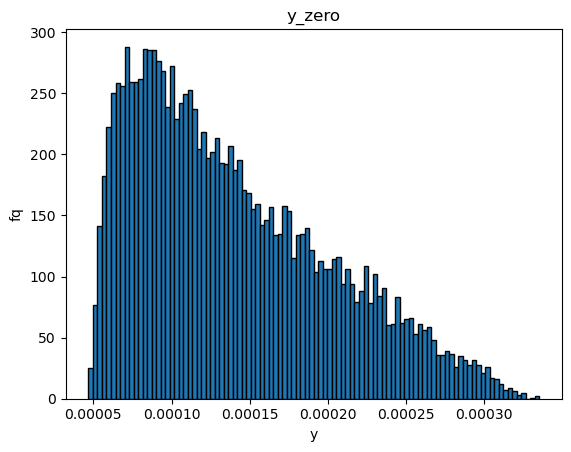

u:  0.4968132174196015
b:  -10
b_xy*u_N:  1.0225482641360222
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4905208013943745
The score for greedy interference is 1086.5236.
The score for zero is 599.5724.
u:  0.4968132174196015
b:  -10
b_xy*u_N:  1.0227195096876236
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4905208013943745
The score for greedy contagion is 892.4467.
starting iteration:  1


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([12645, 1])) that is different to the input size (torch.Size([12645])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.05497491191881461
Pearson with predicted edge probs:  tensor(0.9775)
Spearman with predicted edge probs:  0.974631209426579
Auc with predicted edge probs:  0.9971758099720185
Rmse of predicted edge probs:  0.2705054851115117
Pearson of predicted edge probs:  tensor(0.1000)
Spearman of predicted edge probs:  0.16431177242905698
u:  0.4946856655987585
b:  -10
b_xy*u_N:  1.009050755239225
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.480755985128909
u:  0.49552718839857707
b:  -10
b_xy*u_N:  1.021327560300514
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.47000061920201
Epoch 0, Loss: 0.4726
Epoch 10, Loss: 0.4196
Epoch 20, Loss: 0.4072
Epoch 30, Loss: 0.3792
Epoch 40, Loss: 0.3133
Epoch 50, Loss: 0.2235
Epoch 60, Loss: 0.1725
Epoch 70, Loss: 0.1288
Epoch 80, Loss: 0.1192
Epoch 90, Loss: 0.1098
Epoch 100, Loss: 0.0968
Epoch 110, Loss: 0.0898
Epoch 120, Loss: 0.0771
Epoch 130, Loss: 0.0722
Epoch 140, Loss: 0.0745
AB GNN RMSE Loss: 0.0765
AB GNN pearson:  tensor(0.9753)


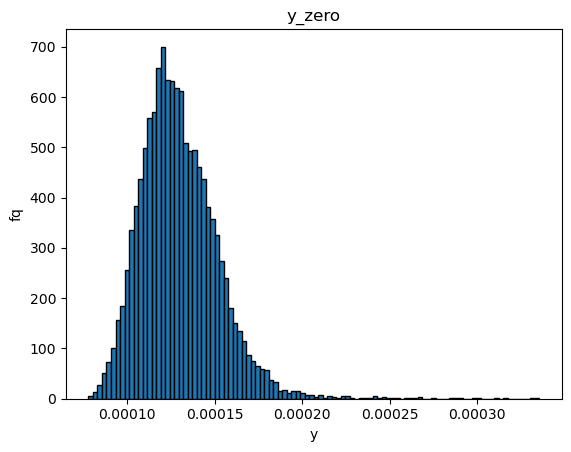

u:  0.5026434162190053
b:  -10
b_xy*u_N:  1.0355464294187426
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5016644621149493
The score for greedy interference is 1018.8908.
The score for zero is 567.4184.
u:  0.5026434162190053
b:  -10
b_xy*u_N:  1.0355198418347173
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5016644621149493
The score for greedy contagion is 1050.8287.
starting iteration:  2


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([12645, 1])) that is different to the input size (torch.Size([12645])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.05082400750179424
Pearson with predicted edge probs:  tensor(0.9802)
Spearman with predicted edge probs:  0.9763190559361721
Auc with predicted edge probs:  0.9983085634744403
Rmse of predicted edge probs:  0.2622251309020914
Pearson of predicted edge probs:  tensor(0.0983)
Spearman of predicted edge probs:  0.1579778309130985
u:  0.4989238126587516
b:  -10
b_xy*u_N:  1.0176469276393834
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5003064242143656
u:  0.5008990657782552
b:  -10
b_xy*u_N:  1.0305689205219455
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5277263516589503
Epoch 0, Loss: 0.4908
Epoch 10, Loss: 0.3787
Epoch 20, Loss: 0.3621
Epoch 30, Loss: 0.3460
Epoch 40, Loss: 0.3235
Epoch 50, Loss: 0.2926
Epoch 60, Loss: 0.2494
Epoch 70, Loss: 0.1807
Epoch 80, Loss: 0.1334
Epoch 90, Loss: 0.1168
Epoch 100, Loss: 0.1043
Epoch 110, Loss: 0.0938
Epoch 120, Loss: 0.0967
Epoch 130, Loss: 0.0889
Epoch 140, Loss: 0.0944
AB GNN RMSE Loss: 0.0838
AB GNN pearson:  tensor(0.95

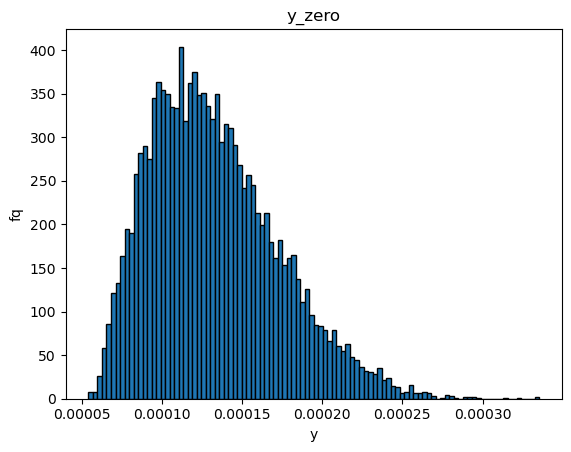

u:  0.4999968981500168
b:  -10
b_xy*u_N:  1.0284386081455121
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4723563347587874
The score for greedy interference is 685.6861.
The score for zero is 536.982.
u:  0.4999968981500168
b:  -10
b_xy*u_N:  1.0285356583629892
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4723563347587874
The score for greedy contagion is 1093.6524000000002.
starting iteration:  3


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([12645, 1])) that is different to the input size (torch.Size([12645])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.05581235373735219
Pearson with predicted edge probs:  tensor(0.9773)
Spearman with predicted edge probs:  0.9639845603963151
Auc with predicted edge probs:  0.9978892881736483
Rmse of predicted edge probs:  0.2661724199849857
Pearson of predicted edge probs:  tensor(0.0797)
Spearman of predicted edge probs:  0.12934346792661
u:  0.49815465922856206
b:  -10
b_xy*u_N:  1.0159584974298141
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.488629876920747
u:  0.4925446785231571
b:  -10
b_xy*u_N:  1.0162473072360616
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4658596077933157
Epoch 0, Loss: 0.5021
Epoch 10, Loss: 0.4195
Epoch 20, Loss: 0.4040
Epoch 30, Loss: 0.3760
Epoch 40, Loss: 0.3290
Epoch 50, Loss: 0.2476
Epoch 60, Loss: 0.1796
Epoch 70, Loss: 0.1384
Epoch 80, Loss: 0.1172
Epoch 90, Loss: 0.1098
Epoch 100, Loss: 0.0903
Epoch 110, Loss: 0.0918
Epoch 120, Loss: 0.0864
Epoch 130, Loss: 0.0756
Epoch 140, Loss: 0.0698
AB GNN RMSE Loss: 0.0862
AB GNN pearson:  tensor(0.9604

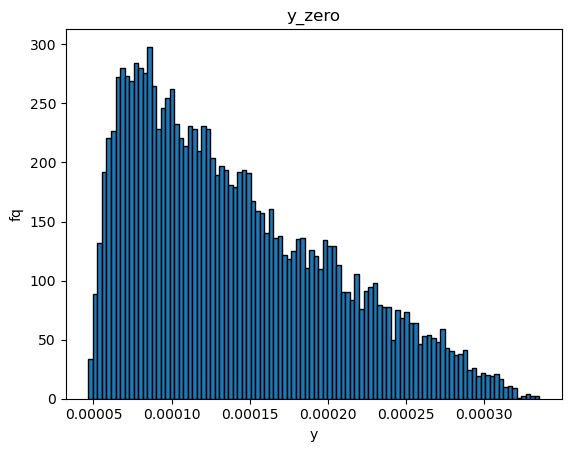

u:  0.4973090690236543
b:  -10
b_xy*u_N:  1.0249899565045473
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5310986477321125
The score for greedy interference is 1165.5121.
The score for zero is 623.9603999999999.
u:  0.4973090690236543
b:  -10
b_xy*u_N:  1.025028200869909
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5310986477321125
The score for greedy contagion is 1184.8633.
starting iteration:  4


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([12645, 1])) that is different to the input size (torch.Size([12645])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.051617113996297224
Pearson with predicted edge probs:  tensor(0.9794)
Spearman with predicted edge probs:  0.9701124980132281
Auc with predicted edge probs:  0.9976442725257891
Rmse of predicted edge probs:  0.26795657049587934
Pearson of predicted edge probs:  tensor(0.0475)
Spearman of predicted edge probs:  0.11186049254916035
u:  0.4963945793997576
b:  -10
b_xy*u_N:  1.0130881929616449
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.515559035583869
u:  0.5024808296560147
b:  -10
b_xy*u_N:  1.03350965599051
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5164646555040218
Epoch 0, Loss: 0.4913
Epoch 10, Loss: 0.4271
Epoch 20, Loss: 0.4192
Epoch 30, Loss: 0.4112
Epoch 40, Loss: 0.4011
Epoch 50, Loss: 0.3867
Epoch 60, Loss: 0.3701
Epoch 70, Loss: 0.3483
Epoch 80, Loss: 0.3318
Epoch 90, Loss: 0.3022
Epoch 100, Loss: 0.2660
Epoch 110, Loss: 0.2551
Epoch 120, Loss: 0.2425
Epoch 130, Loss: 0.2444
Epoch 140, Loss: 0.2370
AB GNN RMSE Loss: 0.0946
AB GNN pearson:  tensor(0.84

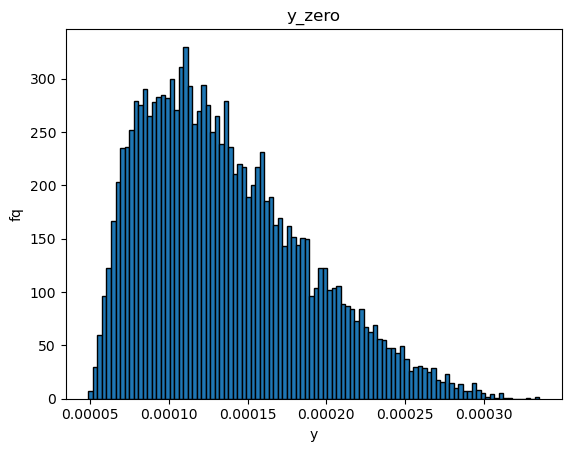

u:  0.4987890705927737
b:  -10
b_xy*u_N:  1.0261080743376827
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4838648547530204
The score for greedy interference is 685.3595.
The score for zero is 539.8082999999999.
u:  0.4987890705927737
b:  -10
b_xy*u_N:  1.0259422538552787
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4838648547530204
The score for greedy contagion is 999.8544999999999.
starting iteration:  5


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([12645, 1])) that is different to the input size (torch.Size([12645])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.04850453201191975
Pearson with predicted edge probs:  tensor(0.9814)
Spearman with predicted edge probs:  0.9783166945708184
Auc with predicted edge probs:  0.9981301315014338
Rmse of predicted edge probs:  0.2538707268147262
Pearson of predicted edge probs:  tensor(0.1089)
Spearman of predicted edge probs:  0.16250556571767596
u:  0.4957561467404052
b:  -10
b_xy*u_N:  1.0111337920126533
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.486576129581775
u:  0.49882733152599934
b:  -10
b_xy*u_N:  1.0239021905891657
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.488718461090539
Epoch 0, Loss: 0.5105
Epoch 10, Loss: 0.4377
Epoch 20, Loss: 0.4271
Epoch 30, Loss: 0.4021
Epoch 40, Loss: 0.3555
Epoch 50, Loss: 0.2803
Epoch 60, Loss: 0.1888
Epoch 70, Loss: 0.1375
Epoch 80, Loss: 0.1246
Epoch 90, Loss: 0.1134
Epoch 100, Loss: 0.1040
Epoch 110, Loss: 0.1047
Epoch 120, Loss: 0.0925
Epoch 130, Loss: 0.0807
Epoch 140, Loss: 0.0741
AB GNN RMSE Loss: 0.0797
AB GNN pearson:  tensor(0.97

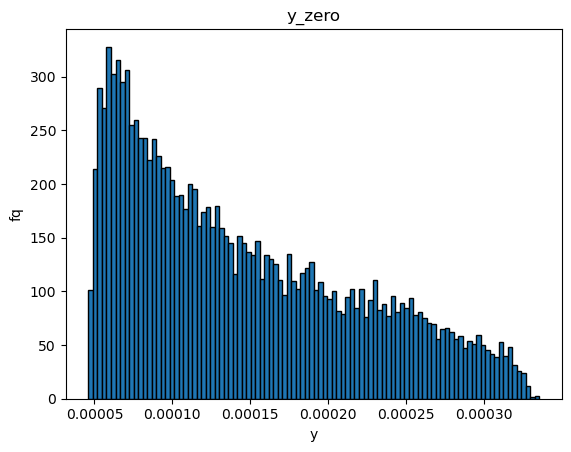

u:  0.4975817220088021
b:  -10
b_xy*u_N:  1.0209520442862792
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4812087479675826
The score for greedy interference is 648.4082999999999.
The score for zero is 476.69539999999995.
u:  0.4975817220088021
b:  -10
b_xy*u_N:  1.0209083748517198
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4812087479675826
The score for greedy contagion is 935.7056999999999.
starting iteration:  6


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([12645, 1])) that is different to the input size (torch.Size([12645])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.05161310154981662
Pearson with predicted edge probs:  tensor(0.9800)
Spearman with predicted edge probs:  0.9765905199085051
Auc with predicted edge probs:  0.9979472870468131
Rmse of predicted edge probs:  0.26571130752862976
Pearson of predicted edge probs:  tensor(0.0735)
Spearman of predicted edge probs:  0.16118829826116723
u:  0.496528981153123
b:  -10
b_xy*u_N:  1.0139701700276789
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5185384000454043
u:  0.4976038423692217
b:  -10
b_xy*u_N:  1.023243495452748
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.504906316033833
Epoch 0, Loss: 0.4691
Epoch 10, Loss: 0.3856
Epoch 20, Loss: 0.3759
Epoch 30, Loss: 0.3542
Epoch 40, Loss: 0.3086
Epoch 50, Loss: 0.2303
Epoch 60, Loss: 0.1493
Epoch 70, Loss: 0.1102
Epoch 80, Loss: 0.0942
Epoch 90, Loss: 0.0881
Epoch 100, Loss: 0.0798
Epoch 110, Loss: 0.0779
Epoch 120, Loss: 0.0734
Epoch 130, Loss: 0.0746
Epoch 140, Loss: 0.0770
AB GNN RMSE Loss: 0.0930
AB GNN pearson:  tensor(0.973

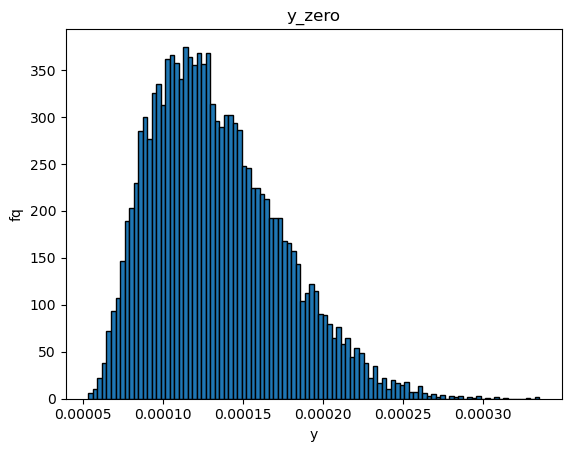

u:  0.5039003629342081
b:  -10
b_xy*u_N:  1.0357148438117834
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.51153549952208
The score for greedy interference is 865.4724.
The score for zero is 508.32269999999994.
u:  0.5039003629342081
b:  -10
b_xy*u_N:  1.0358406642941875
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.51153549952208
The score for greedy contagion is 931.3145999999999.
starting iteration:  7


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([12645, 1])) that is different to the input size (torch.Size([12645])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.07059330301219267
Pearson with predicted edge probs:  tensor(0.9667)
Spearman with predicted edge probs:  0.9587232203817283
Auc with predicted edge probs:  0.9983669568977627
Rmse of predicted edge probs:  0.2540861079613023
Pearson of predicted edge probs:  tensor(-0.0098)
Spearman of predicted edge probs:  0.07032455138053499
u:  0.5023189999865235
b:  -10
b_xy*u_N:  1.0247196678529062
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.510992060398686
u:  0.4985398800475191
b:  -10
b_xy*u_N:  1.0248448714907077
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5171529946905564
Epoch 0, Loss: 0.4089
Epoch 10, Loss: 0.3402
Epoch 20, Loss: 0.3312
Epoch 30, Loss: 0.3262
Epoch 40, Loss: 0.3202
Epoch 50, Loss: 0.3107
Epoch 60, Loss: 0.3042
Epoch 70, Loss: 0.2877
Epoch 80, Loss: 0.2649
Epoch 90, Loss: 0.2281
Epoch 100, Loss: 0.1834
Epoch 110, Loss: 0.1571
Epoch 120, Loss: 0.1305
Epoch 130, Loss: 0.1108
Epoch 140, Loss: 0.1138
AB GNN RMSE Loss: 0.0979
AB GNN pearson:  tensor(0.9

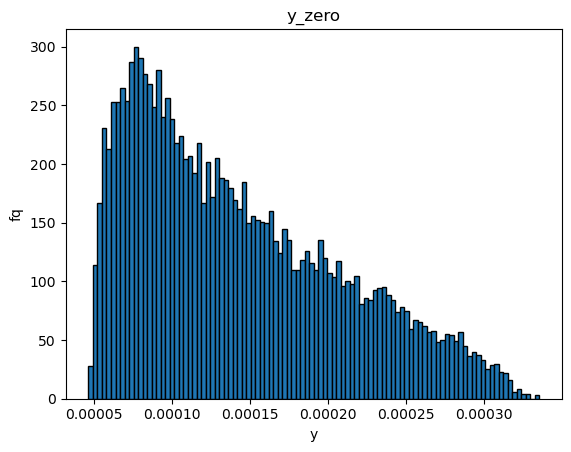

u:  0.5026103766961196
b:  -10
b_xy*u_N:  1.0316893317516804
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.512402214179607
The score for greedy interference is 749.4034999999999.
The score for zero is 499.8.
u:  0.5026103766961196
b:  -10
b_xy*u_N:  1.0316200395413206
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.512402214179607
The score for greedy contagion is 861.6787.
starting iteration:  8


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([12645, 1])) that is different to the input size (torch.Size([12645])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.055038911136990325
Pearson with predicted edge probs:  tensor(0.9778)
Spearman with predicted edge probs:  0.9759226996741719
Auc with predicted edge probs:  0.9974836906116527
Rmse of predicted edge probs:  0.2645814958768905
Pearson of predicted edge probs:  tensor(0.0622)
Spearman of predicted edge probs:  0.12926862029106997
u:  0.4954929205646234
b:  -10
b_xy*u_N:  1.0103449584816133
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.499123221272021
u:  0.4958799826636366
b:  -10
b_xy*u_N:  1.020043432186635
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.496256386399912
Epoch 0, Loss: 0.3387
Epoch 10, Loss: 0.2884
Epoch 20, Loss: 0.2798
Epoch 30, Loss: 0.2631
Epoch 40, Loss: 0.2385
Epoch 50, Loss: 0.2148
Epoch 60, Loss: 0.1880
Epoch 70, Loss: 0.1535
Epoch 80, Loss: 0.1063
Epoch 90, Loss: 0.0768
Epoch 100, Loss: 0.0676
Epoch 110, Loss: 0.0564
Epoch 120, Loss: 0.0535
Epoch 130, Loss: 0.0561
Epoch 140, Loss: 0.0540
AB GNN RMSE Loss: 0.1199
AB GNN pearson:  tensor(0.971

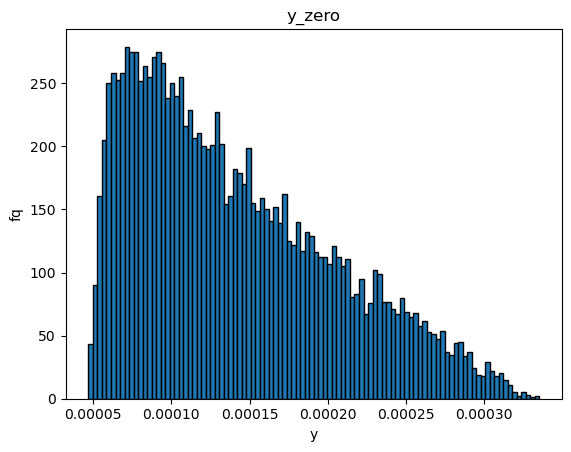

u:  0.4982465860734259
b:  -10
b_xy*u_N:  1.025368018979834
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.507813794882996
The score for greedy interference is 800.6024.
The score for zero is 536.5432000000001.
u:  0.4982465860734259
b:  -10
b_xy*u_N:  1.0252620007908266
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.507813794882996
The score for greedy contagion is 847.6866.
starting iteration:  9


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([12645, 1])) that is different to the input size (torch.Size([12645])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.05329873177532498
Pearson with predicted edge probs:  tensor(0.9775)
Spearman with predicted edge probs:  0.977173960353647
Auc with predicted edge probs:  0.9975419525182557
Rmse of predicted edge probs:  0.2697390985027247
Pearson of predicted edge probs:  tensor(0.0240)
Spearman of predicted edge probs:  0.1039074610451615
u:  0.5052296878433234
b:  -10
b_xy*u_N:  1.031590525899565
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.495426515551713
u:  0.5034661117196314
b:  -10
b_xy*u_N:  1.0344275049426652
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.485024549611626
Epoch 0, Loss: 0.5007
Epoch 10, Loss: 0.4077
Epoch 20, Loss: 0.3810
Epoch 30, Loss: 0.3408
Epoch 40, Loss: 0.2635
Epoch 50, Loss: 0.1863
Epoch 60, Loss: 0.1366
Epoch 70, Loss: 0.1023
Epoch 80, Loss: 0.1100
Epoch 90, Loss: 0.1024
Epoch 100, Loss: 0.0998
Epoch 110, Loss: 0.1116
Epoch 120, Loss: 0.0993
Epoch 130, Loss: 0.0948
Epoch 140, Loss: 0.0867
AB GNN RMSE Loss: 0.0763
AB GNN pearson:  tensor(0.9656)


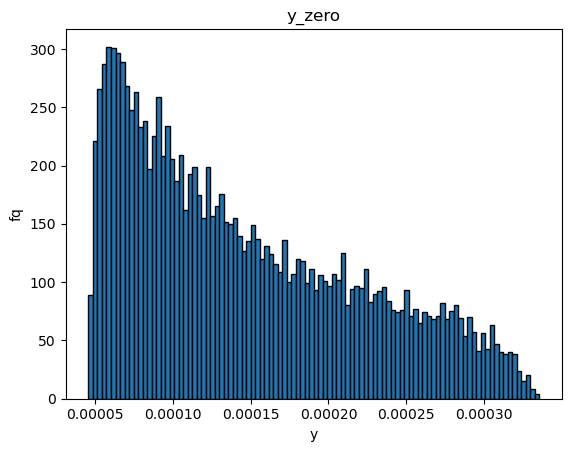

u:  0.5022741981658472
b:  -10
b_xy*u_N:  1.031710130486358
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.510144162032938
The score for greedy interference is 1109.8102.
The score for zero is 535.1121.
u:  0.5022741981658472
b:  -10
b_xy*u_N:  1.0316444918940293
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.510144162032938
The score for greedy contagion is 1119.1952.
y_int:
 mean=881.5668900000001,
 ci_low=740.6789067171944,
 ci_high=1022.4548732828057,
 std=186.84110758916225
y_con:
 mean=991.7226400000002,
 ci_low=908.5022926793278,
 ci_high=1074.9429873206727,
 std=110.36414536602187


In [69]:
G_anybeat = load_directed_graph_from_edges("soc-anybeat/soc-anybeat.edges")

num_sim=10000
num_nodes = G_anybeat.number_of_nodes()
num_edges_per_node=2
prob_selected = 0.05
num_node_features=5
num_edge_features=5
num_graphs=10

b_s=1
b_t=0.5
b_e=1
b0=-3
b=-10
b_ty=5
b_xt=1
b_t=0.5
b_nt=0.5
b_xy=2
b_ep=0.05
prob_treated=0.5
confounding_t=False
damp_factor = 0.1

T=10
attribute_distribution="normal"
max_edge=1/5
normal = False
percentile = 95

y_int = np.zeros(num_graphs)
y_con = np.zeros(num_graphs)

for i in range(num_graphs):
    print("starting iteration: ", i)
    if normal:
        node_weights=np.random.normal(size=num_node_features)
        node_weights_source=np.random.normal(size=num_node_features)
        node_weights_sink=np.random.normal(size=num_node_features)
        epsilon=np.random.normal(size=1)*-4
        edge_weights=np.random.normal(size=num_edge_features)
    else:
        node_weights=np.random.rand(num_node_features)*2-1
        node_weights_source=np.random.rand(num_node_features)*2-1
        node_weights_sink=np.random.rand(num_node_features)*2-1
        epsilon=np.random.rand(1)*-4
        edge_weights=np.random.rand(num_edge_features)*2-1
    edge_method='weighted_sum'
    
    # Edge probabilities prediction
    alpha=1
    G_ab, prior_probs_ab, edge_dict_ab = generate_erdos_renyi_attribute_graph(G_anybeat.number_of_nodes(),
                                                                         0,
                                                                         num_node_features=num_node_features,
                                                                         num_edge_features=num_edge_features,
                                                                         node_weights=node_weights,
                                                                         edge_weights=edge_weights,
                                                                         edge_method=edge_method,
                                                                         max_edge=max_edge,
                                                                         prob_selected=prob_selected,
                                                                         attribute_distribution=attribute_distribution,
                                                                         provided_graph = G_anybeat,
                                                                         both_dir=False)
    
    initial_edge_probs_dict = generate_edge_probabilities(G_ab,method="uniform", p=0)
    edges_ab = list(edge_dict_ab.keys())
    edge_index_ab = torch.tensor(edges_ab, dtype=torch.long).T
    edge_attr_ab = torch.tensor([edge_dict_ab[(u, v)] for (u, v) in edges_ab], dtype=torch.float)
    initial_edge_probs_ab = torch.tensor([initial_edge_probs_dict[(u, v)] for (u, v) in edges_ab], dtype=torch.float)

    data_ab = Data(x=prior_probs_ab.unsqueeze(1), edge_index=edge_index_ab, edge_attr=edge_attr_ab)
    model = edge_probs_prediction(data_ab,
                                  optimized_independent_cascade, 
                                  num_steps=T,
                                  lr=0.1, 
                                  epochs=300,
                                  alpha=alpha,
                                  num_sim=num_sim,
                                  reg_const=0,
                                  initial_edges = initial_edge_probs_ab,
                                  decay=1,
                                  max_edge = max_edge,
                                  print_loss=False)
    
    
    model.eval()
    with torch.no_grad():
        predicted_posterior_ab, predicted_edge_probs_ab = model(G_ab, data_ab.x)
    
    ic = optimized_independent_cascade(G_ab, prior_probs_ab, edge_dict_ab, num_sim)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    true_posterior_tensor_ab = torch.tensor(
        [ic[node] for node in ic],
        dtype=torch.float,
        device=device
    ).view(-1, 1)
    rmse_loss = torch.nn.MSELoss()(predicted_posterior_ab, true_posterior_tensor_ab)
    rmse_loss_prior = torch.nn.MSELoss()(prior_probs_ab.unsqueeze(1), true_posterior_tensor_ab)
    
    rmse_loss = torch.nn.MSELoss()(predicted_edge_probs_ab, edge_attr_ab)
    
    predicted_edge_dict_ab = edge_index_to_dict(edge_index_ab, predicted_edge_probs_ab)
    preds = IC_approx_vectorized(G_ab, predicted_edge_dict_ab, prior_probs_ab, T, 1)
    preds_IC_approx = torch.tensor(preds, dtype=torch.float32).unsqueeze(1)
    rmse = torch.nn.MSELoss()(preds_IC_approx, true_posterior_tensor_ab).item()**0.5
    print("Rmse with predicted edge probs: ", rmse)
    pearson = torch.corrcoef(torch.stack([preds_IC_approx.squeeze(), true_posterior_tensor_ab.squeeze()]))[0, 1]
    print("Pearson with predicted edge probs: ", pearson)
    spearman, _ = spearmanr(preds_IC_approx.squeeze(),
                              true_posterior_tensor_ab.squeeze())
    print("Spearman with predicted edge probs: ", spearman)

    y_true = true_posterior_tensor_ab.squeeze().numpy()
    y_score = preds_IC_approx.squeeze().numpy()
    threshold = np.percentile(y_true, percentile)
    y_binary = (y_true >= threshold).astype(int)
    auc = roc_auc_score(y_binary, y_score)
    print("Auc with predicted edge probs: ", auc)

    rmse_edge = torch.nn.MSELoss()(predicted_edge_probs_ab, edge_attr_ab).item()**0.5
    print("Rmse of predicted edge probs: ", rmse_edge)
    pearson_edge = torch.corrcoef(torch.stack([predicted_edge_probs_ab, edge_attr_ab]))[0, 1]
    print("Pearson of predicted edge probs: ", pearson_edge)
    spearman_edge,_ = spearmanr(predicted_edge_probs_ab, edge_attr_ab)
    print("Spearman of predicted edge probs: ", spearman_edge)

    # GNN training

    G, prior_probs, edge_dict = generate_barabasi_albert_attribute_graph(num_nodes,
                                                                        num_edges_per_node,
                                                                        num_node_features=num_node_features,
                                                                        num_edge_features=num_edge_features,
                                                                        node_weights=node_weights,
                                                                        edge_weights=edge_weights,
                                                                        edge_method=edge_method,
                                                                        max_edge=max_edge,
                                                                        prob_selected=prob_selected,
                                                                        node_weights_source=node_weights_source,
                                                                        node_weights_sink=node_weights_sink,
                                                                        epsilon=epsilon,
                                                                        b_s=b_s,
                                                                        b_t=b_t,
                                                                        b_e=b_e,
                                                                        attribute_distribution=attribute_distribution)

    edges = list(G.edges())
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor([edge_dict[(u, v)] for (u, v) in edges], dtype=torch.float)
    node_features = torch.tensor(
        [G.nodes[node]['features'] for node in G.nodes()],
        dtype=torch.float32
    )
    edge_features = torch.tensor(
        [G.edges[edge]['features'] for edge in G.edges()],
        dtype=torch.float32
    )
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr.unsqueeze(1))
    
    
    node_features_ab = torch.tensor(
        [G_ab.nodes[node]['features'] for node in G_ab.nodes()],
        dtype=torch.float32
    )
    edge_features_ab = torch.tensor(
        [G_ab.edges[edge]['features'] for edge in G_ab.edges()],
        dtype=torch.float32
    )
    edge_attr_pred = torch.tensor([predicted_edge_dict_ab[(u, v)] for (u, v) in predicted_edge_dict_ab], dtype=torch.float)
    data_ab = Data(x=node_features_ab, edge_index=edge_index_ab, edge_attr=edge_attr_pred.unsqueeze(1))
    
    w_ty=np.random.rand(num_node_features)*2-1
    w_xt=np.random.rand(num_node_features)*2-1
    w_xy=np.random.rand(num_node_features)*2-1
    ep=np.random.normal()
    
    coin_toss = np.random.rand(num_nodes)
    t = (coin_toss < prob_treated).astype(int)
    coin_toss_test = np.random.rand(num_nodes)
    t_ab = (coin_toss_test < prob_treated).astype(int)
    
    y=generate_y(G=G,
                 edge_probs=edge_dict, 
                 x=data.x, 
                 w_xy=w_xy, 
                 b_xy=b_xy, 
                 t=t, 
                 w_ty=w_ty, 
                 b_ty=b_ty,
                 b=b,
                 num_sim=num_sim,
                 damp_factor=damp_factor)
    
    y_ab=generate_y(G=G_ab,
                     edge_probs=edge_dict_ab, 
                     x=data_ab.x, 
                     w_xy=w_xy, 
                     b_xy=b_xy, 
                     t=t_ab, 
                     w_ty=w_ty, 
                     b_ty=b_ty,
                     b=b,
                     num_sim=num_sim,
                     damp_factor=damp_factor)
    
    node_features_full=torch.cat([torch.tensor(t, dtype=torch.float32).unsqueeze(1), node_features], dim=1)
    node_features_ab_full=torch.cat([torch.tensor(t_ab, dtype=torch.float32).unsqueeze(1), node_features_ab], dim=1)
    data = Data(x=node_features_full, edge_index=edge_index, edge_attr=edge_attr.unsqueeze(1), y=torch.tensor(y, dtype=torch.float32))
    data_ab = Data(x=node_features_ab_full, edge_index=edge_index_ab, edge_attr=edge_attr_pred.unsqueeze(1), y=torch.tensor(y_ab, dtype=torch.float32))
    model = train_DeepECCNet(data,
                             lr=0.01,
                             epochs=150, 
                             num_layers=1, 
                             loss_type="alpha", 
                             alpha=0.225,
                             hidden_channels=64, 
                             dropout=0.25,
                             w_decay=False)
    
    model.eval()
    with torch.no_grad():
        predicted_y_ab = model(data_ab.x, data_ab.edge_index, data_ab.edge_attr)
        predicted_y = model(data.x, data.edge_index, data.edge_attr)
    print(f"AB GNN RMSE Loss: {(((predicted_y_ab - data_ab.y)**2).mean())**0.5:.4f}")
    pearson_GNN = torch.corrcoef(torch.stack([predicted_y_ab.squeeze(), data_ab.y.squeeze()]))[0, 1]
    print("AB GNN pearson: ", pearson_GNN)
    spearman_GNN, _ = spearmanr(predicted_y_ab.squeeze(),
                              data_ab.y.squeeze())

    print("AB GNN spearman: ", spearman_GNN)

    y_true = data_ab.y.squeeze().numpy()
    y_score = predicted_y_ab.squeeze().numpy()
    threshold = np.percentile(y_ab, percentile)
    y_binary = (y_true >= threshold).astype(int)
    auc_gnn = roc_auc_score(y_binary, y_score)
    print("AB GNN auc: ", auc_gnn)

    t = np.zeros(num_nodes)
    data_ab.x[:,0] = torch.tensor(t, dtype=torch.float32)
    budget = round(0.05 * num_nodes)
    #greedy_interference_t = treatment_interference_celf(G_ab, budget, model, data_ab)
    #greedy_contagion_t = treatment_contagion_celf(G_ab, predicted_edge_dict_ab, budget, model, data_ab, diffusion_method="IC_approx")
    greedy_interference_t = select_top_baseline_nodes(G_ab, budget, model, data_ab)
    #greedy_contagion_t = treatment_contagion_celf(G_test, predicted_edge_dict_test, budget, model, data_test, diffusion_method="IC_approx")
    greedy_contagion_t = select_top_contagion_nodes(G_ab, predicted_edge_dict_test, budget, model, data_ab, diffusion_method="IC_approx")

    y_zero = generate_y(G=G_ab,
                 edge_probs=edge_dict_ab, 
                 x=data_ab.x[:,0:num_node_features], 
                 w_xy=w_xy, 
                 b_xy=b_xy, 
                 t=np.zeros(num_nodes), 
                 w_ty=w_ty, 
                 b_ty=b_ty,
                 b=b,
                 num_sim=num_sim,
                 damp_factor=damp_factor)
    plt.hist(y_zero, bins=100, edgecolor='black')
    plt.title('y_zero')
    plt.xlabel('y')
    plt.ylabel('fq')
    plt.show()
    
    y_interference_1 = generate_y(G=G_ab,
                                 edge_probs=edge_dict_ab, 
                                 x=data_ab.x[:,0:num_node_features], 
                                 w_xy=w_xy, 
                                 b_xy=b_xy, 
                                 t=greedy_interference_t, 
                                 w_ty=w_ty, 
                                 b_ty=b_ty,
                                 b=b,
                                 num_sim=num_sim,
                                 damp_factor=damp_factor)
    y_interference_final = generate_contagion_outcome(G_ab, edge_dict_ab, y_interference_1, diffusion_method="IC", num_sim=num_sim)
    score_interference = y_interference_final.sum()
    y_int[i] = score_interference
    print(f"The score for greedy interference is {score_interference}.")

    y_zero_final = generate_contagion_outcome(G_ab, edge_dict_ab, y_zero, diffusion_method="IC", num_sim=num_sim)
    score_zero = y_zero_final.sum()
    print(f"The score for zero is {score_zero}.")
    
    y_interference_2 = generate_y(G=G_ab,
                                 edge_probs=edge_dict_ab, 
                                 x=data_ab.x[:,0:num_node_features], 
                                 w_xy=w_xy, 
                                 b_xy=b_xy, 
                                 t=greedy_contagion_t, 
                                 w_ty=w_ty, 
                                 b_ty=b_ty,
                                 b=b,
                                 num_sim=num_sim,
                                 damp_factor=damp_factor)
    y_contagion_final = generate_contagion_outcome(G_ab, edge_dict_ab, y_interference_2, diffusion_method="IC", num_sim=num_sim)
    score_contagion = y_contagion_final.sum()
    y_con[i] = score_contagion
    print(f"The score for greedy contagion is {score_contagion}.")

summarise_stats_um(y_int, y_con)

starting iteration:  0


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([6551, 1])) that is different to the input size (torch.Size([6551])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.011010019269120697
Pearson with predicted edge probs:  tensor(0.9985)
Spearman with predicted edge probs:  0.9992572588355458
Auc with predicted edge probs:  0.9998549123172116
Rmse of predicted edge probs:  0.23020197897695524
Pearson of predicted edge probs:  tensor(0.3035)
Spearman of predicted edge probs:  0.33764270193166074
u:  0.502677112827407
b:  -10
b_xy*u_N:  1.1491079224545873
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.488230508439865
u:  0.49921897054279746
b:  -10
b_xy*u_N:  1.1841865669363456
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5146129623973144


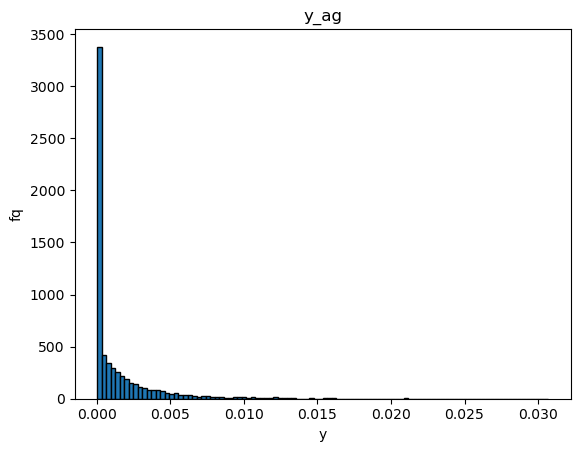

Epoch 0, Loss: 0.4222
Epoch 10, Loss: 0.3622
Epoch 20, Loss: 0.3471
Epoch 30, Loss: 0.3371
Epoch 40, Loss: 0.3032
Epoch 50, Loss: 0.2546
Epoch 60, Loss: 0.1986
Epoch 70, Loss: 0.1618
Epoch 80, Loss: 0.1283
Epoch 90, Loss: 0.1121
Epoch 100, Loss: 0.1052
Epoch 110, Loss: 0.1035
Epoch 120, Loss: 0.0965
Epoch 130, Loss: 0.1016
Epoch 140, Loss: 0.0979
AG GNN RMSE Loss: 0.1131
AG GNN pearson:  tensor(0.7325)
AG GNN spearman:  0.8386255017473373
AG GNN auc:  0.962284385619045
Selected top 328 nodes based on baseline predictions: [3374, 4434, 5832, 4535, 4180, 3842, 5940, 2420, 178, 3998], ...
Selected top 328 nodes based on baseline predictions: [3374, 4434, 5832, 4535, 4180, 991, 3842, 594, 22, 735], ...
u:  0.498603573708733
b:  -10
b_xy*u_N:  1.1771660204548924
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4979130177489073


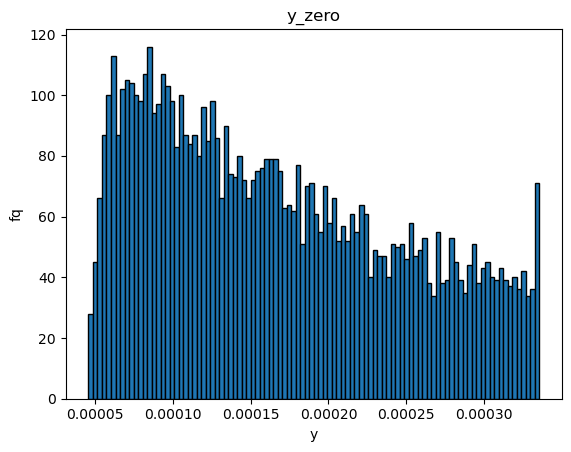

u:  0.498603573708733
b:  -10
b_xy*u_N:  1.1773887956037248
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4979130177489073


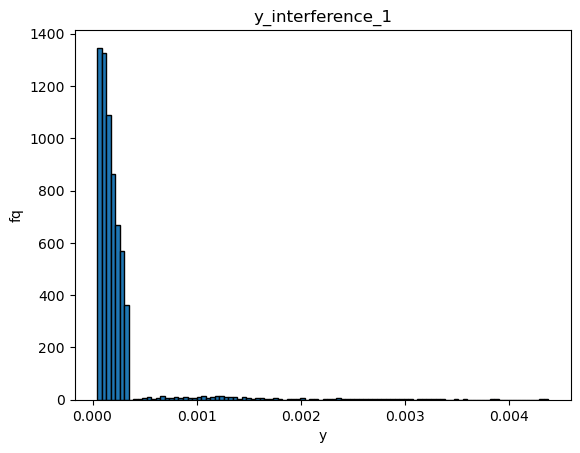

The score for greedy interference is 118.13140000000001.
u:  0.498603573708733
b:  -10
b_xy*u_N:  1.1773458403297208
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4979130177489073


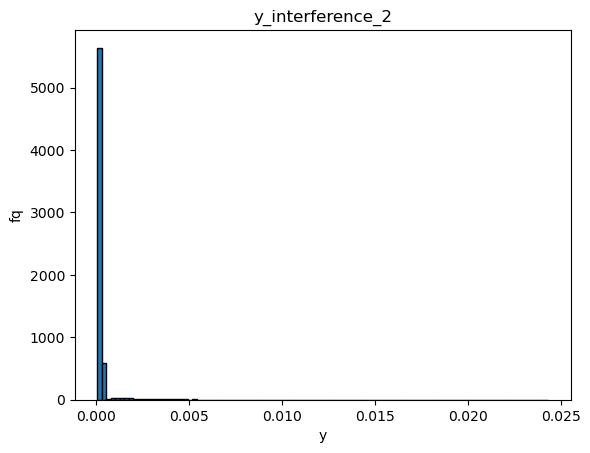

The score for greedy contagion is 316.5959.
starting iteration:  1


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([6551, 1])) that is different to the input size (torch.Size([6551])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.01053417063464077
Pearson with predicted edge probs:  tensor(0.9984)
Spearman with predicted edge probs:  0.9988945602372605
Auc with predicted edge probs:  0.9999838325958385
Rmse of predicted edge probs:  0.2089559410930652
Pearson of predicted edge probs:  tensor(0.2171)
Spearman of predicted edge probs:  0.23883675491056205
u:  0.4977945254961055
b:  -10
b_xy*u_N:  1.142303465119829
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5212329640929294
u:  0.5032380195894861
b:  -10
b_xy*u_N:  1.1859327736223477
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5023243886025184


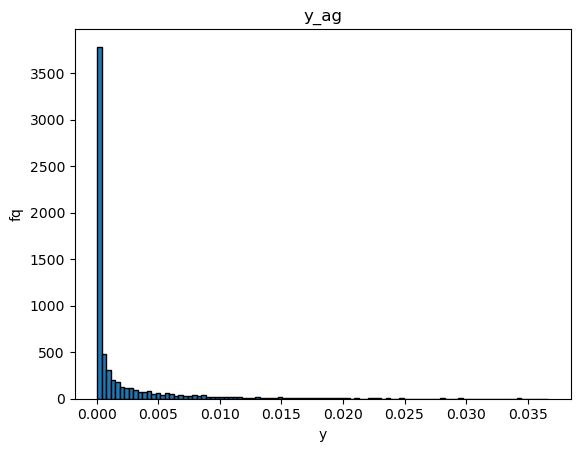

Epoch 0, Loss: 0.4766
Epoch 10, Loss: 0.4033
Epoch 20, Loss: 0.3849
Epoch 30, Loss: 0.3549
Epoch 40, Loss: 0.2990
Epoch 50, Loss: 0.2287
Epoch 60, Loss: 0.1796
Epoch 70, Loss: 0.1459
Epoch 80, Loss: 0.1428
Epoch 90, Loss: 0.1285
Epoch 100, Loss: 0.1134
Epoch 110, Loss: 0.1108
Epoch 120, Loss: 0.1045
Epoch 130, Loss: 0.1046
Epoch 140, Loss: 0.1079
AG GNN RMSE Loss: 0.0557
AG GNN pearson:  tensor(0.9067)
AG GNN spearman:  0.6396168476999053
AG GNN auc:  0.9874016727874173
Selected top 328 nodes based on baseline predictions: [5084, 75, 4060, 4758, 4482, 6444, 2936, 4337, 6054, 675], ...
Selected top 328 nodes based on baseline predictions: [991, 22, 594, 735, 989, 63, 733, 335, 325, 360], ...
u:  0.49723389911980215
b:  -10
b_xy*u_N:  1.175519737444665
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.488162334112105


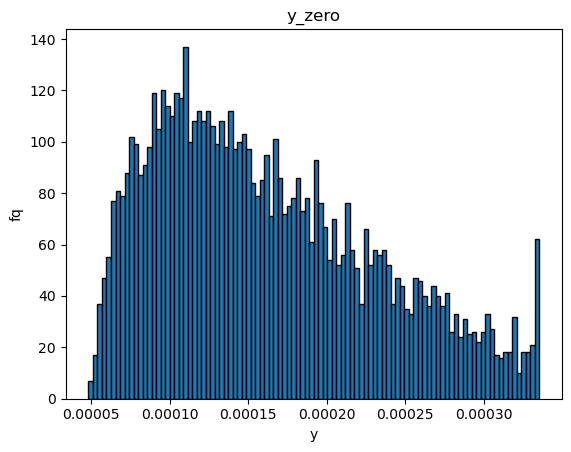

u:  0.49723389911980215
b:  -10
b_xy*u_N:  1.1754586170050372
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.488162334112105


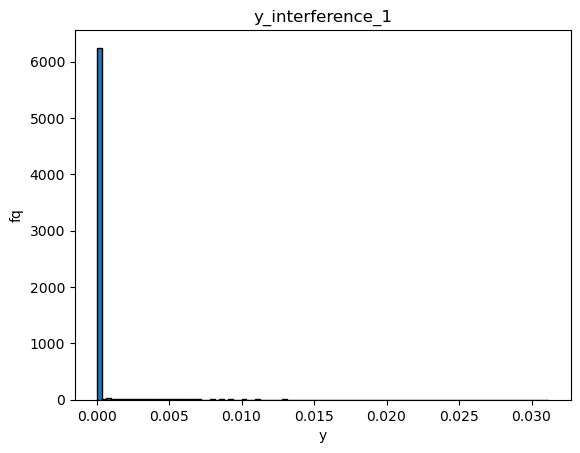

The score for greedy interference is 201.8602.
u:  0.49723389911980215
b:  -10
b_xy*u_N:  1.1753616852388948
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.488162334112105


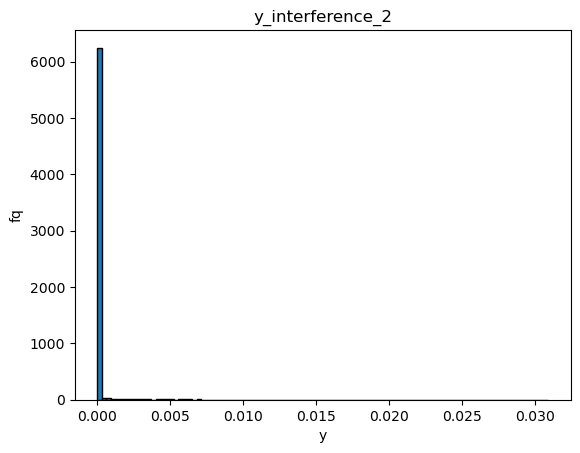

The score for greedy contagion is 332.7861.
starting iteration:  2


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([6551, 1])) that is different to the input size (torch.Size([6551])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.010998936874957906
Pearson with predicted edge probs:  tensor(0.9971)
Spearman with predicted edge probs:  0.9972169548886535
Auc with predicted edge probs:  0.9999470884954711
Rmse of predicted edge probs:  0.1769071864608887
Pearson of predicted edge probs:  tensor(0.1745)
Spearman of predicted edge probs:  0.16317697749506496
u:  0.4988826620114805
b:  -10
b_xy*u_N:  1.1520601740192338
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5047940011570313
u:  0.4910435306009577
b:  -10
b_xy*u_N:  1.1437110670126698
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5144946296828423


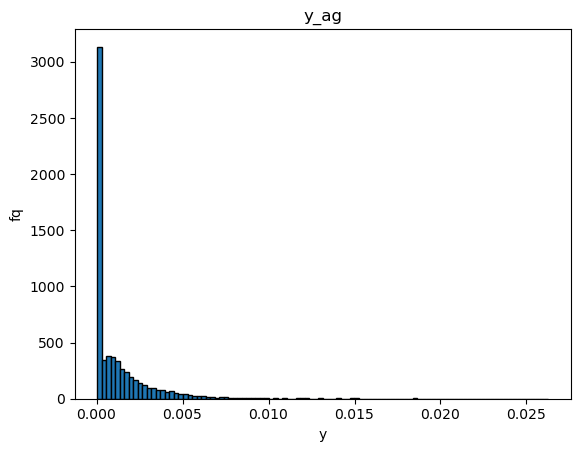

Epoch 0, Loss: 0.3673
Epoch 10, Loss: 0.3051
Epoch 20, Loss: 0.2926
Epoch 30, Loss: 0.2613
Epoch 40, Loss: 0.2126
Epoch 50, Loss: 0.1427
Epoch 60, Loss: 0.1024
Epoch 70, Loss: 0.0963
Epoch 80, Loss: 0.0851
Epoch 90, Loss: 0.0826
Epoch 100, Loss: 0.0737
Epoch 110, Loss: 0.0704
Epoch 120, Loss: 0.0713
Epoch 130, Loss: 0.0721
Epoch 140, Loss: 0.0703
AG GNN RMSE Loss: 0.1127
AG GNN pearson:  tensor(0.8415)
AG GNN spearman:  0.8118020826098085
AG GNN auc:  0.9703982178621401
Selected top 328 nodes based on baseline predictions: [3142, 3752, 5493, 2596, 4401, 3431, 1981, 1897, 3247, 3830], ...
Selected top 328 nodes based on baseline predictions: [991, 22, 594, 735, 989, 63, 733, 360, 335, 325], ...
u:  0.4931350733273545
b:  -10
b_xy*u_N:  1.1468218287284384
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5360092045157874


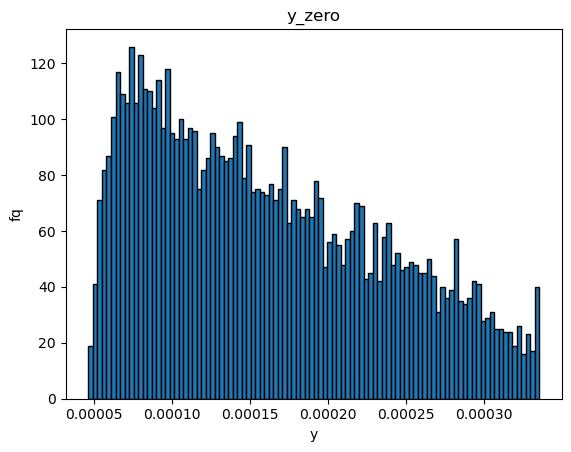

u:  0.4931350733273545
b:  -10
b_xy*u_N:  1.1468291253243779
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5360092045157874


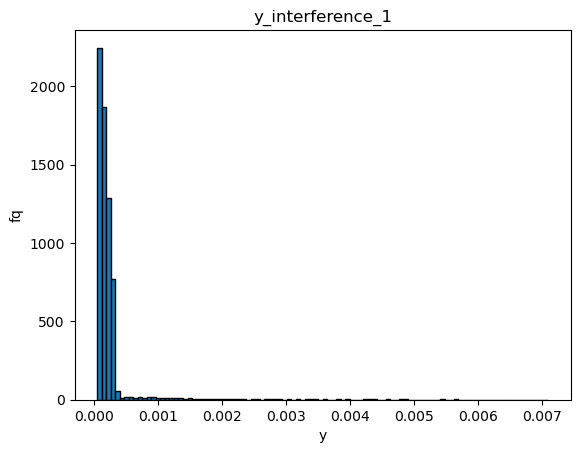

The score for greedy interference is 52.0476.
u:  0.4931350733273545
b:  -10
b_xy*u_N:  1.146875286215845
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5360092045157874


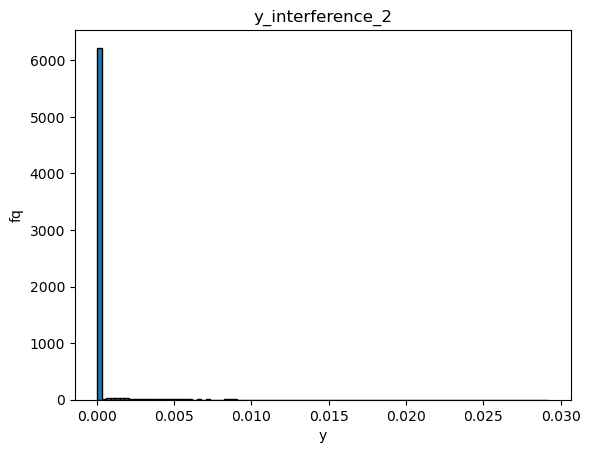

The score for greedy contagion is 157.93380000000002.
starting iteration:  3


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([6551, 1])) that is different to the input size (torch.Size([6551])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.010296410641353218
Pearson with predicted edge probs:  tensor(0.9979)
Spearman with predicted edge probs:  0.9976423074069519
Auc with predicted edge probs:  0.9999735442477357
Rmse of predicted edge probs:  0.2018846642982894
Pearson of predicted edge probs:  tensor(0.2192)
Spearman of predicted edge probs:  0.2251147739980411
u:  0.5022757062207535
b:  -10
b_xy*u_N:  1.1504966875286216
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.491213940505978
u:  0.5008513514670163
b:  -10
b_xy*u_N:  1.1630338879560371
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.498207023648682


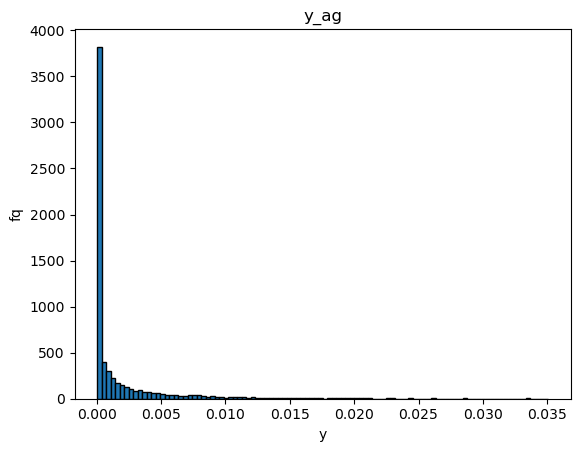

Epoch 0, Loss: 0.4860
Epoch 10, Loss: 0.4016
Epoch 20, Loss: 0.3892
Epoch 30, Loss: 0.3717
Epoch 40, Loss: 0.3542
Epoch 50, Loss: 0.3265
Epoch 60, Loss: 0.2967
Epoch 70, Loss: 0.2446
Epoch 80, Loss: 0.2033
Epoch 90, Loss: 0.1597
Epoch 100, Loss: 0.1283
Epoch 110, Loss: 0.1105
Epoch 120, Loss: 0.0988
Epoch 130, Loss: 0.0878
Epoch 140, Loss: 0.0832
AG GNN RMSE Loss: 0.0824
AG GNN pearson:  tensor(0.9056)
AG GNN spearman:  0.8569025572411703
AG GNN auc:  0.9913004667970512
Selected top 328 nodes based on baseline predictions: [4112, 5649, 4717, 4354, 4085, 4537, 5131, 6359, 1114, 5150], ...
Selected top 328 nodes based on baseline predictions: [991, 22, 594, 735, 63, 989, 733, 335, 325, 360], ...
u:  0.49916408474995283
b:  -10
b_xy*u_N:  1.1627127766753167
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.500434881452686


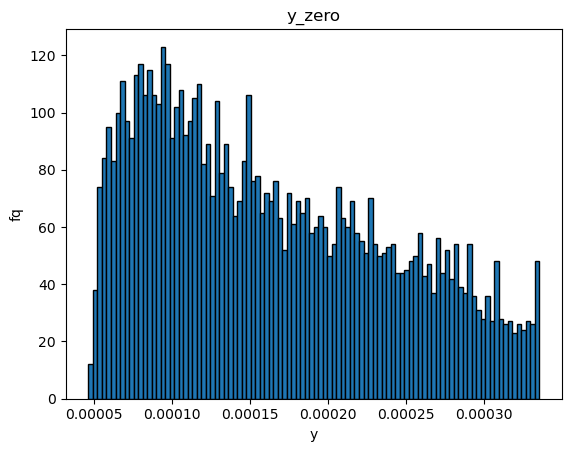

u:  0.49916408474995283
b:  -10
b_xy*u_N:  1.1630196611204398
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.500434881452686


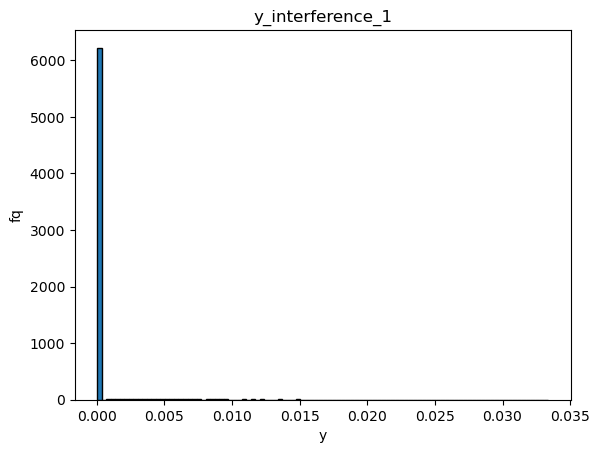

The score for greedy interference is 117.70629999999998.
u:  0.49916408474995283
b:  -10
b_xy*u_N:  1.1630120592275988
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.500434881452686


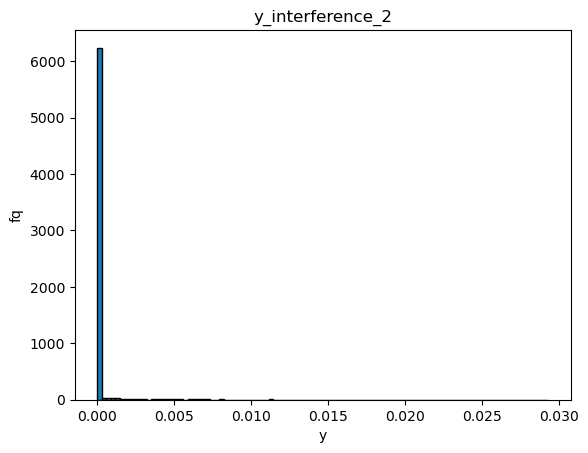

The score for greedy contagion is 194.79399999999998.
starting iteration:  4


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([6551, 1])) that is different to the input size (torch.Size([6551])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.010612110704404432
Pearson with predicted edge probs:  tensor(0.9980)
Spearman with predicted edge probs:  0.9982192570272541
Auc with predicted edge probs:  0.9996977185343122
Rmse of predicted edge probs:  0.2042278556136332
Pearson of predicted edge probs:  tensor(0.2448)
Spearman of predicted edge probs:  0.25731589952204403
u:  0.5028783242246802
b:  -10
b_xy*u_N:  1.1661560983056023
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4761811879879767
u:  0.5029734298206673
b:  -10
b_xy*u_N:  1.1707942604182566
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.519318228869521


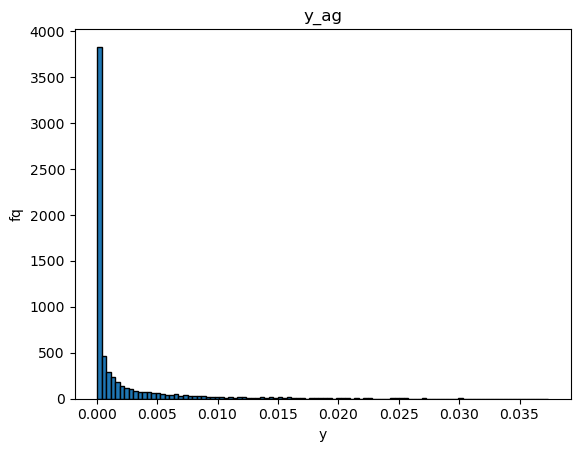

Epoch 0, Loss: 0.4855
Epoch 10, Loss: 0.3938
Epoch 20, Loss: 0.3821
Epoch 30, Loss: 0.3777
Epoch 40, Loss: 0.3602
Epoch 50, Loss: 0.3408
Epoch 60, Loss: 0.3176
Epoch 70, Loss: 0.2965
Epoch 80, Loss: 0.2791
Epoch 90, Loss: 0.2581
Epoch 100, Loss: 0.2183
Epoch 110, Loss: 0.1765
Epoch 120, Loss: 0.1392
Epoch 130, Loss: 0.1401
Epoch 140, Loss: 0.1323
AG GNN RMSE Loss: 0.0933
AG GNN pearson:  tensor(0.8367)
AG GNN spearman:  0.8460710192924585
AG GNN auc:  0.9785448748348965
Selected top 328 nodes based on baseline predictions: [3696, 5937, 5804, 1887, 6379, 5833, 6225, 4440, 4084, 6358], ...
Selected top 328 nodes based on baseline predictions: [3696, 991, 594, 22, 735, 63, 733, 989, 335, 325], ...
u:  0.5009961191748535
b:  -10
b_xy*u_N:  1.1689110059532897
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5041470593191377


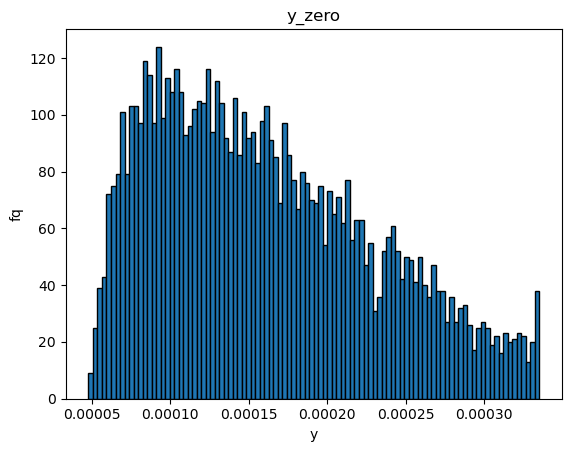

u:  0.5009961191748535
b:  -10
b_xy*u_N:  1.1689241337200427
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5041470593191377


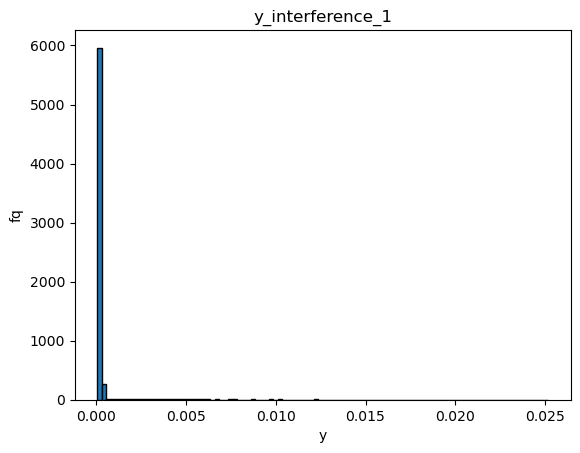

The score for greedy interference is 123.3704.
u:  0.5009961191748535
b:  -10
b_xy*u_N:  1.1689736528774235
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5041470593191377


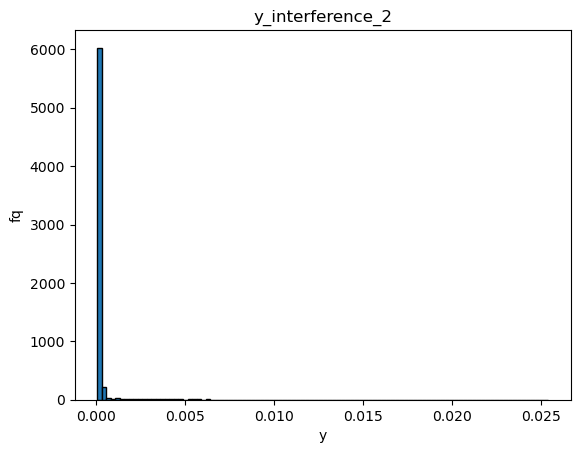

The score for greedy contagion is 208.0965.
starting iteration:  5


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([6551, 1])) that is different to the input size (torch.Size([6551])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.010303860276293063
Pearson with predicted edge probs:  tensor(0.9982)
Spearman with predicted edge probs:  0.9988186362355058
Auc with predicted edge probs:  0.9999642357423092
Rmse of predicted edge probs:  0.20603572161563752
Pearson of predicted edge probs:  tensor(0.2167)
Spearman of predicted edge probs:  0.22923505324767324
u:  0.5020116548452614
b:  -10
b_xy*u_N:  1.148225186994352
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5045881477295806
u:  0.49844700770473993
b:  -10
b_xy*u_N:  1.1639553961227294
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5030336997095866


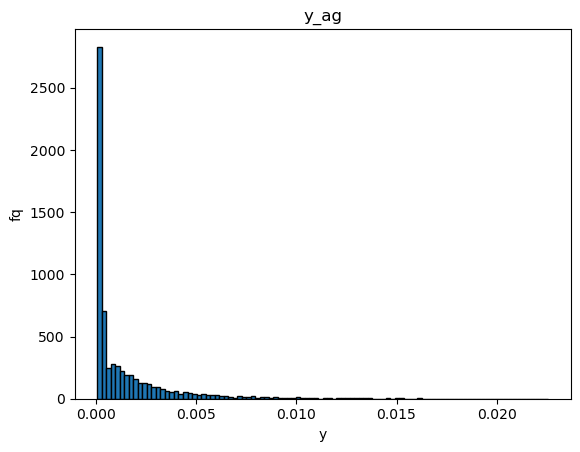

Epoch 0, Loss: 0.4155
Epoch 10, Loss: 0.3712
Epoch 20, Loss: 0.3592
Epoch 30, Loss: 0.3454
Epoch 40, Loss: 0.3136
Epoch 50, Loss: 0.2484
Epoch 60, Loss: 0.1696
Epoch 70, Loss: 0.1326
Epoch 80, Loss: 0.1110
Epoch 90, Loss: 0.1172
Epoch 100, Loss: 0.0933
Epoch 110, Loss: 0.0913
Epoch 120, Loss: 0.0806
Epoch 130, Loss: 0.0823
Epoch 140, Loss: 0.0709
AG GNN RMSE Loss: 0.0967
AG GNN pearson:  tensor(0.9202)
AG GNN spearman:  0.8862731854583595
AG GNN auc:  0.9853606604923514
Selected top 328 nodes based on baseline predictions: [4323, 2531, 5057, 3355, 2433, 1024, 1340, 4982, 4435, 5934], ...
Selected top 328 nodes based on baseline predictions: [991, 22, 594, 735, 63, 989, 733, 335, 325, 360], ...
u:  0.49905248870864816
b:  -10
b_xy*u_N:  1.1678388032361473
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4988769247351175


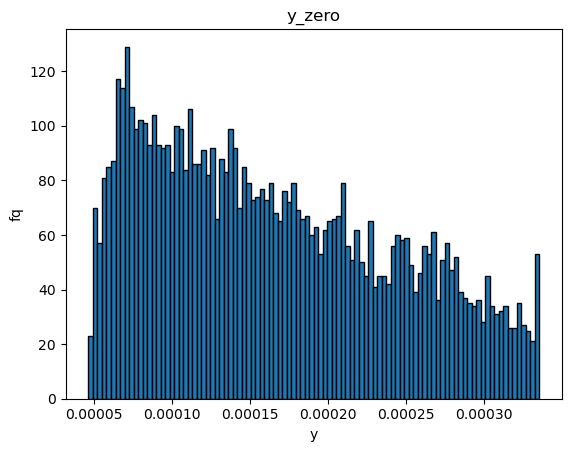

u:  0.49905248870864816
b:  -10
b_xy*u_N:  1.1677969775606778
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4988769247351175


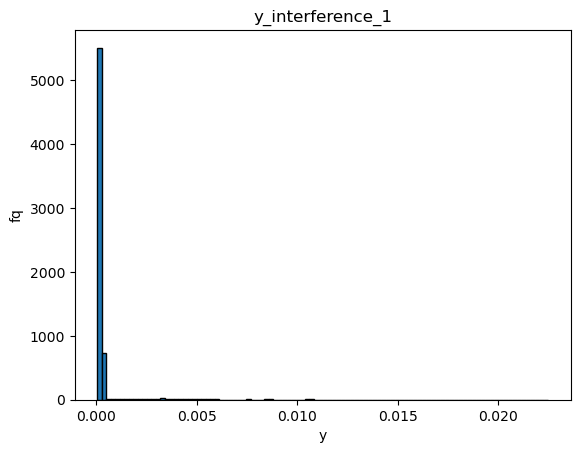

The score for greedy interference is 187.77210000000002.
u:  0.49905248870864816
b:  -10
b_xy*u_N:  1.1679749045947183
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4988769247351175


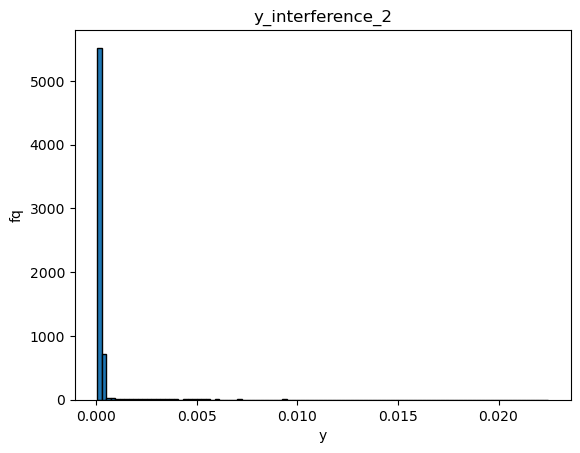

The score for greedy contagion is 227.42780000000002.
starting iteration:  6


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([6551, 1])) that is different to the input size (torch.Size([6551])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.010466972508650174
Pearson with predicted edge probs:  tensor(0.9981)
Spearman with predicted edge probs:  0.9983420048946712
Auc with predicted edge probs:  0.9999867721238678
Rmse of predicted edge probs:  0.2070411103977411
Pearson of predicted edge probs:  tensor(0.2206)
Spearman of predicted edge probs:  0.24470439830116728
u:  0.5026530973550587
b:  -10
b_xy*u_N:  1.160937292016486
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4827841256905048
u:  0.5010781137549277
b:  -10
b_xy*u_N:  1.1701942298885666
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4932942905514053


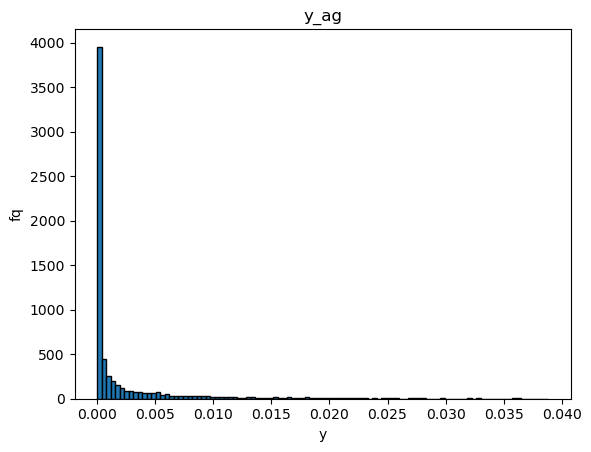

Epoch 0, Loss: 0.4915
Epoch 10, Loss: 0.3776
Epoch 20, Loss: 0.3600
Epoch 30, Loss: 0.3456
Epoch 40, Loss: 0.3171
Epoch 50, Loss: 0.2868
Epoch 60, Loss: 0.2178
Epoch 70, Loss: 0.1736
Epoch 80, Loss: 0.1337
Epoch 90, Loss: 0.0999
Epoch 100, Loss: 0.1030
Epoch 110, Loss: 0.0936
Epoch 120, Loss: 0.0982
Epoch 130, Loss: 0.1037
Epoch 140, Loss: 0.0866
AG GNN RMSE Loss: 0.0549
AG GNN pearson:  tensor(0.9615)
AG GNN spearman:  0.7515926936643545
AG GNN auc:  0.9946128249648237
Selected top 328 nodes based on baseline predictions: [6477, 5154, 4246, 2757, 5346, 6342, 6117, 5726, 5559, 4570], ...
Selected top 328 nodes based on baseline predictions: [991, 22, 594, 735, 989, 63, 733, 335, 325, 360], ...
u:  0.49646096877476537
b:  -10
b_xy*u_N:  1.1620214623721568
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.476462989184656


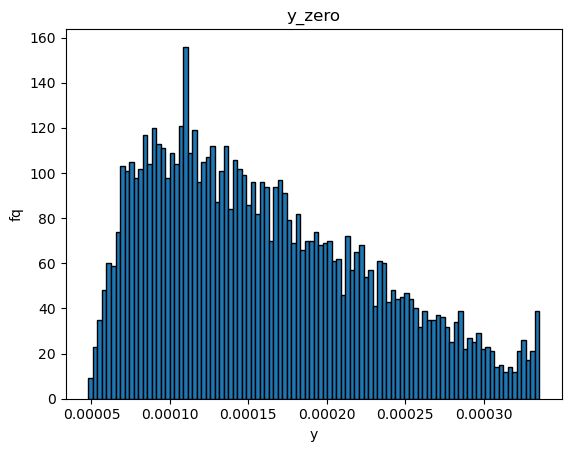

u:  0.49646096877476537
b:  -10
b_xy*u_N:  1.1620803236147155
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.476462989184656


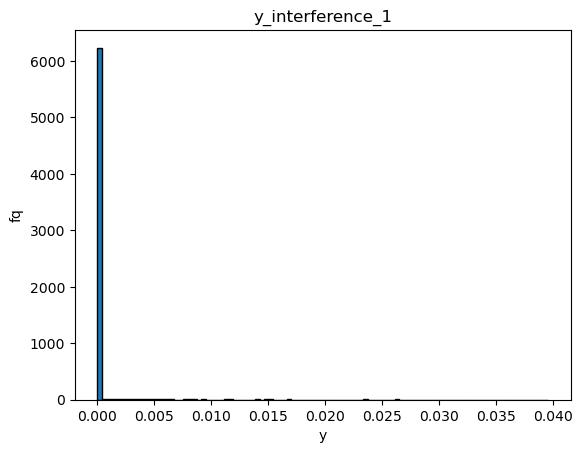

The score for greedy interference is 129.38569999999999.
u:  0.49646096877476537
b:  -10
b_xy*u_N:  1.1619436421920317
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.476462989184656


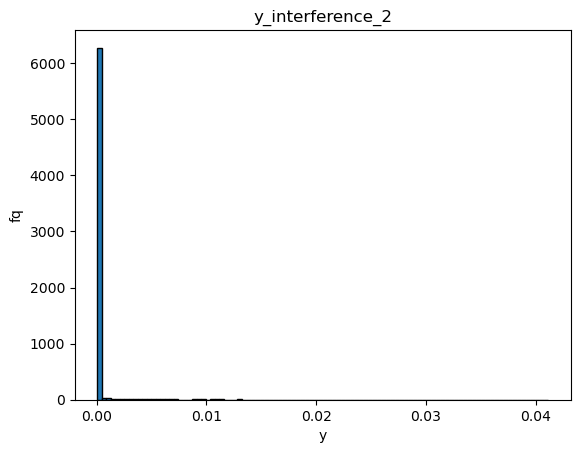

The score for greedy contagion is 250.8239.
starting iteration:  7


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([6551, 1])) that is different to the input size (torch.Size([6551])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.010553189174056423
Pearson with predicted edge probs:  tensor(0.9981)
Spearman with predicted edge probs:  0.9983500436660635
Auc with predicted edge probs:  0.9996986983769885
Rmse of predicted edge probs:  0.21370978638010038
Pearson of predicted edge probs:  tensor(0.2264)
Spearman of predicted edge probs:  0.2550535187886763
u:  0.5004483318525621
b:  -10
b_xy*u_N:  1.1514629216913448
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4985434772906228
u:  0.4984577311138442
b:  -10
b_xy*u_N:  1.1678976034193254
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.495382533202887


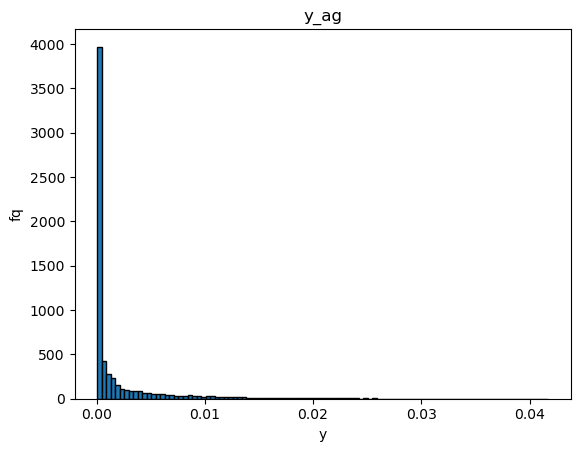

Epoch 0, Loss: 0.4814
Epoch 10, Loss: 0.3917
Epoch 20, Loss: 0.3827
Epoch 30, Loss: 0.3737
Epoch 40, Loss: 0.3621
Epoch 50, Loss: 0.3379
Epoch 60, Loss: 0.2753
Epoch 70, Loss: 0.1916
Epoch 80, Loss: 0.1408
Epoch 90, Loss: 0.1118
Epoch 100, Loss: 0.1310
Epoch 110, Loss: 0.0960
Epoch 120, Loss: 0.1013
Epoch 130, Loss: 0.0998
Epoch 140, Loss: 0.0928
AG GNN RMSE Loss: 0.0649
AG GNN pearson:  tensor(0.9207)
AG GNN spearman:  0.7404414268861251
AG GNN auc:  0.9861073006118137
Selected top 328 nodes based on baseline predictions: [6542, 5866, 3199, 5944, 6380, 4701, 3817, 3017, 2647, 5810], ...
Selected top 328 nodes based on baseline predictions: [991, 22, 594, 735, 989, 63, 733, 335, 325, 360], ...
u:  0.4997522420392477
b:  -10
b_xy*u_N:  1.1699202259197068
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5070537149233427


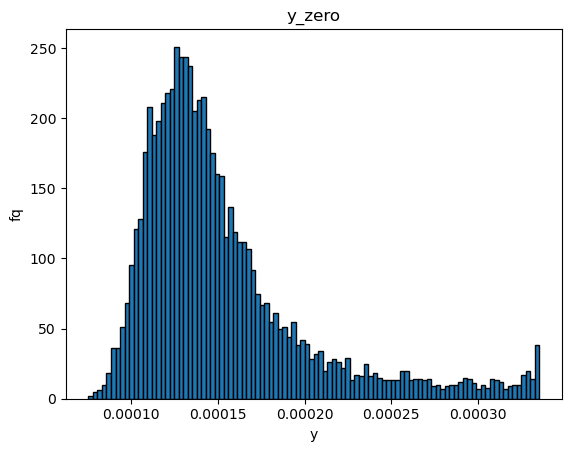

u:  0.4997522420392477
b:  -10
b_xy*u_N:  1.169923004121508
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5070537149233427


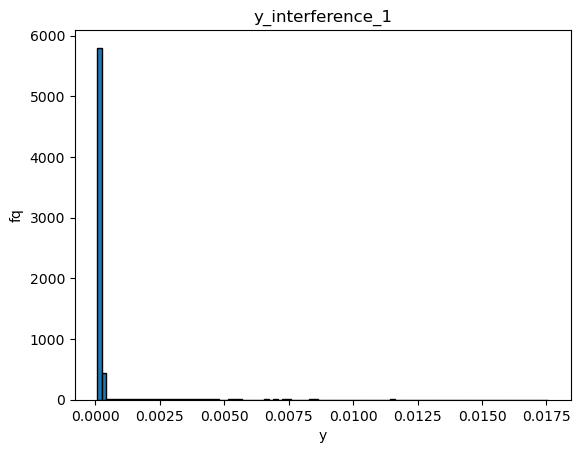

The score for greedy interference is 90.7684.
u:  0.4997522420392477
b:  -10
b_xy*u_N:  1.1700501908105632
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5070537149233427


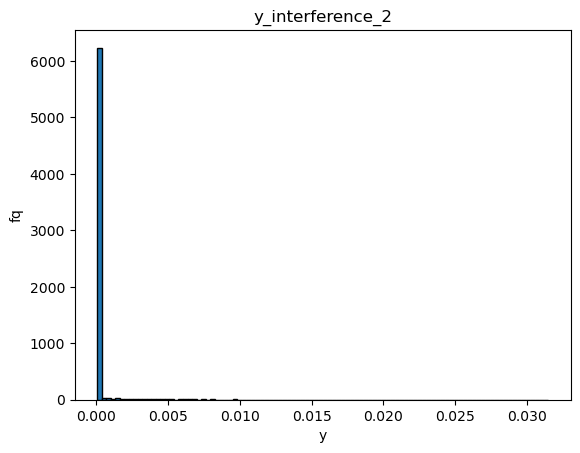

The score for greedy contagion is 225.70889999999997.
starting iteration:  8


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([6551, 1])) that is different to the input size (torch.Size([6551])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.010859552714725558
Pearson with predicted edge probs:  tensor(0.9983)
Spearman with predicted edge probs:  0.9988011078931983
Auc with predicted edge probs:  0.9999049552603834
Rmse of predicted edge probs:  0.22281314943387484
Pearson of predicted edge probs:  tensor(0.2621)
Spearman of predicted edge probs:  0.27714914319994544
u:  0.5012278854732681
b:  -10
b_xy*u_N:  1.1626713478858188
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4971835839086864
u:  0.5006843686750149
b:  -10
b_xy*u_N:  1.1759762784307737
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4942271608791815


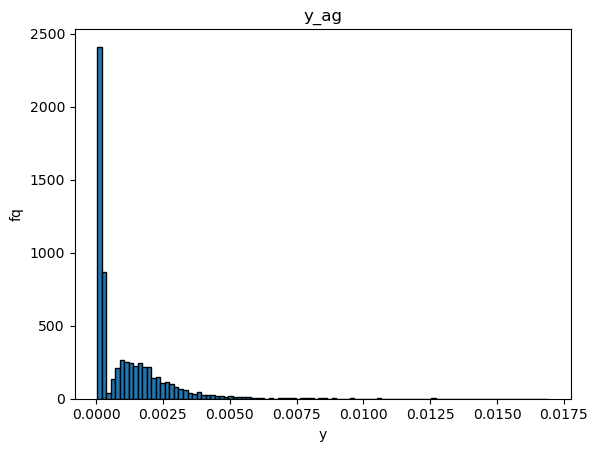

Epoch 0, Loss: 0.3134
Epoch 10, Loss: 0.2693
Epoch 20, Loss: 0.2608
Epoch 30, Loss: 0.2551
Epoch 40, Loss: 0.2409
Epoch 50, Loss: 0.2194
Epoch 60, Loss: 0.1840
Epoch 70, Loss: 0.1277
Epoch 80, Loss: 0.0943
Epoch 90, Loss: 0.0841
Epoch 100, Loss: 0.0763
Epoch 110, Loss: 0.0624
Epoch 120, Loss: 0.0617
Epoch 130, Loss: 0.0618
Epoch 140, Loss: 0.0576
AG GNN RMSE Loss: 0.1168
AG GNN pearson:  tensor(0.8402)
AG GNN spearman:  0.9224934904823514
AG GNN auc:  0.948952646163132
Selected top 328 nodes based on baseline predictions: [3538, 4640, 2977, 4805, 1791, 5984, 5962, 4049, 4239, 1681], ...
Selected top 328 nodes based on baseline predictions: [991, 22, 594, 735, 989, 63, 733, 335, 325, 360], ...
u:  0.4972211890057933
b:  -10
b_xy*u_N:  1.1704583727675164
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5021834433493364


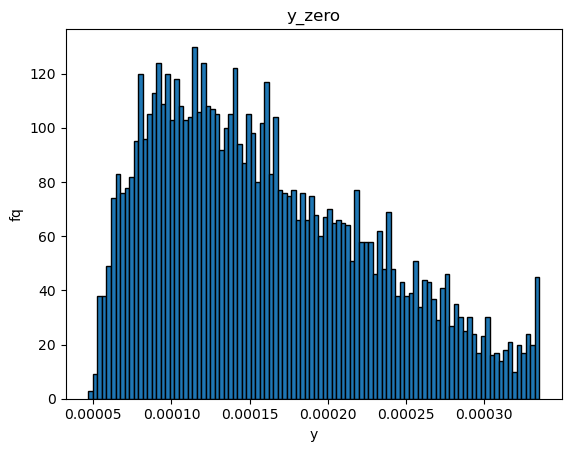

u:  0.4972211890057933
b:  -10
b_xy*u_N:  1.1706406960769349
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5021834433493364


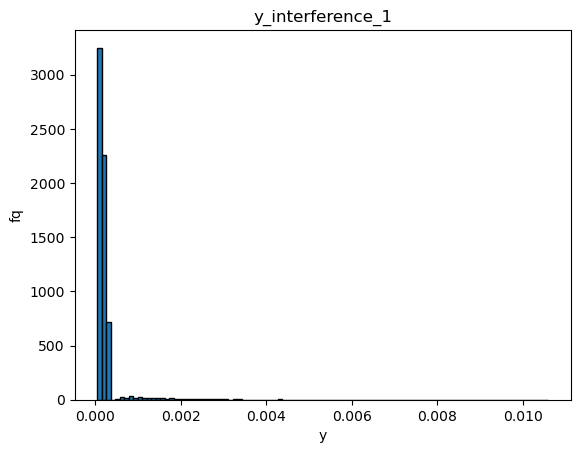

The score for greedy interference is 103.84559999999999.
u:  0.4972211890057933
b:  -10
b_xy*u_N:  1.1705342390474736
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5021834433493364


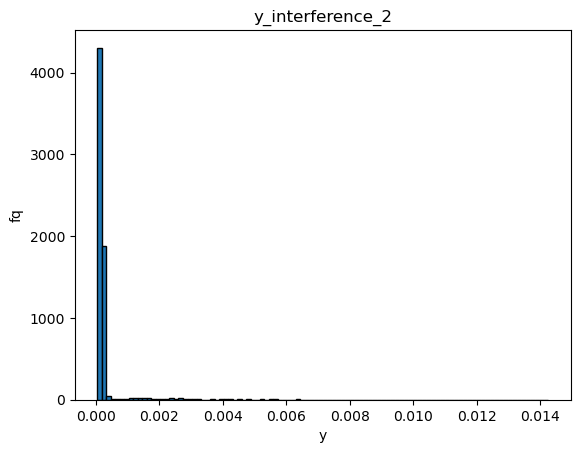

The score for greedy contagion is 221.5295.
starting iteration:  9


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([6551, 1])) that is different to the input size (torch.Size([6551])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.010355695018248812
Pearson with predicted edge probs:  tensor(0.9983)
Spearman with predicted edge probs:  0.9985250601952604
Auc with predicted edge probs:  0.9999697123355795
Rmse of predicted edge probs:  0.2083622952039553
Pearson of predicted edge probs:  tensor(0.2295)
Spearman of predicted edge probs:  0.25061288813352806
u:  0.4907212412583451
b:  -10
b_xy*u_N:  1.1400371546328805
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5368145929578567
u:  0.5030487305285993
b:  -10
b_xy*u_N:  1.1767510609067318
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4826549105191194


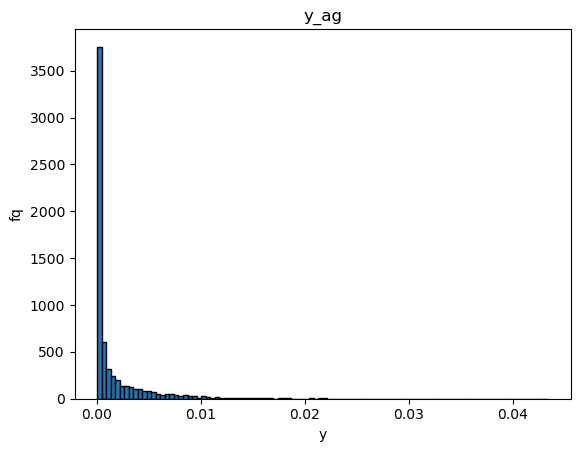

Epoch 0, Loss: 0.4464
Epoch 10, Loss: 0.3880
Epoch 20, Loss: 0.3790
Epoch 30, Loss: 0.3623
Epoch 40, Loss: 0.3231
Epoch 50, Loss: 0.2558
Epoch 60, Loss: 0.2068
Epoch 70, Loss: 0.1609
Epoch 80, Loss: 0.1260
Epoch 90, Loss: 0.1407
Epoch 100, Loss: 0.1118
Epoch 110, Loss: 0.1169
Epoch 120, Loss: 0.1087
Epoch 130, Loss: 0.0985
Epoch 140, Loss: 0.0901
AG GNN RMSE Loss: 0.0565
AG GNN pearson:  tensor(0.8788)
AG GNN spearman:  0.7421337083136695
AG GNN auc:  0.9797192162826337
Selected top 328 nodes based on baseline predictions: [3818, 3744, 5431, 5380, 1833, 5599, 6256, 4176, 4830, 2900], ...
Selected top 328 nodes based on baseline predictions: [991, 22, 594, 735, 989, 63, 733, 335, 325, 360], ...
u:  0.49997058503314773
b:  -10
b_xy*u_N:  1.1718542512593497
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4896036331132207


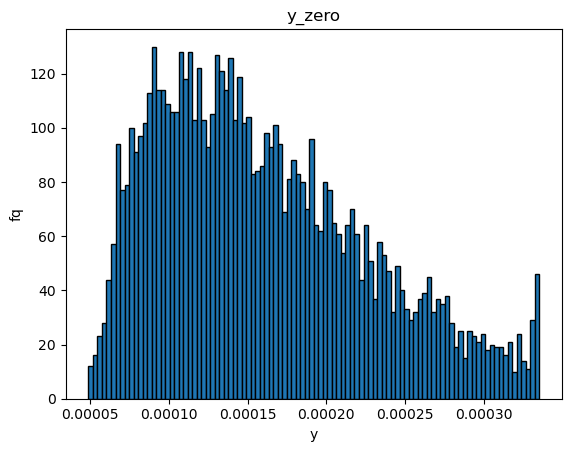

u:  0.49997058503314773
b:  -10
b_xy*u_N:  1.1720327583575028
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4896036331132207


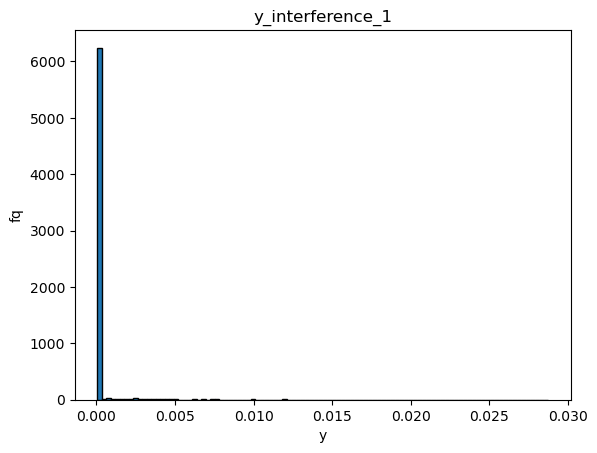

The score for greedy interference is 154.8253.
u:  0.49997058503314773
b:  -10
b_xy*u_N:  1.1720467714852694
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4896036331132207


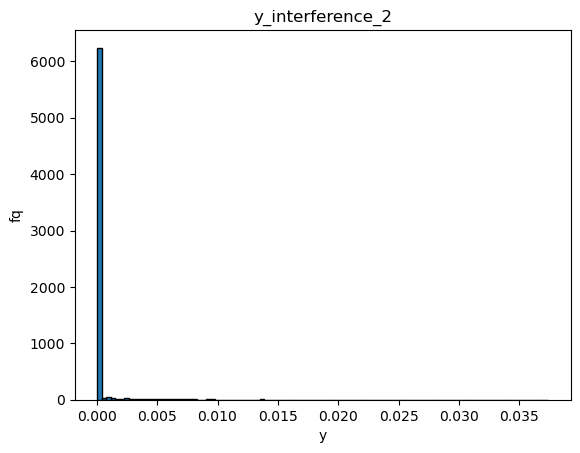

The score for greedy contagion is 250.6319.


In [53]:
G_advogato, edge_weight = load_weighted_directed_graph("soc-advogato/soc-advogato.edges")

num_sim=10000
num_nodes = G_advogato.number_of_nodes()
num_edges_per_node=2
prob_selected = 0.01
num_node_features=5
num_edge_features=5
num_graphs=10

b_s=1
b_t=0.5
b_e=1
b0=-3
b=-10
b_ty=5
b_xt=1
b_t=0.5
b_nt=0.5
b_xy=2
b_ep=0.05
prob_treated=0.5
confounding_t=False
damp_factor = 1

T=10
attribute_distribution="normal"
max_edge=1/7
normal = False
percentile = 95

y_int = np.zeros(num_graphs)
y_con = np.zeros(num_graphs)

for i in range(num_graphs):
    print("starting iteration: ", i)
    if normal:
        node_weights=np.random.normal(size=num_node_features)
        node_weights_source=np.random.normal(size=num_node_features)
        node_weights_sink=np.random.normal(size=num_node_features)
        epsilon=np.random.normal(size=1)*-4
        edge_weights=np.random.normal(size=num_edge_features)
    else:
        node_weights=np.random.rand(num_node_features)*2-1
        node_weights_source=np.random.rand(num_node_features)*2-1
        node_weights_sink=np.random.rand(num_node_features)*2-1
        epsilon=np.random.rand(1)*-4
        edge_weights=np.random.rand(num_edge_features)*2-1
    edge_method='weighted_sum'
    
    # Edge probabilities prediction
    alpha=1
    G_ag, prior_probs_ag, edge_dict_ag = generate_erdos_renyi_attribute_graph(G_advogato.number_of_nodes(),
                                                                         0,
                                                                         num_node_features=num_node_features,
                                                                         num_edge_features=num_edge_features,
                                                                         node_weights=node_weights,
                                                                         edge_weights=edge_weights,
                                                                         edge_method=edge_method,
                                                                         max_edge=max_edge,
                                                                         prob_selected=prob_selected,
                                                                         attribute_distribution=attribute_distribution,
                                                                         provided_graph = G_advogato,
                                                                         both_dir=False)
    for edge in edge_dict_ag:
        edge_dict_ag[edge] *= edge_weight[edge]
    
    initial_edge_probs_dict = generate_edge_probabilities(G_ag,method="uniform", p=0)
    edges_ag = list(edge_dict_ag.keys())
    edge_index_ag = torch.tensor(edges_ag, dtype=torch.long).T
    edge_attr_ag = torch.tensor([edge_dict_ag[(u, v)] for (u, v) in edges_ag], dtype=torch.float)
    initial_edge_probs_ag = torch.tensor([initial_edge_probs_dict[(u, v)] for (u, v) in edges_ag], dtype=torch.float)

    data_ag = Data(x=prior_probs_ag.unsqueeze(1), edge_index=edge_index_ag, edge_attr=edge_attr_ag)
    model = edge_probs_prediction(data_ag,
                                  optimized_independent_cascade, 
                                  num_steps=T,
                                  lr=0.1, 
                                  epochs=300,
                                  alpha=alpha,
                                  num_sim=num_sim,
                                  reg_const=0,
                                  initial_edges = initial_edge_probs_ag,
                                  decay=1,
                                  max_edge = max_edge,
                                  print_loss=False)
    
    
    model.eval()
    with torch.no_grad():
        predicted_posterior_ag, predicted_edge_probs_ag = model(G_ag, data_ag.x)
    
    ic = optimized_independent_cascade(G_ag, prior_probs_ag, edge_dict_ag, num_sim)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    true_posterior_tensor_ag = torch.tensor(
        [ic[node] for node in ic],
        dtype=torch.float,
        device=device
    ).view(-1, 1)
    rmse_loss = torch.nn.MSELoss()(predicted_posterior_ag, true_posterior_tensor_ag)
    rmse_loss_prior = torch.nn.MSELoss()(prior_probs_ag.unsqueeze(1), true_posterior_tensor_ag)
    
    rmse_loss = torch.nn.MSELoss()(predicted_edge_probs_ag, edge_attr_ag)
    
    predicted_edge_dict_ag = edge_index_to_dict(edge_index_ag, predicted_edge_probs_ag)
    preds = IC_approx_vectorized(G_ag, predicted_edge_dict_ag, prior_probs_ag, T, 1)
    preds_IC_approx = torch.tensor(preds, dtype=torch.float32).unsqueeze(1)
    rmse = torch.nn.MSELoss()(preds_IC_approx, true_posterior_tensor_ag).item()**0.5
    print("Rmse with predicted edge probs: ", rmse)
    pearson = torch.corrcoef(torch.stack([preds_IC_approx.squeeze(), true_posterior_tensor_ag.squeeze()]))[0, 1]
    print("Pearson with predicted edge probs: ", pearson)
    spearman, _ = spearmanr(preds_IC_approx.squeeze(),
                              true_posterior_tensor_ag.squeeze())
    print("Spearman with predicted edge probs: ", spearman)

    y_true = true_posterior_tensor_ag.squeeze().numpy()
    y_score = preds_IC_approx.squeeze().numpy()
    threshold = np.percentile(y_true, percentile)
    y_binary = (y_true >= threshold).astype(int)
    auc = roc_auc_score(y_binary, y_score)
    print("Auc with predicted edge probs: ", auc)

    rmse_edge = torch.nn.MSELoss()(predicted_edge_probs_ag, edge_attr_ag).item()**0.5
    print("Rmse of predicted edge probs: ", rmse_edge)
    pearson_edge = torch.corrcoef(torch.stack([predicted_edge_probs_ag, edge_attr_ag]))[0, 1]
    print("Pearson of predicted edge probs: ", pearson_edge)
    spearman_edge,_ = spearmanr(predicted_edge_probs_ag, edge_attr_ag)
    print("Spearman of predicted edge probs: ", spearman_edge)

    # GNN training

    G, prior_probs, edge_dict = generate_barabasi_albert_attribute_graph(num_nodes,
                                                                        num_edges_per_node,
                                                                        num_node_features=num_node_features,
                                                                        num_edge_features=num_edge_features,
                                                                        node_weights=node_weights,
                                                                        edge_weights=edge_weights,
                                                                        edge_method=edge_method,
                                                                        max_edge=max_edge,
                                                                        prob_selected=prob_selected,
                                                                        node_weights_source=node_weights_source,
                                                                        node_weights_sink=node_weights_sink,
                                                                        epsilon=epsilon,
                                                                        b_s=b_s,
                                                                        b_t=b_t,
                                                                        b_e=b_e,
                                                                        attribute_distribution=attribute_distribution)

    edges = list(G.edges())
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor([edge_dict[(u, v)] for (u, v) in edges], dtype=torch.float)
    node_features = torch.tensor(
        [G.nodes[node]['features'] for node in G.nodes()],
        dtype=torch.float32
    )
    edge_features = torch.tensor(
        [G.edges[edge]['features'] for edge in G.edges()],
        dtype=torch.float32
    )
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr.unsqueeze(1))
    
    
    node_features_ag = torch.tensor(
        [G_ag.nodes[node]['features'] for node in G_ag.nodes()],
        dtype=torch.float32
    )
    edge_features_ag = torch.tensor(
        [G_ag.edges[edge]['features'] for edge in G_ag.edges()],
        dtype=torch.float32
    )
    edge_attr_pred = torch.tensor([predicted_edge_dict_ag[(u, v)] for (u, v) in predicted_edge_dict_ag], dtype=torch.float)
    data_ag = Data(x=node_features_ag, edge_index=edge_index_ag, edge_attr=edge_attr_pred.unsqueeze(1))
    
    w_ty=np.random.rand(num_node_features)*2-1
    w_xt=np.random.rand(num_node_features)*2-1
    w_xy=np.random.rand(num_node_features)*2-1
    ep=np.random.normal()
    
    coin_toss = np.random.rand(num_nodes)
    t = (coin_toss < prob_treated).astype(int)
    coin_toss_test = np.random.rand(num_nodes)
    t_ag = (coin_toss_test < prob_treated).astype(int)
    
    y=generate_y(G=G,
                 edge_probs=edge_dict, 
                 x=data.x, 
                 w_xy=w_xy, 
                 b_xy=b_xy, 
                 t=t, 
                 w_ty=w_ty, 
                 b_ty=b_ty,
                 b=b,
                 num_sim=num_sim,
                 damp_factor=damp_factor)
    
    y_ag=generate_y(G=G_ag,
                 edge_probs=edge_dict_ag, 
                 x=data_ag.x, 
                 w_xy=w_xy, 
                 b_xy=b_xy, 
                 t=t_ag, 
                 w_ty=w_ty, 
                 b_ty=b_ty,
                 b=b,
                 num_sim=num_sim,
                 damp_factor=damp_factor)

    plt.hist(y_ag, bins=100, edgecolor='black')
    plt.title('y_ag')
    plt.xlabel('y')
    plt.ylabel('fq')
    plt.show()
    
    node_features_full=torch.cat([torch.tensor(t, dtype=torch.float32).unsqueeze(1), node_features], dim=1)
    node_features_ag_full=torch.cat([torch.tensor(t_ag, dtype=torch.float32).unsqueeze(1), node_features_ag], dim=1)
    data = Data(x=node_features_full, edge_index=edge_index, edge_attr=edge_attr.unsqueeze(1), y=torch.tensor(y, dtype=torch.float32))
    data_ag = Data(x=node_features_ag_full, edge_index=edge_index_ag, edge_attr=edge_attr_pred.unsqueeze(1), y=torch.tensor(y_ag, dtype=torch.float32))
    model = train_DeepECCNet(data,
                             lr=0.01,
                             epochs=150, 
                             num_layers=1, 
                             loss_type="alpha", 
                             alpha=0.225,
                             hidden_channels=64, 
                             dropout=0.25,
                             w_decay=False)
    
    model.eval()
    with torch.no_grad():
        predicted_y_ag = model(data_ag.x, data_ag.edge_index, data_ag.edge_attr)
        predicted_y = model(data.x, data.edge_index, data.edge_attr)
    print(f"AG GNN RMSE Loss: {(((predicted_y_ag - data_ag.y)**2).mean())**0.5:.4f}")
    pearson_GNN = torch.corrcoef(torch.stack([predicted_y_ag.squeeze(), data_ag.y.squeeze()]))[0, 1]
    print("AG GNN pearson: ", pearson_GNN)
    spearman_GNN, _ = spearmanr(predicted_y_ag.squeeze(),
                              data_ag.y.squeeze())

    print("AG GNN spearman: ", spearman_GNN)

    y_true = data_ag.y.squeeze().numpy()
    y_score = predicted_y_ag.squeeze().numpy()
    threshold = np.percentile(y_ag, percentile)
    y_binary = (y_true >= threshold).astype(int)
    auc_gnn = roc_auc_score(y_binary, y_score)
    print("AG GNN auc: ", auc_gnn)

    t = np.zeros(num_nodes)
    data_ag.x[:,0] = torch.tensor(t, dtype=torch.float32)
    budget = round(0.05 * num_nodes)
    #greedy_interference_t = treatment_interference_celf(G_ab, budget, model, data_ab)
    #greedy_contagion_t = treatment_contagion_celf(G_ab, predicted_edge_dict_ab, budget, model, data_ab, diffusion_method="IC_approx")
    greedy_interference_t = select_top_baseline_nodes(G_ag, budget, model, data_ag)
    #greedy_contagion_t = treatment_contagion_celf(G_test, predicted_edge_dict_test, budget, model, data_test, diffusion_method="IC_approx")
    greedy_contagion_t = select_top_contagion_nodes(G_ag, predicted_edge_dict_test, budget, model, data_ag, diffusion_method="IC_approx")

    y_zero = generate_y(G=G_ag,
                 edge_probs=edge_dict_ag, 
                 x=data_ag.x[:,0:num_node_features], 
                 w_xy=w_xy, 
                 b_xy=b_xy, 
                 t=np.zeros(num_nodes), 
                 w_ty=w_ty, 
                 b_ty=b_ty,
                 b=b,
                 num_sim=num_sim,
                 damp_factor=damp_factor)
    plt.hist(y_zero, bins=100, edgecolor='black')
    plt.title('y_zero')
    plt.xlabel('y')
    plt.ylabel('fq')
    plt.show()
    
    y_interference_1 = generate_y(G=G_ag,
                 edge_probs=edge_dict_ag, 
                 x=data_ag.x[:,0:num_node_features], 
                 w_xy=w_xy, 
                 b_xy=b_xy, 
                 t=greedy_interference_t, 
                 w_ty=w_ty, 
                 b_ty=b_ty,
                 b=b,
                 num_sim=num_sim,
                 damp_factor=damp_factor)
    plt.hist(y_interference_1, bins=100, edgecolor='black')
    plt.title('y_interference_1')
    plt.xlabel('y')
    plt.ylabel('fq')
    plt.show()
    y_interference_final = generate_contagion_outcome(G_ag, edge_dict_ag, y_interference_1, diffusion_method="IC", num_sim=num_sim)
    score_interference = y_interference_final.sum()
    y_int[i] = score_interference
    print(f"The score for greedy interference is {score_interference}.")
    
    y_interference_2 = generate_y(G=G_ag,
                 edge_probs=edge_dict_ag, 
                 x=data_ag.x[:,0:num_node_features], 
                 w_xy=w_xy, 
                 b_xy=b_xy, 
                 t=greedy_contagion_t, 
                 w_ty=w_ty, 
                 b_ty=b_ty,
                 b=b,
                 num_sim=num_sim,
                 damp_factor=damp_factor)
    plt.hist(y_interference_2, bins=100, edgecolor='black')
    plt.title('y_interference_2')
    plt.xlabel('y')
    plt.ylabel('fq')
    plt.show()
    y_contagion_final = generate_contagion_outcome(G_ag, edge_dict_ag, y_interference_2, diffusion_method="IC", num_sim=num_sim)
    score_contagion = y_contagion_final.sum()
    y_con[i] = score_contagion
    print(f"The score for greedy contagion is {score_contagion}.")

summarise_stats_um(y_int, y_con)

In [54]:
summarise_stats_um(y_int, y_con)

y_int:
 mean=127.9713,
 ci_low=96.23588872514702,
 ci_high=159.70671127485298,
 std=42.08648072198482
y_con:
 mean=238.63282999999996,
 ci_low=200.7891448389331,
 ci_high=276.4765151610668,
 std=50.18707689609048


## Barabasi Albert

starting iteration:  0


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.05249904514264682
Pearson with predicted edge probs:  tensor(0.9702)
Spearman with predicted edge probs:  0.970520012485323
Auc with predicted edge probs:  0.9960210526315789
Rmse of predicted edge probs:  0.1863926933583775
Pearson of predicted edge probs:  tensor(0.0417)
Spearman of predicted edge probs:  0.18724420033483927
Start gnn training.


/tmp/ipykernel_1220259/2377546584.py:149: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  node_features = torch.tensor(


u:  0.48875870318014364
b:  -8
b_xy*u_N:  1.662168
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4647979601879584
u:  0.4984043402098166
b:  -8
b_xy*u_N:  1.653016
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4429742549764906


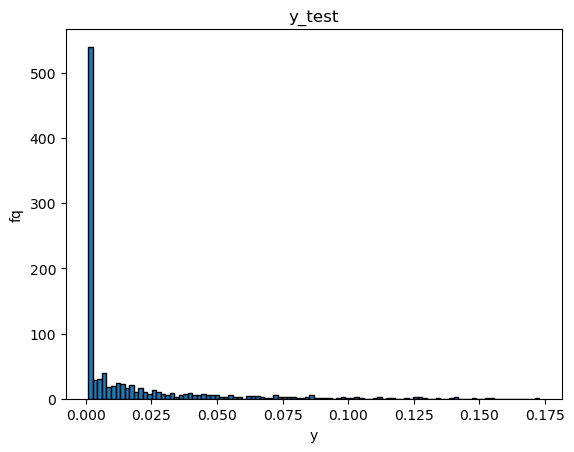

Epoch 0, Loss: 0.4243
Epoch 10, Loss: 0.3733
Epoch 20, Loss: 0.3703
Epoch 30, Loss: 0.3580
Epoch 40, Loss: 0.3473
Epoch 50, Loss: 0.3203
Epoch 60, Loss: 0.2814
Epoch 70, Loss: 0.2229
Epoch 80, Loss: 0.1328
Epoch 90, Loss: 0.1400
Epoch 100, Loss: 0.1267
Epoch 110, Loss: 0.1086
Epoch 120, Loss: 0.1243
Epoch 130, Loss: 0.1165
Epoch 140, Loss: 0.0995
Test GNN RMSE Loss: 0.0445
Test GNN pearson:  tensor(0.9271)
Test GNN spearman:  0.5348867305666338
Test GNN auc:  0.988378947368421
Started with allocation.
CELF selected 1/50: Node 0 with gain 569.0326
CELF selected 2/50: Node 237 with gain 569.0218
CELF selected 3/50: Node 12 with gain 568.9492
CELF selected 4/50: Node 939 with gain 568.9327
CELF selected 5/50: Node 788 with gain 568.9263
CELF selected 6/50: Node 589 with gain 568.9185
CELF selected 7/50: Node 20 with gain 568.9161
CELF selected 8/50: Node 16 with gain 568.9114
CELF selected 9/50: Node 598 with gain 568.8993
CELF selected 10/50: Node 580 with gain 568.8975
CELF selected 11/

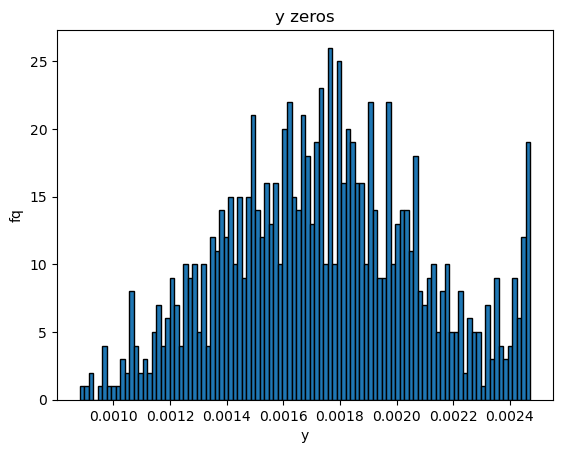

y_zero sum:  1.74437237372282
u:  0.4919288392741997
b:  -8
b_xy*u_N:  1.6245900000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.512970287075806


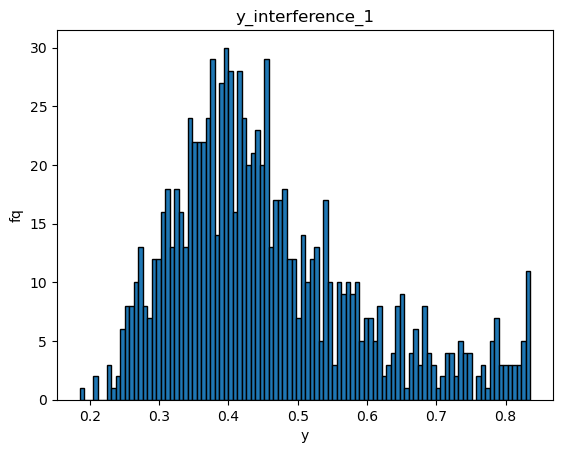

y_interference_1 sum:  2.7991861807091185
The score for greedy interference is 456.21999999999997.
u:  0.4919288392741997
b:  -8
b_xy*u_N:  1.627386
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.512970287075806


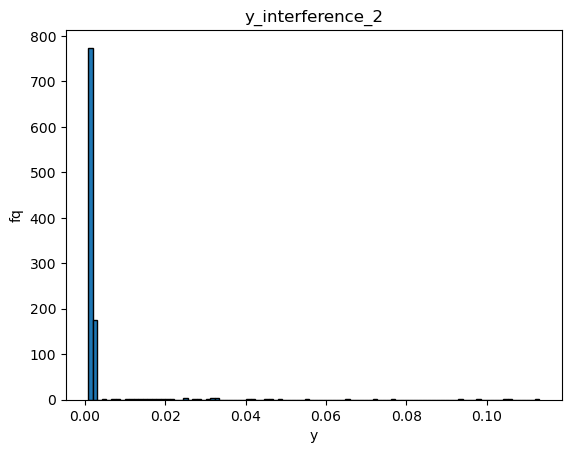

y_interference_2 sum:  3.542692105259473
The score for greedy contagion is 507.87299999999993.
The score for zero is 330.065.
starting iteration:  1


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.049981865630431534
Pearson with predicted edge probs:  tensor(0.9794)
Spearman with predicted edge probs:  0.9741256782941816
Auc with predicted edge probs:  0.9979157894736842
Rmse of predicted edge probs:  0.1754646947736903
Pearson of predicted edge probs:  tensor(0.0187)
Spearman of predicted edge probs:  0.17401107922438266
Start gnn training.
u:  0.5021852764018738
b:  -8
b_xy*u_N:  1.657044
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.527008990944542
u:  0.497967164334394
b:  -8
b_xy*u_N:  1.6709580000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5059546592838906


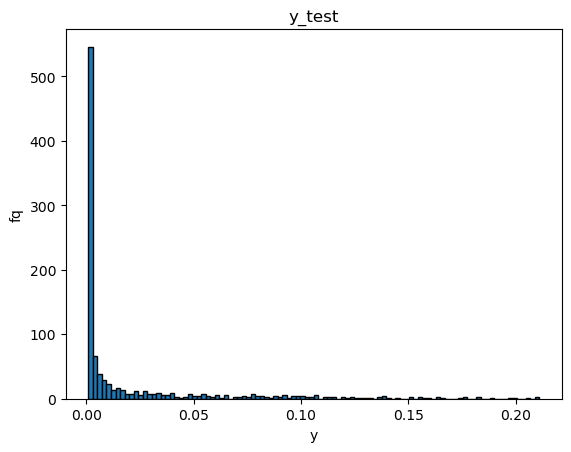

Epoch 0, Loss: 0.4432
Epoch 10, Loss: 0.4131
Epoch 20, Loss: 0.3987
Epoch 30, Loss: 0.3879
Epoch 40, Loss: 0.3451
Epoch 50, Loss: 0.2754
Epoch 60, Loss: 0.2251
Epoch 70, Loss: 0.1547
Epoch 80, Loss: 0.1111
Epoch 90, Loss: 0.1026
Epoch 100, Loss: 0.0821
Epoch 110, Loss: 0.0676
Epoch 120, Loss: 0.0726
Epoch 130, Loss: 0.0580
Epoch 140, Loss: 0.0651
Test GNN RMSE Loss: 0.0614
Test GNN pearson:  tensor(0.9456)
Test GNN spearman:  0.6318726270524277
Test GNN auc:  0.9893473684210525
Started with allocation.
CELF selected 1/50: Node 186 with gain 564.1550
CELF selected 2/50: Node 227 with gain 563.9268
CELF selected 3/50: Node 295 with gain 563.9152
CELF selected 4/50: Node 425 with gain 563.7897
CELF selected 5/50: Node 208 with gain 563.7867
CELF selected 6/50: Node 827 with gain 563.7358
CELF selected 7/50: Node 468 with gain 563.6592
CELF selected 8/50: Node 488 with gain 563.6458
CELF selected 9/50: Node 496 with gain 563.6402
CELF selected 10/50: Node 489 with gain 563.6299
CELF select

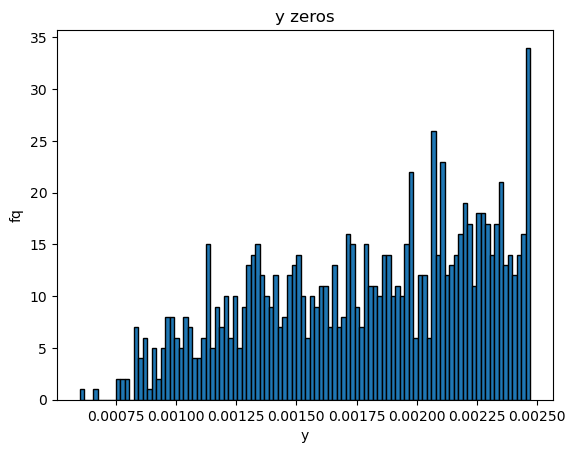

y_zero sum:  1.7954775250684982
u:  0.5011589168965822
b:  -8
b_xy*u_N:  1.640326
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5028459359340953


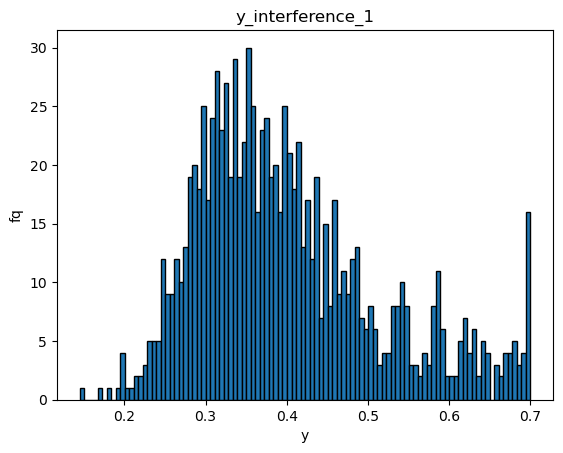

y_interference_1 sum:  1.9651219240794031
The score for greedy interference is 400.68800000000005.
u:  0.5011589168965822
b:  -8
b_xy*u_N:  1.6399000000000001
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5028459359340953


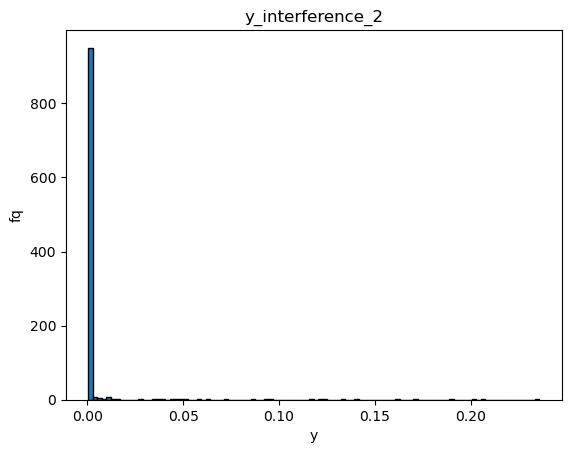

y_interference_2 sum:  4.643693707426354
The score for greedy contagion is 563.207.
The score for zero is 366.494.
starting iteration:  2


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.05764593603308596
Pearson with predicted edge probs:  tensor(0.9811)
Spearman with predicted edge probs:  0.9743251050417605
Auc with predicted edge probs:  0.9987157894736842
Rmse of predicted edge probs:  0.15948987939058137
Pearson of predicted edge probs:  tensor(0.0211)
Spearman of predicted edge probs:  0.1511699620306827
Start gnn training.
u:  0.4951658533340857
b:  -8
b_xy*u_N:  1.647464
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4948342612696424
u:  0.4881881215249963
b:  -8
b_xy*u_N:  1.620774
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5389340734993597


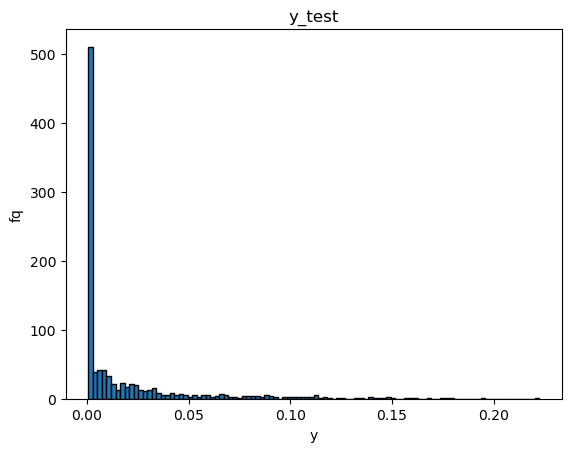

Epoch 0, Loss: 0.4322
Epoch 10, Loss: 0.3968
Epoch 20, Loss: 0.3857
Epoch 30, Loss: 0.3838
Epoch 40, Loss: 0.3489
Epoch 50, Loss: 0.2642
Epoch 60, Loss: 0.1726
Epoch 70, Loss: 0.1855
Epoch 80, Loss: 0.1415
Epoch 90, Loss: 0.1142
Epoch 100, Loss: 0.0955
Epoch 110, Loss: 0.0694
Epoch 120, Loss: 0.0613
Epoch 130, Loss: 0.0830
Epoch 140, Loss: 0.0781
Test GNN RMSE Loss: 0.0317
Test GNN pearson:  tensor(0.9606)
Test GNN spearman:  0.8791141718960033
Test GNN auc:  0.9922315789473685
Started with allocation.
CELF selected 1/50: Node 11 with gain 514.6665
CELF selected 2/50: Node 463 with gain 513.3517
CELF selected 3/50: Node 708 with gain 513.3395
CELF selected 4/50: Node 835 with gain 513.3333
CELF selected 5/50: Node 915 with gain 513.2974
CELF selected 6/50: Node 705 with gain 513.2719
CELF selected 7/50: Node 390 with gain 513.2702
CELF selected 8/50: Node 249 with gain 513.2670
CELF selected 9/50: Node 716 with gain 513.2539
CELF selected 10/50: Node 706 with gain 513.2527
CELF selecte

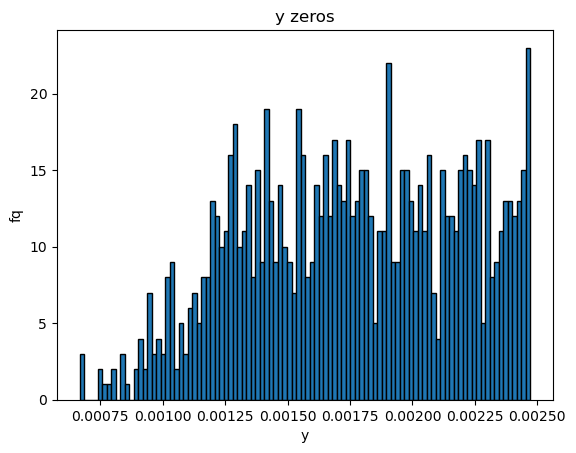

y_zero sum:  1.7569369267803916
u:  0.5043496239875876
b:  -8
b_xy*u_N:  1.624208
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5333821139538886


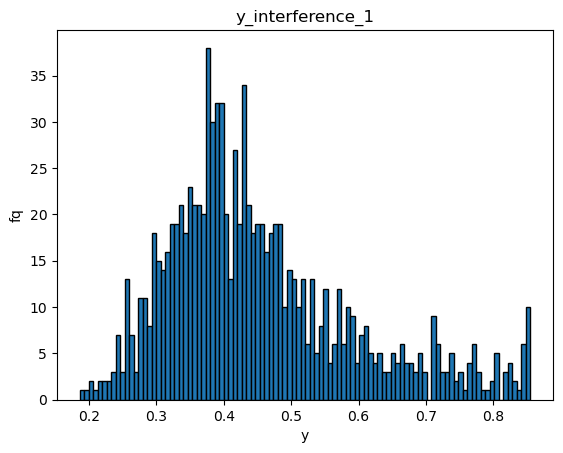

y_interference_1 sum:  3.562954229694447
The score for greedy interference is 452.657.
u:  0.5043496239875876
b:  -8
b_xy*u_N:  1.6243340000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5333821139538886


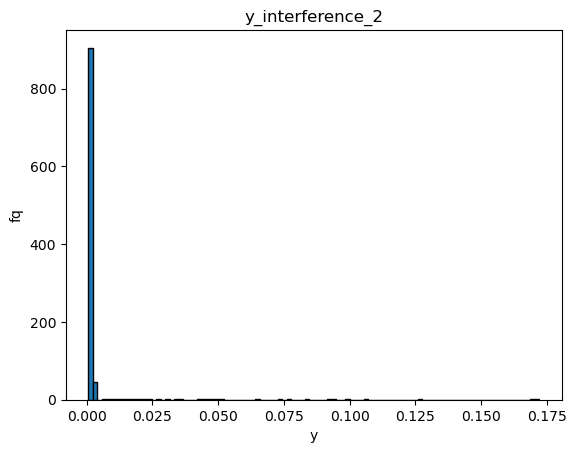

y_interference_2 sum:  3.7264105938132936
The score for greedy contagion is 499.599.
The score for zero is 328.072.
starting iteration:  3


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.05235030796831794
Pearson with predicted edge probs:  tensor(0.9782)
Spearman with predicted edge probs:  0.9731190280745491
Auc with predicted edge probs:  0.9983264117027211
Rmse of predicted edge probs:  0.18396299849484968
Pearson of predicted edge probs:  tensor(0.0234)
Spearman of predicted edge probs:  0.128854589672199
Start gnn training.
u:  0.4996950683440439
b:  -8
b_xy*u_N:  1.645082
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.527445193575198
u:  0.5014403952397658
b:  -8
b_xy*u_N:  1.63213
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.504099926466419


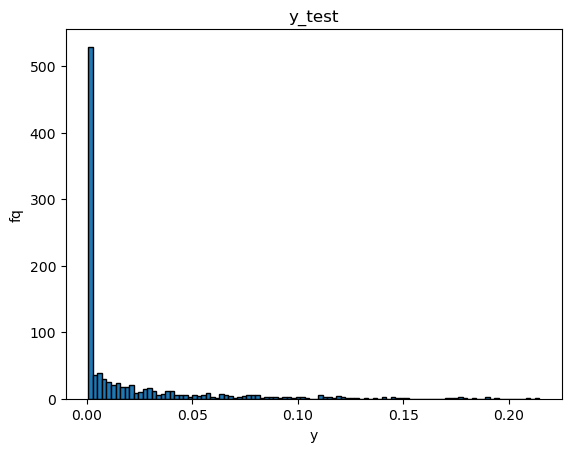

Epoch 0, Loss: 0.4384
Epoch 10, Loss: 0.3995
Epoch 20, Loss: 0.3878
Epoch 30, Loss: 0.3671
Epoch 40, Loss: 0.3396
Epoch 50, Loss: 0.2648
Epoch 60, Loss: 0.2013
Epoch 70, Loss: 0.1184
Epoch 80, Loss: 0.1013
Epoch 90, Loss: 0.0818
Epoch 100, Loss: 0.1008
Epoch 110, Loss: 0.0759
Epoch 120, Loss: 0.0870
Epoch 130, Loss: 0.0520
Epoch 140, Loss: 0.0507
Test GNN RMSE Loss: 0.0404
Test GNN pearson:  tensor(0.9635)
Test GNN spearman:  0.8782398047143735
Test GNN auc:  0.9942105263157894
Started with allocation.
CELF selected 1/50: Node 988 with gain 561.2264
CELF selected 2/50: Node 351 with gain 561.2023
CELF selected 3/50: Node 394 with gain 561.1892
CELF selected 4/50: Node 979 with gain 561.1855
CELF selected 5/50: Node 466 with gain 561.1789
CELF selected 6/50: Node 939 with gain 561.1783
CELF selected 7/50: Node 539 with gain 561.1737
CELF selected 8/50: Node 961 with gain 561.1692
CELF selected 9/50: Node 999 with gain 561.1611
CELF selected 10/50: Node 951 with gain 561.1482
CELF select

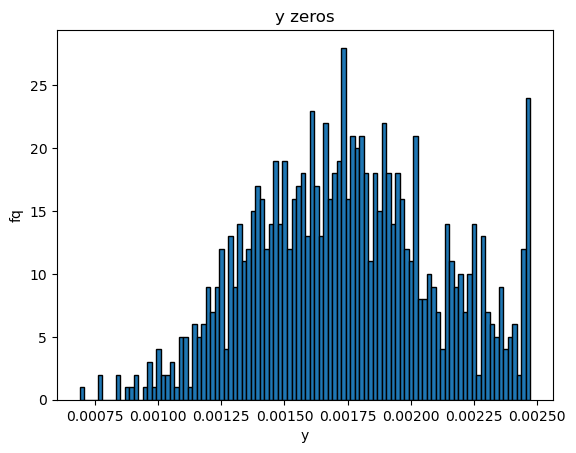

y_zero sum:  1.7440305249368648
u:  0.49926080697526426
b:  -8
b_xy*u_N:  1.6249120000000001
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5059836147988306


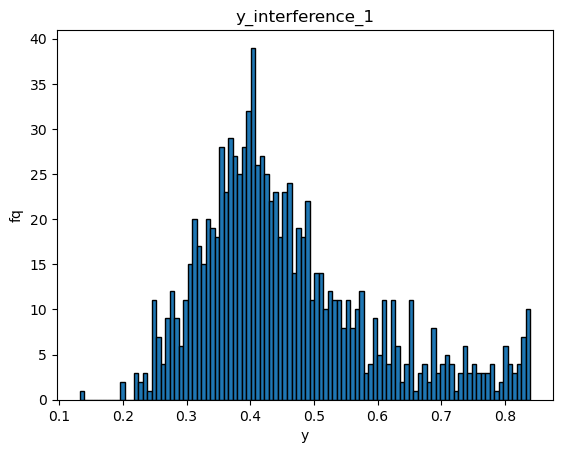

y_interference_1 sum:  3.9434087567309986
The score for greedy interference is 457.322.
u:  0.49926080697526426
b:  -8
b_xy*u_N:  1.627374
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5059836147988306


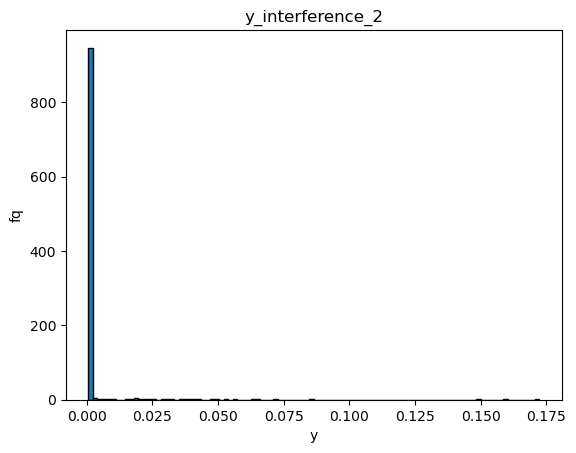

y_interference_2 sum:  3.4783088431440374
The score for greedy contagion is 503.765.
The score for zero is 344.235.
starting iteration:  4


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.03494827025040878
Pearson with predicted edge probs:  tensor(0.9799)
Spearman with predicted edge probs:  0.9693635877680984
Auc with predicted edge probs:  0.9991157894736842
Rmse of predicted edge probs:  0.18699884992898616
Pearson of predicted edge probs:  tensor(0.0183)
Spearman of predicted edge probs:  0.12716426921943025
Start gnn training.
u:  0.5165488324964636
b:  -8
b_xy*u_N:  1.617314
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.456045837180971
u:  0.5131469375652289
b:  -8
b_xy*u_N:  1.646478
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.452695836131157


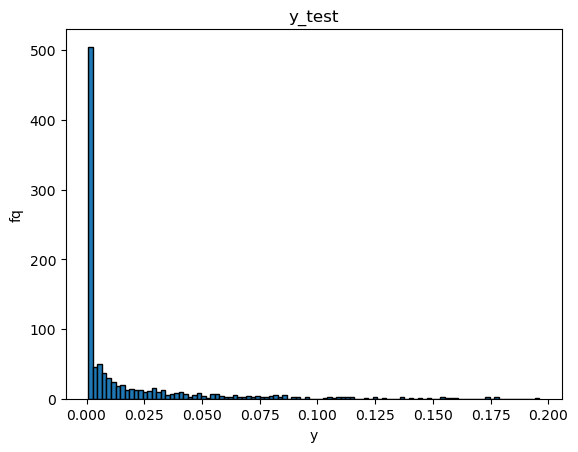

Epoch 0, Loss: 0.4474
Epoch 10, Loss: 0.4025
Epoch 20, Loss: 0.3928
Epoch 30, Loss: 0.3649
Epoch 40, Loss: 0.2957
Epoch 50, Loss: 0.2582
Epoch 60, Loss: 0.2204
Epoch 70, Loss: 0.1640
Epoch 80, Loss: 0.1722
Epoch 90, Loss: 0.1390
Epoch 100, Loss: 0.0870
Epoch 110, Loss: 0.1024
Epoch 120, Loss: 0.0873
Epoch 130, Loss: 0.0898
Epoch 140, Loss: 0.0803
Test GNN RMSE Loss: 0.0324
Test GNN pearson:  tensor(0.9594)
Test GNN spearman:  0.7797452081335767
Test GNN auc:  0.9887157894736842
Started with allocation.
CELF selected 1/50: Node 12 with gain 548.6625
CELF selected 2/50: Node 0 with gain 548.6501
CELF selected 3/50: Node 18 with gain 548.0456
CELF selected 4/50: Node 19 with gain 547.9951
CELF selected 5/50: Node 10 with gain 547.8055
CELF selected 6/50: Node 22 with gain 547.8002
CELF selected 7/50: Node 450 with gain 547.7545
CELF selected 8/50: Node 406 with gain 547.7182
CELF selected 9/50: Node 375 with gain 547.6678
CELF selected 10/50: Node 144 with gain 547.6421
CELF selected 11/5

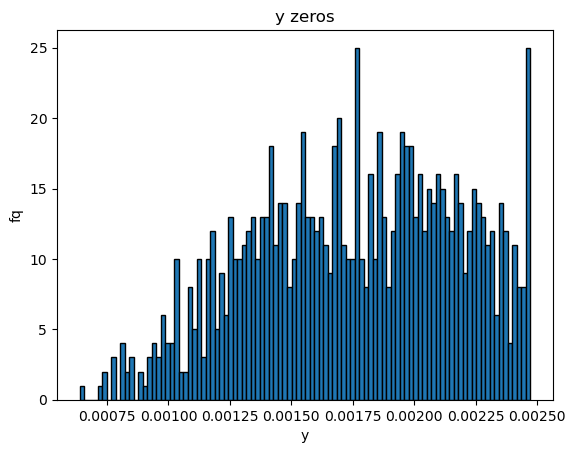

y_zero sum:  1.7581411461885608
u:  0.49993315825851004
b:  -8
b_xy*u_N:  1.627726
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4666969329297244


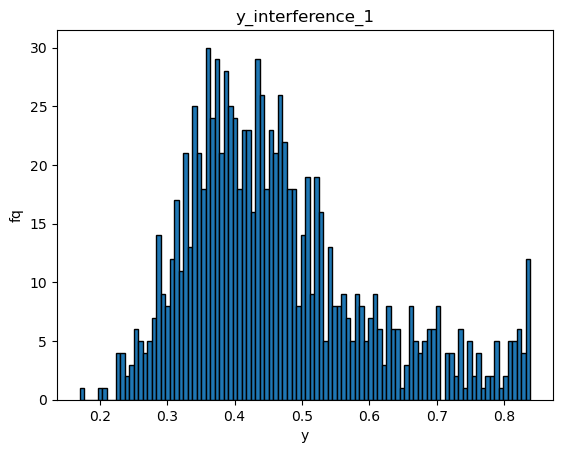

y_interference_1 sum:  2.8092207340455504
The score for greedy interference is 463.813.
u:  0.49993315825851004
b:  -8
b_xy*u_N:  1.6282020000000001
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4666969329297244


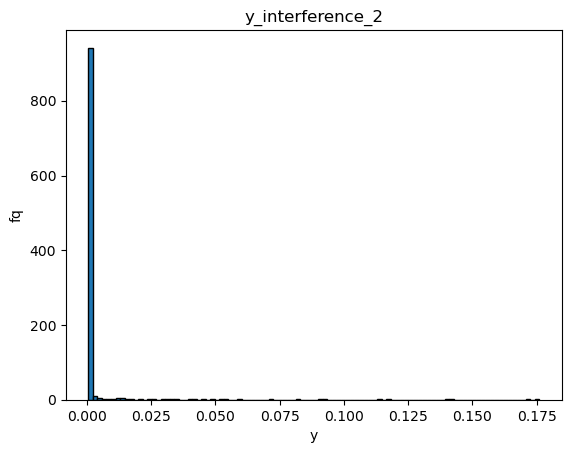

y_interference_2 sum:  3.785087634001458
The score for greedy contagion is 526.73.
The score for zero is 359.169.
starting iteration:  5


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.04276192261889537
Pearson with predicted edge probs:  tensor(0.9748)
Spearman with predicted edge probs:  0.9655490157538897
Auc with predicted edge probs:  0.9988210526315789
Rmse of predicted edge probs:  0.18539486731921168
Pearson of predicted edge probs:  tensor(0.0247)
Spearman of predicted edge probs:  0.10912078059628531
Start gnn training.
u:  0.4999493244361389
b:  -8
b_xy*u_N:  1.61616
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.556441022016418
u:  0.5151718948722485
b:  -8
b_xy*u_N:  1.672874
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.542089392441309


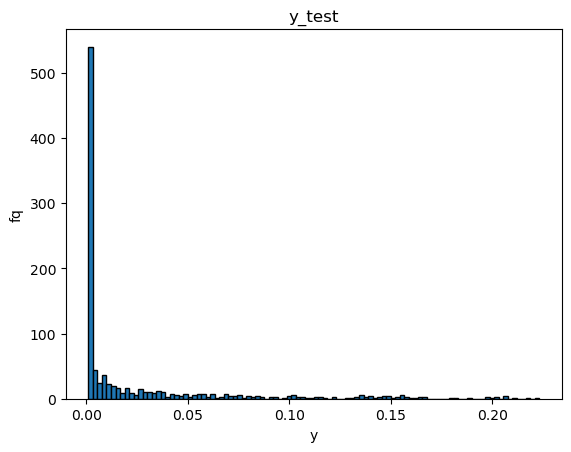

Epoch 0, Loss: 0.4283
Epoch 10, Loss: 0.3866
Epoch 20, Loss: 0.3681
Epoch 30, Loss: 0.3440
Epoch 40, Loss: 0.2769
Epoch 50, Loss: 0.1958
Epoch 60, Loss: 0.1530
Epoch 70, Loss: 0.1268
Epoch 80, Loss: 0.1031
Epoch 90, Loss: 0.1041
Epoch 100, Loss: 0.0958
Epoch 110, Loss: 0.0918
Epoch 120, Loss: 0.0698
Epoch 130, Loss: 0.0667
Epoch 140, Loss: 0.0846
Test GNN RMSE Loss: 0.0419
Test GNN pearson:  tensor(0.9605)
Test GNN spearman:  0.6459202196356717
Test GNN auc:  0.9928842105263158
Started with allocation.
CELF selected 1/50: Node 2 with gain 576.9406
CELF selected 2/50: Node 145 with gain 576.8074
CELF selected 3/50: Node 351 with gain 576.7830
CELF selected 4/50: Node 849 with gain 576.7759
CELF selected 5/50: Node 349 with gain 576.7681
CELF selected 6/50: Node 32 with gain 576.6919
CELF selected 7/50: Node 388 with gain 576.6852
CELF selected 8/50: Node 149 with gain 576.6829
CELF selected 9/50: Node 144 with gain 576.6815
CELF selected 10/50: Node 484 with gain 576.6812
CELF selected 

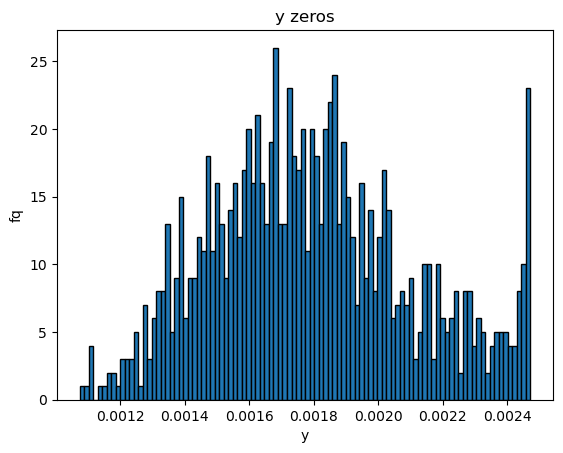

y_zero sum:  1.7927226032406067
u:  0.5078091293140201
b:  -8
b_xy*u_N:  1.6609880000000001
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.455240781980008


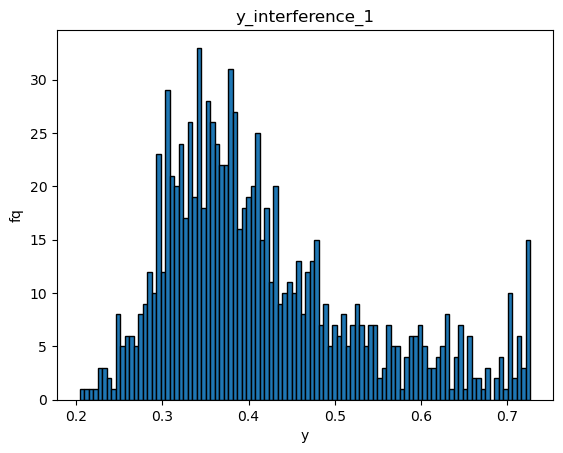

y_interference_1 sum:  2.1313838532386375
The score for greedy interference is 417.06.
u:  0.5078091293140201
b:  -8
b_xy*u_N:  1.6620500000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.455240781980008


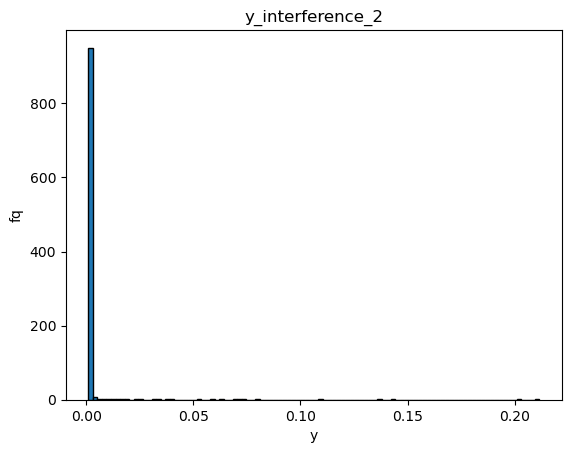

y_interference_2 sum:  3.7459045851695483
The score for greedy contagion is 550.003.
The score for zero is 378.37300000000005.
starting iteration:  6


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.03303003599934572
Pearson with predicted edge probs:  tensor(0.9798)
Spearman with predicted edge probs:  0.9630546848917855
Auc with predicted edge probs:  0.9997473684210526
Rmse of predicted edge probs:  0.12724870604426772
Pearson of predicted edge probs:  tensor(0.0192)
Spearman of predicted edge probs:  0.08096710392136339
Start gnn training.
u:  0.4931178913222224
b:  -8
b_xy*u_N:  1.610582
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4994927177107047
u:  0.49496706481465946
b:  -8
b_xy*u_N:  1.574432
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4448758779927267


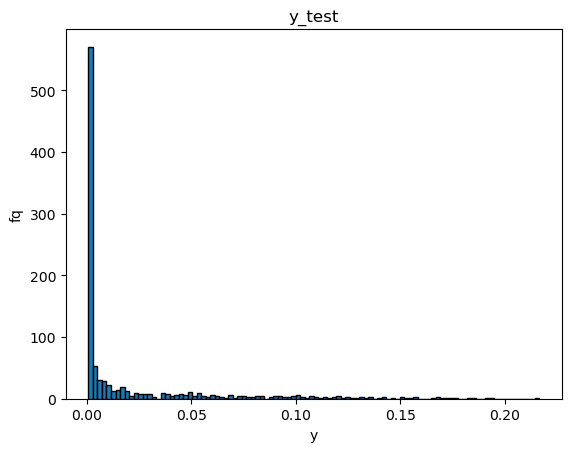

Epoch 0, Loss: 0.4805
Epoch 10, Loss: 0.4349
Epoch 20, Loss: 0.3977
Epoch 30, Loss: 0.3748
Epoch 40, Loss: 0.3298
Epoch 50, Loss: 0.2693
Epoch 60, Loss: 0.2172
Epoch 70, Loss: 0.1680
Epoch 80, Loss: 0.1431
Epoch 90, Loss: 0.1293
Epoch 100, Loss: 0.1151
Epoch 110, Loss: 0.0949
Epoch 120, Loss: 0.1157
Epoch 130, Loss: 0.0923
Epoch 140, Loss: 0.0869
Test GNN RMSE Loss: 0.0629
Test GNN pearson:  tensor(0.9466)
Test GNN spearman:  0.5833243515595345
Test GNN auc:  0.9912000000000001
Started with allocation.
CELF selected 1/50: Node 11 with gain 440.1456
CELF selected 2/50: Node 941 with gain 437.4693
CELF selected 3/50: Node 740 with gain 437.4441
CELF selected 4/50: Node 160 with gain 437.4433
CELF selected 5/50: Node 652 with gain 437.4427
CELF selected 6/50: Node 224 with gain 437.4418
CELF selected 7/50: Node 696 with gain 437.4416
CELF selected 8/50: Node 265 with gain 437.4368
CELF selected 9/50: Node 624 with gain 437.4367
CELF selected 10/50: Node 410 with gain 437.4353
CELF selecte

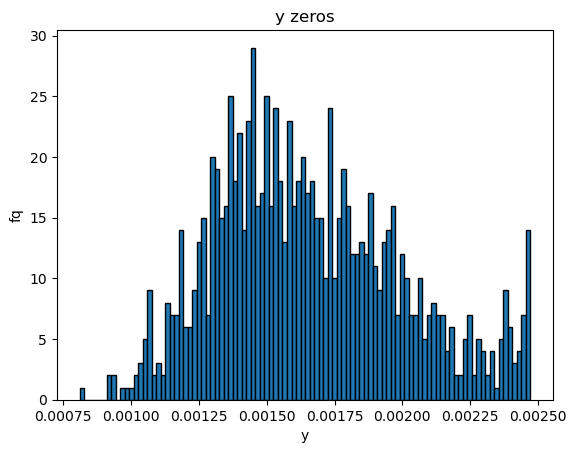

y_zero sum:  1.6560006093673905
u:  0.49578065392787296
b:  -8
b_xy*u_N:  1.5759759999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5134940788995443


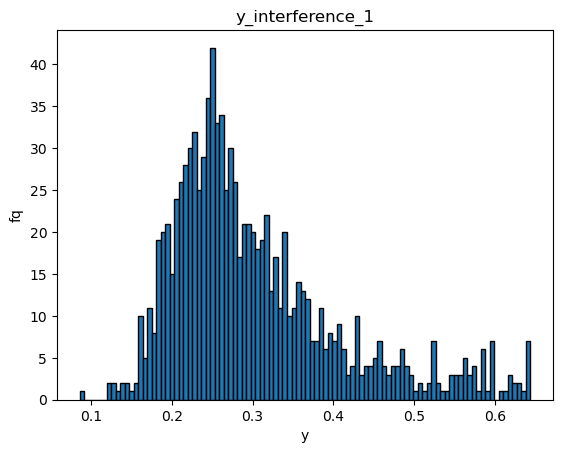

y_interference_1 sum:  2.0637980930758846
The score for greedy interference is 302.426.
u:  0.49578065392787296
b:  -8
b_xy*u_N:  1.576264
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5134940788995443


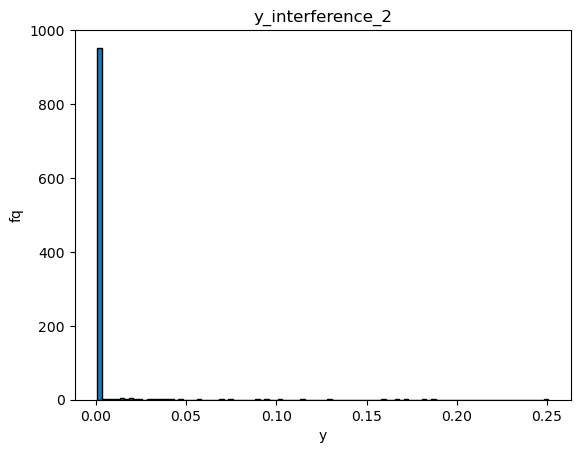

y_interference_2 sum:  4.247431561026833
The score for greedy contagion is 450.9549999999999.
The score for zero is 261.45000000000005.
starting iteration:  7


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.04771928604939072
Pearson with predicted edge probs:  tensor(0.9803)
Spearman with predicted edge probs:  0.9747288908409796
Auc with predicted edge probs:  0.9977065641852104
Rmse of predicted edge probs:  0.1679610982527102
Pearson of predicted edge probs:  tensor(0.0223)
Spearman of predicted edge probs:  0.10812308399323843
Start gnn training.
u:  0.5062721452561398
b:  -8
b_xy*u_N:  1.599356
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5080029974017957
u:  0.5069656229038554
b:  -8
b_xy*u_N:  1.613238
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4865549912419054


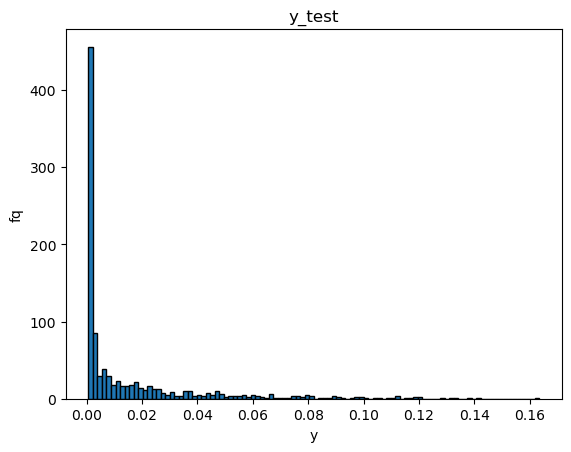

Epoch 0, Loss: 0.4165
Epoch 10, Loss: 0.3614
Epoch 20, Loss: 0.3411
Epoch 30, Loss: 0.2945
Epoch 40, Loss: 0.2442
Epoch 50, Loss: 0.1911
Epoch 60, Loss: 0.1336
Epoch 70, Loss: 0.1073
Epoch 80, Loss: 0.1098
Epoch 90, Loss: 0.0968
Epoch 100, Loss: 0.0909
Epoch 110, Loss: 0.0722
Epoch 120, Loss: 0.0938
Epoch 130, Loss: 0.0762
Epoch 140, Loss: 0.0672
Test GNN RMSE Loss: 0.0683
Test GNN pearson:  tensor(0.9450)
Test GNN spearman:  0.7977303548183463
Test GNN auc:  0.9907578947368422
Started with allocation.
CELF selected 1/50: Node 5 with gain 506.4674
CELF selected 2/50: Node 181 with gain 506.0762
CELF selected 3/50: Node 17 with gain 505.9260
CELF selected 4/50: Node 15 with gain 505.9090
CELF selected 5/50: Node 12 with gain 505.9038
CELF selected 6/50: Node 14 with gain 505.5171
CELF selected 7/50: Node 11 with gain 505.2994
CELF selected 8/50: Node 312 with gain 505.2638
CELF selected 9/50: Node 34 with gain 505.2013
CELF selected 10/50: Node 18 with gain 505.1996
CELF selected 11/50:

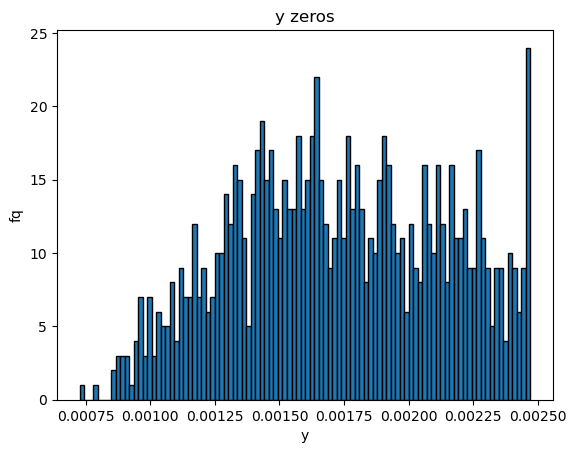

y_zero sum:  1.7292382312880918
u:  0.5022443983880187
b:  -8
b_xy*u_N:  1.611044
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.511320737069965


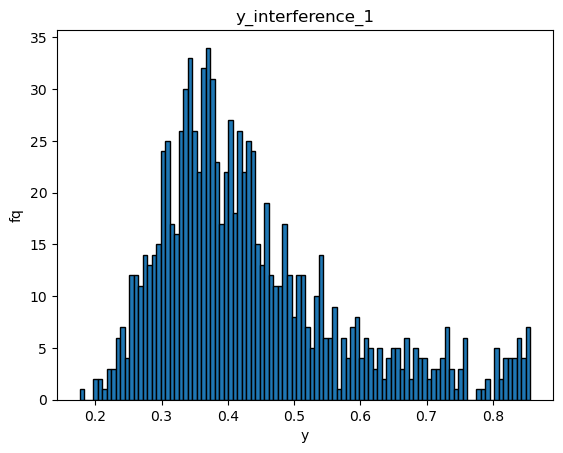

y_interference_1 sum:  3.0110933383296032
The score for greedy interference is 435.182.
u:  0.5022443983880187
b:  -8
b_xy*u_N:  1.6124560000000001
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.511320737069965


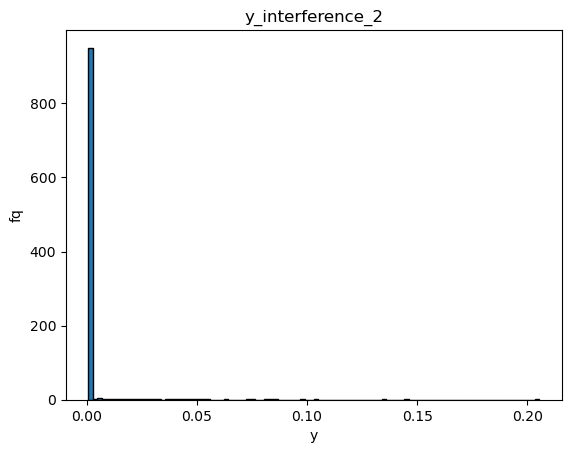

y_interference_2 sum:  3.844297926918886
The score for greedy contagion is 487.89700000000005.
The score for zero is 322.112.
starting iteration:  8


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.04370849430817419
Pearson with predicted edge probs:  tensor(0.9753)
Spearman with predicted edge probs:  0.9638344988389599
Auc with predicted edge probs:  0.9976631578947368
Rmse of predicted edge probs:  0.1577868813786426
Pearson of predicted edge probs:  tensor(0.0360)
Spearman of predicted edge probs:  0.12275257651484238
Start gnn training.
u:  0.5060827014324156
b:  -8
b_xy*u_N:  1.715838
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5735999495740502
u:  0.4903730095530353
b:  -8
b_xy*u_N:  1.562934
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.3922382350180067


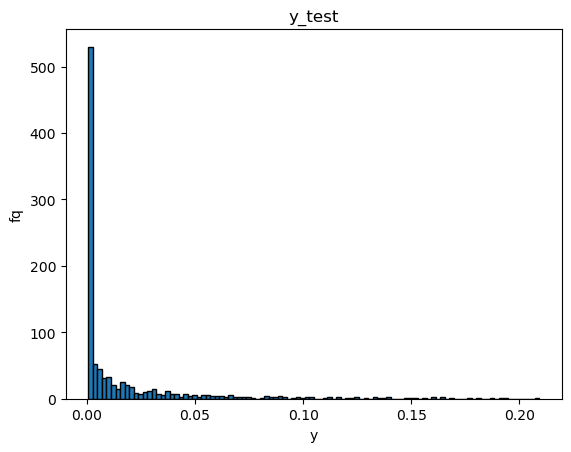

Epoch 0, Loss: 0.4281
Epoch 10, Loss: 0.3843
Epoch 20, Loss: 0.3796
Epoch 30, Loss: 0.3759
Epoch 40, Loss: 0.3696
Epoch 50, Loss: 0.3357
Epoch 60, Loss: 0.2827
Epoch 70, Loss: 0.2122
Epoch 80, Loss: 0.1664
Epoch 90, Loss: 0.1388
Epoch 100, Loss: 0.1245
Epoch 110, Loss: 0.1249
Epoch 120, Loss: 0.0942
Epoch 130, Loss: 0.1052
Epoch 140, Loss: 0.1096
Test GNN RMSE Loss: 0.0374
Test GNN pearson:  tensor(0.9429)
Test GNN spearman:  0.6489738476705811
Test GNN auc:  0.9944631578947368
Started with allocation.
CELF selected 1/50: Node 21 with gain 493.7687
CELF selected 2/50: Node 184 with gain 493.6705
CELF selected 3/50: Node 449 with gain 493.5357
CELF selected 4/50: Node 13 with gain 493.5084
CELF selected 5/50: Node 19 with gain 493.4850
CELF selected 6/50: Node 236 with gain 493.4611
CELF selected 7/50: Node 12 with gain 493.4290
CELF selected 8/50: Node 18 with gain 493.4028
CELF selected 9/50: Node 600 with gain 493.3807
CELF selected 10/50: Node 187 with gain 493.3419
CELF selected 11

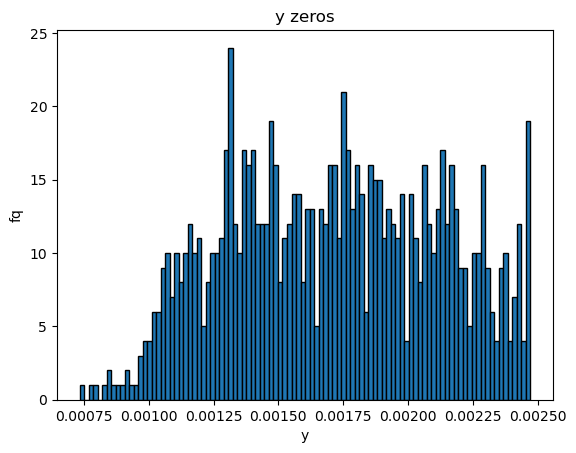

y_zero sum:  1.7141942864236421
u:  0.5074376078503875
b:  -8
b_xy*u_N:  1.60323
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.494155204993645


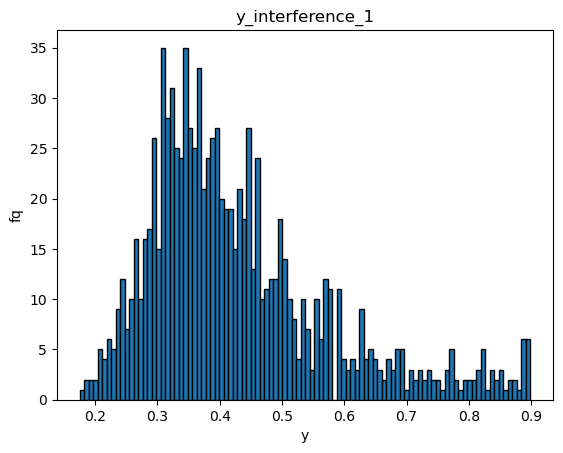

y_interference_1 sum:  4.06927000291503
The score for greedy interference is 429.273.
u:  0.5074376078503875
b:  -8
b_xy*u_N:  1.60333
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.494155204993645


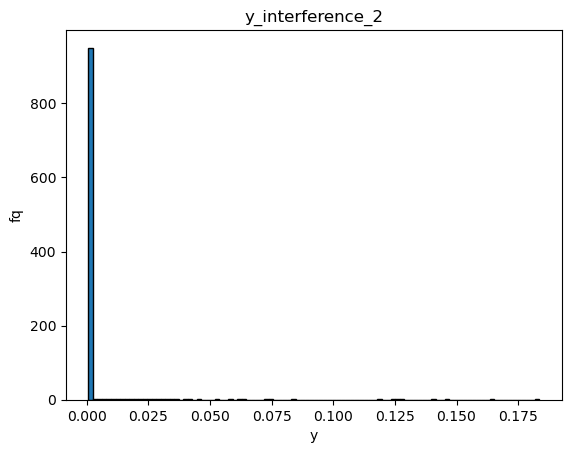

y_interference_2 sum:  4.012833448741013
The score for greedy contagion is 454.791.
The score for zero is 272.97400000000005.
starting iteration:  9


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.03769901781203507
Pearson with predicted edge probs:  tensor(0.9847)
Spearman with predicted edge probs:  0.9809446889457663
Auc with predicted edge probs:  0.9994526315789474
Rmse of predicted edge probs:  0.1642328297761293
Pearson of predicted edge probs:  tensor(0.0568)
Spearman of predicted edge probs:  0.21423562028946377
Start gnn training.
u:  0.5036470671888575
b:  -8
b_xy*u_N:  1.646836
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.504313567095686
u:  0.49235663242644934
b:  -8
b_xy*u_N:  1.644366
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4799511149514992


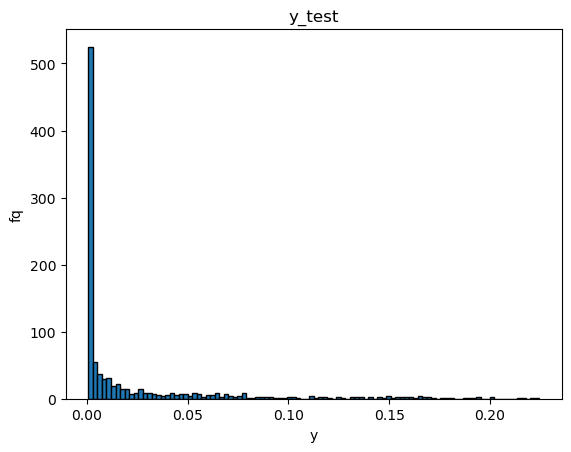

Epoch 0, Loss: 0.4348
Epoch 10, Loss: 0.4003
Epoch 20, Loss: 0.3867
Epoch 30, Loss: 0.3582
Epoch 40, Loss: 0.2966
Epoch 50, Loss: 0.2291
Epoch 60, Loss: 0.1593
Epoch 70, Loss: 0.1247
Epoch 80, Loss: 0.1120
Epoch 90, Loss: 0.0890
Epoch 100, Loss: 0.0758
Epoch 110, Loss: 0.0986
Epoch 120, Loss: 0.0770
Epoch 130, Loss: 0.0750
Epoch 140, Loss: 0.0596
Test GNN RMSE Loss: 0.0638
Test GNN pearson:  tensor(0.9563)
Test GNN spearman:  0.844441792172283
Test GNN auc:  0.9914947368421053
Started with allocation.
CELF selected 1/50: Node 12 with gain 557.1804
CELF selected 2/50: Node 11 with gain 556.9287
CELF selected 3/50: Node 15 with gain 556.9245
CELF selected 4/50: Node 250 with gain 556.4571
CELF selected 5/50: Node 410 with gain 556.4248
CELF selected 6/50: Node 915 with gain 556.4206
CELF selected 7/50: Node 449 with gain 556.4172
CELF selected 8/50: Node 987 with gain 556.4105
CELF selected 9/50: Node 781 with gain 556.4103
CELF selected 10/50: Node 877 with gain 556.4059
CELF selected 1

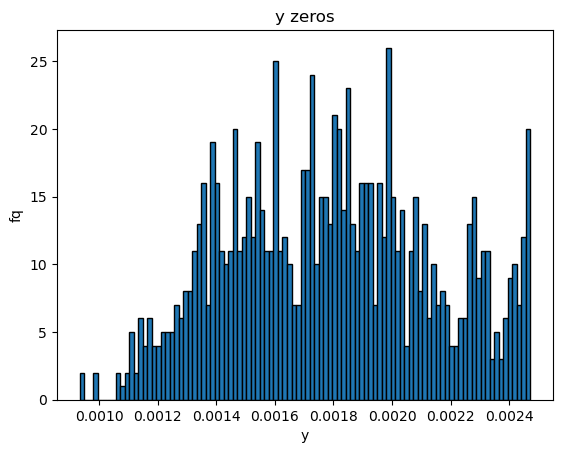

y_zero sum:  1.7896015228995674
u:  0.5010062475214554
b:  -8
b_xy*u_N:  1.657638
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5256031688368195


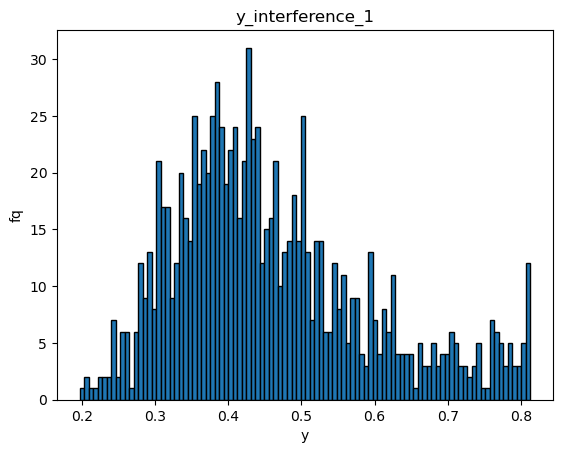

y_interference_1 sum:  2.9887872723998576
The score for greedy interference is 458.667.
u:  0.5010062475214554
b:  -8
b_xy*u_N:  1.656962
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5256031688368195


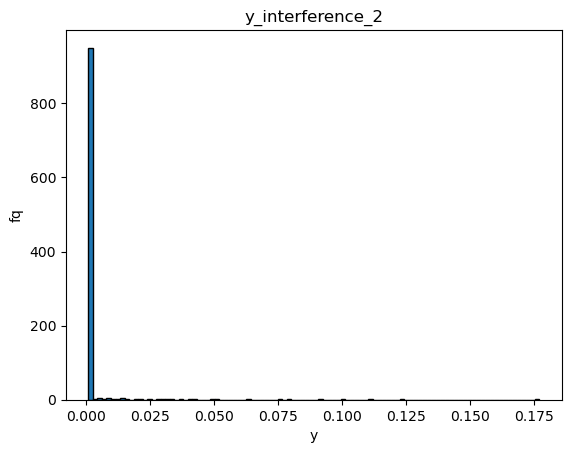

y_interference_2 sum:  3.4906668780391468
The score for greedy contagion is 522.5350000000001.
The score for zero is 384.43499999999995.
starting iteration:  10


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.03343226799630031
Pearson with predicted edge probs:  tensor(0.9805)
Spearman with predicted edge probs:  0.9751631341784667
Auc with predicted edge probs:  0.9988210526315789
Rmse of predicted edge probs:  0.09989285335415217
Pearson of predicted edge probs:  tensor(0.0443)
Spearman of predicted edge probs:  0.16004543304563465
Start gnn training.
u:  0.4995227228814065
b:  -8
b_xy*u_N:  1.6242199999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5092849815929377
u:  0.5067240119808626
b:  -8
b_xy*u_N:  1.582758
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4360166072556324


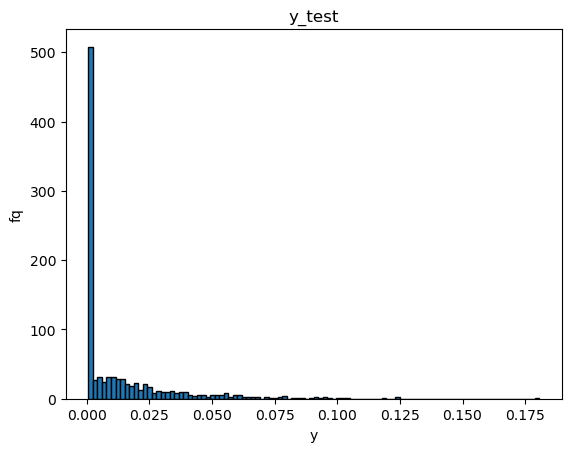

Epoch 0, Loss: 0.3943
Epoch 10, Loss: 0.3490
Epoch 20, Loss: 0.3192
Epoch 30, Loss: 0.2971
Epoch 40, Loss: 0.2583
Epoch 50, Loss: 0.1874
Epoch 60, Loss: 0.1486
Epoch 70, Loss: 0.1259
Epoch 80, Loss: 0.1124
Epoch 90, Loss: 0.0917
Epoch 100, Loss: 0.1062
Epoch 110, Loss: 0.0938
Epoch 120, Loss: 0.0849
Epoch 130, Loss: 0.0925
Epoch 140, Loss: 0.0830
Test GNN RMSE Loss: 0.0482
Test GNN pearson:  tensor(0.9204)
Test GNN spearman:  0.6470333711129802
Test GNN auc:  0.9883578947368421
Started with allocation.
CELF selected 1/50: Node 11 with gain 403.0229
CELF selected 2/50: Node 361 with gain 401.2524
CELF selected 3/50: Node 348 with gain 401.2078
CELF selected 4/50: Node 586 with gain 401.1982
CELF selected 5/50: Node 994 with gain 401.1777
CELF selected 6/50: Node 958 with gain 401.1666
CELF selected 7/50: Node 488 with gain 401.1662
CELF selected 8/50: Node 857 with gain 401.1604
CELF selected 9/50: Node 820 with gain 401.1567
CELF selected 10/50: Node 490 with gain 401.1563
CELF selecte

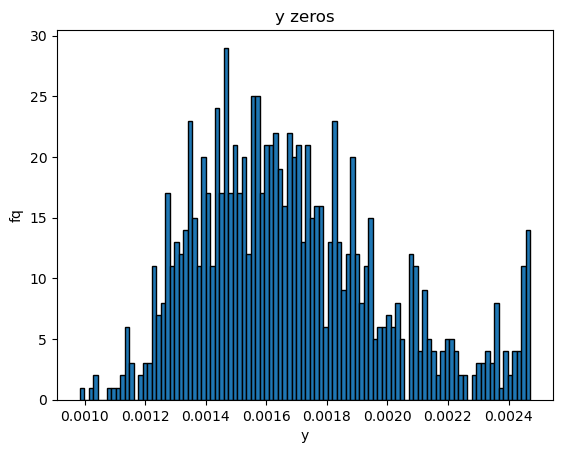

y_zero sum:  1.6813434703144208
u:  0.5083042241320075
b:  -8
b_xy*u_N:  1.599138
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4575705890764104


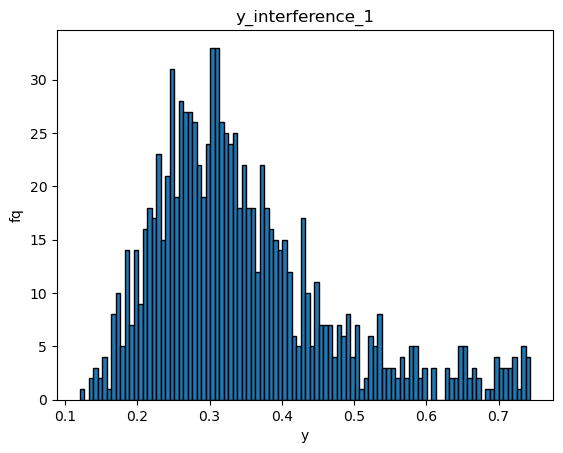

y_interference_1 sum:  2.914789931654535
The score for greedy interference is 346.08500000000004.
u:  0.5083042241320075
b:  -8
b_xy*u_N:  1.5988980000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4575705890764104


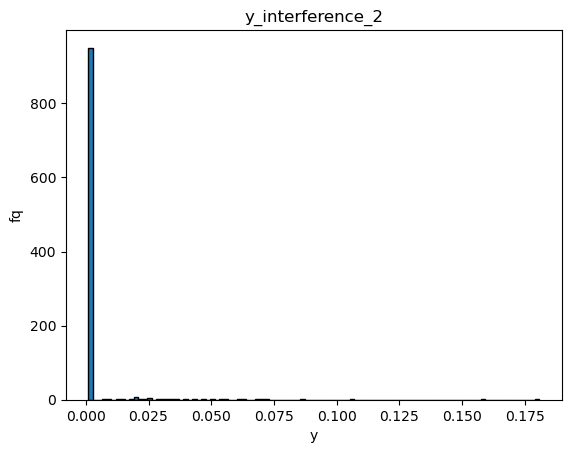

y_interference_2 sum:  3.6540190736828855
The score for greedy contagion is 434.469.
The score for zero is 263.446.
starting iteration:  11


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.0737728035251306
Pearson with predicted edge probs:  tensor(0.9818)
Spearman with predicted edge probs:  0.9780357822205993
Auc with predicted edge probs:  0.9947368421052631
Rmse of predicted edge probs:  0.17773213227921605
Pearson of predicted edge probs:  tensor(0.0408)
Spearman of predicted edge probs:  0.17889296051183967
Start gnn training.
u:  0.5040378649753504
b:  -8
b_xy*u_N:  1.5941599999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.474669467048468
u:  0.5048029316890329
b:  -8
b_xy*u_N:  1.66045
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.542439543232177


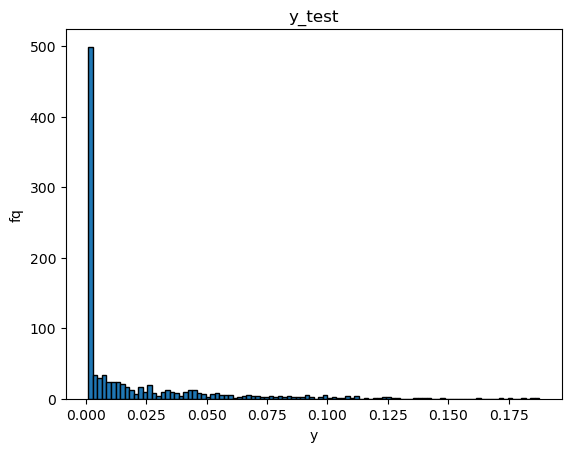

Epoch 0, Loss: 0.4320
Epoch 10, Loss: 0.3722
Epoch 20, Loss: 0.3513
Epoch 30, Loss: 0.3442
Epoch 40, Loss: 0.3070
Epoch 50, Loss: 0.2625
Epoch 60, Loss: 0.2160
Epoch 70, Loss: 0.1720
Epoch 80, Loss: 0.1581
Epoch 90, Loss: 0.1162
Epoch 100, Loss: 0.0943
Epoch 110, Loss: 0.0952
Epoch 120, Loss: 0.0830
Epoch 130, Loss: 0.0722
Epoch 140, Loss: 0.0673
Test GNN RMSE Loss: 0.0511
Test GNN pearson:  tensor(0.9590)
Test GNN spearman:  0.754486207497176
Test GNN auc:  0.9938315789473684
Started with allocation.
CELF selected 1/50: Node 12 with gain 564.3173
CELF selected 2/50: Node 13 with gain 563.6771
CELF selected 3/50: Node 11 with gain 563.4723
CELF selected 4/50: Node 231 with gain 563.0359
CELF selected 5/50: Node 748 with gain 563.0274
CELF selected 6/50: Node 709 with gain 563.0064
CELF selected 7/50: Node 192 with gain 562.9806
CELF selected 8/50: Node 159 with gain 562.9734
CELF selected 9/50: Node 359 with gain 562.9631
CELF selected 10/50: Node 157 with gain 562.9621
CELF selected 1

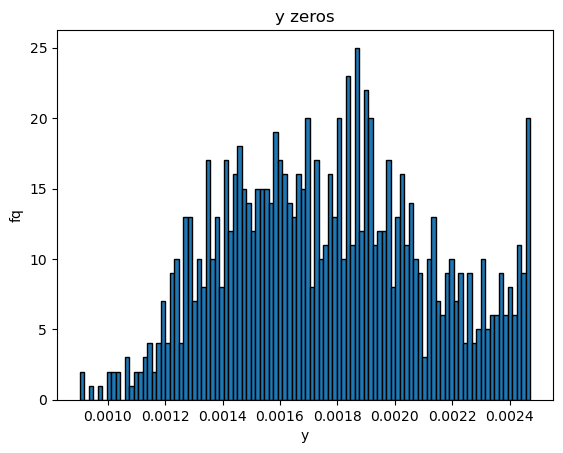

y_zero sum:  1.7684724510065863
u:  0.5003243661116299
b:  -8
b_xy*u_N:  1.6450239999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.477210838715183


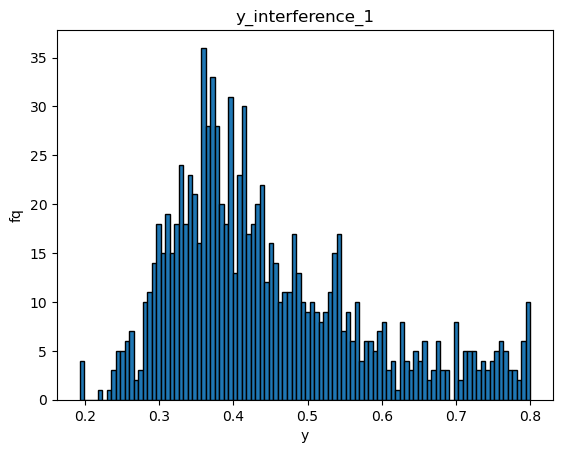

y_interference_1 sum:  2.4882535721891363
The score for greedy interference is 447.231.
u:  0.5003243661116299
b:  -8
b_xy*u_N:  1.644522
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.477210838715183


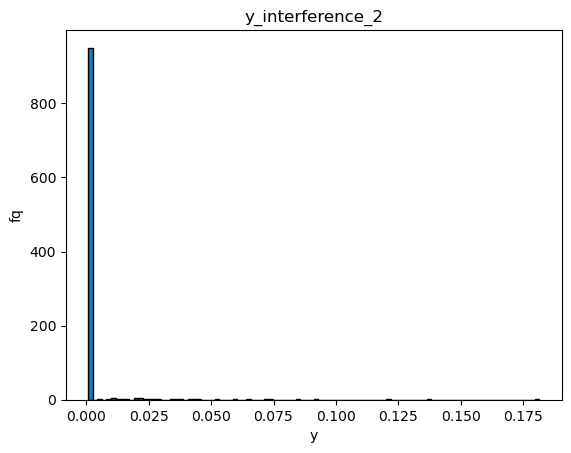

y_interference_2 sum:  3.611612727128661
The score for greedy contagion is 532.172.
The score for zero is 350.811.
starting iteration:  12


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.03231481908139667
Pearson with predicted edge probs:  tensor(0.9853)
Spearman with predicted edge probs:  0.975369785052001
Auc with predicted edge probs:  0.9982105263157894
Rmse of predicted edge probs:  0.13752178323031727
Pearson of predicted edge probs:  tensor(0.0361)
Spearman of predicted edge probs:  0.16043452458078292
Start gnn training.
u:  0.5029752513468221
b:  -8
b_xy*u_N:  1.6515819999999999
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.621874517567192
u:  0.5086938963686057
b:  -8
b_xy*u_N:  1.607108
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.477360249108092


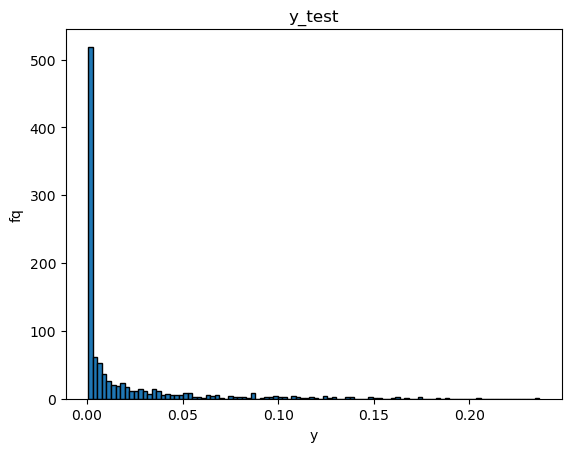

Epoch 0, Loss: 0.4449
Epoch 10, Loss: 0.4050
Epoch 20, Loss: 0.3813
Epoch 30, Loss: 0.3669
Epoch 40, Loss: 0.3080
Epoch 50, Loss: 0.2053
Epoch 60, Loss: 0.1524
Epoch 70, Loss: 0.1010
Epoch 80, Loss: 0.0959
Epoch 90, Loss: 0.0697
Epoch 100, Loss: 0.0836
Epoch 110, Loss: 0.0784
Epoch 120, Loss: 0.0754
Epoch 130, Loss: 0.0735
Epoch 140, Loss: 0.0885
Test GNN RMSE Loss: 0.0491
Test GNN pearson:  tensor(0.9550)
Test GNN spearman:  0.8455974682545004
Test GNN auc:  0.9965684210526315
Started with allocation.
CELF selected 1/50: Node 12 with gain 471.9196
CELF selected 2/50: Node 13 with gain 471.7915
CELF selected 3/50: Node 11 with gain 471.4427
CELF selected 4/50: Node 848 with gain 471.1085
CELF selected 5/50: Node 921 with gain 471.0961
CELF selected 6/50: Node 534 with gain 471.0869
CELF selected 7/50: Node 391 with gain 471.0696
CELF selected 8/50: Node 409 with gain 471.0650
CELF selected 9/50: Node 662 with gain 471.0579
CELF selected 10/50: Node 122 with gain 471.0562
CELF selected 

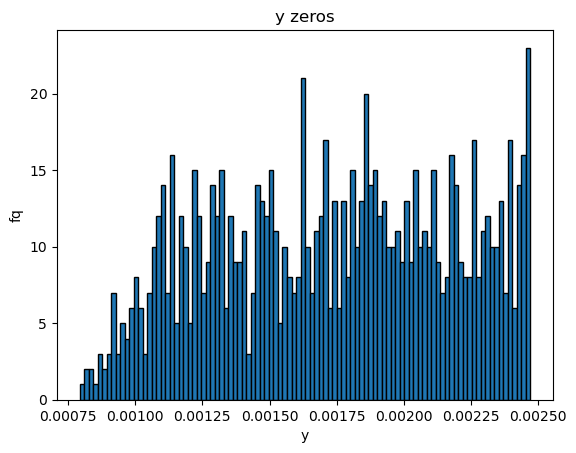

y_zero sum:  1.7368917781038378
u:  0.5077027170776831
b:  -8
b_xy*u_N:  1.609606
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.574140667837154


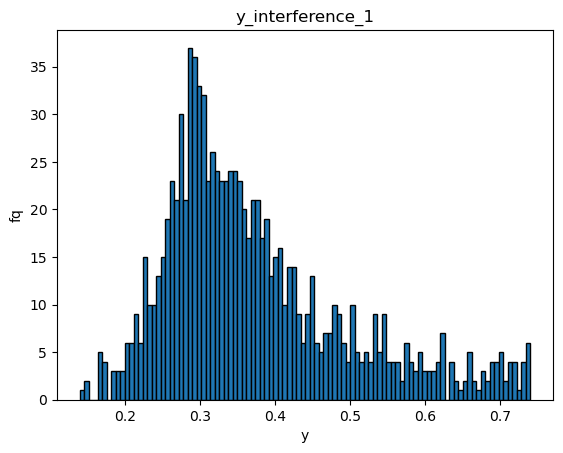

y_interference_1 sum:  2.534743265701498
The score for greedy interference is 373.353.
u:  0.5077027170776831
b:  -8
b_xy*u_N:  1.609212
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.574140667837154


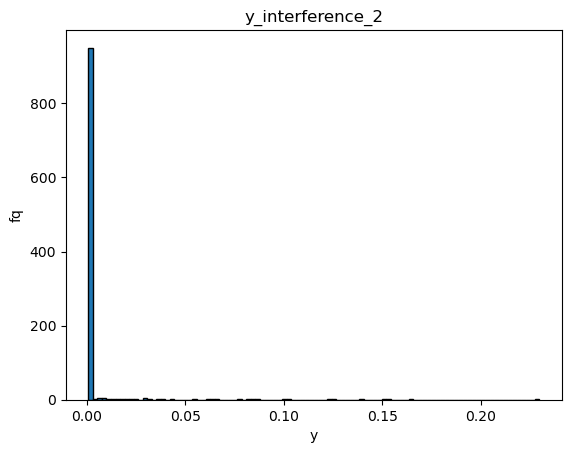

y_interference_2 sum:  4.365792603216849
The score for greedy contagion is 485.277.
The score for zero is 301.505.
starting iteration:  13


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.042288161318557005
Pearson with predicted edge probs:  tensor(0.9783)
Spearman with predicted edge probs:  0.9727168145607805
Auc with predicted edge probs:  0.9951157894736842
Rmse of predicted edge probs:  0.19643958094942296
Pearson of predicted edge probs:  tensor(0.0097)
Spearman of predicted edge probs:  0.09869747674041335
Start gnn training.
u:  0.505552548513432
b:  -8
b_xy*u_N:  1.5882199999999997
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.595254354398733
u:  0.49853861687646167
b:  -8
b_xy*u_N:  1.677768
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.534930504463428


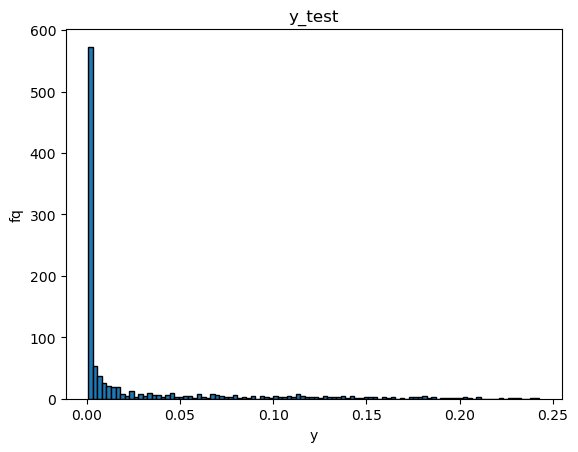

Epoch 0, Loss: 0.4529
Epoch 10, Loss: 0.4137
Epoch 20, Loss: 0.3990
Epoch 30, Loss: 0.3917
Epoch 40, Loss: 0.3720
Epoch 50, Loss: 0.3353
Epoch 60, Loss: 0.2780
Epoch 70, Loss: 0.2107
Epoch 80, Loss: 0.1356
Epoch 90, Loss: 0.1143
Epoch 100, Loss: 0.0944
Epoch 110, Loss: 0.1005
Epoch 120, Loss: 0.0799
Epoch 130, Loss: 0.0898
Epoch 140, Loss: 0.0929
Test GNN RMSE Loss: 0.0144
Test GNN pearson:  tensor(0.9633)
Test GNN spearman:  0.7118208214343783
Test GNN auc:  0.9915578947368421
Started with allocation.
CELF selected 1/50: Node 845 with gain 612.3691
CELF selected 2/50: Node 16 with gain 612.3515
CELF selected 3/50: Node 396 with gain 612.3433
CELF selected 4/50: Node 804 with gain 612.3306
CELF selected 5/50: Node 634 with gain 612.3290
CELF selected 6/50: Node 242 with gain 612.3170
CELF selected 7/50: Node 187 with gain 612.3116
CELF selected 8/50: Node 838 with gain 612.3087
CELF selected 9/50: Node 656 with gain 612.3086
CELF selected 10/50: Node 255 with gain 612.3044
CELF selecte

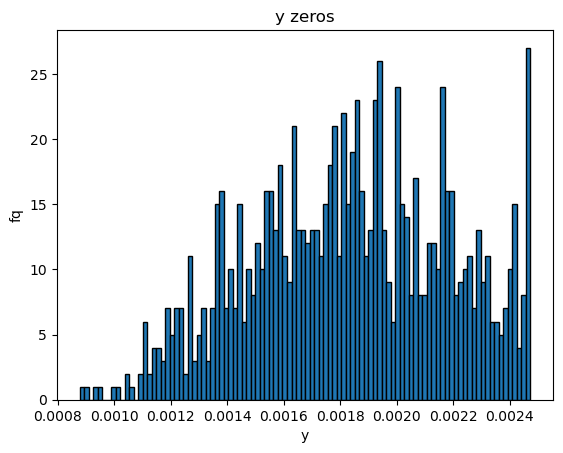

y_zero sum:  1.83355207608193
u:  0.5087585525569259
b:  -8
b_xy*u_N:  1.6822199999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5693109454146317


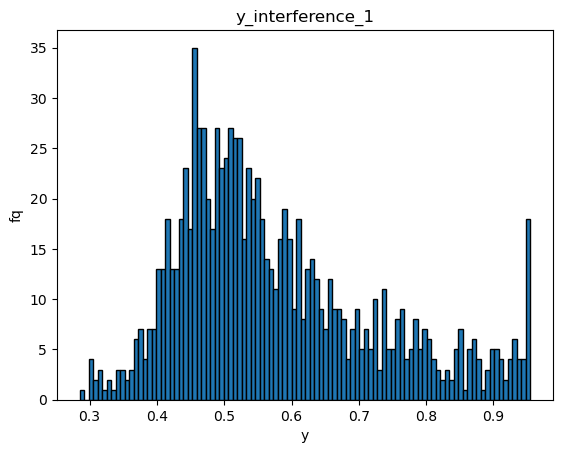

y_interference_1 sum:  4.841734722379195
The score for greedy interference is 577.249.
u:  0.5087585525569259
b:  -8
b_xy*u_N:  1.6802240000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5693109454146317


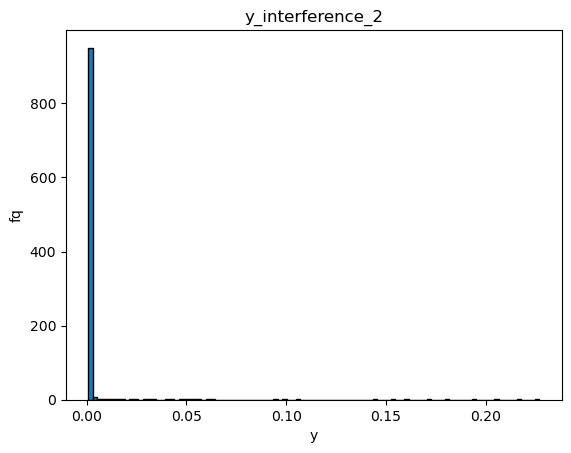

y_interference_2 sum:  4.753642224596273
The score for greedy contagion is 595.5.
The score for zero is 411.174.
starting iteration:  14


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.04629291033545982
Pearson with predicted edge probs:  tensor(0.9809)
Spearman with predicted edge probs:  0.9661973678339123
Auc with predicted edge probs:  0.9984842105263158
Rmse of predicted edge probs:  0.16339527419801714
Pearson of predicted edge probs:  tensor(0.0282)
Spearman of predicted edge probs:  0.1409214566545795
Start gnn training.
u:  0.49291040487311305
b:  -8
b_xy*u_N:  1.6055079999999997
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.527479423441952
u:  0.4972239157944331
b:  -8
b_xy*u_N:  1.6193719999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.508455076962182


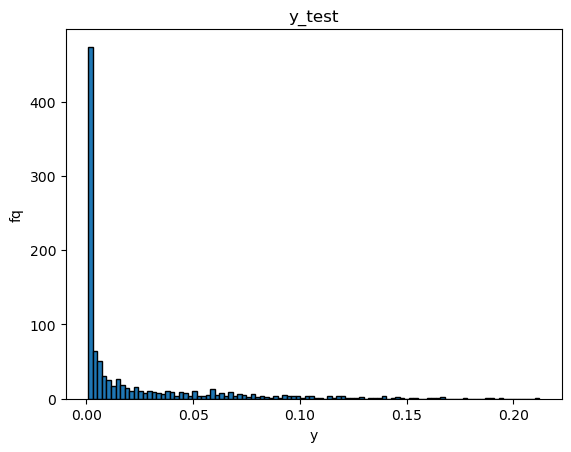

Epoch 0, Loss: 0.4379
Epoch 10, Loss: 0.3971
Epoch 20, Loss: 0.3745
Epoch 30, Loss: 0.3607
Epoch 40, Loss: 0.3308
Epoch 50, Loss: 0.2848
Epoch 60, Loss: 0.2405
Epoch 70, Loss: 0.2009
Epoch 80, Loss: 0.1563
Epoch 90, Loss: 0.1446
Epoch 100, Loss: 0.1222
Epoch 110, Loss: 0.1067
Epoch 120, Loss: 0.1177
Epoch 130, Loss: 0.0955
Epoch 140, Loss: 0.0782
Test GNN RMSE Loss: 0.0714
Test GNN pearson:  tensor(0.9210)
Test GNN spearman:  0.8372352166639631
Test GNN auc:  0.9692421052631579
Started with allocation.
CELF selected 1/50: Node 14 with gain 515.8014
CELF selected 2/50: Node 452 with gain 515.5300
CELF selected 3/50: Node 228 with gain 515.5277
CELF selected 4/50: Node 778 with gain 515.5210
CELF selected 5/50: Node 734 with gain 515.5124
CELF selected 6/50: Node 504 with gain 515.5074
CELF selected 7/50: Node 273 with gain 515.5073
CELF selected 8/50: Node 383 with gain 515.5045
CELF selected 9/50: Node 779 with gain 515.5031
CELF selected 10/50: Node 740 with gain 515.4941
CELF selecte

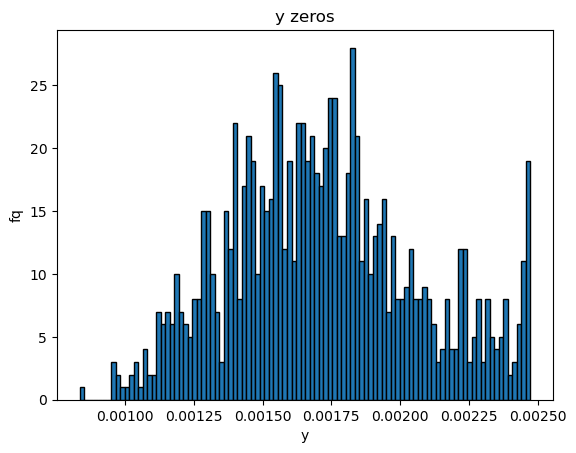

y_zero sum:  1.7186620878335301
u:  0.4960330955899357
b:  -8
b_xy*u_N:  1.614988
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5219354817088324


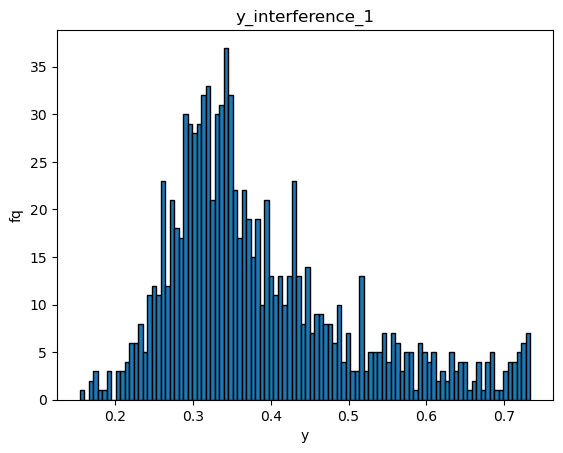

y_interference_1 sum:  2.474035779684197
The score for greedy interference is 386.75300000000004.
u:  0.4960330955899357
b:  -8
b_xy*u_N:  1.6148
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5219354817088324


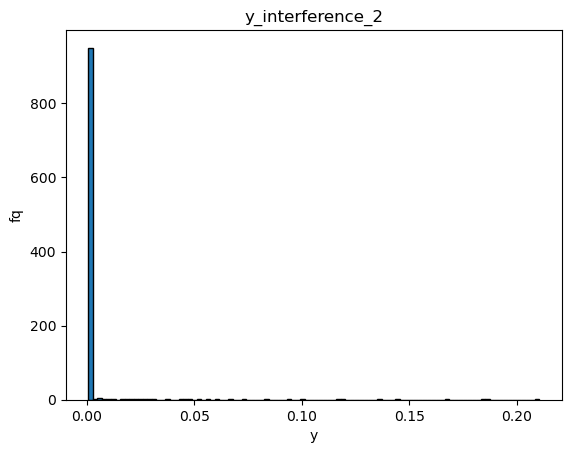

y_interference_2 sum:  4.165637451209336
The score for greedy contagion is 506.371.
The score for zero is 327.961.
starting iteration:  15


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.033396898758448694
Pearson with predicted edge probs:  tensor(0.9834)
Spearman with predicted edge probs:  0.9722917003540056
Auc with predicted edge probs:  0.9998105263157895
Rmse of predicted edge probs:  0.12950402431559171
Pearson of predicted edge probs:  tensor(0.0283)
Spearman of predicted edge probs:  0.1331036691302484
Start gnn training.
u:  0.5094149889511825
b:  -8
b_xy*u_N:  1.648246
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4817176076393332
u:  0.506171791050062
b:  -8
b_xy*u_N:  1.646026
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4852647701095756


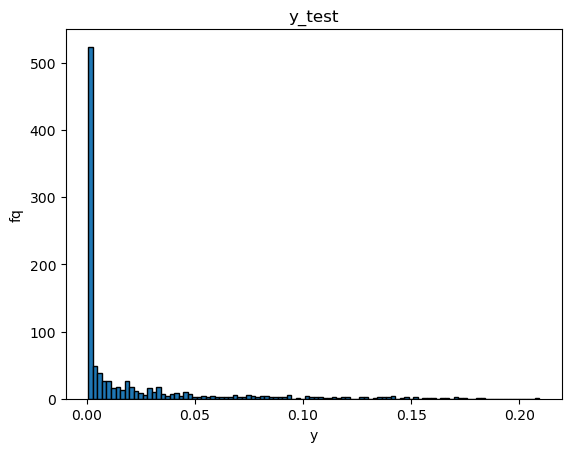

Epoch 0, Loss: 0.4588
Epoch 10, Loss: 0.4053
Epoch 20, Loss: 0.3807
Epoch 30, Loss: 0.3519
Epoch 40, Loss: 0.2790
Epoch 50, Loss: 0.2035
Epoch 60, Loss: 0.1686
Epoch 70, Loss: 0.1398
Epoch 80, Loss: 0.1260
Epoch 90, Loss: 0.1078
Epoch 100, Loss: 0.1117
Epoch 110, Loss: 0.1157
Epoch 120, Loss: 0.0897
Epoch 130, Loss: 0.0999
Epoch 140, Loss: 0.1029
Test GNN RMSE Loss: 0.0516
Test GNN pearson:  tensor(0.9458)
Test GNN spearman:  0.6523114105448413
Test GNN auc:  0.991178947368421
Started with allocation.
CELF selected 1/50: Node 12 with gain 471.7687
CELF selected 2/50: Node 276 with gain 471.6267
CELF selected 3/50: Node 19 with gain 471.4948
CELF selected 4/50: Node 173 with gain 471.4029
CELF selected 5/50: Node 827 with gain 471.3929
CELF selected 6/50: Node 275 with gain 471.3698
CELF selected 7/50: Node 794 with gain 471.3416
CELF selected 8/50: Node 158 with gain 471.3284
CELF selected 9/50: Node 875 with gain 471.3200
CELF selected 10/50: Node 779 with gain 471.3191
CELF selected 

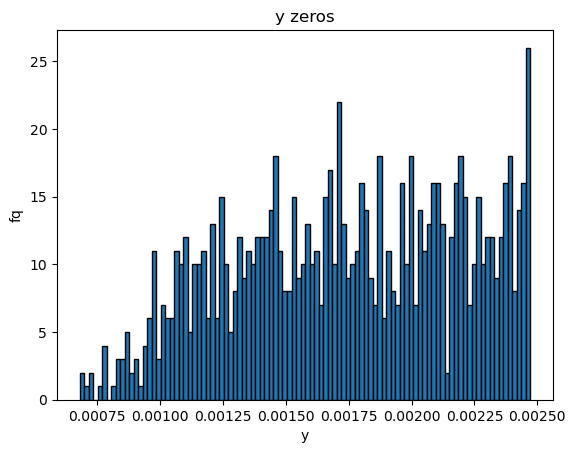

y_zero sum:  1.7452208312859556
u:  0.4966812672231242
b:  -8
b_xy*u_N:  1.6116599999999999
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.470720213500443


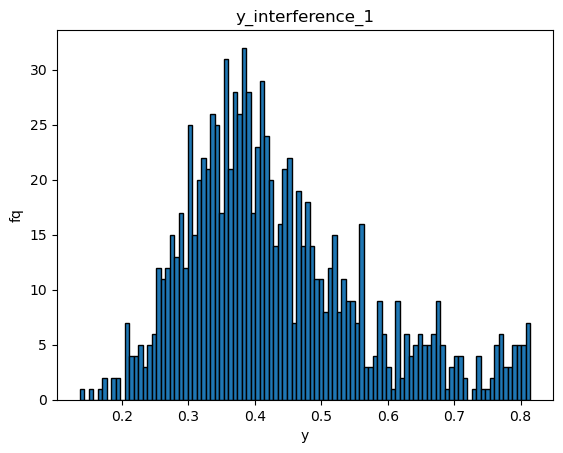

y_interference_1 sum:  3.1800630584115597
The score for greedy interference is 431.672.
u:  0.4966812672231242
b:  -8
b_xy*u_N:  1.61253
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.470720213500443


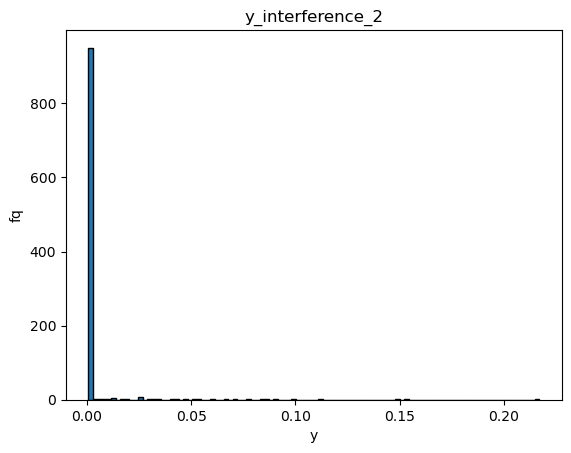

y_interference_2 sum:  4.098362551804959
The score for greedy contagion is 505.05600000000004.
The score for zero is 335.997.
starting iteration:  16


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.033581982744582795
Pearson with predicted edge probs:  tensor(0.9821)
Spearman with predicted edge probs:  0.974154692635238
Auc with predicted edge probs:  0.9969473684210527
Rmse of predicted edge probs:  0.17708737120980114
Pearson of predicted edge probs:  tensor(0.0394)
Spearman of predicted edge probs:  0.13439624095879638
Start gnn training.
u:  0.49396729228000436
b:  -8
b_xy*u_N:  1.6341280000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5026454664762268
u:  0.503758296288115
b:  -8
b_xy*u_N:  1.6533140000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4993198722432535


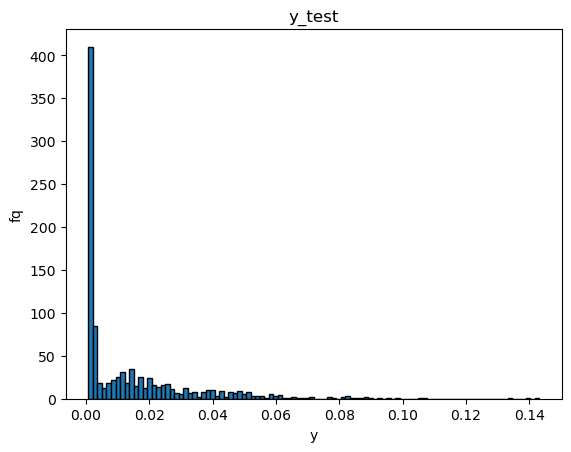

Epoch 0, Loss: 0.3786
Epoch 10, Loss: 0.3154
Epoch 20, Loss: 0.3029
Epoch 30, Loss: 0.2863
Epoch 40, Loss: 0.2474
Epoch 50, Loss: 0.1888
Epoch 60, Loss: 0.1679
Epoch 70, Loss: 0.1073
Epoch 80, Loss: 0.0966
Epoch 90, Loss: 0.0761
Epoch 100, Loss: 0.0845
Epoch 110, Loss: 0.1050
Epoch 120, Loss: 0.0621
Epoch 130, Loss: 0.0669
Epoch 140, Loss: 0.0883
Test GNN RMSE Loss: 0.0548
Test GNN pearson:  tensor(0.9437)
Test GNN spearman:  0.8600150870362383
Test GNN auc:  0.9783368421052632
Started with allocation.
CELF selected 1/50: Node 13 with gain 574.4466
CELF selected 2/50: Node 18 with gain 574.3092
CELF selected 3/50: Node 303 with gain 574.1745
CELF selected 4/50: Node 15 with gain 574.1691
CELF selected 5/50: Node 312 with gain 574.1465
CELF selected 6/50: Node 12 with gain 574.1281
CELF selected 7/50: Node 162 with gain 574.0387
CELF selected 8/50: Node 0 with gain 574.0354
CELF selected 9/50: Node 11 with gain 574.0173
CELF selected 10/50: Node 141 with gain 574.0072
CELF selected 11/5

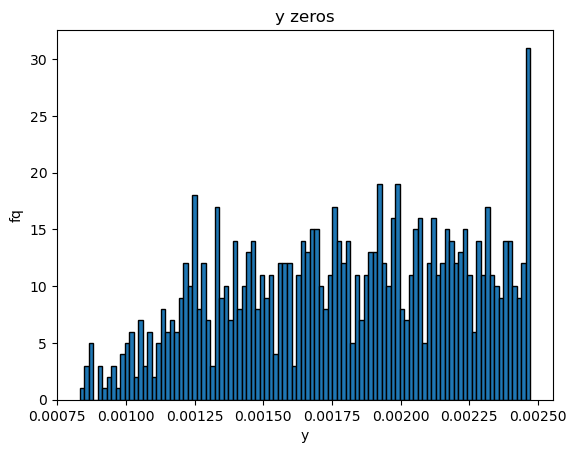

y_zero sum:  1.7957681817821618
u:  0.4963008673202999
b:  -8
b_xy*u_N:  1.647898
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5118791176042214


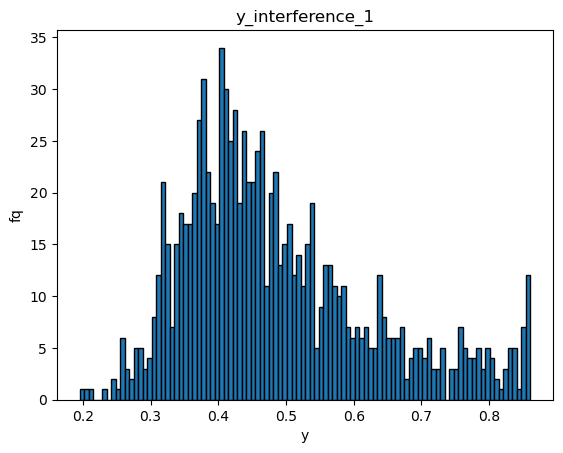

y_interference_1 sum:  3.359868318445826
The score for greedy interference is 485.74899999999997.
u:  0.4963008673202999
b:  -8
b_xy*u_N:  1.648894
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5118791176042214


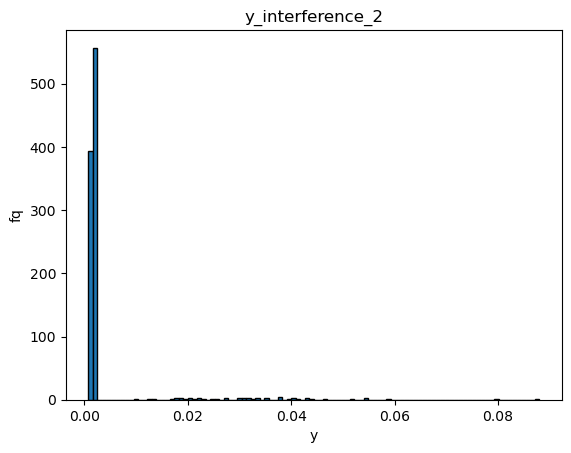

y_interference_2 sum:  3.3295082707817496
The score for greedy contagion is 521.7260000000001.
The score for zero is 360.03700000000003.
starting iteration:  17


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.03661068609483149
Pearson with predicted edge probs:  tensor(0.9799)
Spearman with predicted edge probs:  0.9753370580892624
Auc with predicted edge probs:  0.9983264117027211
Rmse of predicted edge probs:  0.18525814882044495
Pearson of predicted edge probs:  tensor(0.0502)
Spearman of predicted edge probs:  0.18340456839183913
Start gnn training.
u:  0.5013469126779273
b:  -8
b_xy*u_N:  1.629268
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.489808950509486
u:  0.49800699733183446
b:  -8
b_xy*u_N:  1.6638739999999999
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5313297987929984


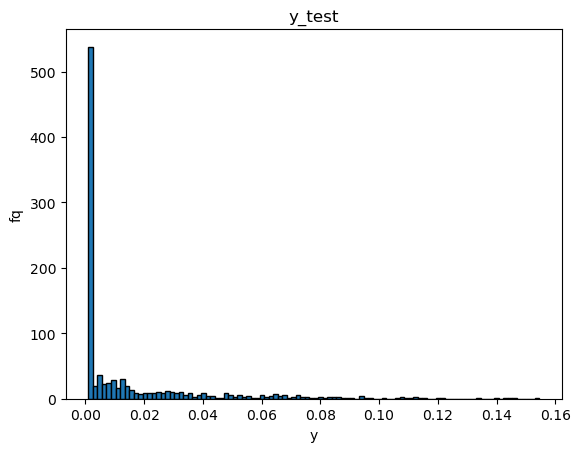

Epoch 0, Loss: 0.4110
Epoch 10, Loss: 0.3630
Epoch 20, Loss: 0.3559
Epoch 30, Loss: 0.3493
Epoch 40, Loss: 0.3367
Epoch 50, Loss: 0.3215
Epoch 60, Loss: 0.2894
Epoch 70, Loss: 0.2340
Epoch 80, Loss: 0.1770
Epoch 90, Loss: 0.1116
Epoch 100, Loss: 0.0971
Epoch 110, Loss: 0.0991
Epoch 120, Loss: 0.0726
Epoch 130, Loss: 0.0650
Epoch 140, Loss: 0.0762
Test GNN RMSE Loss: 0.0437
Test GNN pearson:  tensor(0.9576)
Test GNN spearman:  0.8186758130236247
Test GNN auc:  0.993957894736842
Started with allocation.
CELF selected 1/50: Node 14 with gain 586.7380
CELF selected 2/50: Node 17 with gain 586.1260
CELF selected 3/50: Node 150 with gain 585.6047
CELF selected 4/50: Node 269 with gain 585.0390
CELF selected 5/50: Node 11 with gain 585.0067
CELF selected 6/50: Node 152 with gain 584.9823
CELF selected 7/50: Node 18 with gain 584.9777
CELF selected 8/50: Node 479 with gain 584.9776
CELF selected 9/50: Node 922 with gain 584.9726
CELF selected 10/50: Node 16 with gain 584.9717
CELF selected 11/

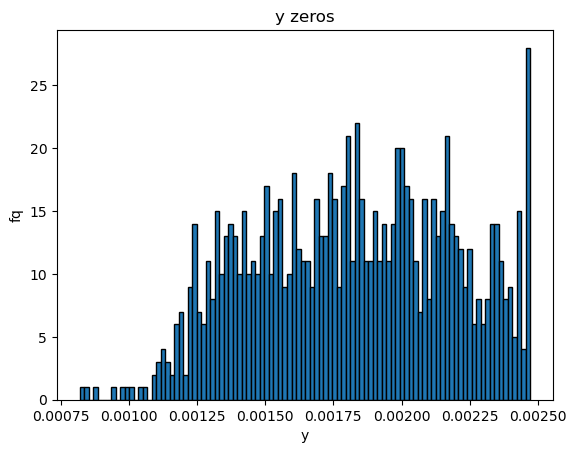

y_zero sum:  1.8200228343957847
u:  0.5082365804552643
b:  -8
b_xy*u_N:  1.6711580000000001
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.48138375732471


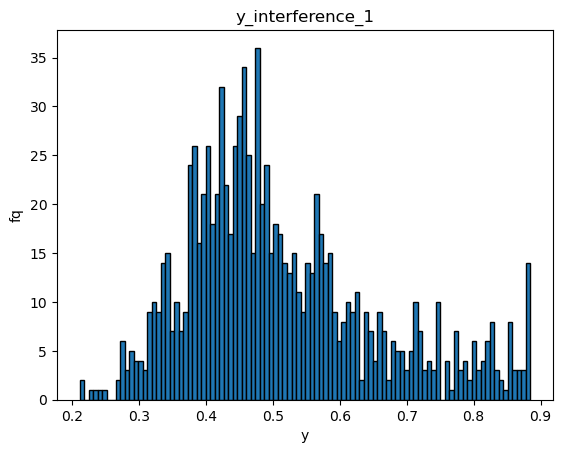

y_interference_1 sum:  3.225039731319371
The score for greedy interference is 511.81999999999994.
u:  0.5082365804552643
b:  -8
b_xy*u_N:  1.671288
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.48138375732471


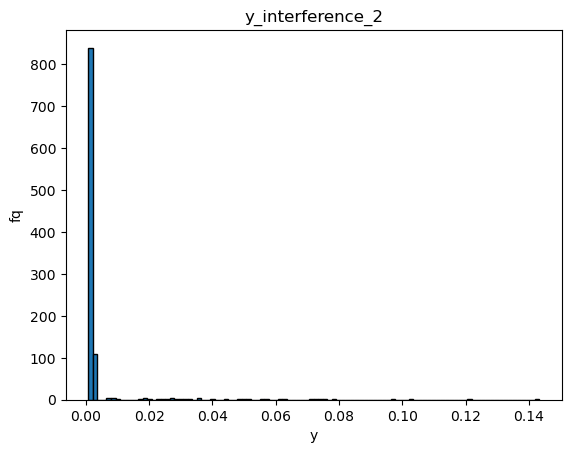

y_interference_2 sum:  3.934061182895085
The score for greedy contagion is 553.847.
The score for zero is 389.226.
starting iteration:  18


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.03519533885040313
Pearson with predicted edge probs:  tensor(0.9791)
Spearman with predicted edge probs:  0.9761077126516435
Auc with predicted edge probs:  0.9973473684210526
Rmse of predicted edge probs:  0.23142759842826816
Pearson of predicted edge probs:  tensor(0.0241)
Spearman of predicted edge probs:  0.12227043123732023
Start gnn training.
u:  0.4999023078939857
b:  -8
b_xy*u_N:  1.63591
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5077996716604813
u:  0.499670874535776
b:  -8
b_xy*u_N:  1.71144
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4898415041172575


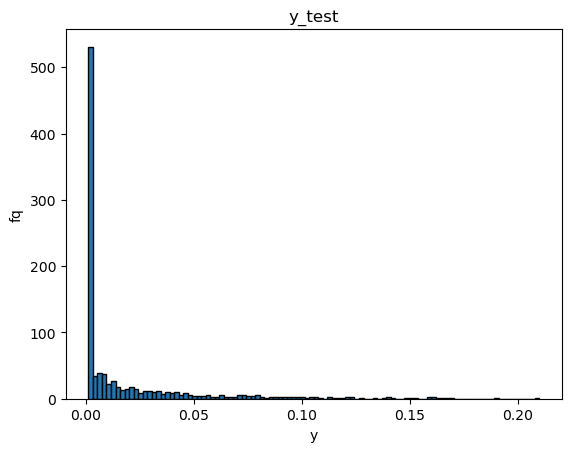

Epoch 0, Loss: 0.4296
Epoch 10, Loss: 0.3791
Epoch 20, Loss: 0.3492
Epoch 30, Loss: 0.3283
Epoch 40, Loss: 0.2801
Epoch 50, Loss: 0.2041
Epoch 60, Loss: 0.1384
Epoch 70, Loss: 0.1174
Epoch 80, Loss: 0.1014
Epoch 90, Loss: 0.0880
Epoch 100, Loss: 0.0856
Epoch 110, Loss: 0.0755
Epoch 120, Loss: 0.0654
Epoch 130, Loss: 0.0697
Epoch 140, Loss: 0.0609
Test GNN RMSE Loss: 0.0647
Test GNN pearson:  tensor(0.9675)
Test GNN spearman:  0.861392788538954
Test GNN auc:  0.9970526315789474
Started with allocation.
CELF selected 1/50: Node 14 with gain 661.3365
CELF selected 2/50: Node 312 with gain 661.0978
CELF selected 3/50: Node 10 with gain 660.9591
CELF selected 4/50: Node 141 with gain 660.9144
CELF selected 5/50: Node 4 with gain 660.8928
CELF selected 6/50: Node 858 with gain 660.8736
CELF selected 7/50: Node 497 with gain 660.8515
CELF selected 8/50: Node 1 with gain 660.8099
CELF selected 9/50: Node 286 with gain 660.8083
CELF selected 10/50: Node 397 with gain 660.7546
CELF selected 11/5

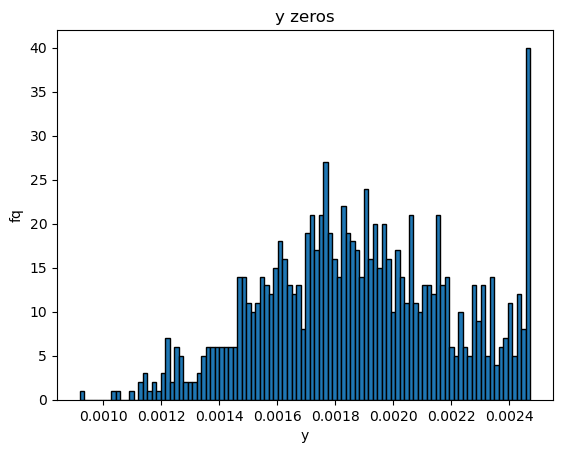

y_zero sum:  1.8790220762892749
u:  0.49703244871675695
b:  -8
b_xy*u_N:  1.7118499999999999
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4881153774398443


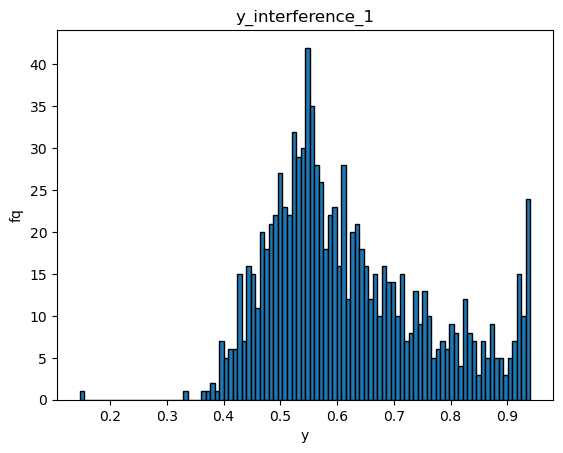

y_interference_1 sum:  3.681410190774145
The score for greedy interference is 621.124.
u:  0.49703244871675695
b:  -8
b_xy*u_N:  1.712086
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4881153774398443


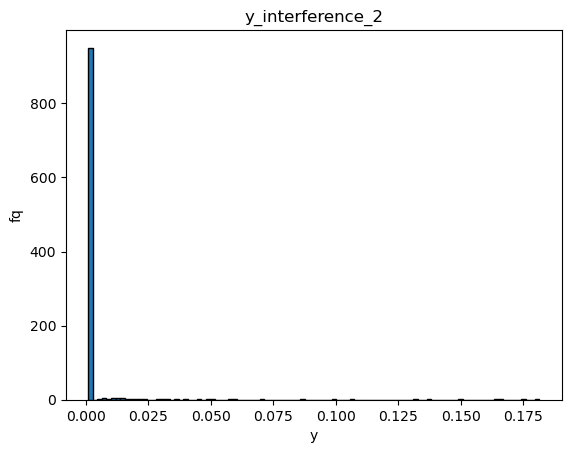

y_interference_2 sum:  4.163563046478708
The score for greedy contagion is 644.962.
The score for zero is 483.154.
starting iteration:  19


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.03703740946933742
Pearson with predicted edge probs:  tensor(0.9790)
Spearman with predicted edge probs:  0.9743259989491064
Auc with predicted edge probs:  0.9969894736842105
Rmse of predicted edge probs:  0.21741444031165344
Pearson of predicted edge probs:  tensor(0.0537)
Spearman of predicted edge probs:  0.1884636683937242
Start gnn training.
u:  0.511430168723827
b:  -8
b_xy*u_N:  1.647588
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.420762957449968
u:  0.4976334942740255
b:  -8
b_xy*u_N:  1.6565619999999999
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5158988593403464


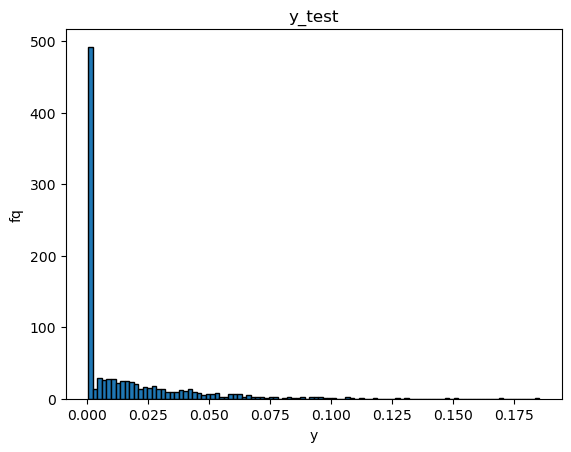

Epoch 0, Loss: 0.3869
Epoch 10, Loss: 0.3466
Epoch 20, Loss: 0.3465
Epoch 30, Loss: 0.3358
Epoch 40, Loss: 0.3274
Epoch 50, Loss: 0.3072
Epoch 60, Loss: 0.2525
Epoch 70, Loss: 0.2013
Epoch 80, Loss: 0.1318
Epoch 90, Loss: 0.0954
Epoch 100, Loss: 0.0997
Epoch 110, Loss: 0.0857
Epoch 120, Loss: 0.0870
Epoch 130, Loss: 0.0782
Epoch 140, Loss: 0.0775
Test GNN RMSE Loss: 0.0743
Test GNN pearson:  tensor(0.9163)
Test GNN spearman:  0.7860950778107854
Test GNN auc:  0.9877263157894737
Started with allocation.
CELF selected 1/50: Node 194 with gain 602.6217
CELF selected 2/50: Node 185 with gain 602.6099
CELF selected 3/50: Node 173 with gain 602.5690
CELF selected 4/50: Node 205 with gain 602.5591
CELF selected 5/50: Node 237 with gain 602.5350
CELF selected 6/50: Node 922 with gain 602.5339
CELF selected 7/50: Node 980 with gain 602.5307
CELF selected 8/50: Node 388 with gain 602.5246
CELF selected 9/50: Node 242 with gain 602.5245
CELF selected 10/50: Node 193 with gain 602.5174
CELF select

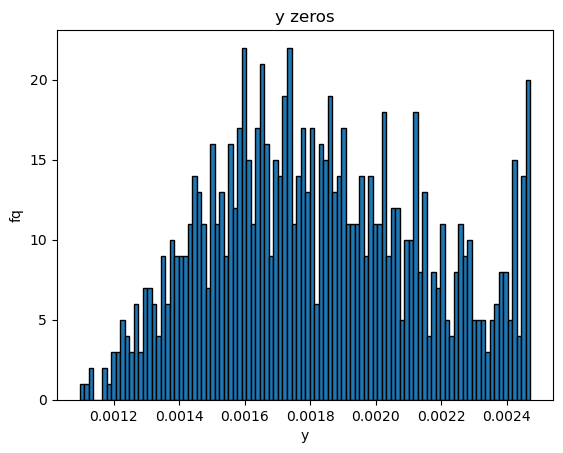

y_zero sum:  1.8282464005121137
u:  0.5024555429561233
b:  -8
b_xy*u_N:  1.679768
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.471357919697744


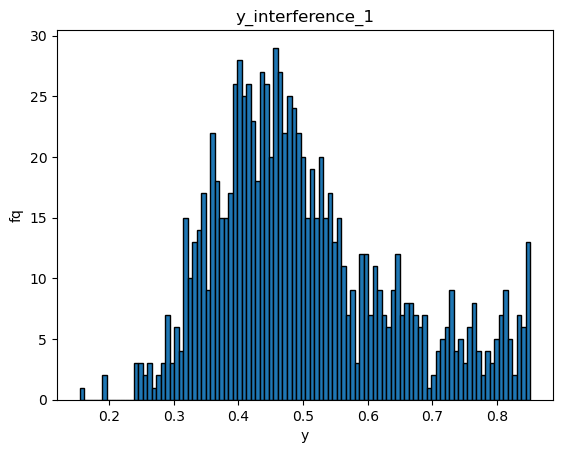

y_interference_1 sum:  3.330816665023483
The score for greedy interference is 503.27099999999996.
u:  0.5024555429561233
b:  -8
b_xy*u_N:  1.6812539999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.471357919697744


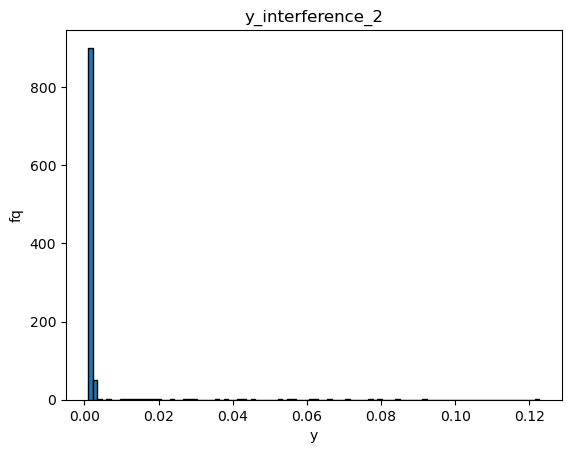

y_interference_2 sum:  3.504895377690699
The score for greedy contagion is 559.522.
The score for zero is 408.553.
y_greedy:
 mean=447.88075,
 ci_low=413.81732707904223,
 ci_high=481.9441729209577,
 std=70.93994828717807
time_greedy:
 mean=447.88075,
 ci_low=-324.7488462506141,
 ci_high=-311.85632984058003,
 std=13.424875849113507
y_topk:
 mean=520.31285,
 ci_low=497.08557758699993,
 ci_high=543.5401224130002,
 std=48.37275184158434
time_topk:
 mean=-0.34524887800216675,
 ci_low=-0.3897825972804969,
 ci_high=-0.3007151587238366,
 std=0.09274522263870066


In [22]:
num_sim=1000
num_nodes = 1000
num_edges_per_node=10
prob_selected = 0.01
num_node_features=5
num_edge_features=5
num_graphs=20

b_s=1
b_t=0.5
b_e=1
b0=0
b=-8#-6,-8,-8
b_ty=5#5,5,5
b_xt=0.5
b_t=0.5
b_nt=0.5
b_xy=2#2,2,2
b_ep=0.05
prob_treated=0.5
confounding_t=False
damp_factor=1

T=10
attribute_distribution="normal"
max_edge=1/7 # 1/3, 1/5, 1/7
normal = False
percentile = 95

y_int = np.zeros(num_graphs)
time_greedy = np.zeros(num_graphs)
y_con = np.zeros(num_graphs)
time_topk = np.zeros(num_graphs)

for i in range(num_graphs):
    print("starting iteration: ", i)
    if normal:
        node_weights=np.random.normal(size=num_node_features)
        node_weights_source=np.random.normal(size=num_node_features)
        node_weights_sink=np.random.normal(size=num_node_features)
        epsilon=np.random.normal(size=1)*-4
        edge_weights=np.random.normal(size=num_edge_features)
    else:
        node_weights=np.random.rand(num_node_features)*2-1
        node_weights_source=np.random.rand(num_node_features)*2-1
        node_weights_sink=np.random.rand(num_node_features)*2-1
        epsilon=np.random.rand(1)*-4
        edge_weights=np.random.rand(num_edge_features)*2-1
    edge_method='weighted_sum'
    
    # Edge probabilities prediction
    alpha=1
    G_test, prior_probs_test, edge_dict_test = generate_barabasi_albert_attribute_graph(num_nodes,
                                                                         num_edges_per_node,
                                                                         num_node_features=num_node_features,
                                                                         num_edge_features=num_edge_features,
                                                                         node_weights=node_weights,
                                                                         edge_weights=edge_weights,
                                                                         edge_method=edge_method,
                                                                         max_edge=max_edge,
                                                                         prob_selected=prob_selected,
                                                                         attribute_distribution=attribute_distribution)
    
    initial_edge_probs_dict = generate_edge_probabilities(G_test,method="uniform", p=0)
    edges_test = list(edge_dict_test.keys())
    edge_index_test = torch.tensor(edges_test, dtype=torch.long).T
    edge_attr_test = torch.tensor([edge_dict_test[(u, v)] for (u, v) in edges_test], dtype=torch.float)
    initial_edge_probs_test = torch.tensor([initial_edge_probs_dict[(u, v)] for (u, v) in edges_test], dtype=torch.float)

    data_test = Data(x=prior_probs_test.unsqueeze(1), edge_index=edge_index_test, edge_attr=edge_attr_test)
    model = edge_probs_prediction(data_test,
                                  optimized_independent_cascade, 
                                  num_steps=T,
                                  lr=0.1, 
                                  epochs=300,
                                  alpha=alpha,
                                  num_sim=num_sim,
                                  reg_const=0,
                                  initial_edges = initial_edge_probs_test,
                                  decay=1,
                                  max_edge = max_edge,
                                  print_loss=False)
    
    
    model.eval()
    with torch.no_grad():
        predicted_posterior_test, predicted_edge_probs_test = model(G_test, data_test.x)
    
    ic = optimized_independent_cascade(G_test, prior_probs_test, edge_dict_test, num_sim)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    true_posterior_tensor_test = torch.tensor(
        [ic[node] for node in ic],
        dtype=torch.float,
        device=device
    ).view(-1, 1)
    rmse_loss = torch.nn.MSELoss()(predicted_posterior_test, true_posterior_tensor_test)
    rmse_loss_prior = torch.nn.MSELoss()(prior_probs_test.unsqueeze(1), true_posterior_tensor_test)
    
    rmse_loss = torch.nn.MSELoss()(predicted_edge_probs_test, edge_attr_test)
    
    predicted_edge_dict_test = edge_index_to_dict(edge_index_test, predicted_edge_probs_test)
    preds = IC_approx_vectorized(G_test, predicted_edge_dict_test, prior_probs_test, T, 1)
    preds_IC_approx = torch.tensor(preds, dtype=torch.float32).unsqueeze(1)
    rmse = torch.nn.MSELoss()(preds_IC_approx, true_posterior_tensor_test).item()**0.5
    print("Rmse with predicted edge probs: ", rmse)
    pearson = torch.corrcoef(torch.stack([preds_IC_approx.squeeze(), true_posterior_tensor_test.squeeze()]))[0, 1]
    print("Pearson with predicted edge probs: ", pearson)
    spearman, _ = spearmanr(preds_IC_approx.squeeze(),
                              true_posterior_tensor_test.squeeze())
    print("Spearman with predicted edge probs: ", spearman)

    y_true = true_posterior_tensor_test.squeeze().numpy()
    y_score = preds_IC_approx.squeeze().numpy()
    threshold = np.percentile(y_true, percentile)
    y_binary = (y_true >= threshold).astype(int)
    auc = roc_auc_score(y_binary, y_score)
    print("Auc with predicted edge probs: ", auc)

    rmse_edge = torch.nn.MSELoss()(predicted_edge_probs_test, edge_attr_test).item()**0.5
    print("Rmse of predicted edge probs: ", rmse_edge)
    pearson_edge = torch.corrcoef(torch.stack([predicted_edge_probs_test, edge_attr_test]))[0, 1]
    print("Pearson of predicted edge probs: ", pearson_edge)
    spearman_edge,_ = spearmanr(predicted_edge_probs_test, edge_attr_test)
    print("Spearman of predicted edge probs: ", spearman_edge)

    # GNN training
    print("Start gnn training.")
    G, prior_probs, edge_dict = generate_barabasi_albert_attribute_graph(num_nodes,
                                                                        num_edges_per_node,
                                                                        num_node_features=num_node_features,
                                                                        num_edge_features=num_edge_features,
                                                                        node_weights=node_weights,
                                                                        edge_weights=edge_weights,
                                                                        edge_method=edge_method,
                                                                        max_edge=max_edge,
                                                                        prob_selected=prob_selected,
                                                                        node_weights_source=node_weights_source,
                                                                        node_weights_sink=node_weights_sink,
                                                                        epsilon=epsilon,
                                                                        b_s=b_s,
                                                                        b_t=b_t,
                                                                        b_e=b_e,
                                                                        attribute_distribution=attribute_distribution)

    edges = list(G.edges())
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor([edge_dict[(u, v)] for (u, v) in edges], dtype=torch.float)
    node_features = torch.tensor(
        [G.nodes[node]['features'] for node in G.nodes()],
        dtype=torch.float32
    )
    edge_features = torch.tensor(
        [G.edges[edge]['features'] for edge in G.edges()],
        dtype=torch.float32
    )
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr.unsqueeze(1))
    
    
    node_features_test = torch.tensor(
        [G_test.nodes[node]['features'] for node in G_test.nodes()],
        dtype=torch.float32
    )
    edge_features_test = torch.tensor(
        [G_test.edges[edge]['features'] for edge in G_test.edges()],
        dtype=torch.float32
    )
    edge_attr_pred = torch.tensor([predicted_edge_dict_test[(u, v)] for (u, v) in predicted_edge_dict_test], dtype=torch.float)
    data_test = Data(x=node_features_test, edge_index=edge_index_test, edge_attr=edge_attr_pred.unsqueeze(1))
    
    w_ty=np.random.rand(num_node_features)*2-1
    w_xt=np.random.rand(num_node_features)*2-1
    w_xy=np.random.rand(num_node_features)*2-1
    ep=np.random.normal()
    
    coin_toss = np.random.rand(num_nodes)
    t = (coin_toss < prob_treated).astype(int)
    coin_toss_test = np.random.rand(num_nodes)
    t_test = (coin_toss_test < prob_treated).astype(int)
    
    y=generate_y(G=G,
                 edge_probs=edge_dict, 
                 x=data.x, 
                 w_xy=w_xy, 
                 b_xy=b_xy, 
                 t=t, 
                 w_ty=w_ty, 
                 b_ty=b_ty,
                 b=b,
                 num_sim=num_sim,
                 damp_factor=damp_factor)
    
    y_test=generate_y(G=G_test,
                 edge_probs=edge_dict_test, 
                 x=data_test.x, 
                 w_xy=w_xy, 
                 b_xy=b_xy, 
                 t=t_test, 
                 w_ty=w_ty, 
                 b_ty=b_ty,
                 b=b,
                 num_sim=num_sim,
                 damp_factor=damp_factor)

    plt.hist(y_test, bins=100, edgecolor='black')
    plt.title('y_test')
    plt.xlabel('y')
    plt.ylabel('fq')
    plt.show()
    
    node_features_full=torch.cat([torch.tensor(t, dtype=torch.float32).unsqueeze(1), node_features], dim=1)
    node_features_test_full=torch.cat([torch.tensor(t_test, dtype=torch.float32).unsqueeze(1), node_features_test], dim=1)
    data = Data(x=node_features_full, edge_index=edge_index, edge_attr=edge_attr.unsqueeze(1), y=torch.tensor(y, dtype=torch.float32))
    data_test = Data(x=node_features_test_full, edge_index=edge_index_test, edge_attr=edge_attr_pred.unsqueeze(1), y=torch.tensor(y_test, dtype=torch.float32))
    model = train_DeepECCNet(data,
                             lr=0.01,
                             epochs=150, 
                             num_layers=1, 
                             loss_type="alpha", 
                             alpha=0.225,
                             hidden_channels=64, 
                             dropout=0.25,
                             w_decay=False)
    
    model.eval()
    with torch.no_grad():
        predicted_y_test = model(data_test.x, data_test.edge_index, data_test.edge_attr)
        predicted_y = model(data.x, data.edge_index, data.edge_attr)
    print(f"Test GNN RMSE Loss: {(((predicted_y_test - data_test.y)**2).mean())**0.5:.4f}")
    pearson_GNN = torch.corrcoef(torch.stack([predicted_y_test.squeeze(), data_test.y.squeeze()]))[0, 1]
    print("Test GNN pearson: ", pearson_GNN)
    spearman_GNN, _ = spearmanr(predicted_y_test.squeeze(),
                              data_test.y.squeeze())

    print("Test GNN spearman: ", spearman_GNN)

    y_true = data_test.y.squeeze().numpy()
    y_score = predicted_y_test.squeeze().numpy()
    threshold = np.percentile(y_test, percentile)
    y_binary = (y_true >= threshold).astype(int)
    auc_gnn = roc_auc_score(y_binary, y_score)
    print("Test GNN auc: ", auc_gnn)

    # Allocation eval
    print("Started with allocation.")
    t = np.zeros(num_nodes)
    data_test.x[:,0] = torch.tensor(t, dtype=torch.float32)
    
    budget = round(0.05 * num_nodes)
    #greedy_interference_t = select_top_baseline_nodes(G_test, budget, model, data_test)
    start = time.time()
    greedy_interference_t = treatment_contagion_celf(G_test, predicted_edge_dict_test, budget, model, data_test, diffusion_method="IC_approx")
    end = time.time()
    time_greedy[i] = start-end
    #greedy_contagion_t = treatment_contagion_celf(G_test, predicted_edge_dict_test, budget, model, data_test, diffusion_method="IC_approx")
    start = time.time()
    greedy_contagion_t = select_top_contagion_nodes(G_test, predicted_edge_dict_test, budget, model, data_test, diffusion_method="IC_approx")
    end = time.time()
    time_topk[i] = start-end
    y_zero=generate_y(G=G_test,
                         edge_probs=edge_dict_test, 
                         x=data_test.x[:,0:num_node_features], 
                         w_xy=w_xy, 
                         b_xy=b_xy, 
                         t=torch.zeros(num_nodes), 
                         w_ty=w_ty, 
                         b_ty=b_ty,
                         b=b,
                         num_sim=num_sim,
                         damp_factor=damp_factor)
    plt.hist(y_zero, bins=100, edgecolor='black')
    plt.title('y zeros')
    plt.xlabel('y')
    plt.ylabel('fq')
    plt.show()
    print("y_zero sum: ", y_zero.sum())
    
    y_interference_1=generate_y(G=G_test,
                                 edge_probs=edge_dict_test, 
                                 x=data_test.x[:,0:num_node_features], 
                                 w_xy=w_xy, 
                                 b_xy=b_xy, 
                                 t=greedy_interference_t, 
                                 w_ty=w_ty, 
                                 b_ty=b_ty,
                                 b=b,
                                 num_sim=num_sim,
                                 damp_factor=damp_factor)
    y_interference_final = generate_contagion_outcome(G_test, edge_dict_test, y_interference_1, diffusion_method="IC", num_sim=num_sim)
    plt.hist(y_interference_final, bins=100, edgecolor='black')
    plt.title('y_interference_1')
    plt.xlabel('y')
    plt.ylabel('fq')
    plt.show()
    print("y_interference_1 sum: ", y_interference_1.sum())
    score_interference = y_interference_final.sum()
    y_int[i] = score_interference
    print(f"The score for greedy interference is {score_interference}.")
    
    y_interference_2=generate_y(G=G_test,
                                 edge_probs=edge_dict_test, 
                                 x=data_test.x[:,0:num_node_features], 
                                 w_xy=w_xy, 
                                 b_xy=b_xy, 
                                 t=greedy_contagion_t, 
                                 w_ty=w_ty, 
                                 b_ty=b_ty,
                                 b=b,
                                 num_sim=num_sim,
                                 damp_factor=damp_factor)
    plt.hist(y_interference_2, bins=100, edgecolor='black')
    plt.title('y_interference_2')
    plt.xlabel('y')
    plt.ylabel('fq')
    plt.show()
    print("y_interference_2 sum: ", y_interference_2.sum())
    y_contagion_final = generate_contagion_outcome(G_test, edge_dict_test, y_interference_2, diffusion_method="IC", num_sim=num_sim)
    score_contagion = y_contagion_final.sum()
    y_con[i] = score_contagion
    print(f"The score for greedy contagion is {score_contagion}.")

    y_zero_contagion = generate_contagion_outcome(G_test, edge_dict_test, y_zero, diffusion_method="IC", num_sim=num_sim)
    print(f"The score for zero is {y_zero_contagion.sum()}.")

#summarise_stats_um(y_int, y_con)
summarise_stats_um_gr(y_int, y_con, time_greedy, time_topk)

## Erdos Renyi

starting iteration:  0


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.01059517177884378
Pearson with predicted edge probs:  tensor(0.9923)
Spearman with predicted edge probs:  0.9884419346186584
Auc with predicted edge probs:  0.9989052631578947
Rmse of predicted edge probs:  0.07378982529415055
Pearson of predicted edge probs:  tensor(0.1142)
Spearman of predicted edge probs:  0.11135798662961315
Start gnn training.
u:  0.5062336843754307
b:  -6
b_xy*u_N:  1.5252856
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5582954065530066
u:  0.5085516431905609
b:  -6
b_xy*u_N:  1.5591030000000001
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.471952922004379


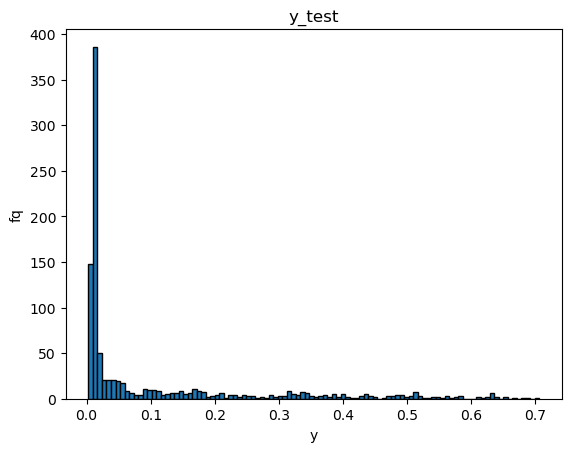

Epoch 0, Loss: 0.3831
Epoch 10, Loss: 0.3312
Epoch 20, Loss: 0.3157
Epoch 30, Loss: 0.3064
Epoch 40, Loss: 0.2768
Epoch 50, Loss: 0.2471
Epoch 60, Loss: 0.2177
Epoch 70, Loss: 0.1806
Epoch 80, Loss: 0.1206
Epoch 90, Loss: 0.1017
Epoch 100, Loss: 0.0712
Epoch 110, Loss: 0.0557
Epoch 120, Loss: 0.0539
Epoch 130, Loss: 0.0445
Epoch 140, Loss: 0.0442
Test GNN RMSE Loss: 0.0643
Test GNN pearson:  tensor(0.9616)
Test GNN spearman:  0.8831104033436862
Test GNN auc:  0.9746315789473684
Started with allocation.
Selected top 50 nodes based on baseline predictions: [672, 197, 864, 804, 235, 250, 659, 113, 108, 257], ...
Selected top 50 nodes based on baseline predictions: [672, 997, 936, 809, 197, 177, 609, 755, 665, 567], ...
u:  0.49507785202138954
b:  -6
b_xy*u_N:  1.5506822
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5231581519512214


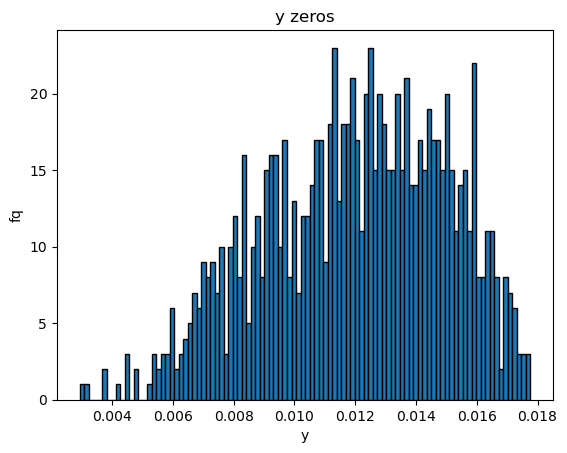

y_zero sum:  11.9767094444688
u:  0.49507785202138954
b:  -6
b_xy*u_N:  1.5509362000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5231581519512214


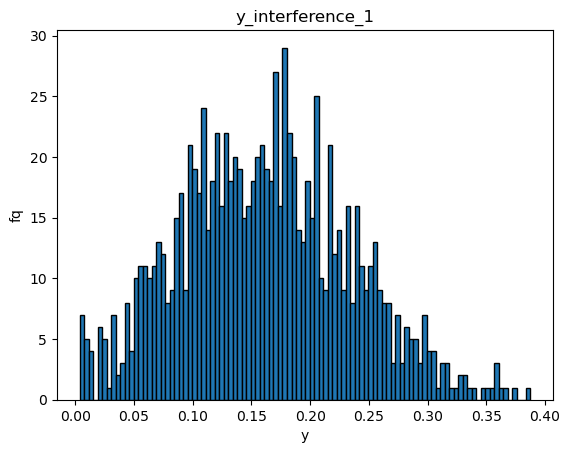

y_interference_1 sum:  13.125564730241134
The score for greedy interference is 161.04340000000002.
u:  0.49507785202138954
b:  -6
b_xy*u_N:  1.55047
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5231581519512214


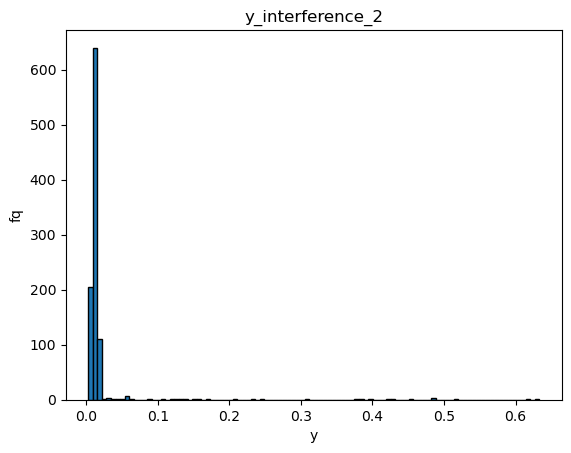

y_interference_2 sum:  20.880613840726006
The score for greedy contagion is 227.7659.
The score for zero is 154.58620000000002.
starting iteration:  1


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.010855526241562571
Pearson with predicted edge probs:  tensor(0.9928)
Spearman with predicted edge probs:  0.9922539745774271
Auc with predicted edge probs:  0.9989052631578947
Rmse of predicted edge probs:  0.07494658664259317
Pearson of predicted edge probs:  tensor(0.1771)
Spearman of predicted edge probs:  0.15280505371798583
Start gnn training.
u:  0.5057915221869437
b:  -6
b_xy*u_N:  1.5593343999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4887388425275123
u:  0.5024958254223125
b:  -6
b_xy*u_N:  1.5586938
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.498111685168682


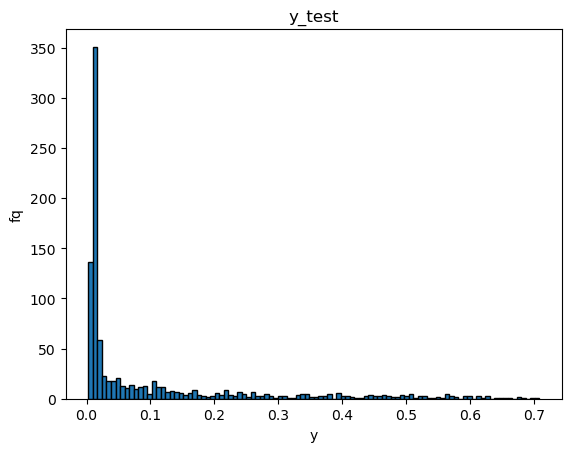

Epoch 0, Loss: 0.3938
Epoch 10, Loss: 0.3522
Epoch 20, Loss: 0.3316
Epoch 30, Loss: 0.3084
Epoch 40, Loss: 0.2643
Epoch 50, Loss: 0.2231
Epoch 60, Loss: 0.1764
Epoch 70, Loss: 0.1633
Epoch 80, Loss: 0.1105
Epoch 90, Loss: 0.0828
Epoch 100, Loss: 0.0806
Epoch 110, Loss: 0.0870
Epoch 120, Loss: 0.1001
Epoch 130, Loss: 0.0705
Epoch 140, Loss: 0.0681
Test GNN RMSE Loss: 0.0612
Test GNN pearson:  tensor(0.9730)
Test GNN spearman:  0.8744344480170341
Test GNN auc:  0.991957894736842
Started with allocation.
Selected top 50 nodes based on baseline predictions: [503, 91, 691, 645, 497, 279, 625, 418, 967, 10], ...
Selected top 50 nodes based on baseline predictions: [654, 274, 636, 966, 279, 611, 388, 592, 91, 150], ...
u:  0.4971859839051592
b:  -6
b_xy*u_N:  1.5595720000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4813864542912905


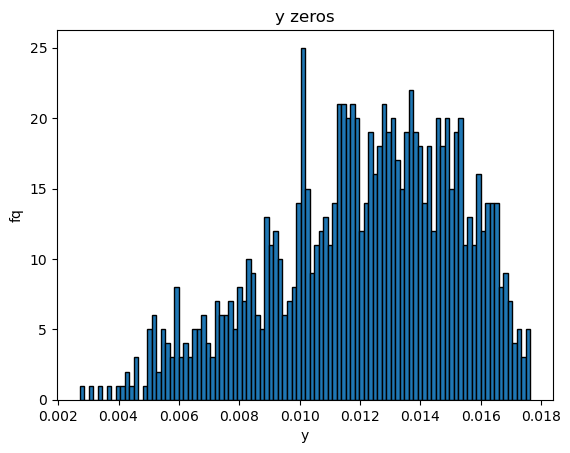

y_zero sum:  12.120750008099641
u:  0.4971859839051592
b:  -6
b_xy*u_N:  1.5587784
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4813864542912905


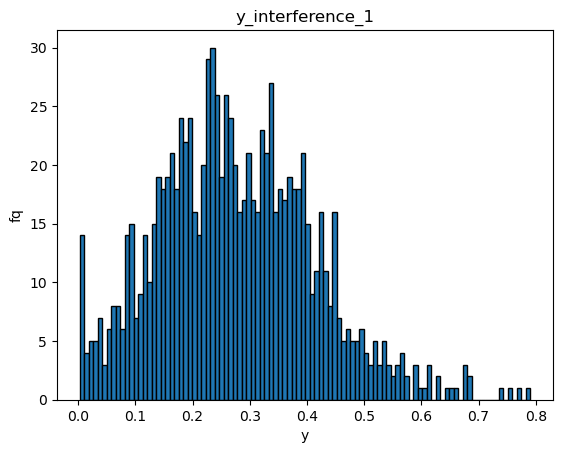

y_interference_1 sum:  27.443877720567293
The score for greedy interference is 275.408.
u:  0.4971859839051592
b:  -6
b_xy*u_N:  1.5589368
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4813864542912905


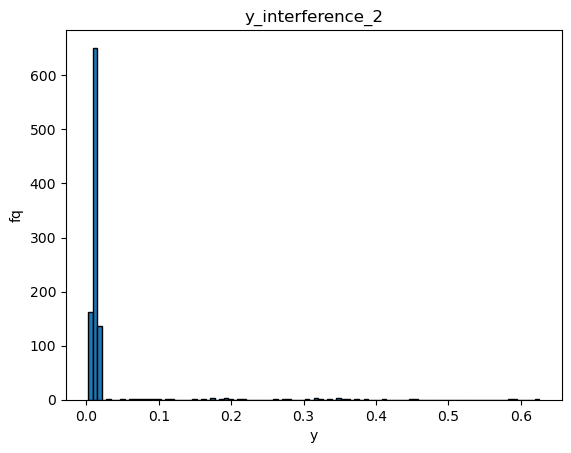

y_interference_2 sum:  23.737544112069422
The score for greedy contagion is 274.9892.
The score for zero is 195.7703.
starting iteration:  2


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.011467306115949746
Pearson with predicted edge probs:  tensor(0.9976)
Spearman with predicted edge probs:  0.9977560346887154
Auc with predicted edge probs:  0.9996842105263158
Rmse of predicted edge probs:  0.04933457228839876
Pearson of predicted edge probs:  tensor(0.4154)
Spearman of predicted edge probs:  0.3505520864464123
Start gnn training.
u:  0.4939514572555199
b:  -6
b_xy*u_N:  1.4122561999999999
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5145382502784295
u:  0.5019495359006017
b:  -6
b_xy*u_N:  1.641896
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4697996508613596


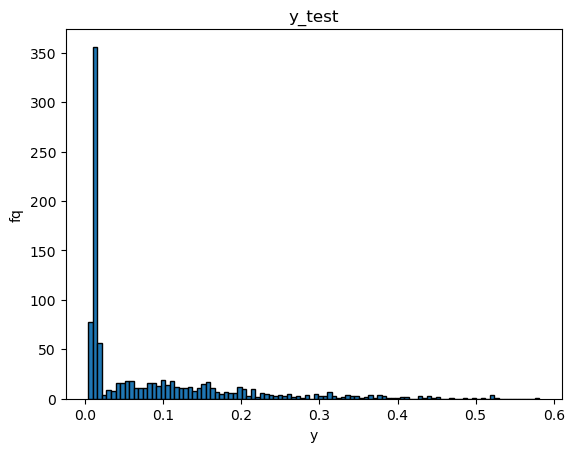

Epoch 0, Loss: 0.3305
Epoch 10, Loss: 0.2921
Epoch 20, Loss: 0.2829
Epoch 30, Loss: 0.2600
Epoch 40, Loss: 0.2288
Epoch 50, Loss: 0.1825
Epoch 60, Loss: 0.1654
Epoch 70, Loss: 0.1292
Epoch 80, Loss: 0.0827
Epoch 90, Loss: 0.0766
Epoch 100, Loss: 0.0591
Epoch 110, Loss: 0.0634
Epoch 120, Loss: 0.0568
Epoch 130, Loss: 0.0469
Epoch 140, Loss: 0.0471
Test GNN RMSE Loss: 0.0298
Test GNN pearson:  tensor(0.9659)
Test GNN spearman:  0.8897483938566987
Test GNN auc:  0.9922736842105263
Started with allocation.
Selected top 50 nodes based on baseline predictions: [730, 560, 31, 116, 640, 508, 179, 32, 779, 881], ...
Selected top 50 nodes based on baseline predictions: [592, 90, 918, 285, 67, 723, 319, 343, 220, 656], ...
u:  0.4985680967860009
b:  -6
b_xy*u_N:  1.6275096
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4845588792392412


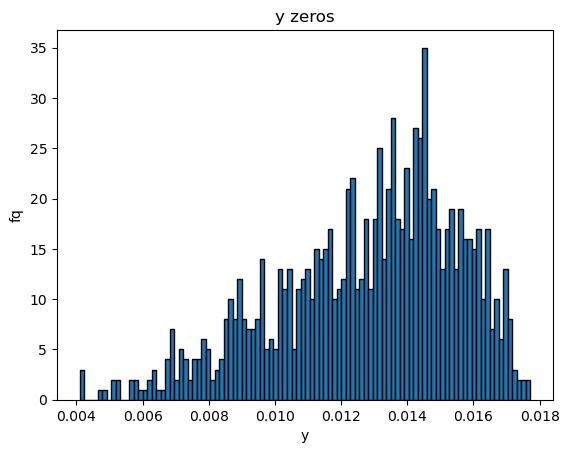

y_zero sum:  12.801781928261967
u:  0.4985680967860009
b:  -6
b_xy*u_N:  1.6278618
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4845588792392412


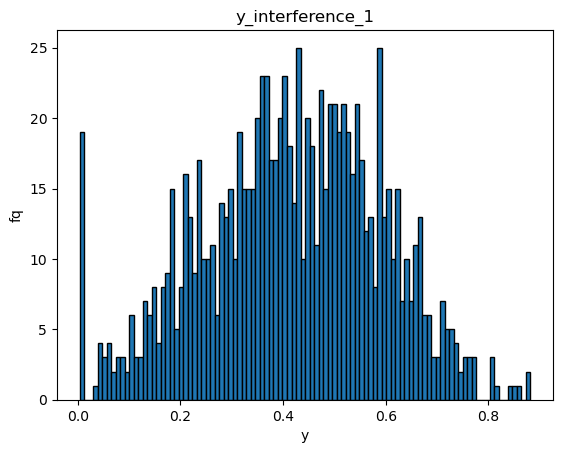

y_interference_1 sum:  27.699453601525736
The score for greedy interference is 416.0947.
u:  0.4985680967860009
b:  -6
b_xy*u_N:  1.6276148000000001
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4845588792392412


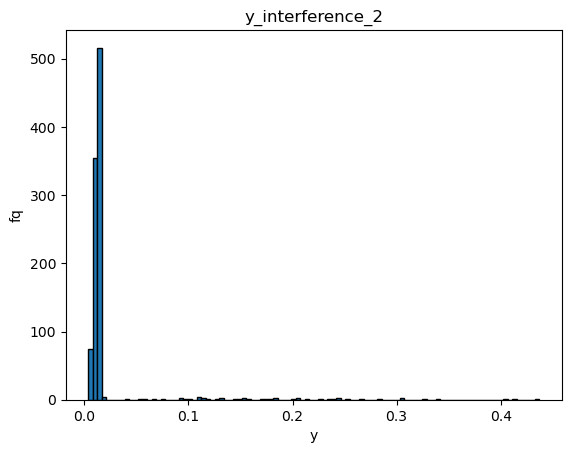

y_interference_2 sum:  21.162108213831488
The score for greedy contagion is 399.5975.
The score for zero is 372.4449.
starting iteration:  3


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.009801327738372655
Pearson with predicted edge probs:  tensor(0.9927)
Spearman with predicted edge probs:  0.9782376612038082
Auc with predicted edge probs:  0.997957894736842
Rmse of predicted edge probs:  0.03429730478073942
Pearson of predicted edge probs:  tensor(-0.0706)
Spearman of predicted edge probs:  -0.01376621881111028
Start gnn training.
u:  0.49973831863252455
b:  -6
b_xy*u_N:  1.6387956
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5417576022864714
u:  0.5005186117801487
b:  -6
b_xy*u_N:  1.5246986
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.442392412234527


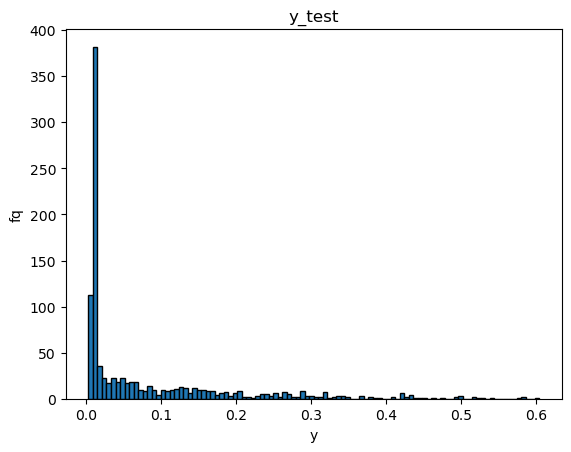

Epoch 0, Loss: 0.3541
Epoch 10, Loss: 0.3124
Epoch 20, Loss: 0.3065
Epoch 30, Loss: 0.2832
Epoch 40, Loss: 0.2307
Epoch 50, Loss: 0.1424
Epoch 60, Loss: 0.1058
Epoch 70, Loss: 0.0973
Epoch 80, Loss: 0.0869
Epoch 90, Loss: 0.0992
Epoch 100, Loss: 0.0788
Epoch 110, Loss: 0.0830
Epoch 120, Loss: 0.0913
Epoch 130, Loss: 0.0631
Epoch 140, Loss: 0.0594
Test GNN RMSE Loss: 0.0401
Test GNN pearson:  tensor(0.9486)
Test GNN spearman:  0.8481111260741317
Test GNN auc:  0.9802105263157894
Started with allocation.
Selected top 50 nodes based on baseline predictions: [938, 707, 70, 382, 731, 886, 766, 323, 447, 94], ...
Selected top 50 nodes based on baseline predictions: [474, 562, 773, 548, 359, 830, 487, 919, 926, 930], ...
u:  0.5082909764078982
b:  -6
b_xy*u_N:  1.5229785999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5225885994832433


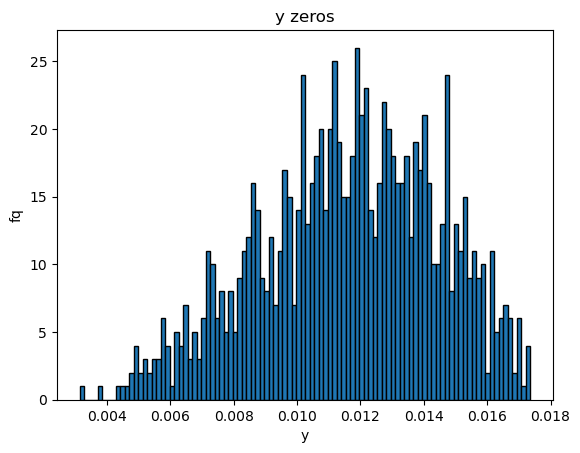

y_zero sum:  11.625761009731107
u:  0.5082909764078982
b:  -6
b_xy*u_N:  1.5225920000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5225885994832433


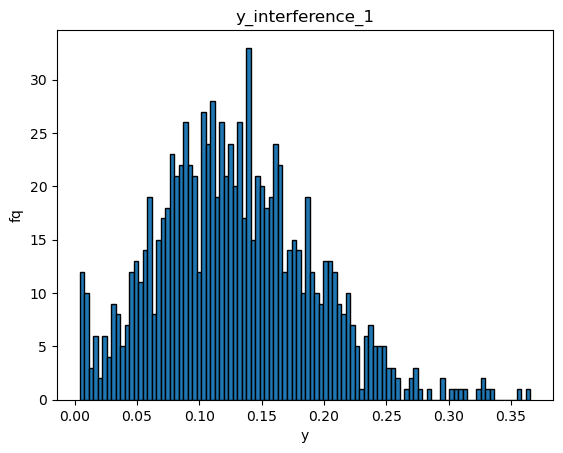

y_interference_1 sum:  15.948646524939765
The score for greedy interference is 128.68240000000003.
u:  0.5082909764078982
b:  -6
b_xy*u_N:  1.5232217999999997
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5225885994832433


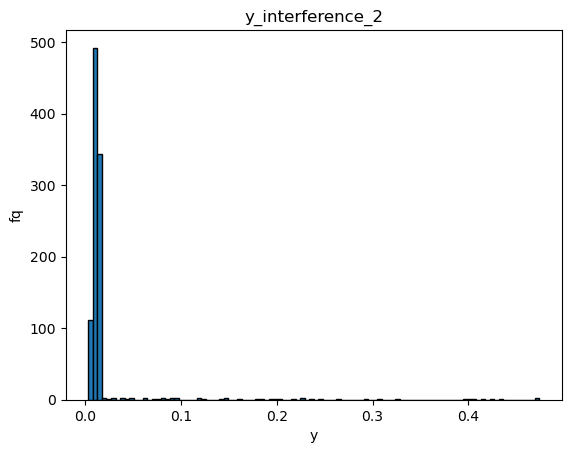

y_interference_2 sum:  19.82204076400151
The score for greedy contagion is 176.75400000000002.
The score for zero is 109.803.
starting iteration:  4


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.011035894795406318
Pearson with predicted edge probs:  tensor(0.9930)
Spearman with predicted edge probs:  0.9928569114709728
Auc with predicted edge probs:  0.9998105263157895
Rmse of predicted edge probs:  0.08062573473710163
Pearson of predicted edge probs:  tensor(0.1305)
Spearman of predicted edge probs:  0.12345985549053488
Start gnn training.
u:  0.4980591259913598
b:  -6
b_xy*u_N:  1.5604654
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5165323100581225
u:  0.500079846680627
b:  -6
b_xy*u_N:  1.5504248000000003
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.474240558684928


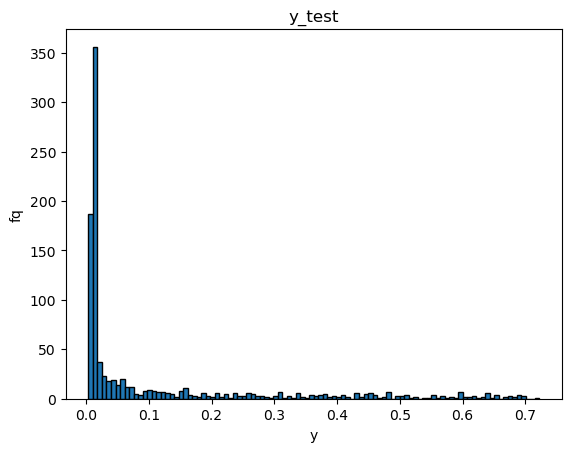

Epoch 0, Loss: 0.4032
Epoch 10, Loss: 0.3400
Epoch 20, Loss: 0.3356
Epoch 30, Loss: 0.3193
Epoch 40, Loss: 0.2916
Epoch 50, Loss: 0.2580
Epoch 60, Loss: 0.1846
Epoch 70, Loss: 0.1315
Epoch 80, Loss: 0.0910
Epoch 90, Loss: 0.0805
Epoch 100, Loss: 0.0783
Epoch 110, Loss: 0.0541
Epoch 120, Loss: 0.0655
Epoch 130, Loss: 0.0529
Epoch 140, Loss: 0.0573
Test GNN RMSE Loss: 0.0409
Test GNN pearson:  tensor(0.9794)
Test GNN spearman:  0.8608922207977253
Test GNN auc:  0.9895578947368421
Started with allocation.
Selected top 50 nodes based on baseline predictions: [681, 238, 508, 213, 941, 973, 697, 843, 108, 736], ...
Selected top 50 nodes based on baseline predictions: [681, 213, 508, 589, 973, 587, 238, 749, 9, 471], ...
u:  0.49906146860377953
b:  -6
b_xy*u_N:  1.5511891999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.524453231962045


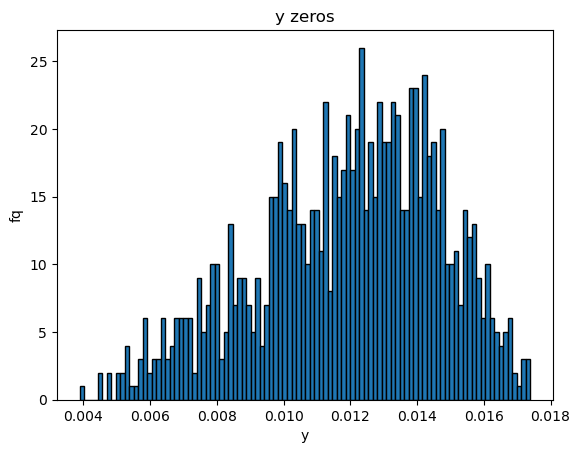

y_zero sum:  11.916691400475221
u:  0.49906146860377953
b:  -6
b_xy*u_N:  1.550916
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.524453231962045


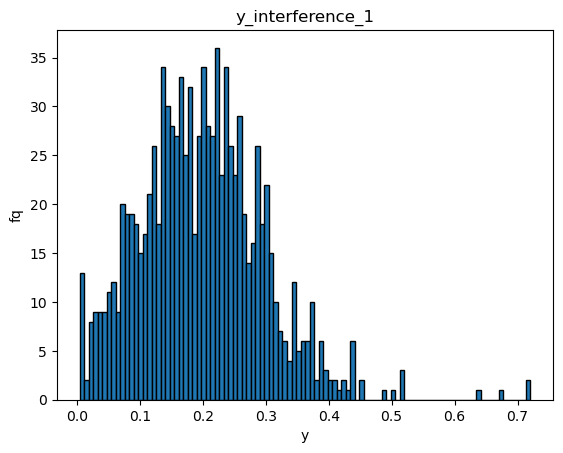

y_interference_1 sum:  19.43049733355278
The score for greedy interference is 198.03629999999998.
u:  0.49906146860377953
b:  -6
b_xy*u_N:  1.5517911999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.524453231962045


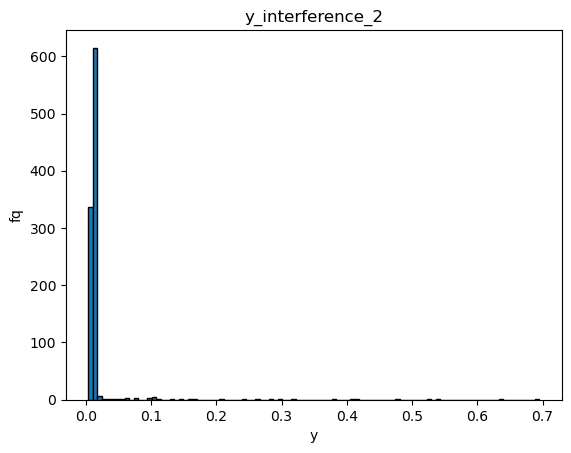

y_interference_2 sum:  20.104019798865956
The score for greedy contagion is 225.7895.
The score for zero is 157.77100000000002.
starting iteration:  5


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.01048669853180614
Pearson with predicted edge probs:  tensor(0.9962)
Spearman with predicted edge probs:  0.996580639762426
Auc with predicted edge probs:  0.9993263157894737
Rmse of predicted edge probs:  0.05521064264637899
Pearson of predicted edge probs:  tensor(0.3615)
Spearman of predicted edge probs:  0.26268970785931806
Start gnn training.
u:  0.5000491775558349
b:  -6
b_xy*u_N:  1.6207354
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.498245380964853
u:  0.5043630715258656
b:  -6
b_xy*u_N:  1.6248564
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5019489811168527


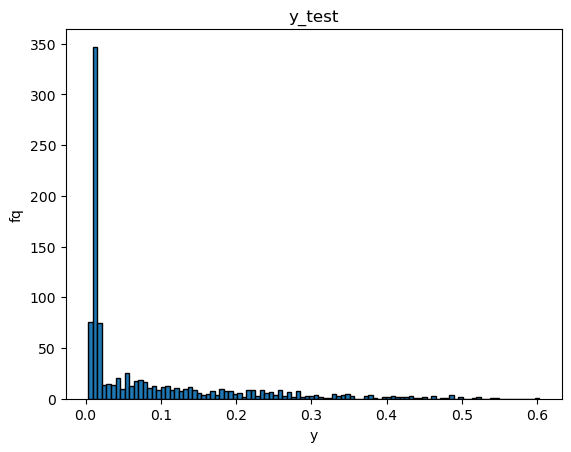

Epoch 0, Loss: 0.3312
Epoch 10, Loss: 0.2967
Epoch 20, Loss: 0.2867
Epoch 30, Loss: 0.2847
Epoch 40, Loss: 0.2655
Epoch 50, Loss: 0.2537
Epoch 60, Loss: 0.2110
Epoch 70, Loss: 0.2013
Epoch 80, Loss: 0.1532
Epoch 90, Loss: 0.1226
Epoch 100, Loss: 0.1074
Epoch 110, Loss: 0.0910
Epoch 120, Loss: 0.0848
Epoch 130, Loss: 0.0711
Epoch 140, Loss: 0.0520
Test GNN RMSE Loss: 0.0355
Test GNN pearson:  tensor(0.9678)
Test GNN spearman:  0.8658537051829809
Test GNN auc:  0.9922526315789474
Started with allocation.
Selected top 50 nodes based on baseline predictions: [882, 59, 13, 277, 715, 23, 631, 176, 25, 966], ...
Selected top 50 nodes based on baseline predictions: [754, 69, 456, 514, 144, 3, 53, 792, 875, 659], ...
u:  0.49570925365783036
b:  -6
b_xy*u_N:  1.6108648
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5108153352817837


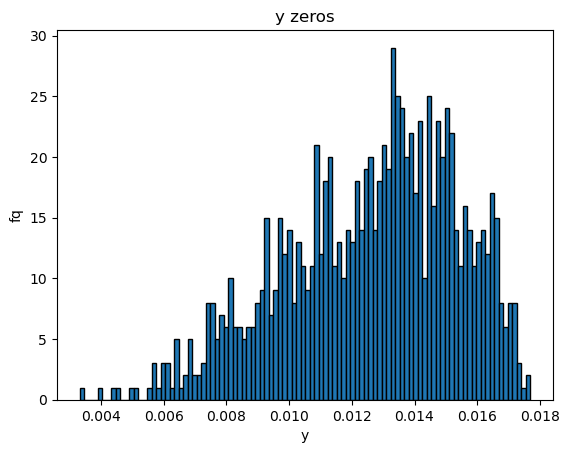

y_zero sum:  12.604231562285364
u:  0.49570925365783036
b:  -6
b_xy*u_N:  1.6103168
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5108153352817837


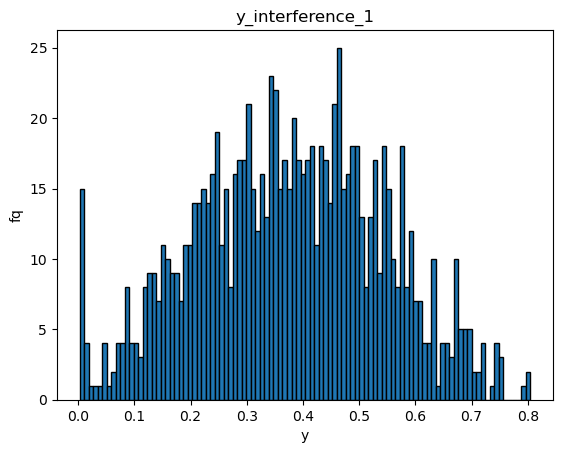

y_interference_1 sum:  22.972206873839184
The score for greedy interference is 376.2133.
u:  0.49570925365783036
b:  -6
b_xy*u_N:  1.610785
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5108153352817837


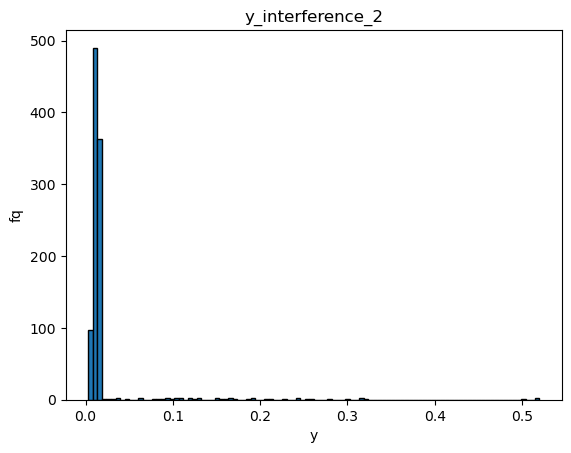

y_interference_2 sum:  20.324278342831047
The score for greedy contagion is 370.0064.
The score for zero is 338.16499999999996.
starting iteration:  6


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.010757589339258836
Pearson with predicted edge probs:  tensor(0.9973)
Spearman with predicted edge probs:  0.9976149490058015
Auc with predicted edge probs:  0.9993594908985723
Rmse of predicted edge probs:  0.04797706154953698
Pearson of predicted edge probs:  tensor(0.3787)
Spearman of predicted edge probs:  0.30504073645358054
Start gnn training.
u:  0.5041709101605467
b:  -6
b_xy*u_N:  1.5113224
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4740626655629283
u:  0.5078064194093787
b:  -6
b_xy*u_N:  1.6548835999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5206786618017984


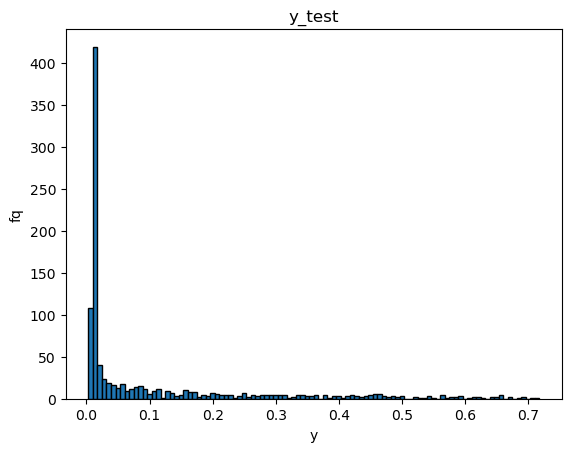

Epoch 0, Loss: 0.4089
Epoch 10, Loss: 0.3603
Epoch 20, Loss: 0.3431
Epoch 30, Loss: 0.3067
Epoch 40, Loss: 0.2449
Epoch 50, Loss: 0.1812
Epoch 60, Loss: 0.1205
Epoch 70, Loss: 0.1009
Epoch 80, Loss: 0.1222
Epoch 90, Loss: 0.0814
Epoch 100, Loss: 0.0926
Epoch 110, Loss: 0.0862
Epoch 120, Loss: 0.0721
Epoch 130, Loss: 0.0765
Epoch 140, Loss: 0.0563
Test GNN RMSE Loss: 0.0522
Test GNN pearson:  tensor(0.9807)
Test GNN spearman:  0.888479419104324
Test GNN auc:  0.9951368421052632
Started with allocation.
Selected top 50 nodes based on baseline predictions: [299, 554, 724, 997, 371, 361, 942, 266, 832, 287], ...
Selected top 50 nodes based on baseline predictions: [57, 380, 981, 582, 281, 364, 258, 785, 405, 872], ...
u:  0.49366192843738055
b:  -6
b_xy*u_N:  1.6327252
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4627706803158285


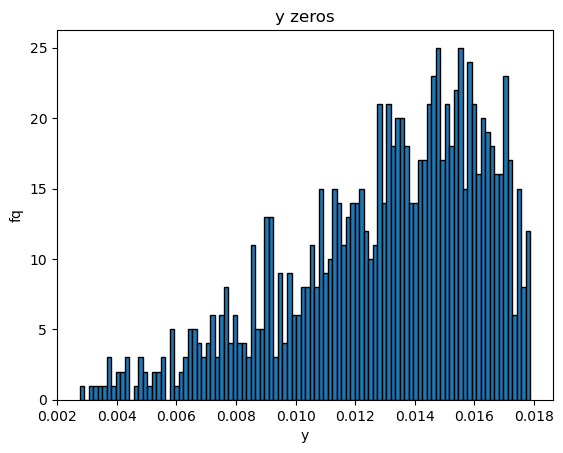

y_zero sum:  13.043420414625825
u:  0.49366192843738055
b:  -6
b_xy*u_N:  1.6324454000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4627706803158285


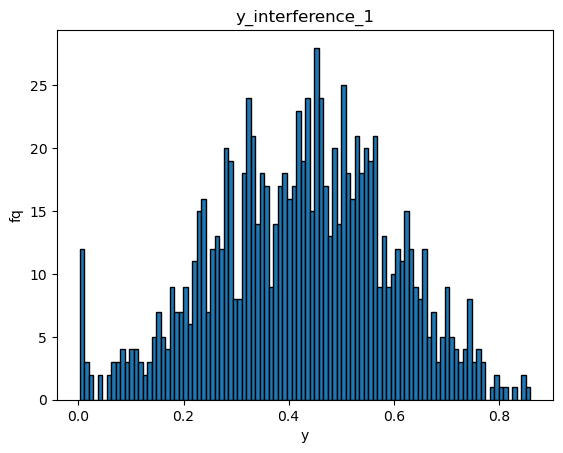

y_interference_1 sum:  21.60926855558437
The score for greedy interference is 424.3443.
u:  0.49366192843738055
b:  -6
b_xy*u_N:  1.6327946000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4627706803158285


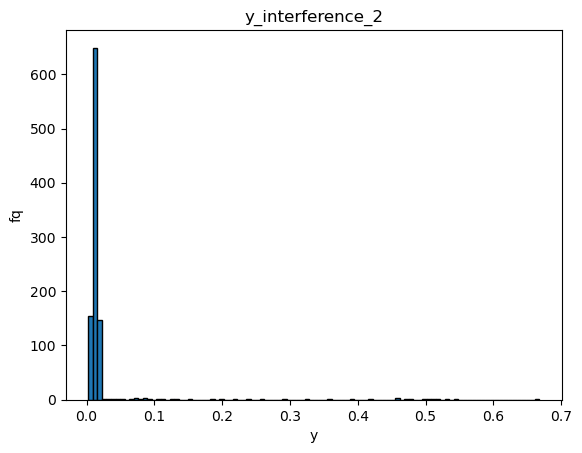

y_interference_2 sum:  25.08064831237082
The score for greedy contagion is 430.65379999999993.
The score for zero is 401.8243.
starting iteration:  7


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.025050016425205532
Pearson with predicted edge probs:  tensor(0.9525)
Spearman with predicted edge probs:  0.8454672249707536
Auc with predicted edge probs:  0.9615789473684211
Rmse of predicted edge probs:  0.08414084806386128
Pearson of predicted edge probs:  tensor(0.0282)
Spearman of predicted edge probs:  0.02498651289747767
Start gnn training.
u:  0.49617555273866737
b:  -6
b_xy*u_N:  1.5072576
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.509493185152956
u:  0.49644000553642637
b:  -6
b_xy*u_N:  1.5917912
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.520582581004186


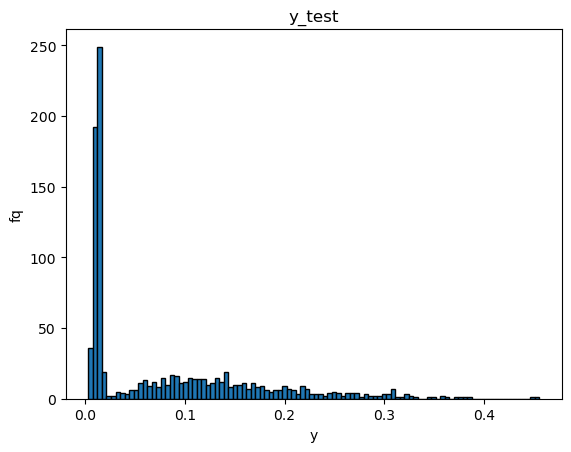

Epoch 0, Loss: 0.2888
Epoch 10, Loss: 0.2510
Epoch 20, Loss: 0.2407
Epoch 30, Loss: 0.2034
Epoch 40, Loss: 0.1628
Epoch 50, Loss: 0.1111
Epoch 60, Loss: 0.0834
Epoch 70, Loss: 0.0647
Epoch 80, Loss: 0.0591
Epoch 90, Loss: 0.0491
Epoch 100, Loss: 0.0435
Epoch 110, Loss: 0.0500
Epoch 120, Loss: 0.0441
Epoch 130, Loss: 0.0457
Epoch 140, Loss: 0.0439
Test GNN RMSE Loss: 0.0328
Test GNN pearson:  tensor(0.9664)
Test GNN spearman:  0.9315666489970517
Test GNN auc:  0.9866315789473684
Started with allocation.
Selected top 50 nodes based on baseline predictions: [519, 638, 750, 610, 49, 507, 361, 126, 5, 327], ...
Selected top 50 nodes based on baseline predictions: [120, 674, 626, 571, 979, 890, 898, 558, 706, 204], ...
u:  0.489351026101848
b:  -6
b_xy*u_N:  1.5667004000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4995704349546375


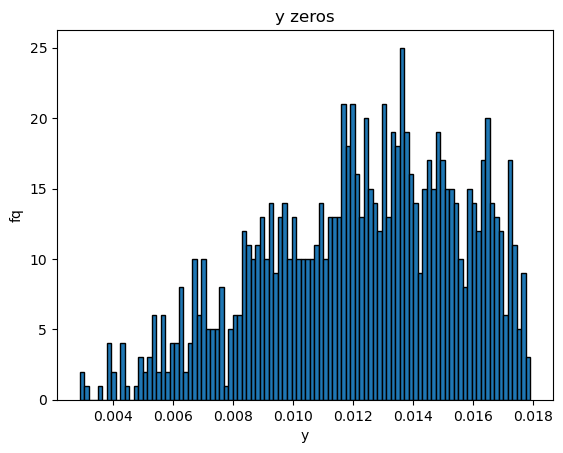

y_zero sum:  12.265958573348287
u:  0.489351026101848
b:  -6
b_xy*u_N:  1.566571
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4995704349546375


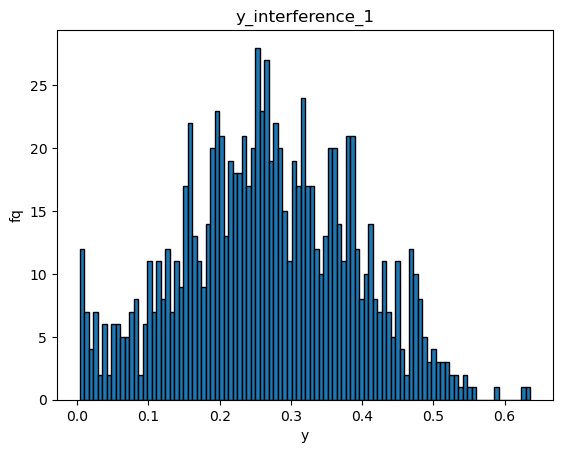

y_interference_1 sum:  15.611859653415983
The score for greedy interference is 268.4514.
u:  0.489351026101848
b:  -6
b_xy*u_N:  1.5664456
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4995704349546375


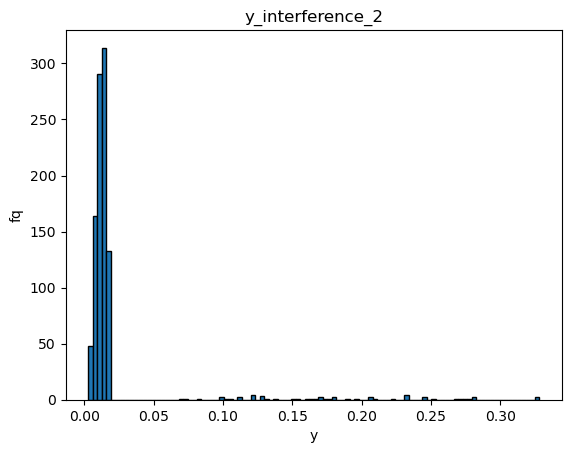

y_interference_2 sum:  20.530477000164836
The score for greedy contagion is 305.53139999999996.
The score for zero is 253.78969999999998.
starting iteration:  8


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.007188125421090892
Pearson with predicted edge probs:  tensor(0.9922)
Spearman with predicted edge probs:  0.9587397380666687
Auc with predicted edge probs:  0.9995368421052632
Rmse of predicted edge probs:  0.03850668264375311
Pearson of predicted edge probs:  tensor(0.0118)
Spearman of predicted edge probs:  -0.005719199736786396
Start gnn training.
u:  0.4957533141107763
b:  -6
b_xy*u_N:  1.3976406000000001
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5208434224472267
u:  0.5047046257514219
b:  -6
b_xy*u_N:  1.4705439999999999
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4955616379295433


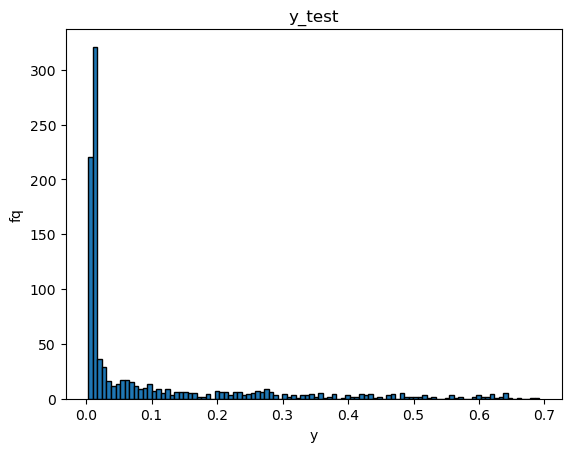

Epoch 0, Loss: 0.4232
Epoch 10, Loss: 0.3498
Epoch 20, Loss: 0.3365
Epoch 30, Loss: 0.3091
Epoch 40, Loss: 0.2702
Epoch 50, Loss: 0.2243
Epoch 60, Loss: 0.1815
Epoch 70, Loss: 0.1455
Epoch 80, Loss: 0.1133
Epoch 90, Loss: 0.1022
Epoch 100, Loss: 0.0666
Epoch 110, Loss: 0.0979
Epoch 120, Loss: 0.0807
Epoch 130, Loss: 0.0946
Epoch 140, Loss: 0.0715
Test GNN RMSE Loss: 0.0755
Test GNN pearson:  tensor(0.9499)
Test GNN spearman:  0.7832404183331734
Test GNN auc:  0.9901473684210527
Started with allocation.
Selected top 50 nodes based on baseline predictions: [573, 260, 444, 963, 282, 429, 302, 570, 671, 269], ...
Selected top 50 nodes based on baseline predictions: [573, 852, 505, 650, 557, 183, 218, 451, 966, 333], ...
u:  0.49657297201968936
b:  -6
b_xy*u_N:  1.4621772000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5018527159731847


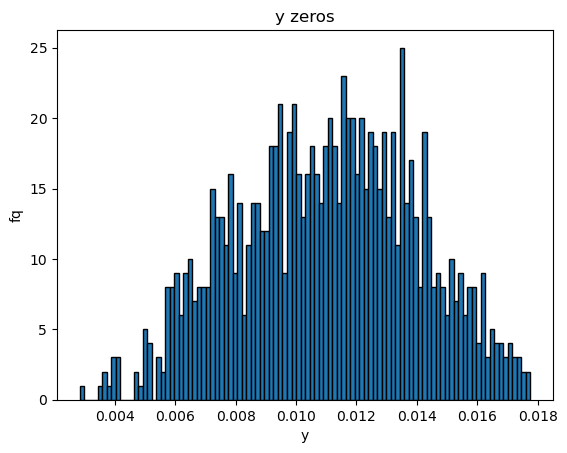

y_zero sum:  11.026461654039013
u:  0.49657297201968936
b:  -6
b_xy*u_N:  1.4620062
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5018527159731847


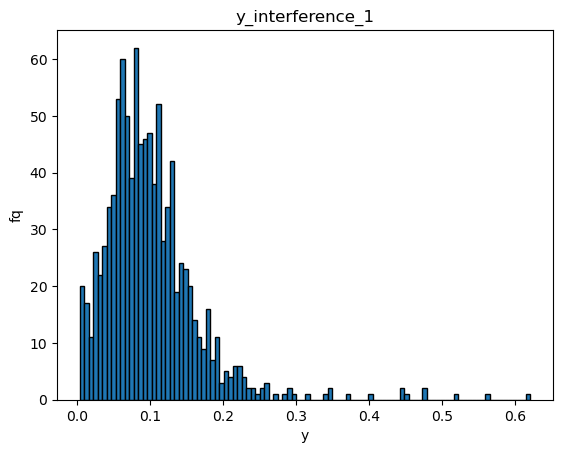

y_interference_1 sum:  19.352020022377076
The score for greedy interference is 100.0305.
u:  0.49657297201968936
b:  -6
b_xy*u_N:  1.462412
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5018527159731847


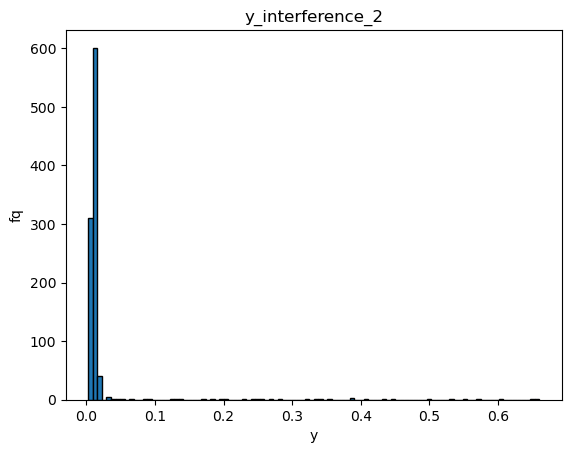

y_interference_2 sum:  23.3415912156692
The score for greedy contagion is 147.9352.
The score for zero is 66.46340000000001.
starting iteration:  9


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.010457098674124853
Pearson with predicted edge probs:  tensor(0.9928)
Spearman with predicted edge probs:  0.9906792871021606
Auc with predicted edge probs:  0.9982947368421052
Rmse of predicted edge probs:  0.07631846834883961
Pearson of predicted edge probs:  tensor(0.1246)
Spearman of predicted edge probs:  0.11767230334046384
Start gnn training.
u:  0.5045158173287536
b:  -6
b_xy*u_N:  1.6267708
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5208472917628706
u:  0.5001008688067887
b:  -6
b_xy*u_N:  1.5638
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5312466321545073


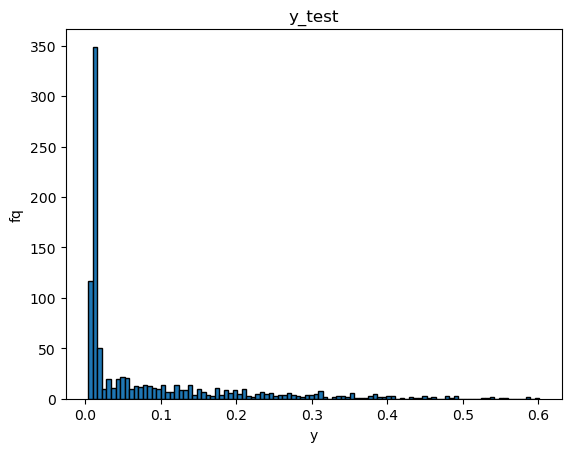

Epoch 0, Loss: 0.3515
Epoch 10, Loss: 0.2853
Epoch 20, Loss: 0.2719
Epoch 30, Loss: 0.2603
Epoch 40, Loss: 0.2190
Epoch 50, Loss: 0.1657
Epoch 60, Loss: 0.1231
Epoch 70, Loss: 0.0843
Epoch 80, Loss: 0.0699
Epoch 90, Loss: 0.0746
Epoch 100, Loss: 0.0507
Epoch 110, Loss: 0.0669
Epoch 120, Loss: 0.0515
Epoch 130, Loss: 0.0497
Epoch 140, Loss: 0.0476
Test GNN RMSE Loss: 0.0346
Test GNN pearson:  tensor(0.9582)
Test GNN spearman:  0.8975276409199661
Test GNN auc:  0.9888842105263158
Started with allocation.
Selected top 50 nodes based on baseline predictions: [159, 114, 729, 708, 150, 271, 356, 266, 569, 335], ...
Selected top 50 nodes based on baseline predictions: [817, 159, 599, 778, 378, 736, 729, 687, 824, 78], ...
u:  0.5017454260281135
b:  -6
b_xy*u_N:  1.5560138000000001
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.514438411705002


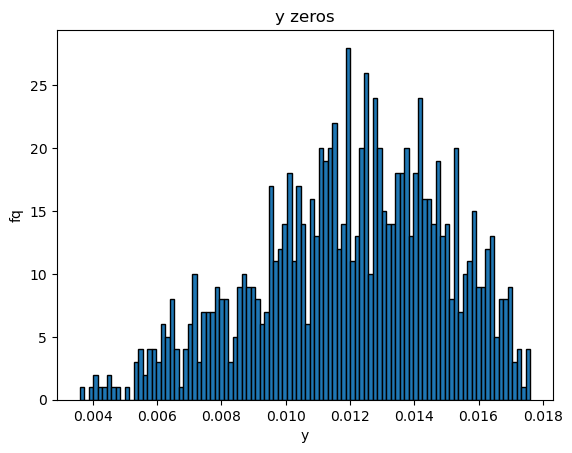

y_zero sum:  12.019599045519056
u:  0.5017454260281135
b:  -6
b_xy*u_N:  1.5561192000000001
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.514438411705002


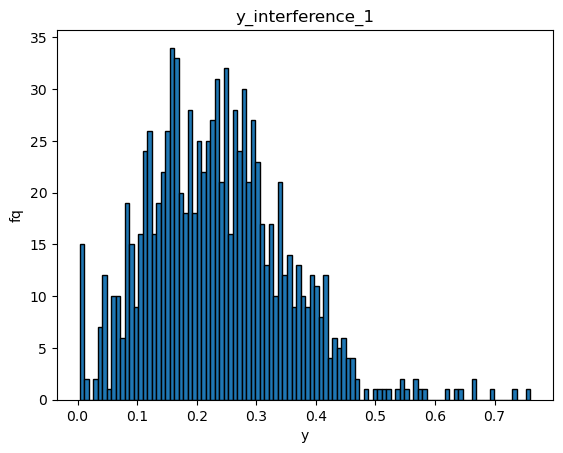

y_interference_1 sum:  25.372363612861953
The score for greedy interference is 234.6752.
u:  0.5017454260281135
b:  -6
b_xy*u_N:  1.5558530000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.514438411705002


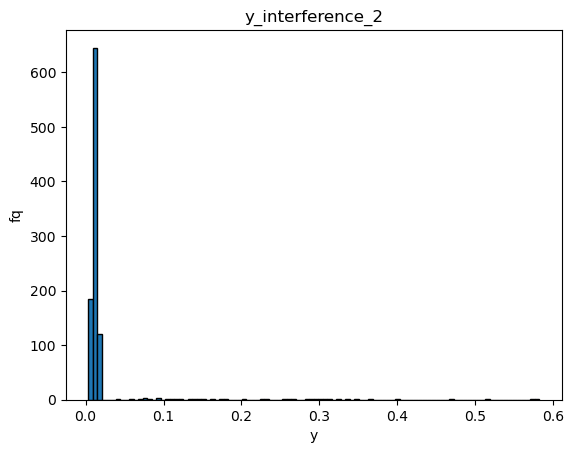

y_interference_2 sum:  22.435601926287845
The score for greedy contagion is 245.77050000000003.
The score for zero is 172.1722.
starting iteration:  10


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.010310425630445697
Pearson with predicted edge probs:  tensor(0.9941)
Spearman with predicted edge probs:  0.9924177542043972
Auc with predicted edge probs:  0.999621052631579
Rmse of predicted edge probs:  0.07783544346259089
Pearson of predicted edge probs:  tensor(0.1401)
Spearman of predicted edge probs:  0.12918221899245486
Start gnn training.
u:  0.5012512439627589
b:  -6
b_xy*u_N:  1.5286774
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.535022892373743
u:  0.510599605307788
b:  -6
b_xy*u_N:  1.5691943999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.466404481711706


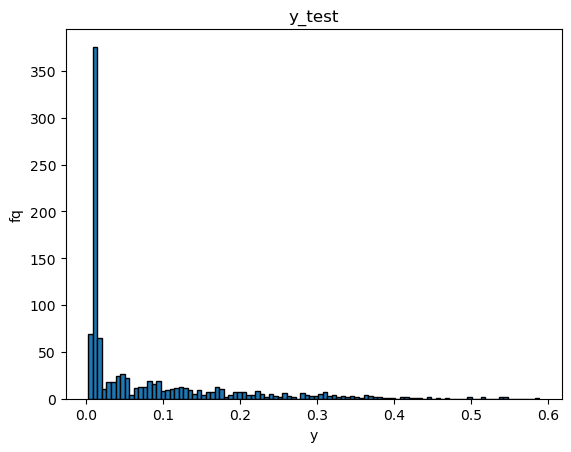

Epoch 0, Loss: 0.3450
Epoch 10, Loss: 0.2901
Epoch 20, Loss: 0.2790
Epoch 30, Loss: 0.2693
Epoch 40, Loss: 0.2447
Epoch 50, Loss: 0.2109
Epoch 60, Loss: 0.1348
Epoch 70, Loss: 0.1078
Epoch 80, Loss: 0.0671
Epoch 90, Loss: 0.0450
Epoch 100, Loss: 0.0530
Epoch 110, Loss: 0.0393
Epoch 120, Loss: 0.0435
Epoch 130, Loss: 0.0411
Epoch 140, Loss: 0.0364
Test GNN RMSE Loss: 0.0387
Test GNN pearson:  tensor(0.9385)
Test GNN spearman:  0.8712615127231789
Test GNN auc:  0.9710526315789473
Started with allocation.
Selected top 50 nodes based on baseline predictions: [696, 681, 893, 498, 812, 18, 940, 777, 259, 3], ...
Selected top 50 nodes based on baseline predictions: [440, 307, 249, 364, 711, 919, 178, 696, 700, 273], ...
u:  0.5057958695249749
b:  -6
b_xy*u_N:  1.555138
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.449031165326799


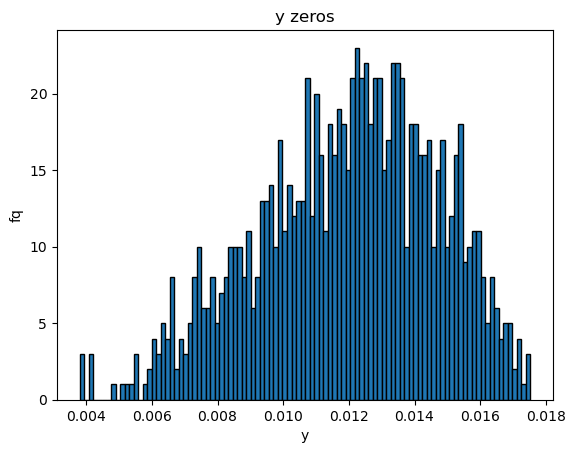

y_zero sum:  11.956173937882427
u:  0.5057958695249749
b:  -6
b_xy*u_N:  1.5545316
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.449031165326799


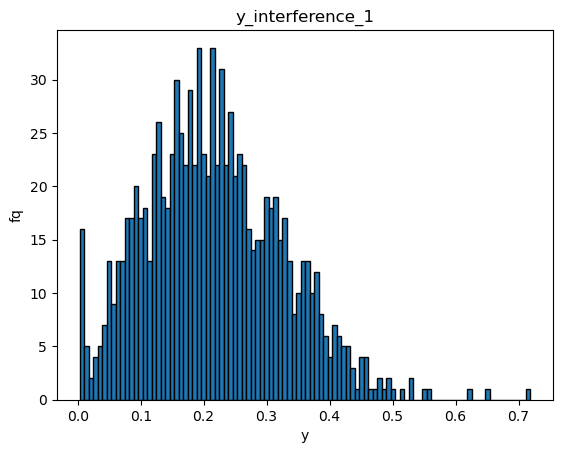

y_interference_1 sum:  24.052294785276555
The score for greedy interference is 216.4468.
u:  0.5057958695249749
b:  -6
b_xy*u_N:  1.5546271999999999
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.449031165326799


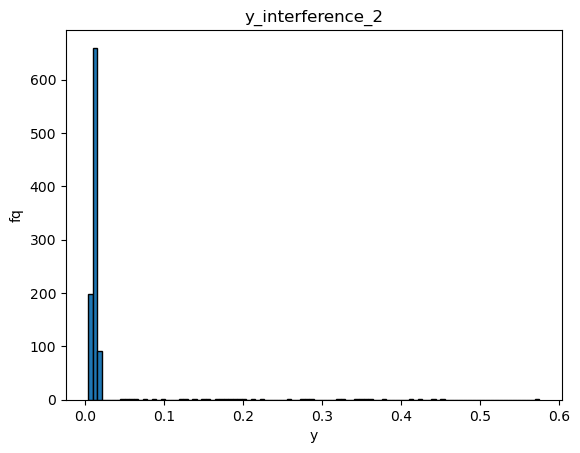

y_interference_2 sum:  22.745872640691843
The score for greedy contagion is 232.7694.
The score for zero is 154.44459999999998.
starting iteration:  11


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.010865965451827077
Pearson with predicted edge probs:  tensor(0.9948)
Spearman with predicted edge probs:  0.9953191294262518
Auc with predicted edge probs:  0.9990315789473684
Rmse of predicted edge probs:  0.06932055611655201
Pearson of predicted edge probs:  tensor(0.2126)
Spearman of predicted edge probs:  0.1684745216435129
Start gnn training.
u:  0.5022616848926829
b:  -6
b_xy*u_N:  1.5668309999999999
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5168626805223053
u:  0.501783695582852
b:  -6
b_xy*u_N:  1.5785808
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4442754656542056


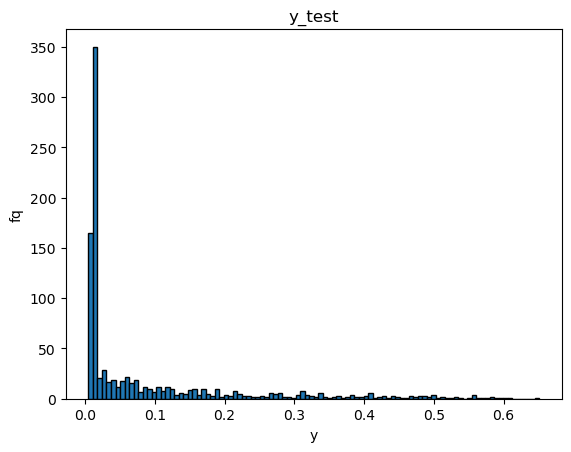

Epoch 0, Loss: 0.3804
Epoch 10, Loss: 0.3005
Epoch 20, Loss: 0.2918
Epoch 30, Loss: 0.2811
Epoch 40, Loss: 0.2572
Epoch 50, Loss: 0.2168
Epoch 60, Loss: 0.1360
Epoch 70, Loss: 0.1116
Epoch 80, Loss: 0.0756
Epoch 90, Loss: 0.0642
Epoch 100, Loss: 0.0738
Epoch 110, Loss: 0.0594
Epoch 120, Loss: 0.0630
Epoch 130, Loss: 0.0552
Epoch 140, Loss: 0.0598
Test GNN RMSE Loss: 0.0380
Test GNN pearson:  tensor(0.9671)
Test GNN spearman:  0.8801239291773185
Test GNN auc:  0.9974315789473684
Started with allocation.
Selected top 50 nodes based on baseline predictions: [971, 429, 359, 21, 101, 173, 942, 605, 773, 397], ...
Selected top 50 nodes based on baseline predictions: [452, 850, 391, 903, 331, 822, 984, 339, 381, 13], ...
u:  0.504804000871897
b:  -6
b_xy*u_N:  1.5832271999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.569617086940045


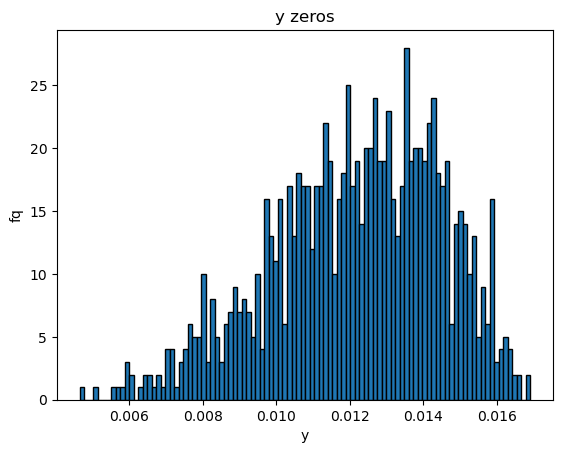

y_zero sum:  12.172460535834542
u:  0.504804000871897
b:  -6
b_xy*u_N:  1.5828416
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.569617086940045


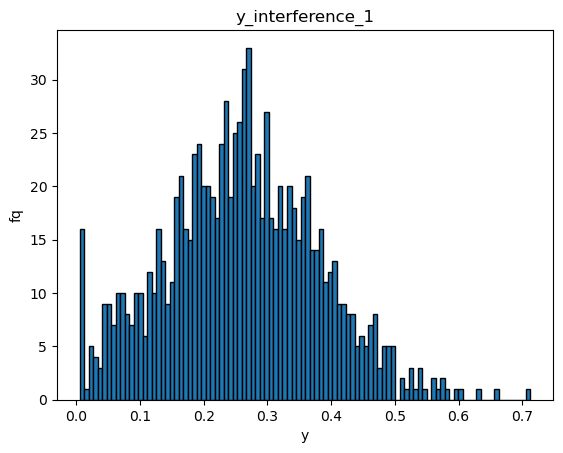

y_interference_1 sum:  18.096385202690378
The score for greedy interference is 259.8133.
u:  0.504804000871897
b:  -6
b_xy*u_N:  1.5831478
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.569617086940045


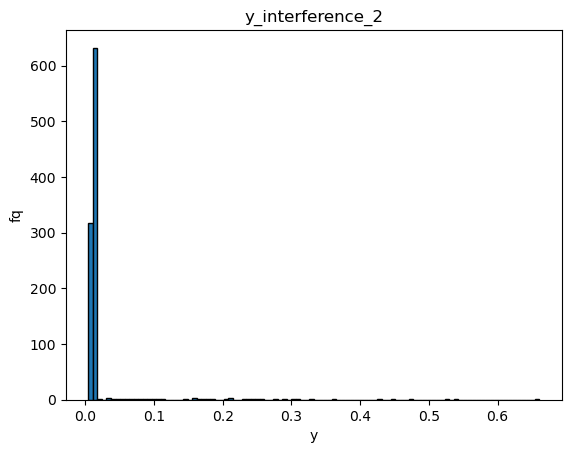

y_interference_2 sum:  21.598169992951348
The score for greedy contagion is 282.37789999999995.
The score for zero is 219.51919999999998.
starting iteration:  12


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.011390920459049499
Pearson with predicted edge probs:  tensor(0.9962)
Spearman with predicted edge probs:  0.996577741395348
Auc with predicted edge probs:  0.9984210526315789
Rmse of predicted edge probs:  0.05460407075102759
Pearson of predicted edge probs:  tensor(0.2553)
Spearman of predicted edge probs:  0.1487014357802065
Start gnn training.
u:  0.4918827971456324
b:  -6
b_xy*u_N:  1.6340932000000004
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4727476552778316
u:  0.5076295965701663
b:  -6
b_xy*u_N:  1.6318690000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.522999029084628


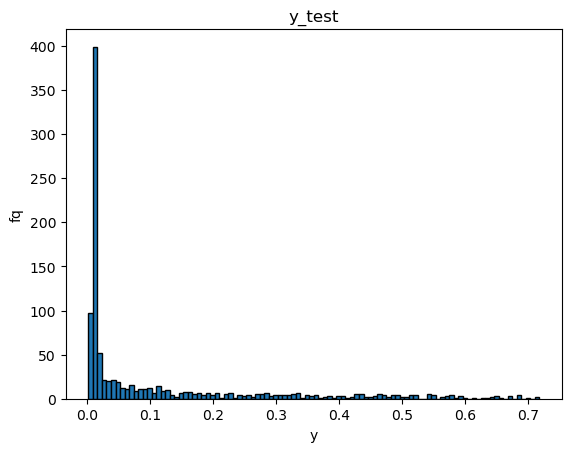

Epoch 0, Loss: 0.3988
Epoch 10, Loss: 0.3455
Epoch 20, Loss: 0.3276
Epoch 30, Loss: 0.3058
Epoch 40, Loss: 0.2645
Epoch 50, Loss: 0.2010
Epoch 60, Loss: 0.1322
Epoch 70, Loss: 0.1065
Epoch 80, Loss: 0.0915
Epoch 90, Loss: 0.0725
Epoch 100, Loss: 0.0634
Epoch 110, Loss: 0.0789
Epoch 120, Loss: 0.0507
Epoch 130, Loss: 0.0575
Epoch 140, Loss: 0.0482
Test GNN RMSE Loss: 0.0495
Test GNN pearson:  tensor(0.9709)
Test GNN spearman:  0.7887110598643916
Test GNN auc:  0.9914736842105263
Started with allocation.
Selected top 50 nodes based on baseline predictions: [102, 389, 914, 672, 267, 120, 522, 368, 311, 680], ...
Selected top 50 nodes based on baseline predictions: [132, 893, 10, 940, 785, 793, 508, 634, 197, 719], ...
u:  0.5018948019807346
b:  -6
b_xy*u_N:  1.6308506
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4900206964524343


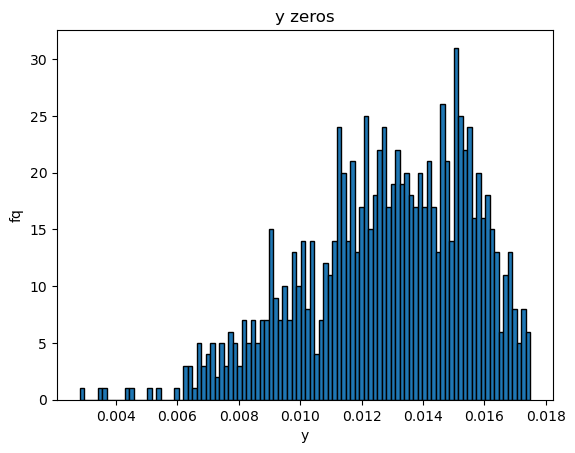

y_zero sum:  12.82824754714288
u:  0.5018948019807346
b:  -6
b_xy*u_N:  1.6307746000000003
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4900206964524343


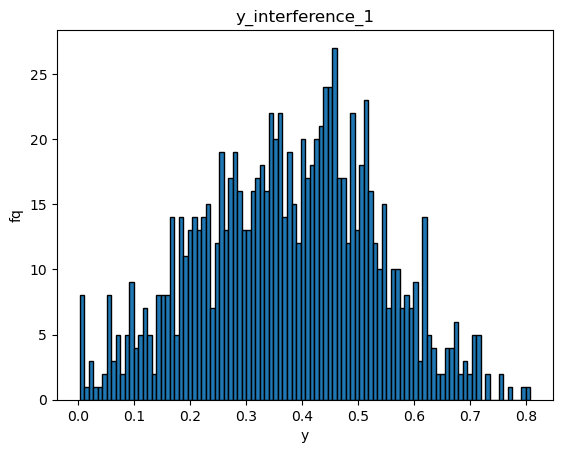

y_interference_1 sum:  26.969538774194838
The score for greedy interference is 375.4843.
u:  0.5018948019807346
b:  -6
b_xy*u_N:  1.6312741999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4900206964524343


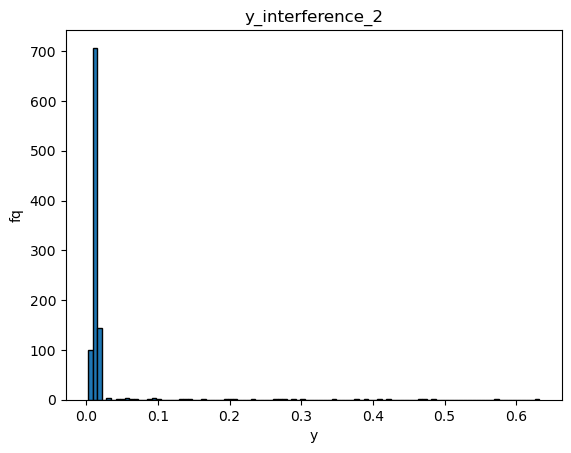

y_interference_2 sum:  22.54618112437662
The score for greedy contagion is 370.5167.
The score for zero is 331.6892.
starting iteration:  13


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.012430038117560781
Pearson with predicted edge probs:  tensor(0.9963)
Spearman with predicted edge probs:  0.9962527864855294
Auc with predicted edge probs:  0.9993052631578947
Rmse of predicted edge probs:  0.0628624035321184
Pearson of predicted edge probs:  tensor(0.2123)
Spearman of predicted edge probs:  0.15745599725453244
Start gnn training.
u:  0.49273494200600376
b:  -6
b_xy*u_N:  1.4667046000000001
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4486440443386406
u:  0.4964601269958819
b:  -6
b_xy*u_N:  1.5809514
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4546409237620015


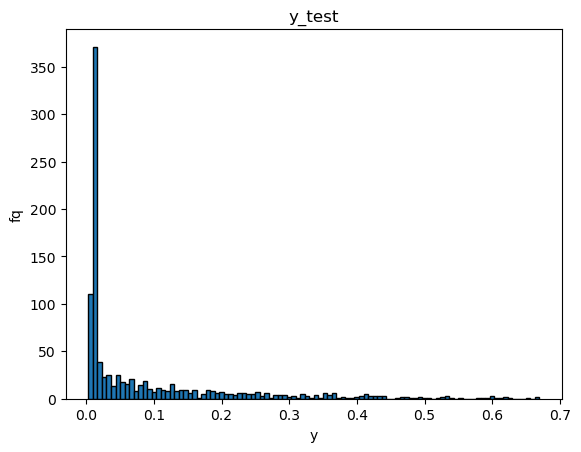

Epoch 0, Loss: 0.3804
Epoch 10, Loss: 0.3195
Epoch 20, Loss: 0.3036
Epoch 30, Loss: 0.2796
Epoch 40, Loss: 0.2375
Epoch 50, Loss: 0.1875
Epoch 60, Loss: 0.1290
Epoch 70, Loss: 0.1078
Epoch 80, Loss: 0.1216
Epoch 90, Loss: 0.0861
Epoch 100, Loss: 0.0781
Epoch 110, Loss: 0.0529
Epoch 120, Loss: 0.0632
Epoch 130, Loss: 0.0605
Epoch 140, Loss: 0.0527
Test GNN RMSE Loss: 0.0585
Test GNN pearson:  tensor(0.9681)
Test GNN spearman:  0.9147545532693703
Test GNN auc:  0.9927368421052631
Started with allocation.
Selected top 50 nodes based on baseline predictions: [397, 107, 926, 215, 223, 726, 809, 603, 703, 96], ...
Selected top 50 nodes based on baseline predictions: [13, 519, 105, 120, 68, 790, 346, 556, 124, 921], ...
u:  0.498716610954779
b:  -6
b_xy*u_N:  1.5846782000000001
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.511502990487824


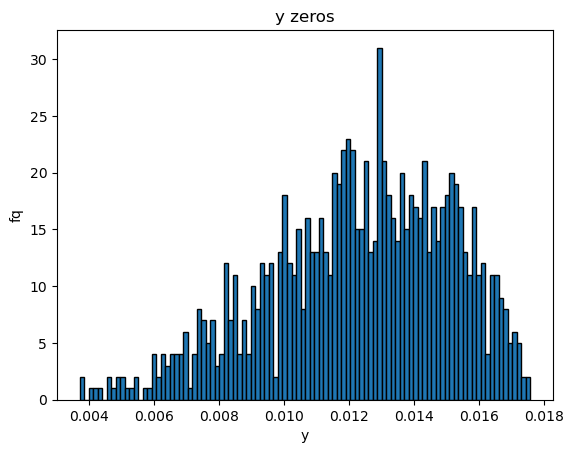

y_zero sum:  12.318407324510472
u:  0.498716610954779
b:  -6
b_xy*u_N:  1.5857388000000001
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.511502990487824


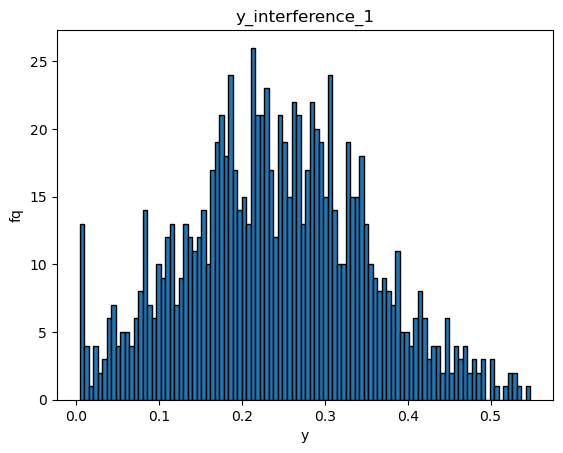

y_interference_1 sum:  15.0991342469395
The score for greedy interference is 241.4164.
u:  0.498716610954779
b:  -6
b_xy*u_N:  1.5855396
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.511502990487824


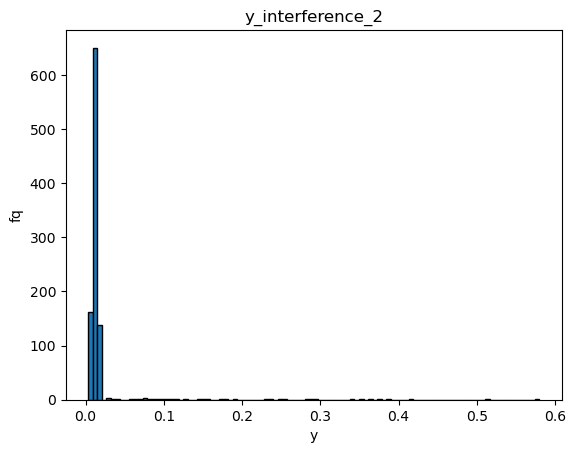

y_interference_2 sum:  20.481860290402036
The score for greedy contagion is 284.34099999999995.
The score for zero is 229.16680000000002.
starting iteration:  14


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.010760186231967004
Pearson with predicted edge probs:  tensor(0.9946)
Spearman with predicted edge probs:  0.9951327591047752
Auc with predicted edge probs:  0.9991789473684212
Rmse of predicted edge probs:  0.07741430801843895
Pearson of predicted edge probs:  tensor(0.1350)
Spearman of predicted edge probs:  0.12359560078069413
Start gnn training.
u:  0.4977945889898468
b:  -6
b_xy*u_N:  1.5914351999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.47127998632625
u:  0.4950158318445481
b:  -6
b_xy*u_N:  1.5449212
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5008949028194767


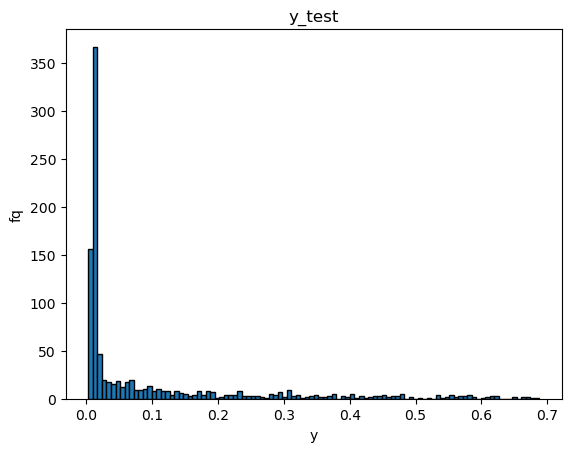

Epoch 0, Loss: 0.3904
Epoch 10, Loss: 0.3170
Epoch 20, Loss: 0.2940
Epoch 30, Loss: 0.2569
Epoch 40, Loss: 0.2002
Epoch 50, Loss: 0.1246
Epoch 60, Loss: 0.0976
Epoch 70, Loss: 0.0925
Epoch 80, Loss: 0.0876
Epoch 90, Loss: 0.0862
Epoch 100, Loss: 0.0678
Epoch 110, Loss: 0.0551
Epoch 120, Loss: 0.0760
Epoch 130, Loss: 0.0569
Epoch 140, Loss: 0.0585
Test GNN RMSE Loss: 0.0421
Test GNN pearson:  tensor(0.9829)
Test GNN spearman:  0.935156138514726
Test GNN auc:  0.9986736842105263
Started with allocation.
Selected top 50 nodes based on baseline predictions: [668, 468, 798, 473, 233, 286, 84, 926, 734, 67], ...
Selected top 50 nodes based on baseline predictions: [804, 646, 574, 60, 81, 994, 923, 534, 406, 978], ...
u:  0.4902397199008118
b:  -6
b_xy*u_N:  1.5504126
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4342462343851152


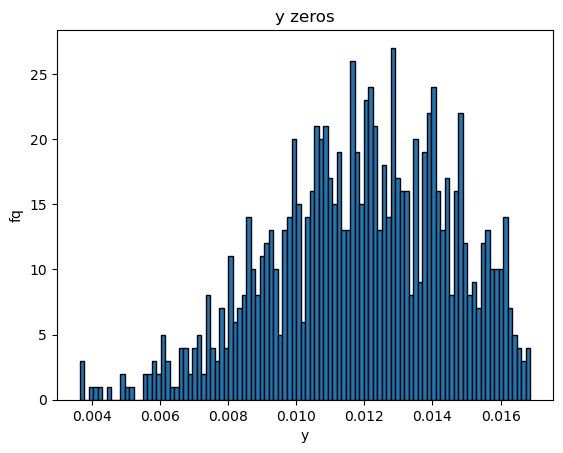

y_zero sum:  11.876454373956353
u:  0.4902397199008118
b:  -6
b_xy*u_N:  1.5504672000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4342462343851152


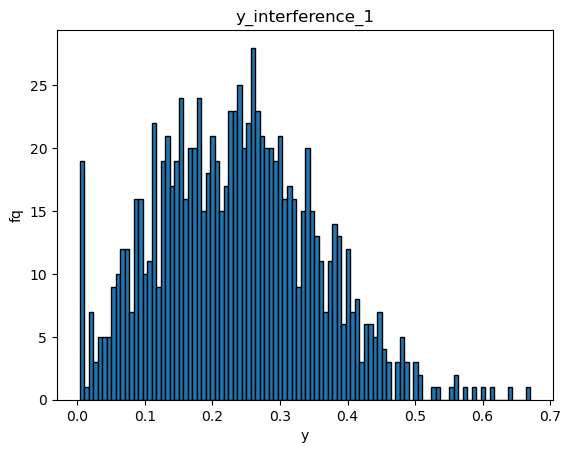

y_interference_1 sum:  22.041202050623387
The score for greedy interference is 235.1177.
u:  0.4902397199008118
b:  -6
b_xy*u_N:  1.5503866
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4342462343851152


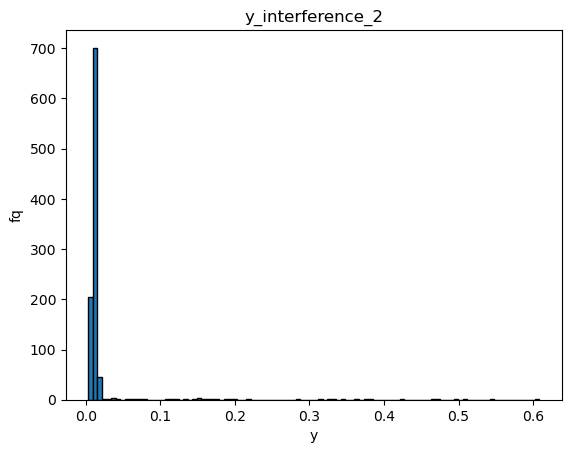

y_interference_2 sum:  21.59117094140265
The score for greedy contagion is 251.9288.
The score for zero is 179.67989999999998.
starting iteration:  15


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.006029327543780459
Pearson with predicted edge probs:  tensor(0.9925)
Spearman with predicted edge probs:  0.9666999445422054
Auc with predicted edge probs:  0.9992421052631579
Rmse of predicted edge probs:  0.035690738174692246
Pearson of predicted edge probs:  tensor(0.0359)
Spearman of predicted edge probs:  0.04633401191036278
Start gnn training.
u:  0.49749942570379757
b:  -6
b_xy*u_N:  1.4630524
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.473053828485984
u:  0.49895130387409875
b:  -6
b_xy*u_N:  1.5092568000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.469723721799674


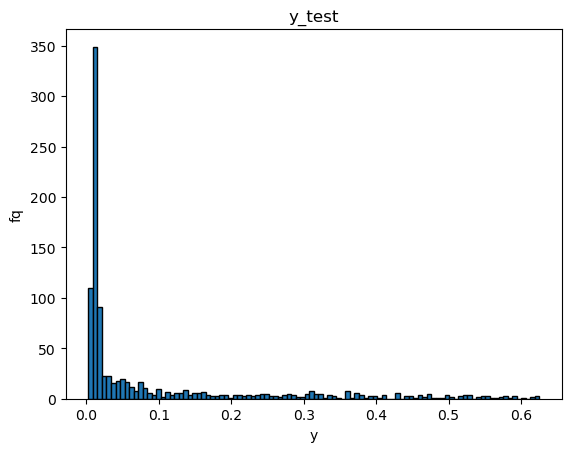

Epoch 0, Loss: 0.3844
Epoch 10, Loss: 0.3335
Epoch 20, Loss: 0.3247
Epoch 30, Loss: 0.3047
Epoch 40, Loss: 0.2913
Epoch 50, Loss: 0.2464
Epoch 60, Loss: 0.1966
Epoch 70, Loss: 0.1532
Epoch 80, Loss: 0.1288
Epoch 90, Loss: 0.1031
Epoch 100, Loss: 0.0889
Epoch 110, Loss: 0.0801
Epoch 120, Loss: 0.0663
Epoch 130, Loss: 0.0577
Epoch 140, Loss: 0.0576
Test GNN RMSE Loss: 0.0457
Test GNN pearson:  tensor(0.9608)
Test GNN spearman:  0.6875016916268677
Test GNN auc:  0.9889473684210526
Started with allocation.
Selected top 50 nodes based on baseline predictions: [921, 674, 230, 1, 281, 905, 969, 513, 733, 256], ...
Selected top 50 nodes based on baseline predictions: [921, 478, 684, 510, 121, 534, 466, 669, 545, 861], ...
u:  0.4975575326079246
b:  -6
b_xy*u_N:  1.5012923999999999
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.496035496044241


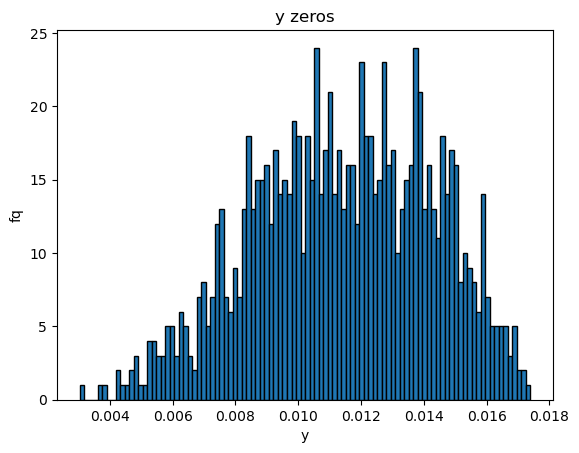

y_zero sum:  11.398832167544672
u:  0.4975575326079246
b:  -6
b_xy*u_N:  1.5006972
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.496035496044241


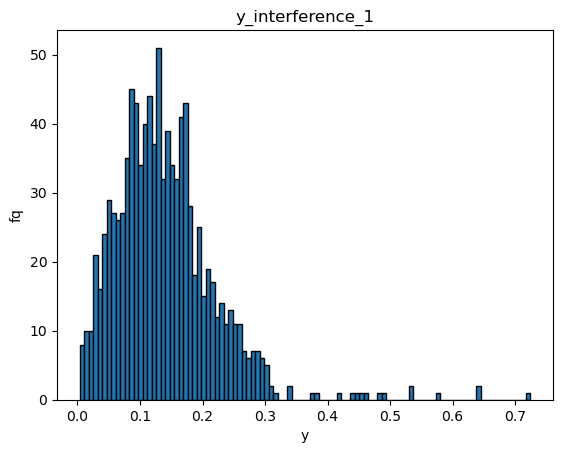

y_interference_1 sum:  20.050829964800997
The score for greedy interference is 139.6129.
u:  0.4975575326079246
b:  -6
b_xy*u_N:  1.5013828
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.496035496044241


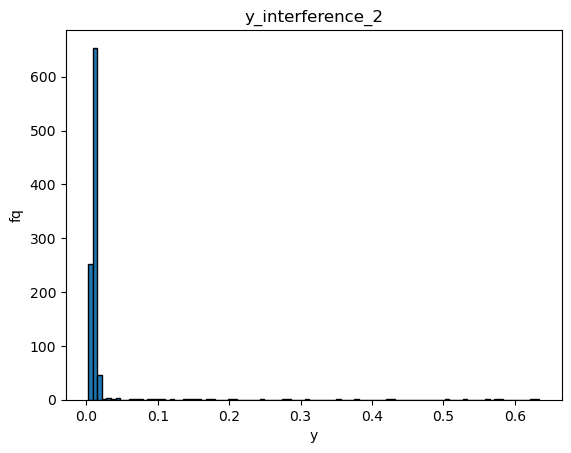

y_interference_2 sum:  21.228161023822377
The score for greedy contagion is 166.92219999999998.
The score for zero is 92.5799.
starting iteration:  16


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.011009773761068015
Pearson with predicted edge probs:  tensor(0.9955)
Spearman with predicted edge probs:  0.9954505414321978
Auc with predicted edge probs:  0.9991157894736842
Rmse of predicted edge probs:  0.0641605716848641
Pearson of predicted edge probs:  tensor(0.1981)
Spearman of predicted edge probs:  0.16763953365436257
Start gnn training.
u:  0.48691912195861087
b:  -6
b_xy*u_N:  1.6171198
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.518976778670376
u:  0.4957876124290685
b:  -6
b_xy*u_N:  1.5833926
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5174037953389137


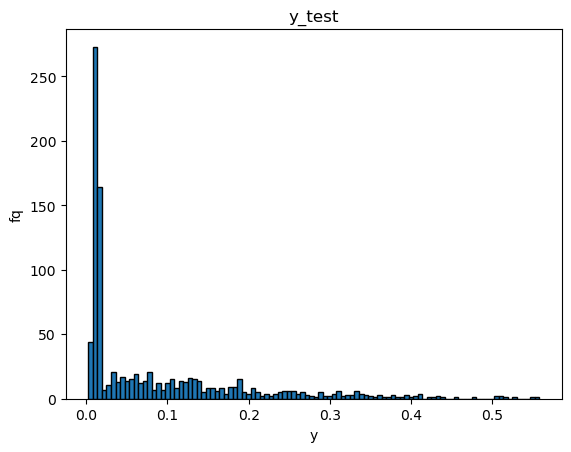

Epoch 0, Loss: 0.3348
Epoch 10, Loss: 0.2870
Epoch 20, Loss: 0.2782
Epoch 30, Loss: 0.2570
Epoch 40, Loss: 0.2290
Epoch 50, Loss: 0.2005
Epoch 60, Loss: 0.1592
Epoch 70, Loss: 0.1499
Epoch 80, Loss: 0.0921
Epoch 90, Loss: 0.0895
Epoch 100, Loss: 0.0910
Epoch 110, Loss: 0.0763
Epoch 120, Loss: 0.0741
Epoch 130, Loss: 0.0666
Epoch 140, Loss: 0.0745
Test GNN RMSE Loss: 0.0329
Test GNN pearson:  tensor(0.9653)
Test GNN spearman:  0.8710622093259436
Test GNN auc:  0.9929052631578947
Started with allocation.
Selected top 50 nodes based on baseline predictions: [923, 482, 335, 447, 2, 301, 920, 381, 913, 303], ...
Selected top 50 nodes based on baseline predictions: [166, 27, 942, 850, 335, 748, 522, 291, 2, 420], ...
u:  0.4903238181685409
b:  -6
b_xy*u_N:  1.5705790000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4988292733823894


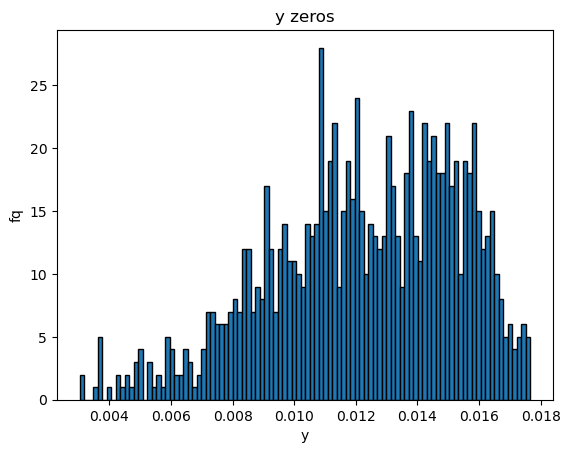

y_zero sum:  12.233706965382748
u:  0.4903238181685409
b:  -6
b_xy*u_N:  1.570757
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4988292733823894


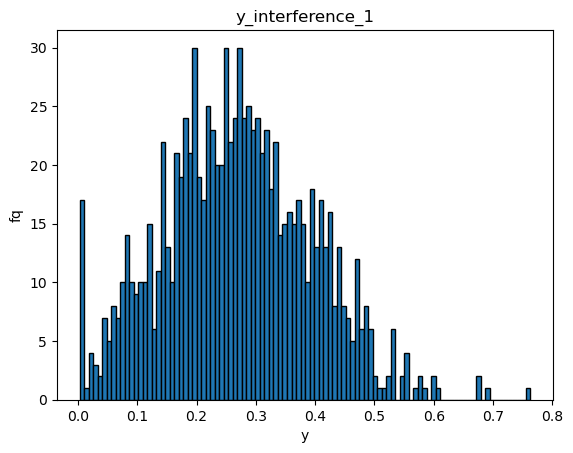

y_interference_1 sum:  19.70176984884114
The score for greedy interference is 268.6731.
u:  0.4903238181685409
b:  -6
b_xy*u_N:  1.57006
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4988292733823894


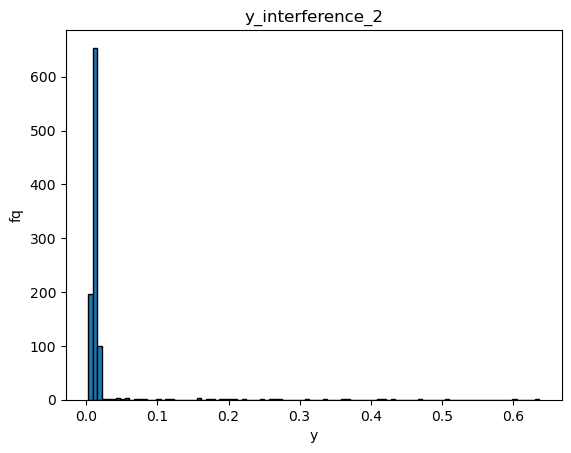

y_interference_2 sum:  21.943740658505753
The score for greedy contagion is 293.2702.
The score for zero is 225.77429999999998.
starting iteration:  17


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.008401024393674909
Pearson with predicted edge probs:  tensor(0.9947)
Spearman with predicted edge probs:  0.9709385887520363
Auc with predicted edge probs:  0.9994947368421053
Rmse of predicted edge probs:  0.034513611752395805
Pearson of predicted edge probs:  tensor(0.0412)
Spearman of predicted edge probs:  -0.013849324794824328
Start gnn training.
u:  0.49707589573859695
b:  -6
b_xy*u_N:  1.4789794000000003
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5149171522668756
u:  0.5034598958568006
b:  -6
b_xy*u_N:  1.4733222000000001
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5643663136228714


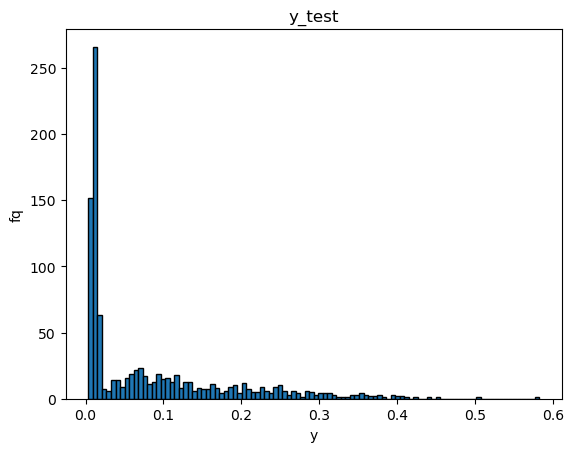

Epoch 0, Loss: 0.3187
Epoch 10, Loss: 0.2856
Epoch 20, Loss: 0.2679
Epoch 30, Loss: 0.2401
Epoch 40, Loss: 0.1798
Epoch 50, Loss: 0.1322
Epoch 60, Loss: 0.1103
Epoch 70, Loss: 0.0759
Epoch 80, Loss: 0.0640
Epoch 90, Loss: 0.0586
Epoch 100, Loss: 0.0587
Epoch 110, Loss: 0.0513
Epoch 120, Loss: 0.0529
Epoch 130, Loss: 0.0494
Epoch 140, Loss: 0.0436
Test GNN RMSE Loss: 0.0410
Test GNN pearson:  tensor(0.9512)
Test GNN spearman:  0.8745891270644762
Test GNN auc:  0.9739368421052632
Started with allocation.
Selected top 50 nodes based on baseline predictions: [602, 557, 848, 842, 189, 605, 937, 7, 335, 386], ...
Selected top 50 nodes based on baseline predictions: [10, 602, 412, 351, 639, 447, 920, 798, 503, 951], ...
u:  0.4963872704560104
b:  -6
b_xy*u_N:  1.4766298000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.525818489530745


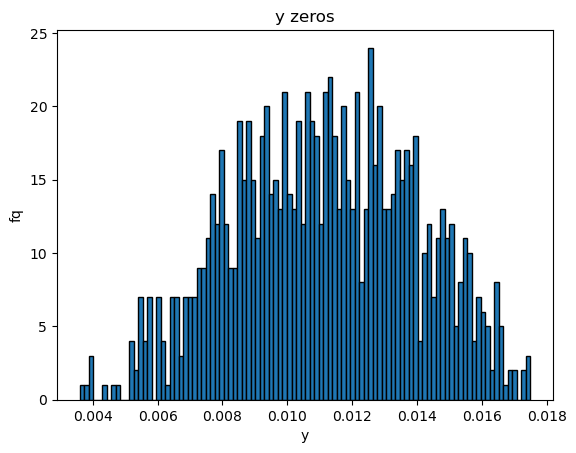

y_zero sum:  11.117527972477625
u:  0.4963872704560104
b:  -6
b_xy*u_N:  1.4767179999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.525818489530745


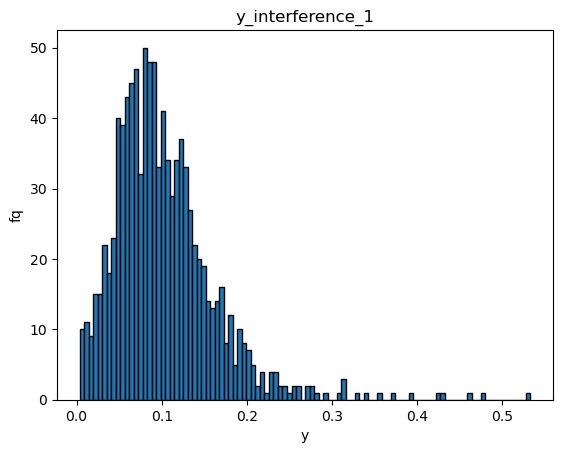

y_interference_1 sum:  19.239031398005817
The score for greedy interference is 102.818.
u:  0.4963872704560104
b:  -6
b_xy*u_N:  1.4766048
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.525818489530745


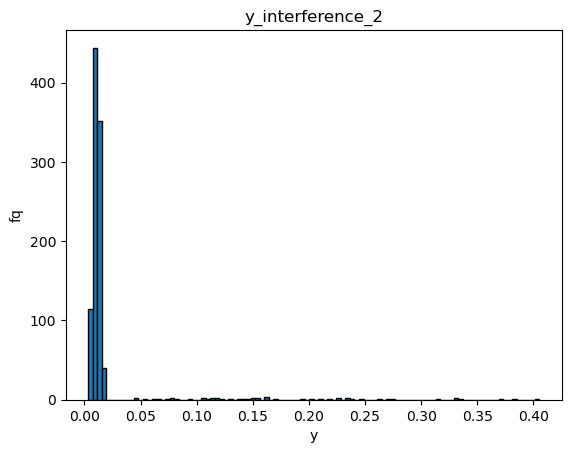

y_interference_2 sum:  19.35811032824342
The score for greedy contagion is 119.31360000000001.
The score for zero is 63.3484.
starting iteration:  18


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.006592509332760908
Pearson with predicted edge probs:  tensor(0.9951)
Spearman with predicted edge probs:  0.9782266876723492
Auc with predicted edge probs:  0.9992631578947369
Rmse of predicted edge probs:  0.036080194836933005
Pearson of predicted edge probs:  tensor(0.0289)
Spearman of predicted edge probs:  0.029602659341638783
Start gnn training.
u:  0.4939255911745296
b:  -6
b_xy*u_N:  1.547116
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5505964490341615
u:  0.4975057897377037
b:  -6
b_xy*u_N:  1.4571514
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5415672345067115


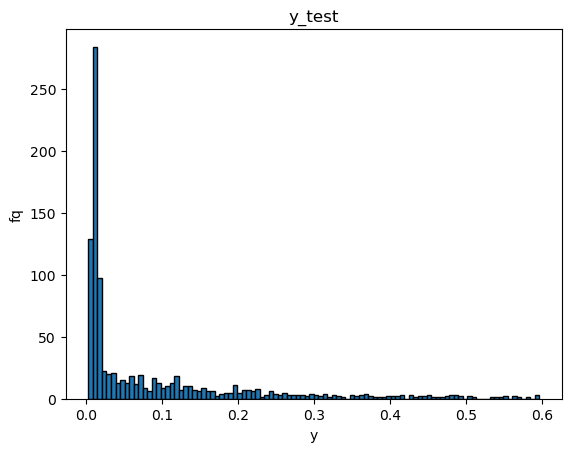

Epoch 0, Loss: 0.3559
Epoch 10, Loss: 0.2960
Epoch 20, Loss: 0.2820
Epoch 30, Loss: 0.2476
Epoch 40, Loss: 0.2001
Epoch 50, Loss: 0.1553
Epoch 60, Loss: 0.1116
Epoch 70, Loss: 0.0993
Epoch 80, Loss: 0.0873
Epoch 90, Loss: 0.0720
Epoch 100, Loss: 0.0923
Epoch 110, Loss: 0.0743
Epoch 120, Loss: 0.0879
Epoch 130, Loss: 0.0689
Epoch 140, Loss: 0.0655
Test GNN RMSE Loss: 0.0280
Test GNN pearson:  tensor(0.9755)
Test GNN spearman:  0.8459296312231998
Test GNN auc:  0.9965894736842105
Started with allocation.
Selected top 50 nodes based on baseline predictions: [994, 173, 592, 926, 373, 740, 292, 639, 851, 763], ...
Selected top 50 nodes based on baseline predictions: [187, 912, 73, 46, 822, 866, 712, 929, 547, 219], ...
u:  0.49887067103243954
b:  -6
b_xy*u_N:  1.4681022000000001
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5152676377507297


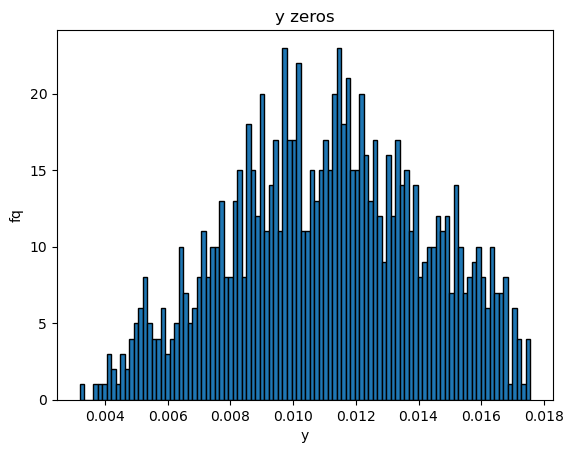

y_zero sum:  11.12151811562087
u:  0.49887067103243954
b:  -6
b_xy*u_N:  1.4685315999999997
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5152676377507297


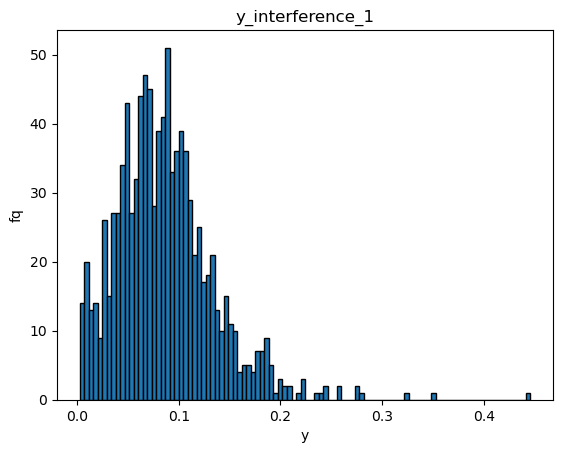

y_interference_1 sum:  14.669552455995225
The score for greedy interference is 86.3957.
u:  0.49887067103243954
b:  -6
b_xy*u_N:  1.4684342
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5152676377507297


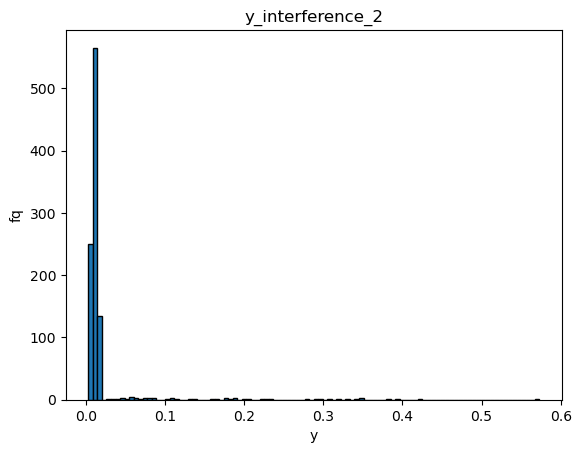

y_interference_2 sum:  19.22150881591079
The score for greedy contagion is 125.225.
The score for zero is 67.8711.
starting iteration:  19


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.007083754674235142
Pearson with predicted edge probs:  tensor(0.9933)
Spearman with predicted edge probs:  0.9702247213717095
Auc with predicted edge probs:  0.9941473684210527
Rmse of predicted edge probs:  0.030330087740103956
Pearson of predicted edge probs:  tensor(0.0522)
Spearman of predicted edge probs:  0.024163740502826884
Start gnn training.
u:  0.49982517160166123
b:  -6
b_xy*u_N:  1.492086
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.508333064696843
u:  0.508247831681089
b:  -6
b_xy*u_N:  1.4865533999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.488659291847436


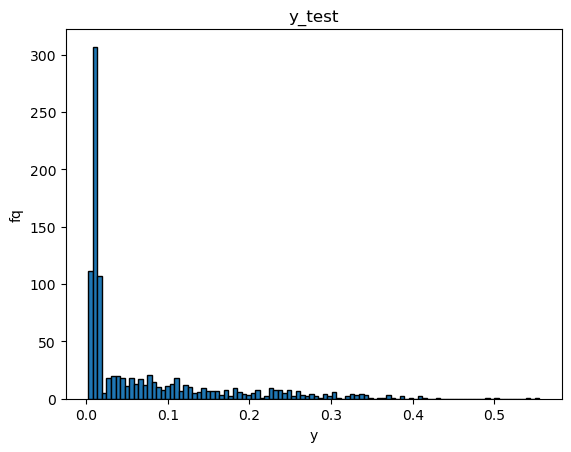

Epoch 0, Loss: 0.3489
Epoch 10, Loss: 0.2940
Epoch 20, Loss: 0.2806
Epoch 30, Loss: 0.2584
Epoch 40, Loss: 0.2209
Epoch 50, Loss: 0.1613
Epoch 60, Loss: 0.1237
Epoch 70, Loss: 0.0838
Epoch 80, Loss: 0.0798
Epoch 90, Loss: 0.0676
Epoch 100, Loss: 0.0561
Epoch 110, Loss: 0.0638
Epoch 120, Loss: 0.0555
Epoch 130, Loss: 0.0482
Epoch 140, Loss: 0.0523
Test GNN RMSE Loss: 0.0259
Test GNN pearson:  tensor(0.9634)
Test GNN spearman:  0.8091931490135936
Test GNN auc:  0.9823999999999999
Started with allocation.
Selected top 50 nodes based on baseline predictions: [209, 421, 857, 405, 437, 881, 506, 48, 99, 899], ...
Selected top 50 nodes based on baseline predictions: [663, 82, 432, 600, 158, 90, 812, 191, 186, 355], ...
u:  0.5029248951367908
b:  -6
b_xy*u_N:  1.4721152000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.532953459668431


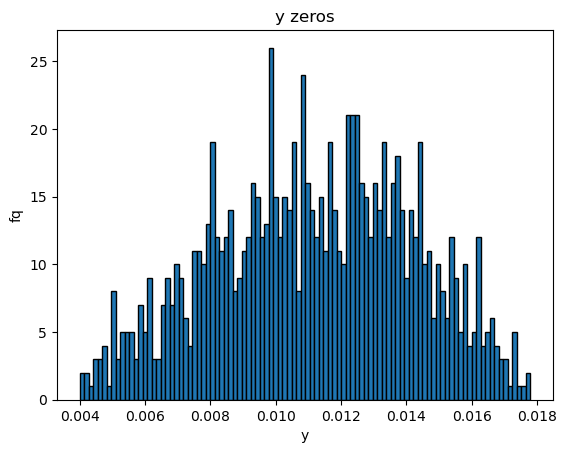

y_zero sum:  11.143588146761548
u:  0.5029248951367908
b:  -6
b_xy*u_N:  1.4722864
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.532953459668431


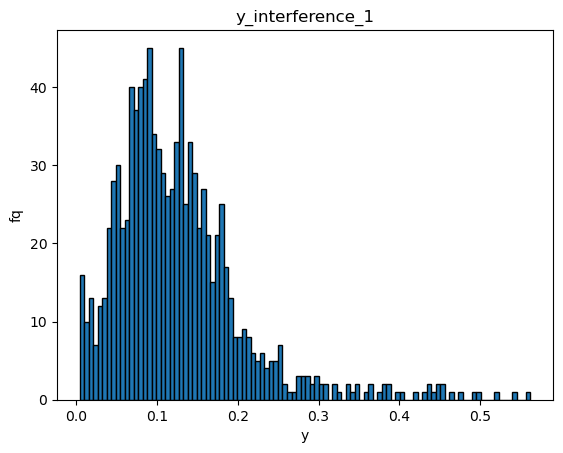

y_interference_1 sum:  24.90259586305928
The score for greedy interference is 125.2498.
u:  0.5029248951367908
b:  -6
b_xy*u_N:  1.4724146
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.532953459668431


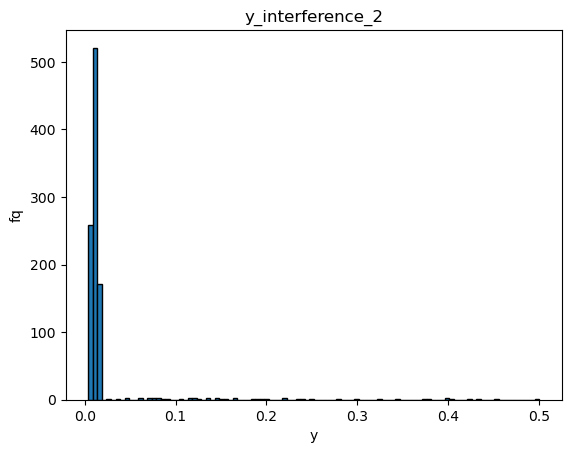

y_interference_2 sum:  20.21505153210037
The score for greedy contagion is 125.8198.
The score for zero is 65.862.
y_int:
 mean=231.70037499999998,
 ci_low=182.49170351633393,
 ci_high=280.90904648366603,
 std=102.48120449998076
pearson:
 mean=252.86390000000006,
 ci_low=209.41733524227314,
 ci_high=296.310464757727,
 std=90.481131750045
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
starting iteration:  0


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.03503989628264393
Pearson with predicted edge probs:  tensor(0.9626)
Spearman with predicted edge probs:  0.8671793052502731
Auc with predicted edge probs:  0.8131157894736842
Rmse of predicted edge probs:  0.6864851266690358
Pearson of predicted edge probs:  tensor(0.0736)
Spearman of predicted edge probs:  0.024531347333123413
Start gnn training.
u:  0.49721467463085106
b:  -8
b_xy*u_N:  1.7904031999999999
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.493405724182929
u:  0.5024122973422206
b:  -8
b_xy*u_N:  1.9170293999999999
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5020815916007497


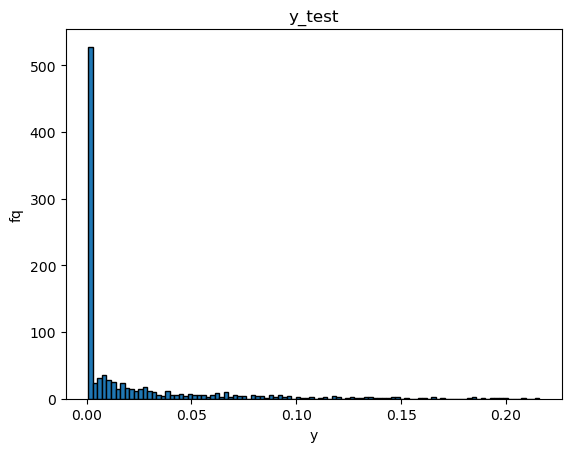

Epoch 0, Loss: 0.4143
Epoch 10, Loss: 0.3785
Epoch 20, Loss: 0.3635
Epoch 30, Loss: 0.3574
Epoch 40, Loss: 0.3278
Epoch 50, Loss: 0.2934
Epoch 60, Loss: 0.2558
Epoch 70, Loss: 0.2150
Epoch 80, Loss: 0.1522
Epoch 90, Loss: 0.1236
Epoch 100, Loss: 0.0951
Epoch 110, Loss: 0.0877
Epoch 120, Loss: 0.0762
Epoch 130, Loss: 0.0788
Epoch 140, Loss: 0.0749
Test GNN RMSE Loss: 0.0434
Test GNN pearson:  tensor(0.9381)
Test GNN spearman:  0.8568167008863586
Test GNN auc:  0.9869894736842105
Started with allocation.
Selected top 50 nodes based on baseline predictions: [24, 871, 277, 257, 636, 262, 768, 665, 288, 926], ...
Selected top 50 nodes based on baseline predictions: [110, 925, 61, 168, 819, 290, 682, 495, 250, 425], ...
u:  0.5017897095859841
b:  -8
b_xy*u_N:  1.9160352
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5314188555583734


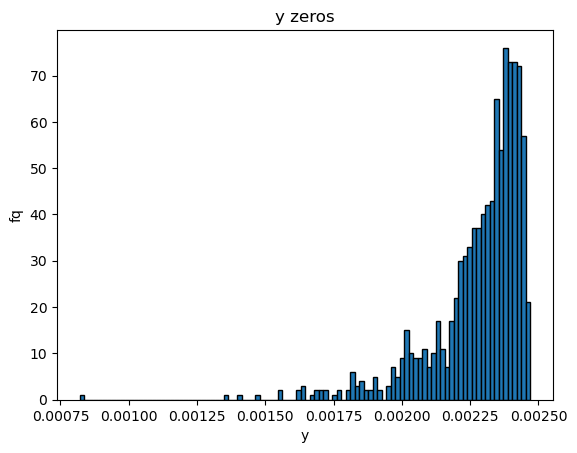

y_zero sum:  2.281583641353682
u:  0.5017897095859841
b:  -8
b_xy*u_N:  1.9158854
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5314188555583734


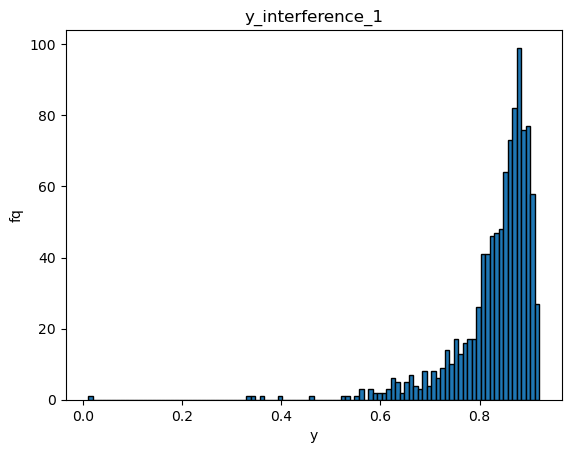

y_interference_1 sum:  2.8966597058648267
The score for greedy interference is 832.2462.
u:  0.5017897095859841
b:  -8
b_xy*u_N:  1.9158756
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5314188555583734


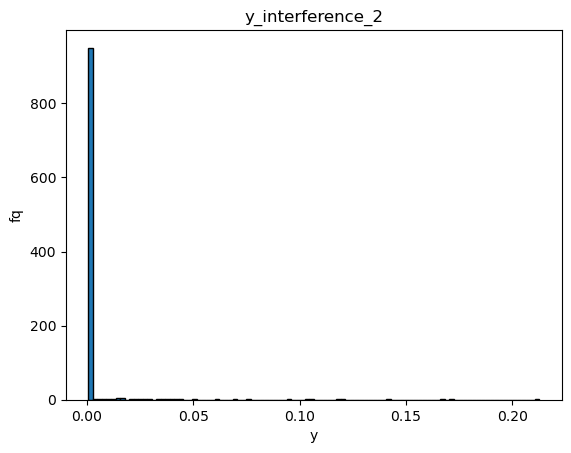

y_interference_2 sum:  4.435039127397159
The score for greedy contagion is 890.9637.
The score for zero is 791.8567.
starting iteration:  1


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.011482085420211837
Pearson with predicted edge probs:  tensor(0.9964)
Spearman with predicted edge probs:  0.9971251800040759
Auc with predicted edge probs:  0.9995578947368421
Rmse of predicted edge probs:  0.17084698583742314
Pearson of predicted edge probs:  tensor(0.2727)
Spearman of predicted edge probs:  0.3729982876479785
Start gnn training.
u:  0.4986049400368387
b:  -8
b_xy*u_N:  1.8220138
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4502410947419886
u:  0.5029568652674034
b:  -8
b_xy*u_N:  1.7861685999999999
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5057165171712534


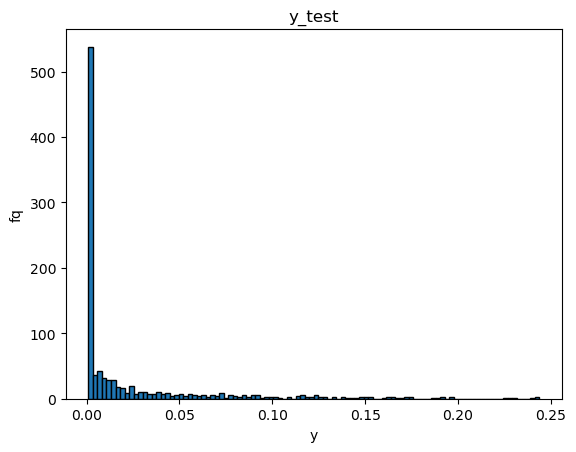

Epoch 0, Loss: 0.4523
Epoch 10, Loss: 0.4003
Epoch 20, Loss: 0.3778
Epoch 30, Loss: 0.3452
Epoch 40, Loss: 0.2730
Epoch 50, Loss: 0.1801
Epoch 60, Loss: 0.1439
Epoch 70, Loss: 0.1461
Epoch 80, Loss: 0.1434
Epoch 90, Loss: 0.0821
Epoch 100, Loss: 0.1142
Epoch 110, Loss: 0.1024
Epoch 120, Loss: 0.0827
Epoch 130, Loss: 0.0848
Epoch 140, Loss: 0.0910
Test GNN RMSE Loss: 0.0249
Test GNN pearson:  tensor(0.9785)
Test GNN spearman:  0.9146310640574148
Test GNN auc:  0.9978105263157895
Started with allocation.
Selected top 50 nodes based on baseline predictions: [735, 757, 318, 607, 759, 226, 687, 821, 949, 351], ...
Selected top 50 nodes based on baseline predictions: [684, 777, 434, 207, 853, 0, 149, 131, 463, 213], ...
u:  0.5002550672869818
b:  -8
b_xy*u_N:  1.7731687999999999
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4918780709521617


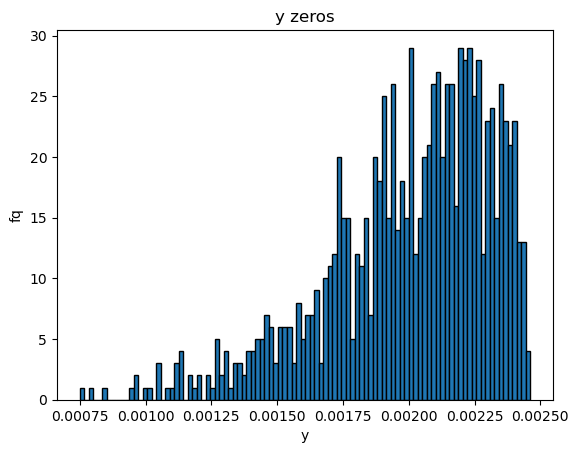

y_zero sum:  2.0006929920542897
u:  0.5002550672869818
b:  -8
b_xy*u_N:  1.7727748
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4918780709521617


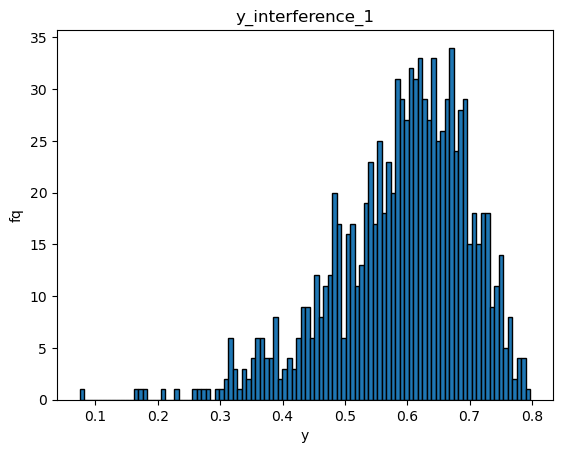

y_interference_1 sum:  2.650692032004138
The score for greedy interference is 590.6731.
u:  0.5002550672869818
b:  -8
b_xy*u_N:  1.7734022
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4918780709521617


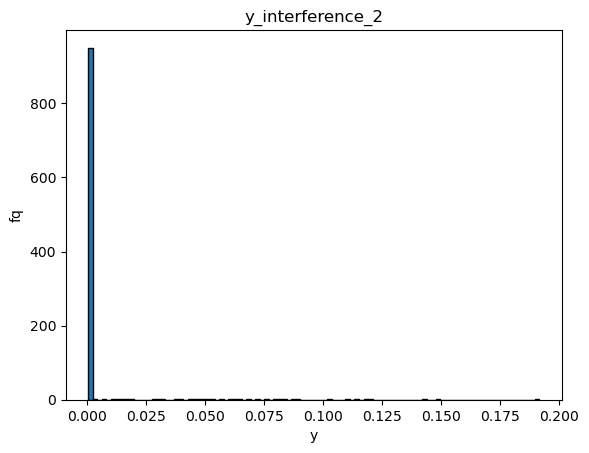

y_interference_2 sum:  4.824754902561711
The score for greedy contagion is 683.662.
The score for zero is 526.2899.
starting iteration:  2


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.012129765597597795
Pearson with predicted edge probs:  tensor(0.9956)
Spearman with predicted edge probs:  0.9961577986363649
Auc with predicted edge probs:  0.9989894736842105
Rmse of predicted edge probs:  0.048918076154034575
Pearson of predicted edge probs:  tensor(0.2547)
Spearman of predicted edge probs:  0.29585906954432906
Start gnn training.
u:  0.49789545586067235
b:  -8
b_xy*u_N:  1.6445206
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.493294224613982
u:  0.4966317165320013
b:  -8
b_xy*u_N:  1.6945773999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5085962929389782


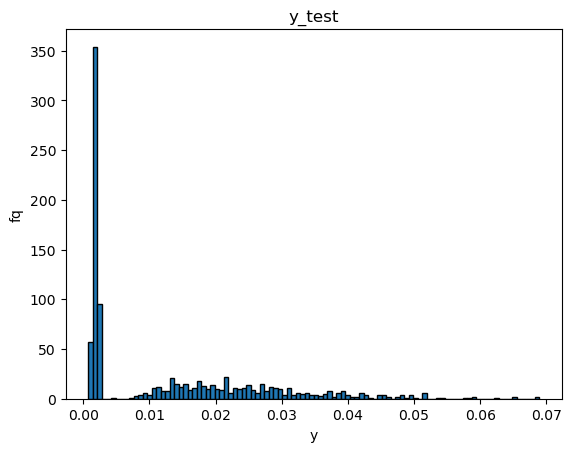

Epoch 0, Loss: 0.2752
Epoch 10, Loss: 0.2404
Epoch 20, Loss: 0.2321
Epoch 30, Loss: 0.2132
Epoch 40, Loss: 0.1871
Epoch 50, Loss: 0.1352
Epoch 60, Loss: 0.0971
Epoch 70, Loss: 0.0626
Epoch 80, Loss: 0.0520
Epoch 90, Loss: 0.0431
Epoch 100, Loss: 0.0425
Epoch 110, Loss: 0.0446
Epoch 120, Loss: 0.0441
Epoch 130, Loss: 0.0350
Epoch 140, Loss: 0.0451
Test GNN RMSE Loss: 0.1135
Test GNN pearson:  tensor(0.9369)
Test GNN spearman:  0.8670103910516441
Test GNN auc:  0.9457894736842105
Started with allocation.
Selected top 50 nodes based on baseline predictions: [6, 918, 885, 553, 702, 686, 42, 200, 39, 483], ...
Selected top 50 nodes based on baseline predictions: [892, 349, 13, 302, 864, 437, 456, 178, 458, 904], ...
u:  0.49608403494675873
b:  -8
b_xy*u_N:  1.7015366
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5038556976519666


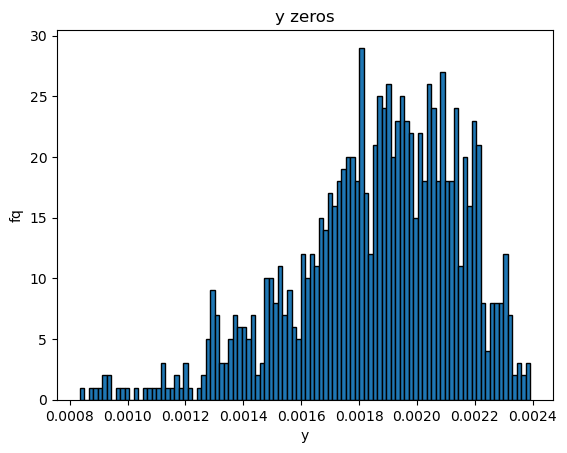

y_zero sum:  1.8604401221555462
u:  0.49608403494675873
b:  -8
b_xy*u_N:  1.7021842
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5038556976519666


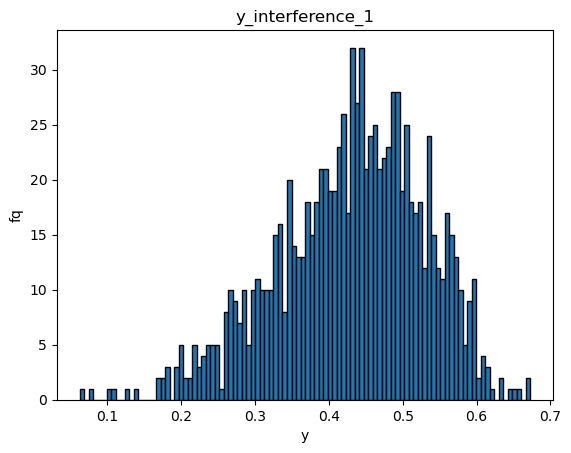

y_interference_1 sum:  2.933401058887963
The score for greedy interference is 429.7152.
u:  0.49608403494675873
b:  -8
b_xy*u_N:  1.7018712
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5038556976519666


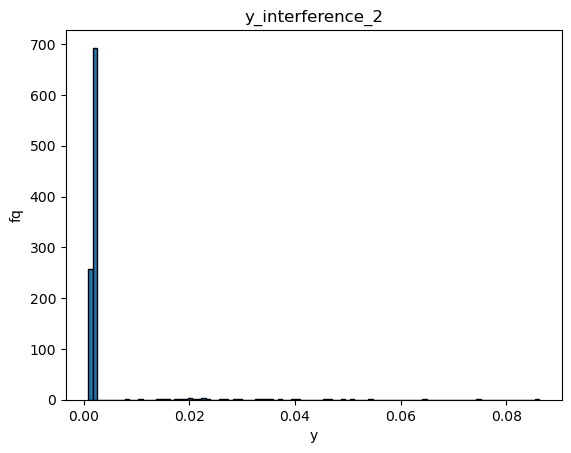

y_interference_2 sum:  3.226308536061891
The score for greedy contagion is 465.8826.
The score for zero is 343.3393.
starting iteration:  3


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.011976161111435641
Pearson with predicted edge probs:  tensor(0.9949)
Spearman with predicted edge probs:  0.9956539329981539
Auc with predicted edge probs:  0.9991368421052631
Rmse of predicted edge probs:  0.05215554099689569
Pearson of predicted edge probs:  tensor(0.2316)
Spearman of predicted edge probs:  0.26691759313815794
Start gnn training.
u:  0.49472535619258123
b:  -8
b_xy*u_N:  1.7842944000000003
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4984937923276385
u:  0.5032953054253594
b:  -8
b_xy*u_N:  1.7326174
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.505403877855155


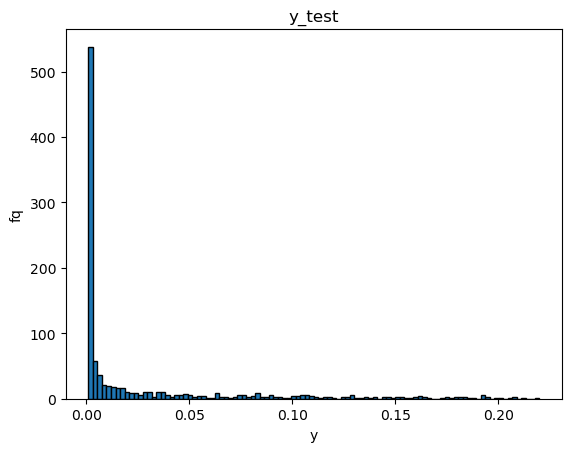

Epoch 0, Loss: 0.4582
Epoch 10, Loss: 0.4262
Epoch 20, Loss: 0.4143
Epoch 30, Loss: 0.3909
Epoch 40, Loss: 0.3478
Epoch 50, Loss: 0.2632
Epoch 60, Loss: 0.1906
Epoch 70, Loss: 0.1252
Epoch 80, Loss: 0.1118
Epoch 90, Loss: 0.0886
Epoch 100, Loss: 0.1155
Epoch 110, Loss: 0.0775
Epoch 120, Loss: 0.0683
Epoch 130, Loss: 0.0671
Epoch 140, Loss: 0.0514
Test GNN RMSE Loss: 0.0596
Test GNN pearson:  tensor(0.9695)
Test GNN spearman:  0.7745570224169132
Test GNN auc:  0.9968631578947369
Started with allocation.
Selected top 50 nodes based on baseline predictions: [768, 482, 671, 458, 973, 255, 979, 725, 762, 621], ...
Selected top 50 nodes based on baseline predictions: [841, 837, 669, 117, 774, 154, 180, 574, 94, 530], ...
u:  0.4955726103142637
b:  -8
b_xy*u_N:  1.7250474
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4326557032536726


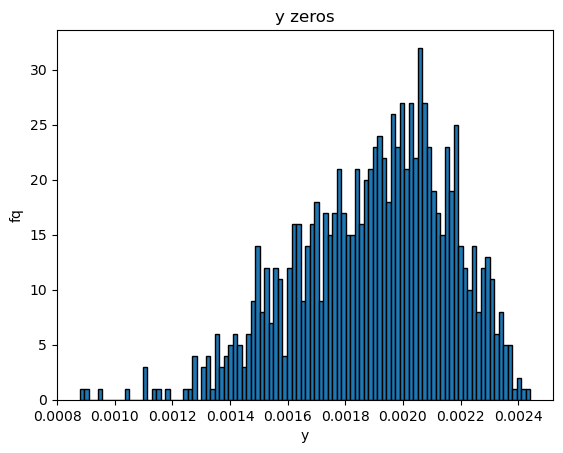

y_zero sum:  1.8993606226793407
u:  0.4955726103142637
b:  -8
b_xy*u_N:  1.725048
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4326557032536726


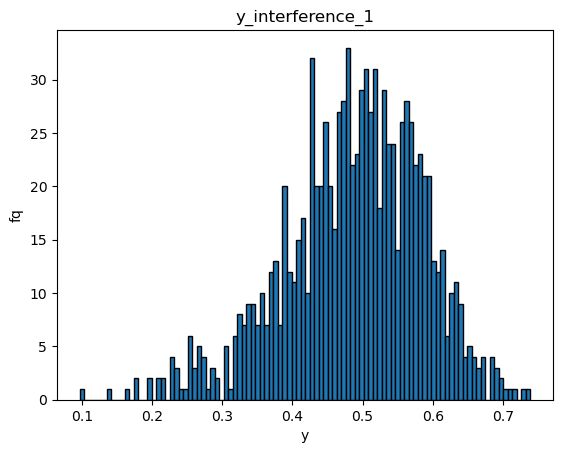

y_interference_1 sum:  3.3846372975196672
The score for greedy interference is 486.70770000000005.
u:  0.4955726103142637
b:  -8
b_xy*u_N:  1.7256736000000001
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4326557032536726


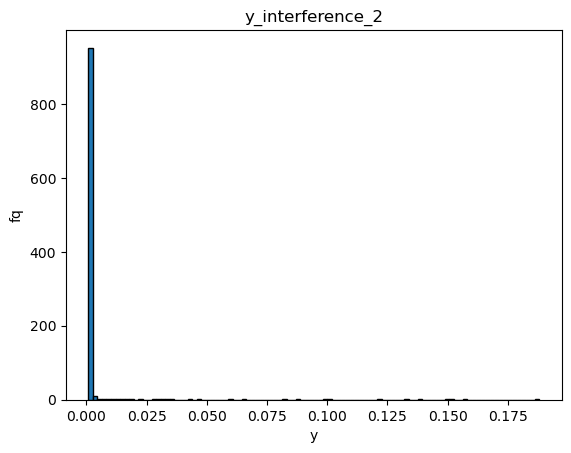

y_interference_2 sum:  4.0351751726390725
The score for greedy contagion is 541.3012.
The score for zero is 380.7848.
starting iteration:  4


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.012781965049707803
Pearson with predicted edge probs:  tensor(0.9957)
Spearman with predicted edge probs:  0.9966954683175653
Auc with predicted edge probs:  0.9989684210526315
Rmse of predicted edge probs:  0.033540538226556234
Pearson of predicted edge probs:  tensor(0.1717)
Spearman of predicted edge probs:  0.2038081708680901
Start gnn training.
u:  0.5035717942334457
b:  -8
b_xy*u_N:  1.3964984
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.504994478329752
u:  0.5123821680268418
b:  -8
b_xy*u_N:  1.6761892
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4821791429368987


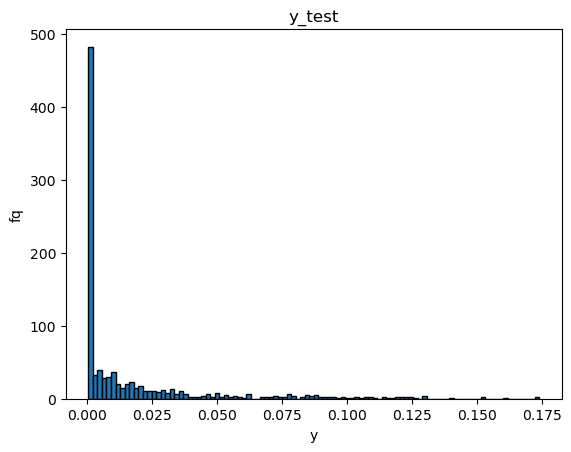

Epoch 0, Loss: 0.4204
Epoch 10, Loss: 0.3707
Epoch 20, Loss: 0.3552
Epoch 30, Loss: 0.3303
Epoch 40, Loss: 0.2835
Epoch 50, Loss: 0.2321
Epoch 60, Loss: 0.1700
Epoch 70, Loss: 0.1083
Epoch 80, Loss: 0.1051
Epoch 90, Loss: 0.1003
Epoch 100, Loss: 0.0998
Epoch 110, Loss: 0.0754
Epoch 120, Loss: 0.1107
Epoch 130, Loss: 0.0899
Epoch 140, Loss: 0.0901
Test GNN RMSE Loss: 0.0359
Test GNN pearson:  tensor(0.9563)
Test GNN spearman:  0.7729630230808128
Test GNN auc:  0.9921263157894737
Started with allocation.
Selected top 50 nodes based on baseline predictions: [35, 568, 653, 109, 126, 217, 241, 934, 44, 123], ...
Selected top 50 nodes based on baseline predictions: [608, 30, 729, 143, 902, 46, 680, 801, 510, 191], ...
u:  0.4968345734980775
b:  -8
b_xy*u_N:  1.6781530000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.491352571322664


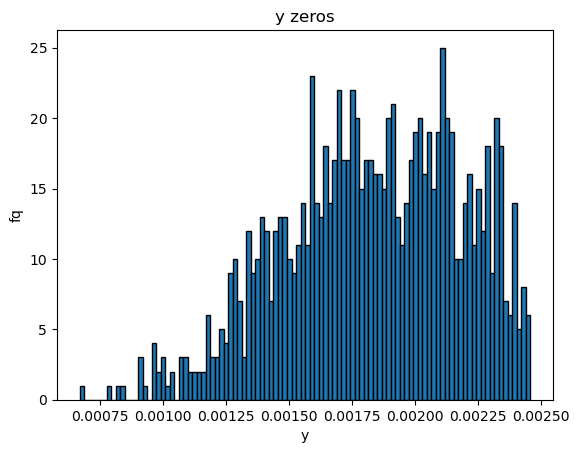

y_zero sum:  1.8303756879573365
u:  0.4968345734980775
b:  -8
b_xy*u_N:  1.6779659999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.491352571322664


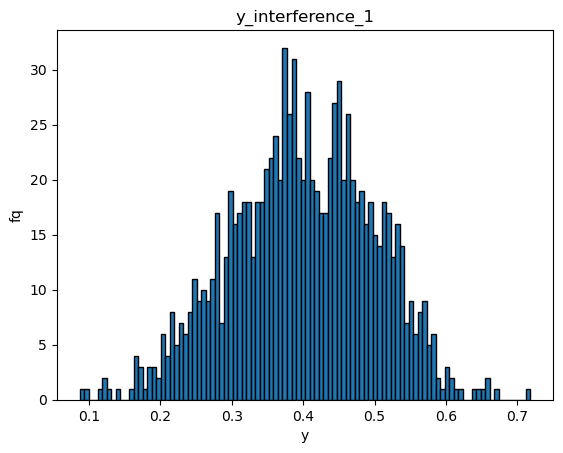

y_interference_1 sum:  4.169135921472899
The score for greedy interference is 398.95500000000004.
u:  0.4968345734980775
b:  -8
b_xy*u_N:  1.6776186
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.491352571322664


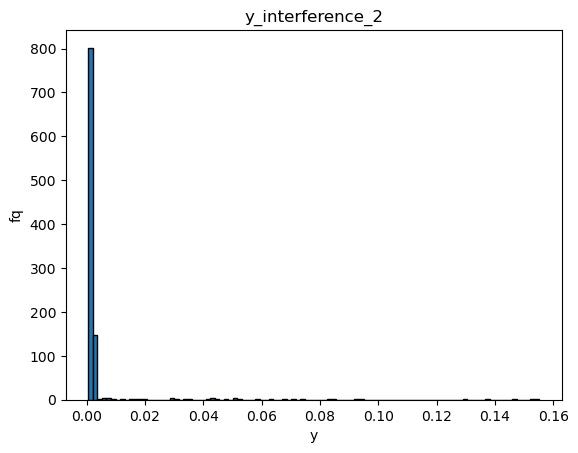

y_interference_2 sum:  4.120919636290447
The score for greedy contagion is 425.7152.
The score for zero is 266.64390000000003.
starting iteration:  5


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.010834339622250033
Pearson with predicted edge probs:  tensor(0.9962)
Spearman with predicted edge probs:  0.9969779967541672
Auc with predicted edge probs:  0.9994736842105263
Rmse of predicted edge probs:  0.06515453615381657
Pearson of predicted edge probs:  tensor(0.2168)
Spearman of predicted edge probs:  0.2314926340630722
Start gnn training.
u:  0.5048141061267977
b:  -8
b_xy*u_N:  1.7967758
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.457870692723345
u:  0.48636650604547865
b:  -8
b_xy*u_N:  1.7695742
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5294444453359293


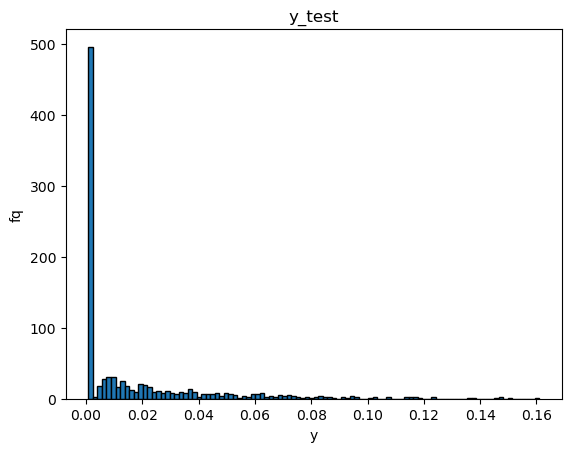

Epoch 0, Loss: 0.4076
Epoch 10, Loss: 0.3598
Epoch 20, Loss: 0.3293
Epoch 30, Loss: 0.3073
Epoch 40, Loss: 0.2574
Epoch 50, Loss: 0.1866
Epoch 60, Loss: 0.1297
Epoch 70, Loss: 0.0797
Epoch 80, Loss: 0.0778
Epoch 90, Loss: 0.0803
Epoch 100, Loss: 0.0841
Epoch 110, Loss: 0.0746
Epoch 120, Loss: 0.0674
Epoch 130, Loss: 0.0658
Epoch 140, Loss: 0.0640
Test GNN RMSE Loss: 0.0971
Test GNN pearson:  tensor(0.9390)
Test GNN spearman:  0.7310180666360568
Test GNN auc:  0.9868421052631579
Started with allocation.
Selected top 50 nodes based on baseline predictions: [722, 596, 326, 136, 325, 976, 154, 80, 190, 907], ...
Selected top 50 nodes based on baseline predictions: [351, 605, 722, 441, 180, 525, 800, 36, 581, 42], ...
u:  0.492577872529253
b:  -8
b_xy*u_N:  1.7678302000000001
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.480768628437425


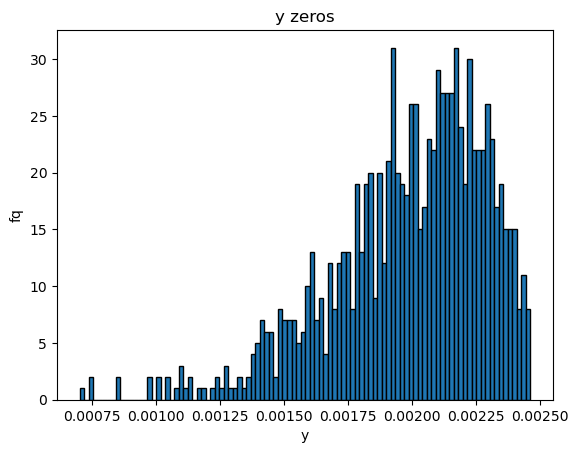

y_zero sum:  1.988366542543155
u:  0.492577872529253
b:  -8
b_xy*u_N:  1.7681908
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.480768628437425


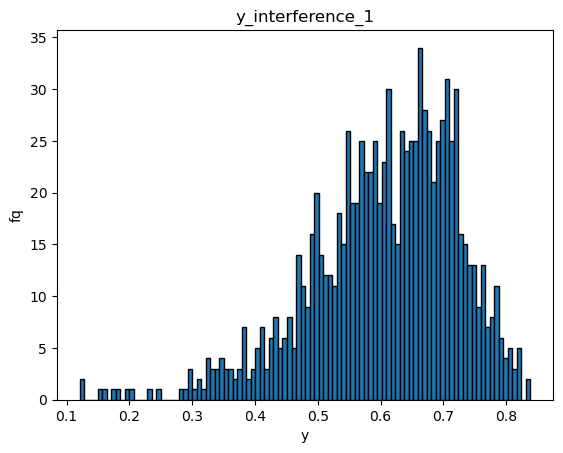

y_interference_1 sum:  3.586700098412195
The score for greedy interference is 605.9353000000001.
u:  0.492577872529253
b:  -8
b_xy*u_N:  1.7682609999999999
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.480768628437425


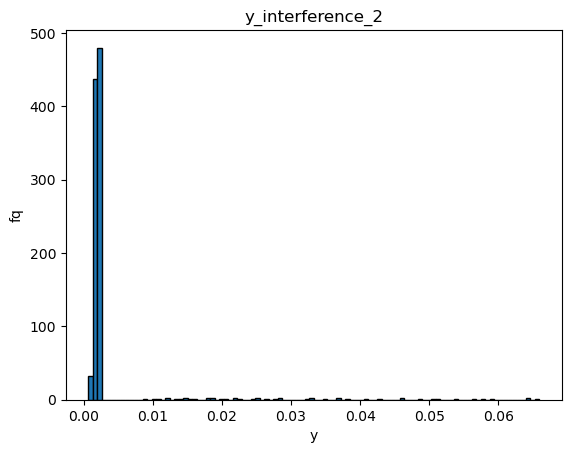

y_interference_2 sum:  3.41638894745799
The score for greedy contagion is 610.9026.
The score for zero is 488.5829.
starting iteration:  6


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.011392623879612039
Pearson with predicted edge probs:  tensor(0.9956)
Spearman with predicted edge probs:  0.9969735299385355
Auc with predicted edge probs:  0.9971487014194509
Rmse of predicted edge probs:  0.23141038204524733
Pearson of predicted edge probs:  tensor(0.2386)
Spearman of predicted edge probs:  0.3290009991092586
Start gnn training.
u:  0.5025463590598582
b:  -8
b_xy*u_N:  1.3859967999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5502675525025893
u:  0.489667408390592
b:  -8
b_xy*u_N:  1.8059167999999999
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.452219961980211


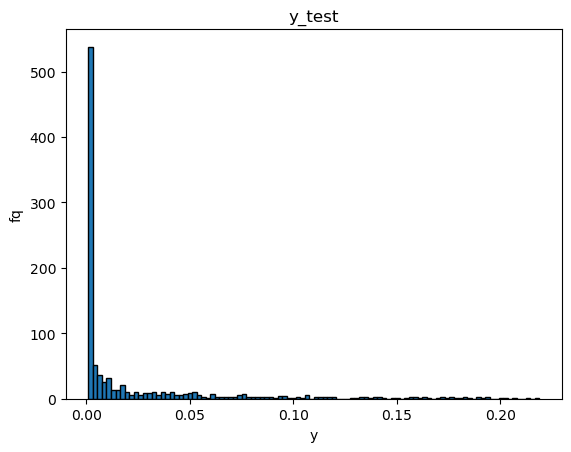

Epoch 0, Loss: 0.4669
Epoch 10, Loss: 0.4127
Epoch 20, Loss: 0.3824
Epoch 30, Loss: 0.3365
Epoch 40, Loss: 0.2526
Epoch 50, Loss: 0.1977
Epoch 60, Loss: 0.1123
Epoch 70, Loss: 0.1339
Epoch 80, Loss: 0.1114
Epoch 90, Loss: 0.0917
Epoch 100, Loss: 0.0850
Epoch 110, Loss: 0.0855
Epoch 120, Loss: 0.0668
Epoch 130, Loss: 0.0818
Epoch 140, Loss: 0.0646
Test GNN RMSE Loss: 0.0417
Test GNN pearson:  tensor(0.9436)
Test GNN spearman:  0.5722820879308858
Test GNN auc:  0.9959368421052632
Started with allocation.
Selected top 50 nodes based on baseline predictions: [193, 0, 627, 592, 315, 585, 9, 530, 859, 924], ...
Selected top 50 nodes based on baseline predictions: [207, 985, 879, 509, 249, 442, 684, 287, 128, 702], ...
u:  0.5110241470848239
b:  -8
b_xy*u_N:  1.8062638000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5394671900804933


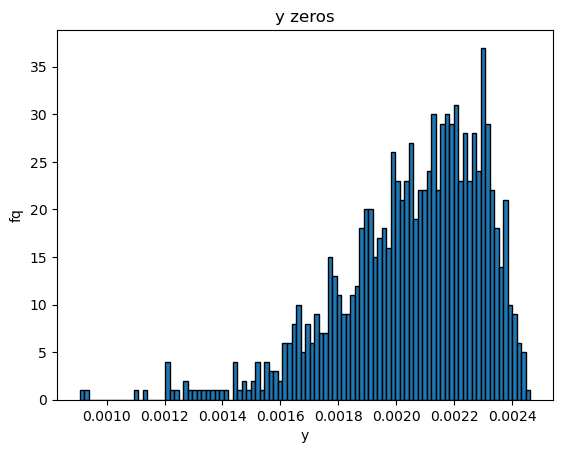

y_zero sum:  2.0547106477972696
u:  0.5110241470848239
b:  -8
b_xy*u_N:  1.8063044
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5394671900804933


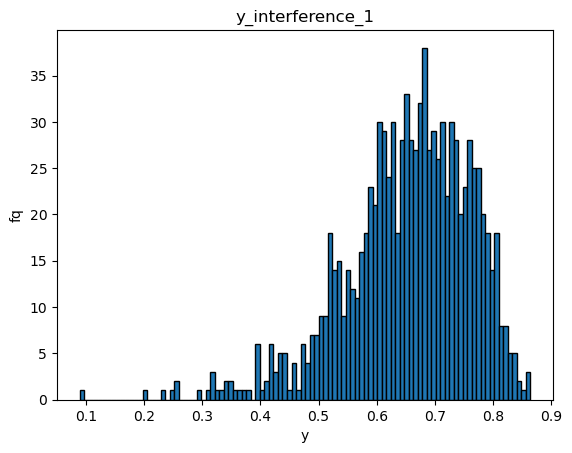

y_interference_1 sum:  3.1033589582078145
The score for greedy interference is 653.3492000000001.
u:  0.5110241470848239
b:  -8
b_xy*u_N:  1.8068413999999997
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5394671900804933


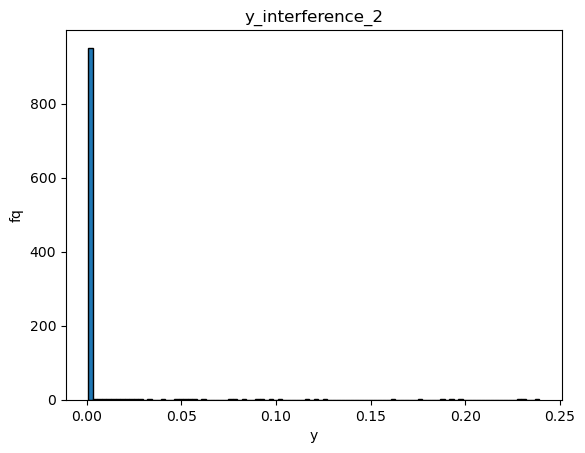

y_interference_2 sum:  5.493028312270888
The score for greedy contagion is 720.6012000000001.
The score for zero is 567.7873.
starting iteration:  7


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.01055827888841112
Pearson with predicted edge probs:  tensor(0.9954)
Spearman with predicted edge probs:  0.9966370640935815
Auc with predicted edge probs:  0.9996694146573276
Rmse of predicted edge probs:  0.057276539087773345
Pearson of predicted edge probs:  tensor(0.1954)
Spearman of predicted edge probs:  0.21231267126073883
Start gnn training.
u:  0.5019246951078994
b:  -8
b_xy*u_N:  1.7119046
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5268662992800937
u:  0.49394287112078644
b:  -8
b_xy*u_N:  1.7710682
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.504668122882991


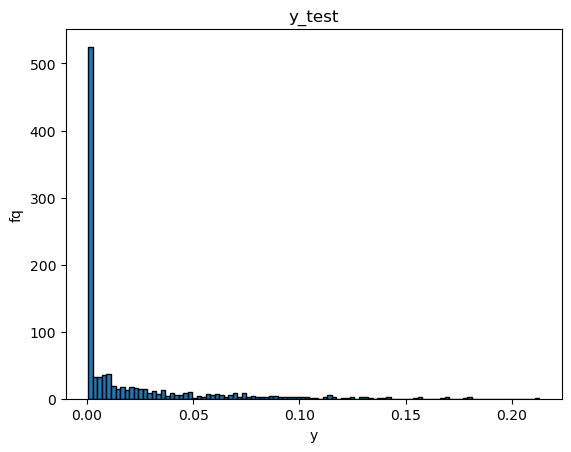

Epoch 0, Loss: 0.4448
Epoch 10, Loss: 0.3890
Epoch 20, Loss: 0.3773
Epoch 30, Loss: 0.3738
Epoch 40, Loss: 0.3639
Epoch 50, Loss: 0.3701
Epoch 60, Loss: 0.3527
Epoch 70, Loss: 0.3253
Epoch 80, Loss: 0.2819
Epoch 90, Loss: 0.1825
Epoch 100, Loss: 0.1289
Epoch 110, Loss: 0.0979
Epoch 120, Loss: 0.0839
Epoch 130, Loss: 0.1124
Epoch 140, Loss: 0.0929
Test GNN RMSE Loss: 0.0175
Test GNN pearson:  tensor(0.9741)
Test GNN spearman:  0.8290920208158745
Test GNN auc:  0.9962736842105263
Started with allocation.
Selected top 50 nodes based on baseline predictions: [811, 556, 894, 314, 584, 738, 132, 757, 9, 720], ...
Selected top 50 nodes based on baseline predictions: [584, 385, 39, 299, 31, 554, 457, 911, 418, 821], ...
u:  0.4924401174063447
b:  -8
b_xy*u_N:  1.7761768000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.465785780290916


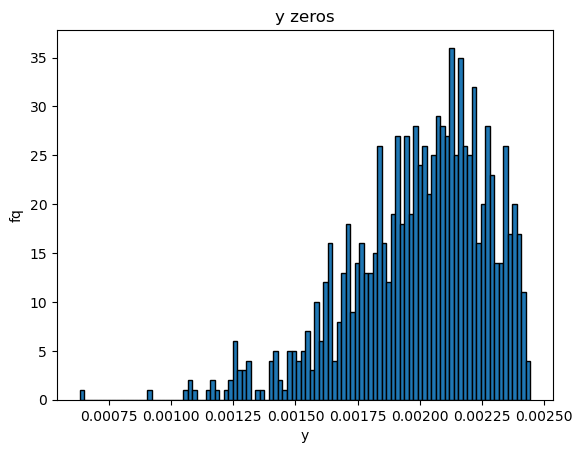

y_zero sum:  1.9992254552606394
u:  0.4924401174063447
b:  -8
b_xy*u_N:  1.7765608
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.465785780290916


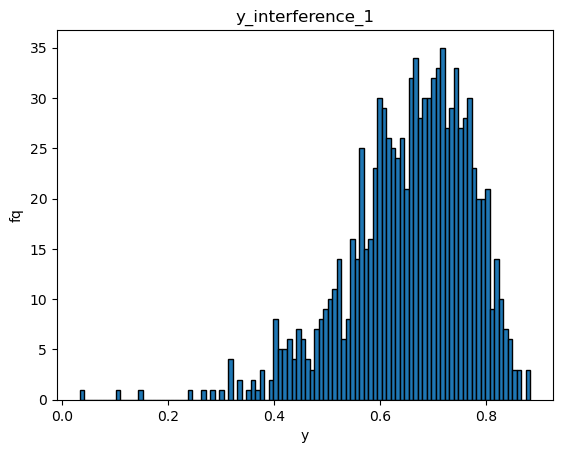

y_interference_1 sum:  3.9002409064122823
The score for greedy interference is 657.1247000000001.
u:  0.4924401174063447
b:  -8
b_xy*u_N:  1.7763108
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.465785780290916


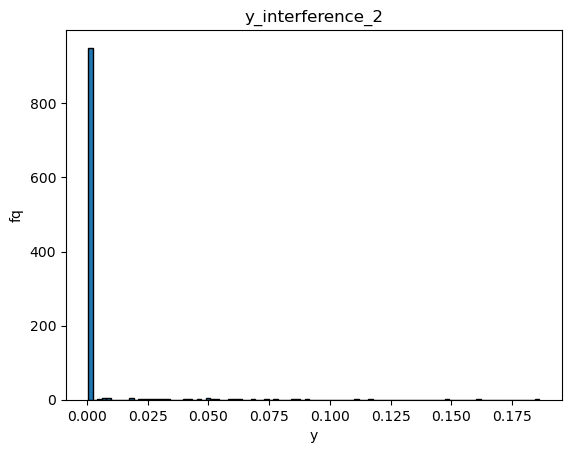

y_interference_2 sum:  4.4186854804085645
The score for greedy contagion is 676.2275.
The score for zero is 525.7252000000001.
starting iteration:  8


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.01175923234542653
Pearson with predicted edge probs:  tensor(0.9939)
Spearman with predicted edge probs:  0.9945957344992535
Auc with predicted edge probs:  0.9986315789473684
Rmse of predicted edge probs:  0.029696260550983077
Pearson of predicted edge probs:  tensor(0.2146)
Spearman of predicted edge probs:  0.20437690586208032
Start gnn training.
u:  0.5128855318579849
b:  -8
b_xy*u_N:  1.7544777999999999
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4939525310598665
u:  0.48905498701656747
b:  -8
b_xy*u_N:  1.658849
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.462186233907184


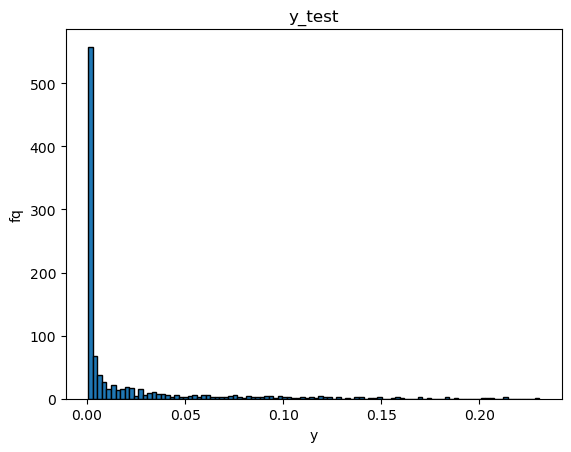

Epoch 0, Loss: 0.4454
Epoch 10, Loss: 0.3975
Epoch 20, Loss: 0.3802
Epoch 30, Loss: 0.3552
Epoch 40, Loss: 0.2929
Epoch 50, Loss: 0.2394
Epoch 60, Loss: 0.1723
Epoch 70, Loss: 0.1461
Epoch 80, Loss: 0.1370
Epoch 90, Loss: 0.1025
Epoch 100, Loss: 0.1022
Epoch 110, Loss: 0.0969
Epoch 120, Loss: 0.0793
Epoch 130, Loss: 0.0992
Epoch 140, Loss: 0.0854
Test GNN RMSE Loss: 0.0511
Test GNN pearson:  tensor(0.9490)
Test GNN spearman:  0.5803000950860121
Test GNN auc:  0.9984421052631579
Started with allocation.
Selected top 50 nodes based on baseline predictions: [767, 729, 809, 62, 437, 507, 402, 889, 207, 601], ...
Selected top 50 nodes based on baseline predictions: [68, 556, 702, 438, 818, 356, 439, 378, 601, 324], ...
u:  0.5016618552035793
b:  -8
b_xy*u_N:  1.673741
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.524288865376408


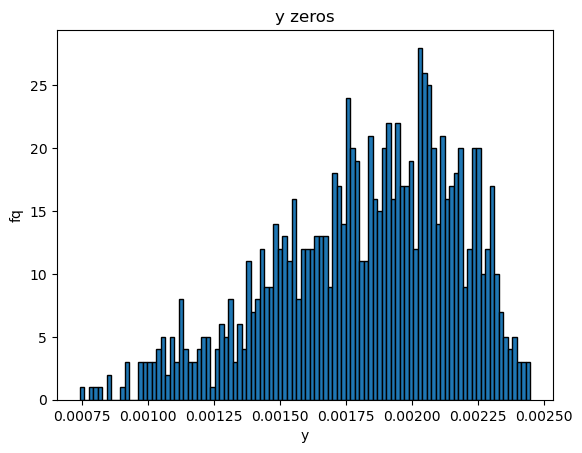

y_zero sum:  1.8230249771950535
u:  0.5016618552035793
b:  -8
b_xy*u_N:  1.6729690000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.524288865376408


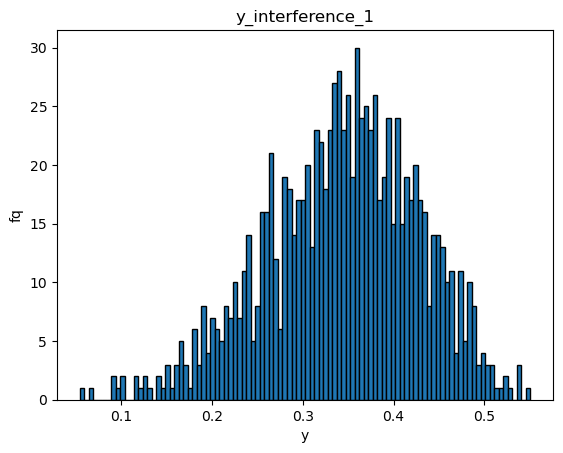

y_interference_1 sum:  2.720499187228003
The score for greedy interference is 343.1711.
u:  0.5016618552035793
b:  -8
b_xy*u_N:  1.6732415999999999
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.524288865376408


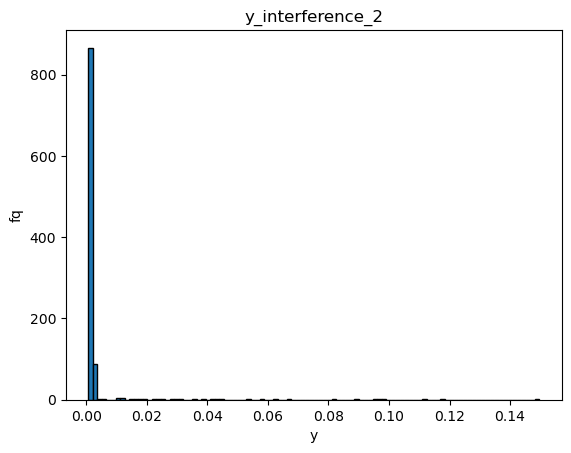

y_interference_2 sum:  3.515733830529702
The score for greedy contagion is 402.45640000000003.
The score for zero is 272.0162.
starting iteration:  9


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.011645957125387083
Pearson with predicted edge probs:  tensor(0.9953)
Spearman with predicted edge probs:  0.9966245120752681
Auc with predicted edge probs:  0.9967974544928615
Rmse of predicted edge probs:  0.203698229736254
Pearson of predicted edge probs:  tensor(0.1081)
Spearman of predicted edge probs:  0.15988270635088242
Start gnn training.
u:  0.49281027278397016
b:  -8
b_xy*u_N:  1.8480218
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.555955093316359
u:  0.4998744872685868
b:  -8
b_xy*u_N:  1.8001278000000003
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.495287244914212


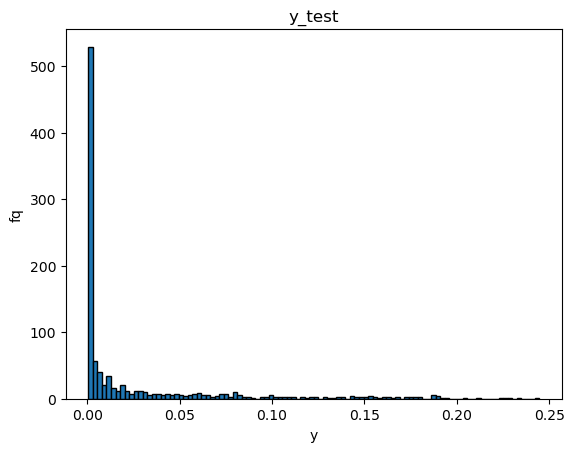

Epoch 0, Loss: 0.4548
Epoch 10, Loss: 0.3980
Epoch 20, Loss: 0.3925
Epoch 30, Loss: 0.3703
Epoch 40, Loss: 0.3306
Epoch 50, Loss: 0.2375
Epoch 60, Loss: 0.1756
Epoch 70, Loss: 0.1055
Epoch 80, Loss: 0.1041
Epoch 90, Loss: 0.1139
Epoch 100, Loss: 0.0779
Epoch 110, Loss: 0.0962
Epoch 120, Loss: 0.0780
Epoch 130, Loss: 0.0772
Epoch 140, Loss: 0.0898
Test GNN RMSE Loss: 0.0334
Test GNN pearson:  tensor(0.9589)
Test GNN spearman:  0.7921140425977783
Test GNN auc:  0.9854947368421052
Started with allocation.
Selected top 50 nodes based on baseline predictions: [242, 545, 231, 328, 929, 388, 121, 200, 476, 819], ...
Selected top 50 nodes based on baseline predictions: [138, 451, 14, 556, 954, 549, 694, 983, 51, 420], ...
u:  0.503802008031
b:  -8
b_xy*u_N:  1.7984554
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5508232878112085


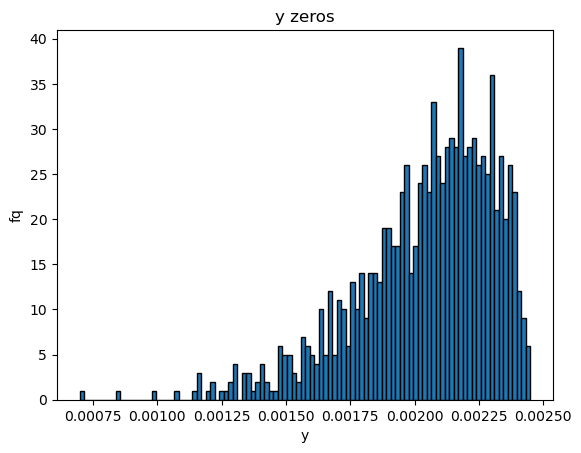

y_zero sum:  2.042706406608759
u:  0.503802008031
b:  -8
b_xy*u_N:  1.7984418
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5508232878112085


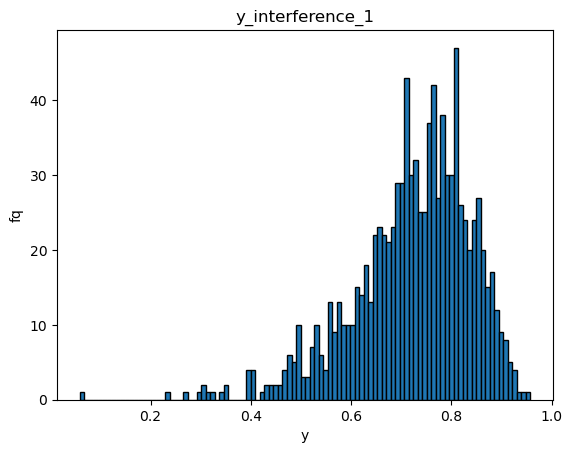

y_interference_1 sum:  7.345581842759465
The score for greedy interference is 721.94.
u:  0.503802008031
b:  -8
b_xy*u_N:  1.7986462
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5508232878112085


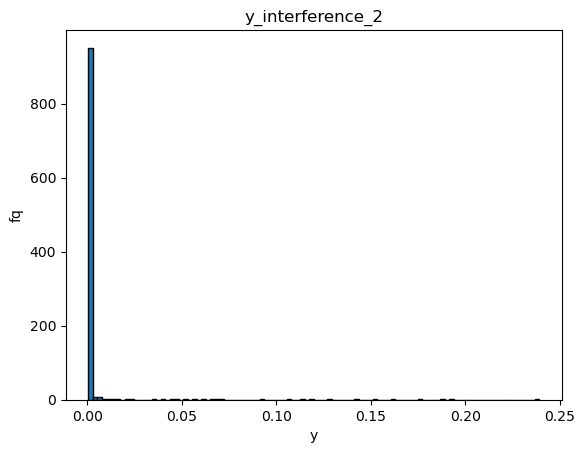

y_interference_2 sum:  4.607461166320235
The score for greedy contagion is 710.0156999999999.
The score for zero is 558.1707.
starting iteration:  10


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.011151157472011335
Pearson with predicted edge probs:  tensor(0.9962)
Spearman with predicted edge probs:  0.9969154585182635
Auc with predicted edge probs:  0.9959368421052632
Rmse of predicted edge probs:  0.250871242882802
Pearson of predicted edge probs:  tensor(0.2268)
Spearman of predicted edge probs:  0.30333973664539665
Start gnn training.
u:  0.5013737730768205
b:  -8
b_xy*u_N:  1.7122267999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.56427992079479
u:  0.5038622885435993
b:  -8
b_xy*u_N:  1.7987415999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.457805662242608


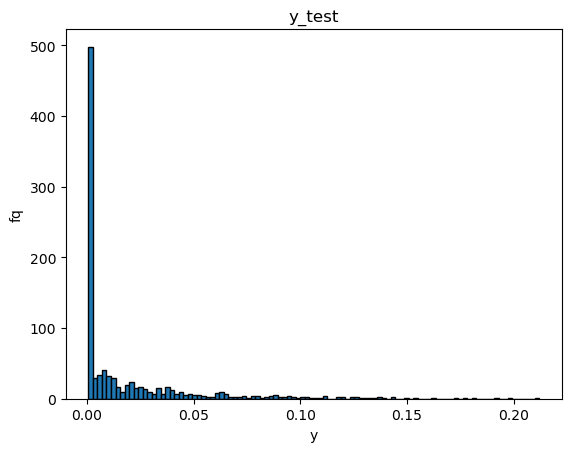

Epoch 0, Loss: 0.3998
Epoch 10, Loss: 0.3519
Epoch 20, Loss: 0.3356
Epoch 30, Loss: 0.3233
Epoch 40, Loss: 0.2982
Epoch 50, Loss: 0.2538
Epoch 60, Loss: 0.1540
Epoch 70, Loss: 0.1284
Epoch 80, Loss: 0.0967
Epoch 90, Loss: 0.0972
Epoch 100, Loss: 0.1131
Epoch 110, Loss: 0.0820
Epoch 120, Loss: 0.0638
Epoch 130, Loss: 0.0758
Epoch 140, Loss: 0.0674
Test GNN RMSE Loss: 0.0396
Test GNN pearson:  tensor(0.9759)
Test GNN spearman:  0.8681056488251242
Test GNN auc:  0.9937263157894737
Started with allocation.
Selected top 50 nodes based on baseline predictions: [101, 997, 531, 597, 975, 669, 76, 267, 364, 731], ...
Selected top 50 nodes based on baseline predictions: [884, 213, 906, 173, 501, 666, 872, 646, 775, 611], ...
u:  0.5025078443535259
b:  -8
b_xy*u_N:  1.7988112
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5016503524629554


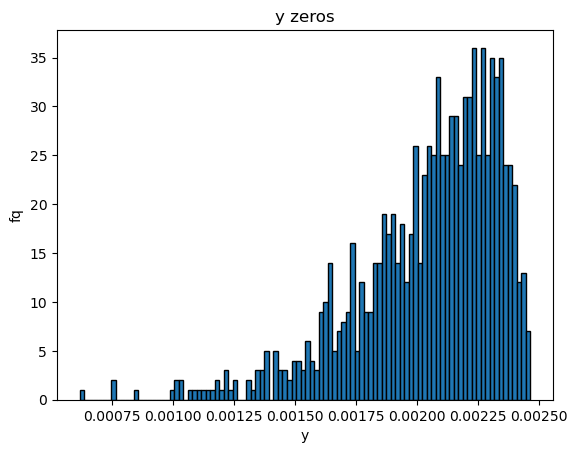

y_zero sum:  2.048362643304621
u:  0.5025078443535259
b:  -8
b_xy*u_N:  1.799283
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5016503524629554


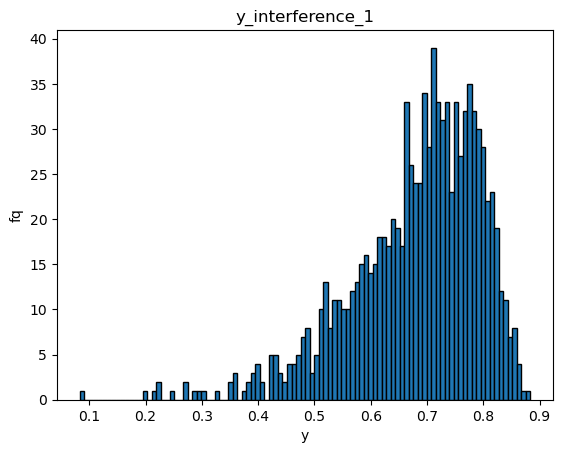

y_interference_1 sum:  3.351237028154597
The score for greedy interference is 680.21.
u:  0.5025078443535259
b:  -8
b_xy*u_N:  1.7992959999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5016503524629554


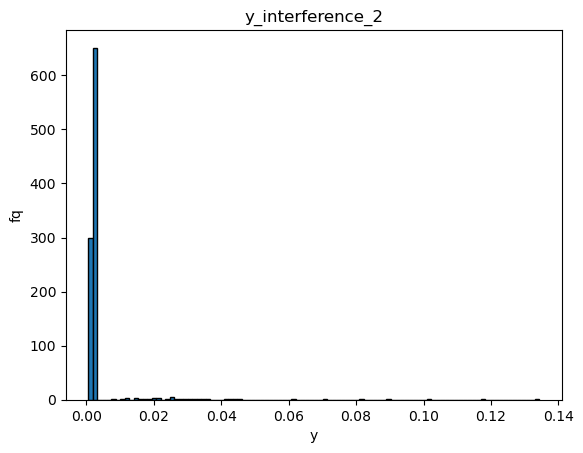

y_interference_2 sum:  3.6356860942897935
The score for greedy contagion is 703.3036.
The score for zero is 578.4779.
starting iteration:  11


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.011005760927466593
Pearson with predicted edge probs:  tensor(0.9951)
Spearman with predicted edge probs:  0.9955482604248939
Auc with predicted edge probs:  0.9991578947368421
Rmse of predicted edge probs:  0.03544060297635599
Pearson of predicted edge probs:  tensor(0.3882)
Spearman of predicted edge probs:  0.37844883967449217
Start gnn training.
u:  0.49448035693239056
b:  -8
b_xy*u_N:  1.7951424000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5199800154172807
u:  0.5006702464670021
b:  -8
b_xy*u_N:  1.7150784
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5099259726078342


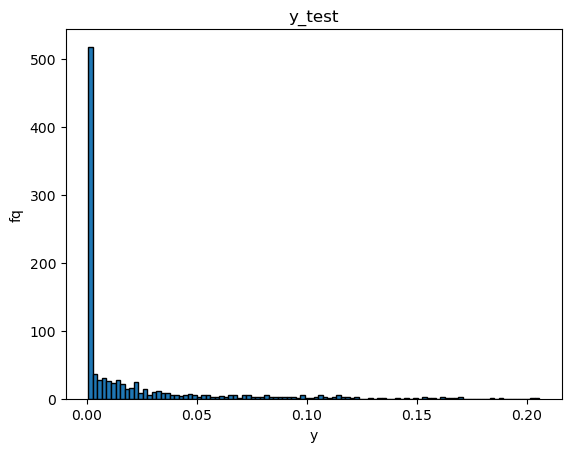

Epoch 0, Loss: 0.4143
Epoch 10, Loss: 0.3618
Epoch 20, Loss: 0.3546
Epoch 30, Loss: 0.3253
Epoch 40, Loss: 0.2690
Epoch 50, Loss: 0.1798
Epoch 60, Loss: 0.1104
Epoch 70, Loss: 0.1038
Epoch 80, Loss: 0.0833
Epoch 90, Loss: 0.0664
Epoch 100, Loss: 0.0919
Epoch 110, Loss: 0.0683
Epoch 120, Loss: 0.0762
Epoch 130, Loss: 0.0667
Epoch 140, Loss: 0.0566
Test GNN RMSE Loss: 0.0777
Test GNN pearson:  tensor(0.9647)
Test GNN spearman:  0.8006438259462043
Test GNN auc:  0.9953052631578948
Started with allocation.
Selected top 50 nodes based on baseline predictions: [575, 730, 749, 568, 259, 436, 675, 931, 776, 488], ...
Selected top 50 nodes based on baseline predictions: [442, 186, 861, 944, 480, 978, 226, 391, 837, 127], ...
u:  0.5020217678607223
b:  -8
b_xy*u_N:  1.7287978000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.522913745431762


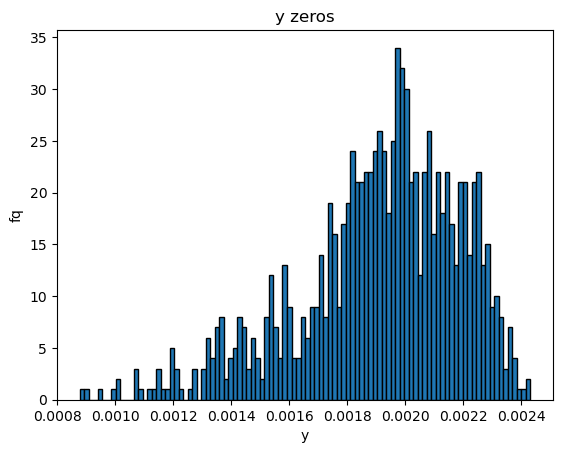

y_zero sum:  1.909398422549157
u:  0.5020217678607223
b:  -8
b_xy*u_N:  1.7287276
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.522913745431762


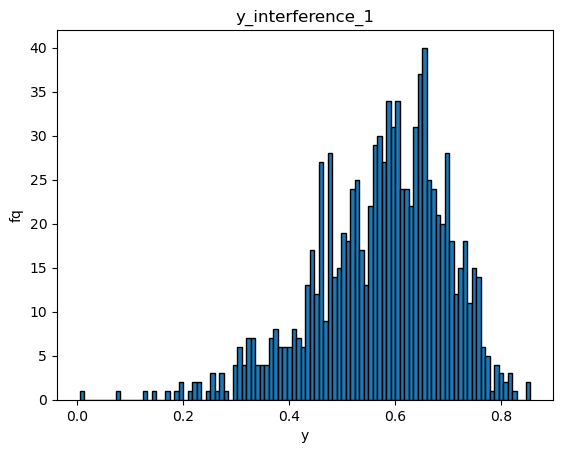

y_interference_1 sum:  6.795402651874325
The score for greedy interference is 573.3791.
u:  0.5020217678607223
b:  -8
b_xy*u_N:  1.728685
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.522913745431762


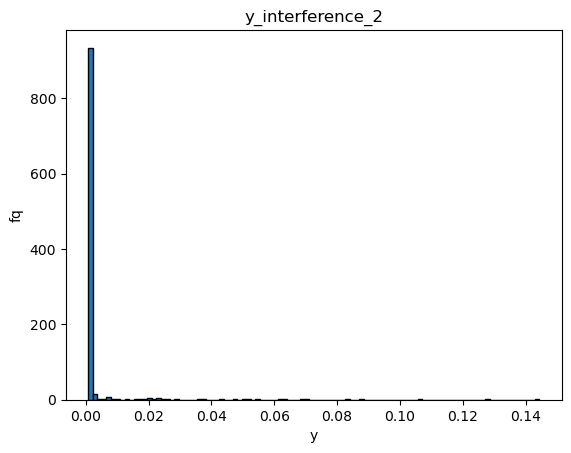

y_interference_2 sum:  3.5488064601428846
The score for greedy contagion is 528.5596.
The score for zero is 392.8707.
starting iteration:  12


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.009945727843040052
Pearson with predicted edge probs:  tensor(0.9948)
Spearman with predicted edge probs:  0.9950442353236705
Auc with predicted edge probs:  0.998042105263158
Rmse of predicted edge probs:  0.0310645758357498
Pearson of predicted edge probs:  tensor(0.2719)
Spearman of predicted edge probs:  0.2609814862997693
Start gnn training.
u:  0.5042622364410858
b:  -8
b_xy*u_N:  1.7184769999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4977412615884624
u:  0.5097261735137513
b:  -8
b_xy*u_N:  1.7138718
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5275319489800996


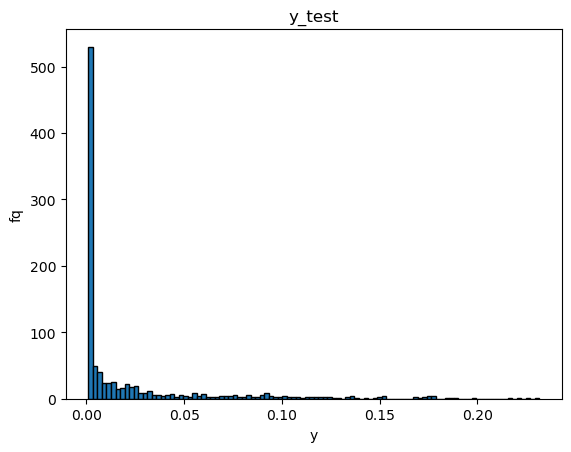

Epoch 0, Loss: 0.4620
Epoch 10, Loss: 0.4028
Epoch 20, Loss: 0.3936
Epoch 30, Loss: 0.3436
Epoch 40, Loss: 0.2777
Epoch 50, Loss: 0.1990
Epoch 60, Loss: 0.1678
Epoch 70, Loss: 0.1341
Epoch 80, Loss: 0.0962
Epoch 90, Loss: 0.0907
Epoch 100, Loss: 0.0761
Epoch 110, Loss: 0.0917
Epoch 120, Loss: 0.0933
Epoch 130, Loss: 0.1111
Epoch 140, Loss: 0.0806
Test GNN RMSE Loss: 0.0204
Test GNN pearson:  tensor(0.9851)
Test GNN spearman:  0.8594909255222083
Test GNN auc:  0.9990105263157895
Started with allocation.
Selected top 50 nodes based on baseline predictions: [929, 900, 902, 631, 468, 415, 322, 882, 98, 12], ...
Selected top 50 nodes based on baseline predictions: [955, 726, 173, 433, 86, 526, 815, 716, 153, 379], ...
u:  0.5063793442127135
b:  -8
b_xy*u_N:  1.7091986000000001
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.528041094744682


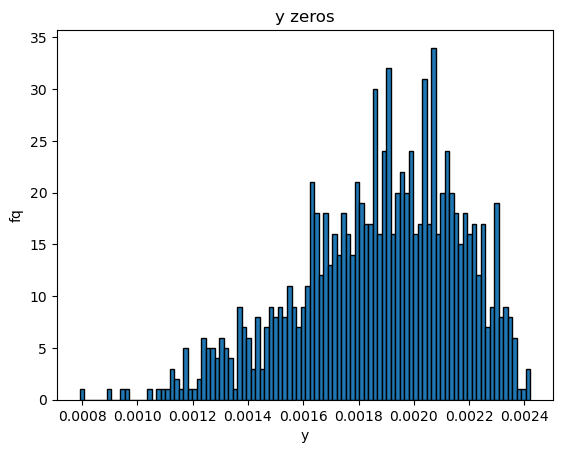

y_zero sum:  1.8745711471213236
u:  0.5063793442127135
b:  -8
b_xy*u_N:  1.7090884000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.528041094744682


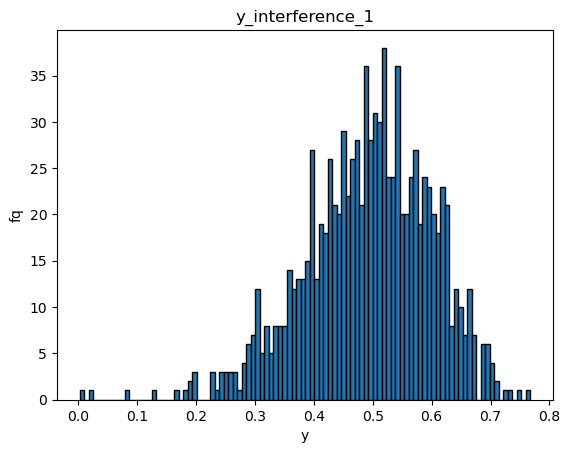

y_interference_1 sum:  6.686463311379842
The score for greedy interference is 491.9495.
u:  0.5063793442127135
b:  -8
b_xy*u_N:  1.7092344
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.528041094744682


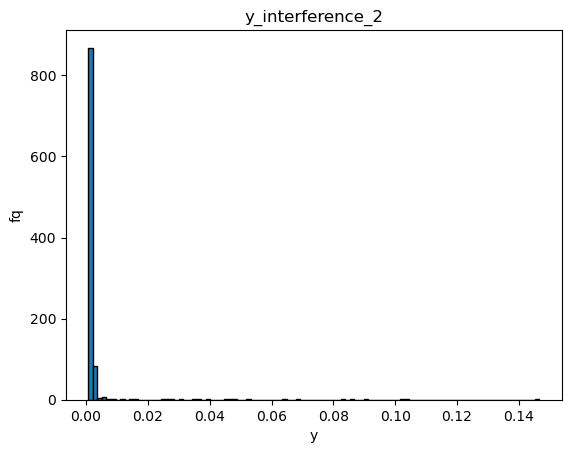

y_interference_2 sum:  3.4307078546183507
The score for greedy contagion is 451.4588.
The score for zero is 316.0992.
starting iteration:  13


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.011158268590843916
Pearson with predicted edge probs:  tensor(0.9966)
Spearman with predicted edge probs:  0.997235682157674
Auc with predicted edge probs:  0.9990736842105263
Rmse of predicted edge probs:  0.039969489955036346
Pearson of predicted edge probs:  tensor(0.3033)
Spearman of predicted edge probs:  0.30114845602951906
Start gnn training.
u:  0.49088749458348024
b:  -8
b_xy*u_N:  1.7509966
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4328126155490035
u:  0.497594329495109
b:  -8
b_xy*u_N:  1.740097
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.505654035980881


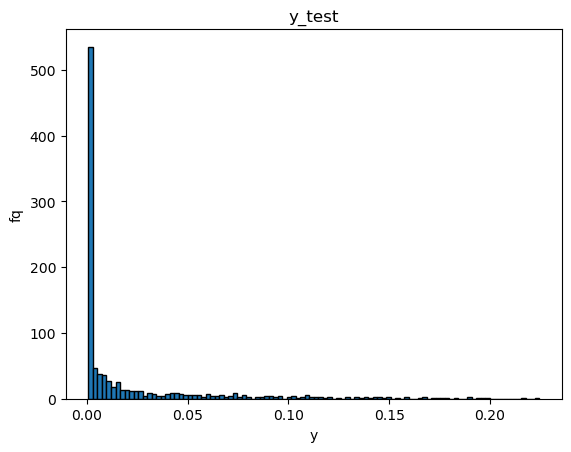

Epoch 0, Loss: 0.4511
Epoch 10, Loss: 0.4055
Epoch 20, Loss: 0.3971
Epoch 30, Loss: 0.3816
Epoch 40, Loss: 0.3718
Epoch 50, Loss: 0.3185
Epoch 60, Loss: 0.2151
Epoch 70, Loss: 0.2018
Epoch 80, Loss: 0.1295
Epoch 90, Loss: 0.0983
Epoch 100, Loss: 0.0977
Epoch 110, Loss: 0.0802
Epoch 120, Loss: 0.0873
Epoch 130, Loss: 0.0787
Epoch 140, Loss: 0.0985
Test GNN RMSE Loss: 0.0522
Test GNN pearson:  tensor(0.9485)
Test GNN spearman:  0.6278312969768483
Test GNN auc:  0.9924210526315789
Started with allocation.
Selected top 50 nodes based on baseline predictions: [726, 62, 608, 34, 635, 194, 520, 308, 794, 83], ...
Selected top 50 nodes based on baseline predictions: [423, 546, 603, 476, 726, 998, 97, 767, 392, 790], ...
u:  0.5054291048554018
b:  -8
b_xy*u_N:  1.7630198000000001
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.493660386086497


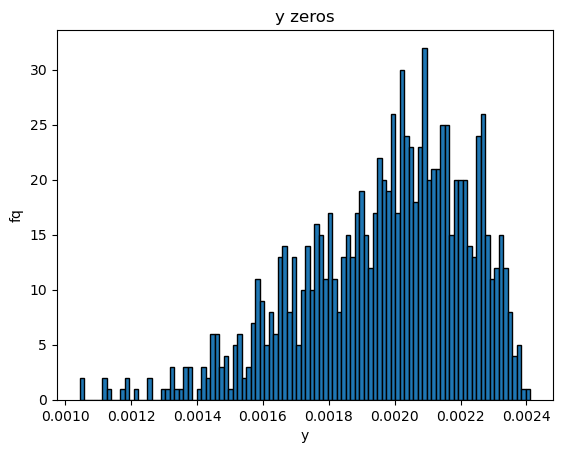

y_zero sum:  1.9694069368419165
u:  0.5054291048554018
b:  -8
b_xy*u_N:  1.7631156000000001
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.493660386086497


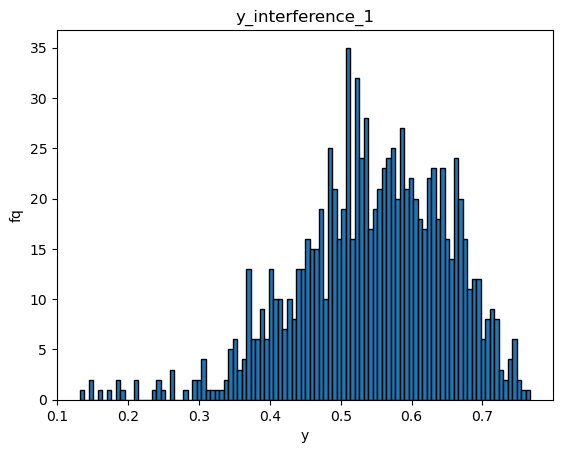

y_interference_1 sum:  3.1451035691731626
The score for greedy interference is 544.0517.
u:  0.5054291048554018
b:  -8
b_xy*u_N:  1.7623074
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.493660386086497


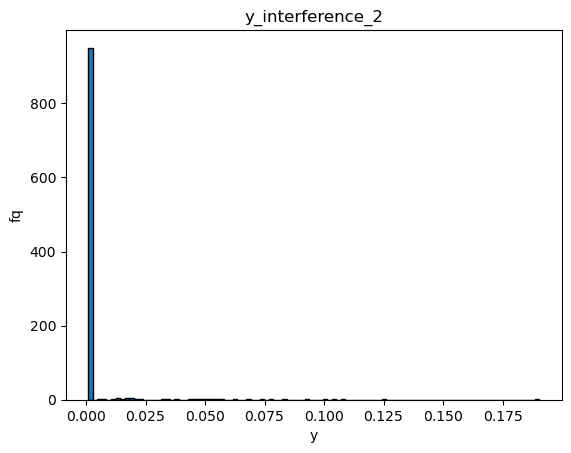

y_interference_2 sum:  4.022913723547266
The score for greedy contagion is 600.0324.
The score for zero is 450.7805.
starting iteration:  14


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.011461346016981988
Pearson with predicted edge probs:  tensor(0.9954)
Spearman with predicted edge probs:  0.9951632549287849
Auc with predicted edge probs:  0.9681263157894736
Rmse of predicted edge probs:  0.44537254397164483
Pearson of predicted edge probs:  tensor(0.2372)
Spearman of predicted edge probs:  0.2609276965338198
Start gnn training.
u:  0.49565850442709897
b:  -8
b_xy*u_N:  1.7206366
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5446273127112438
u:  0.4935421393520434
b:  -8
b_xy*u_N:  1.8365678
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5137836343908555


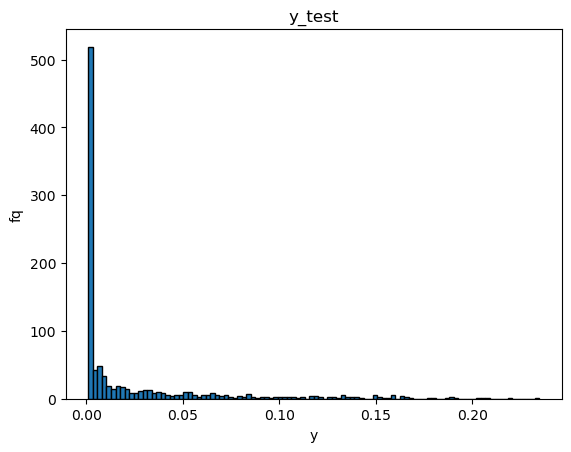

Epoch 0, Loss: 0.4311
Epoch 10, Loss: 0.3946
Epoch 20, Loss: 0.3696
Epoch 30, Loss: 0.3359
Epoch 40, Loss: 0.2639
Epoch 50, Loss: 0.1900
Epoch 60, Loss: 0.1408
Epoch 70, Loss: 0.1131
Epoch 80, Loss: 0.0891
Epoch 90, Loss: 0.0733
Epoch 100, Loss: 0.0733
Epoch 110, Loss: 0.0601
Epoch 120, Loss: 0.0652
Epoch 130, Loss: 0.0570
Epoch 140, Loss: 0.0605
Test GNN RMSE Loss: 0.0655
Test GNN pearson:  tensor(0.9644)
Test GNN spearman:  0.8012888328291127
Test GNN auc:  0.9938736842105262
Started with allocation.
Selected top 50 nodes based on baseline predictions: [390, 392, 149, 893, 659, 944, 669, 557, 303, 186], ...
Selected top 50 nodes based on baseline predictions: [207, 124, 605, 455, 617, 771, 497, 112, 618, 436], ...
u:  0.5041530069835293
b:  -8
b_xy*u_N:  1.8442
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4440512560460887


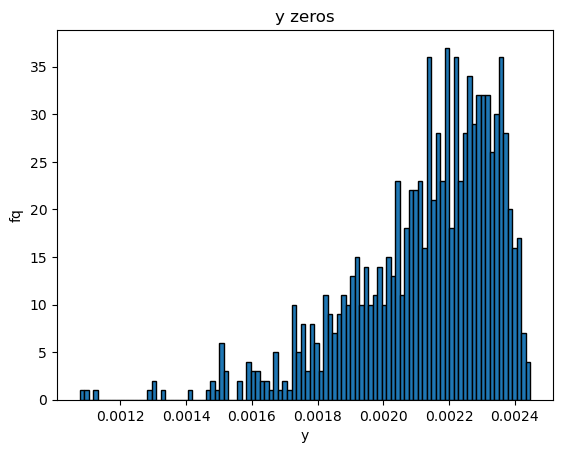

y_zero sum:  2.1292186492229623
u:  0.5041530069835293
b:  -8
b_xy*u_N:  1.8440916000000003
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4440512560460887


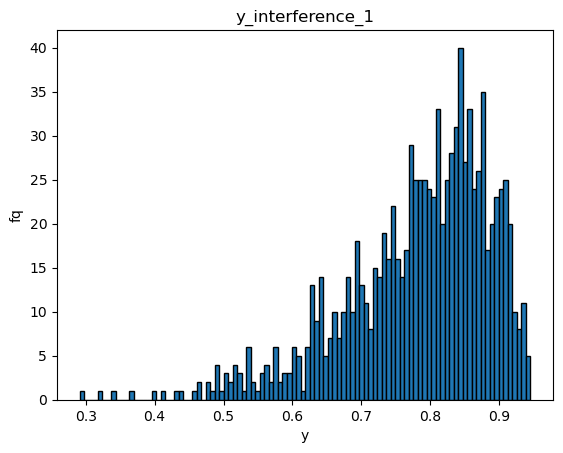

y_interference_1 sum:  4.604878865441175
The score for greedy interference is 781.6763000000001.
u:  0.5041530069835293
b:  -8
b_xy*u_N:  1.844193
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4440512560460887


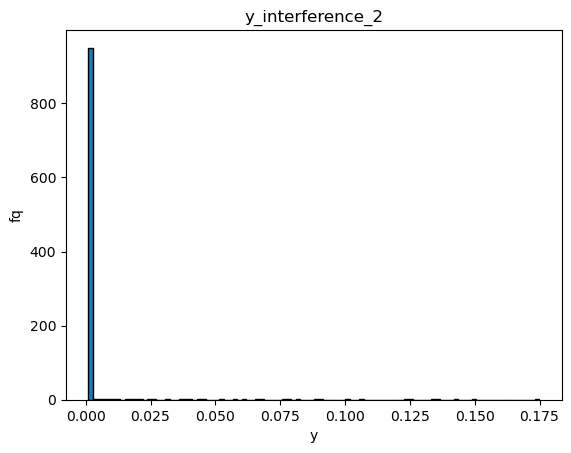

y_interference_2 sum:  4.701329035651358
The score for greedy contagion is 788.9628.
The score for zero is 656.6604000000001.
starting iteration:  15


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.01154721275441821
Pearson with predicted edge probs:  tensor(0.9940)
Spearman with predicted edge probs:  0.995235608891649
Auc with predicted edge probs:  0.9989263157894737
Rmse of predicted edge probs:  0.03594561360860497
Pearson of predicted edge probs:  tensor(0.3545)
Spearman of predicted edge probs:  0.344772879822259
Start gnn training.
u:  0.49586238110543174
b:  -8
b_xy*u_N:  1.5794232000000001
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.484896756772159
u:  0.49846832938348506
b:  -8
b_xy*u_N:  1.8097952
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.504657438079025


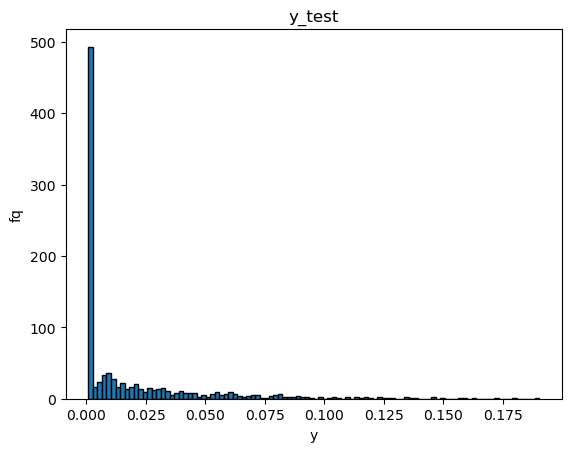

Epoch 0, Loss: 0.4126
Epoch 10, Loss: 0.3511
Epoch 20, Loss: 0.3174
Epoch 30, Loss: 0.2768
Epoch 40, Loss: 0.1929
Epoch 50, Loss: 0.1524
Epoch 60, Loss: 0.1227
Epoch 70, Loss: 0.0972
Epoch 80, Loss: 0.1101
Epoch 90, Loss: 0.0775
Epoch 100, Loss: 0.0923
Epoch 110, Loss: 0.0708
Epoch 120, Loss: 0.0742
Epoch 130, Loss: 0.0763
Epoch 140, Loss: 0.0655
Test GNN RMSE Loss: 0.0642
Test GNN pearson:  tensor(0.9674)
Test GNN spearman:  0.9013959259849021
Test GNN auc:  0.9955157894736842
Started with allocation.
Selected top 50 nodes based on baseline predictions: [202, 463, 443, 343, 67, 903, 107, 354, 442, 228], ...
Selected top 50 nodes based on baseline predictions: [749, 771, 240, 14, 671, 709, 157, 497, 662, 153], ...
u:  0.4969462166784001
b:  -8
b_xy*u_N:  1.788182
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4954692356111448


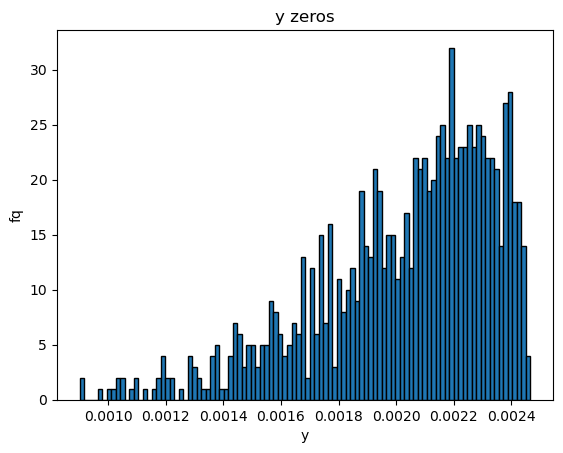

y_zero sum:  2.0291594031674594
u:  0.4969462166784001
b:  -8
b_xy*u_N:  1.7881546000000001
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4954692356111448


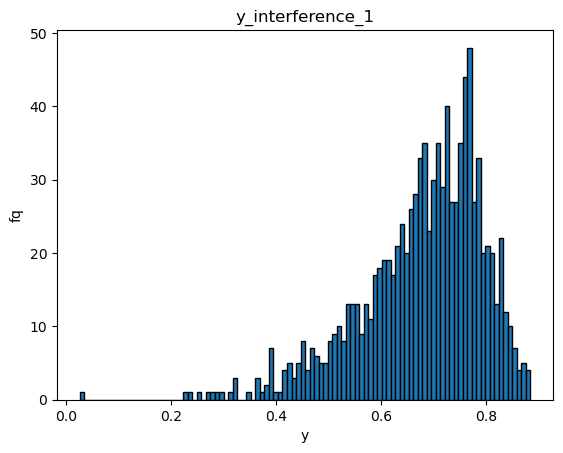

y_interference_1 sum:  3.4780789972358357
The score for greedy interference is 678.0976999999999.
u:  0.4969462166784001
b:  -8
b_xy*u_N:  1.7884967999999999
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4954692356111448


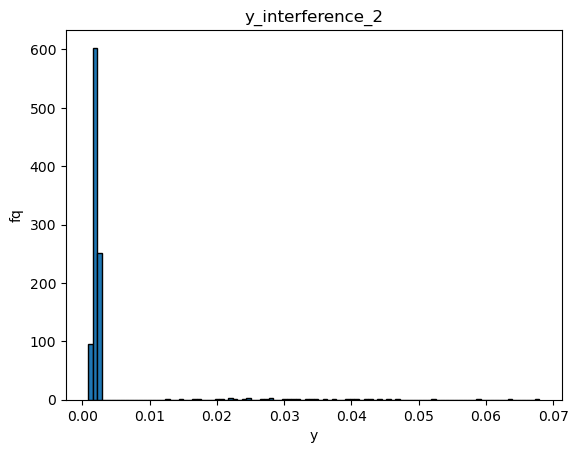

y_interference_2 sum:  3.5703703367553086
The score for greedy contagion is 691.2137.
The score for zero is 570.3569.
starting iteration:  16


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.011519192008514114
Pearson with predicted edge probs:  tensor(0.9956)
Spearman with predicted edge probs:  0.9963933560192971
Auc with predicted edge probs:  0.9985473684210526
Rmse of predicted edge probs:  0.053191475527597024
Pearson of predicted edge probs:  tensor(0.2599)
Spearman of predicted edge probs:  0.3046365755107082
Start gnn training.
u:  0.4986596264814675
b:  -8
b_xy*u_N:  1.8757084
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4399544571301455
u:  0.4956311946464557
b:  -8
b_xy*u_N:  1.720656
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4645226551938975


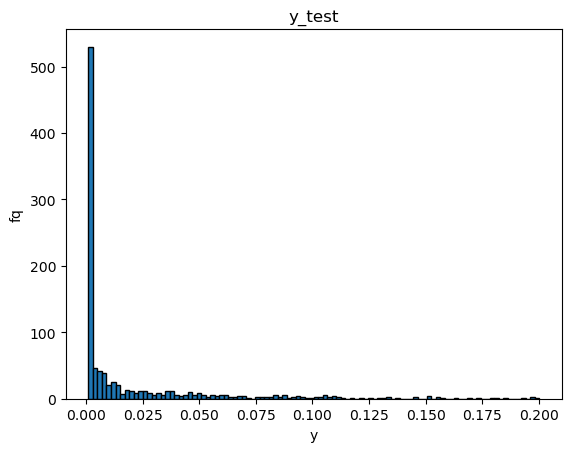

Epoch 0, Loss: 0.4340
Epoch 10, Loss: 0.3743
Epoch 20, Loss: 0.3613
Epoch 30, Loss: 0.3464
Epoch 40, Loss: 0.3152
Epoch 50, Loss: 0.2752
Epoch 60, Loss: 0.2297
Epoch 70, Loss: 0.1722
Epoch 80, Loss: 0.1487
Epoch 90, Loss: 0.1051
Epoch 100, Loss: 0.1069
Epoch 110, Loss: 0.0869
Epoch 120, Loss: 0.1080
Epoch 130, Loss: 0.1235
Epoch 140, Loss: 0.0888
Test GNN RMSE Loss: 0.0381
Test GNN pearson:  tensor(0.9661)
Test GNN spearman:  0.824069322429358
Test GNN auc:  0.9951157894736842
Started with allocation.
Selected top 50 nodes based on baseline predictions: [754, 738, 179, 715, 451, 924, 364, 969, 789, 826], ...
Selected top 50 nodes based on baseline predictions: [658, 913, 584, 864, 433, 578, 119, 164, 851, 82], ...
u:  0.49738939381460956
b:  -8
b_xy*u_N:  1.7210161999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.505838607863325


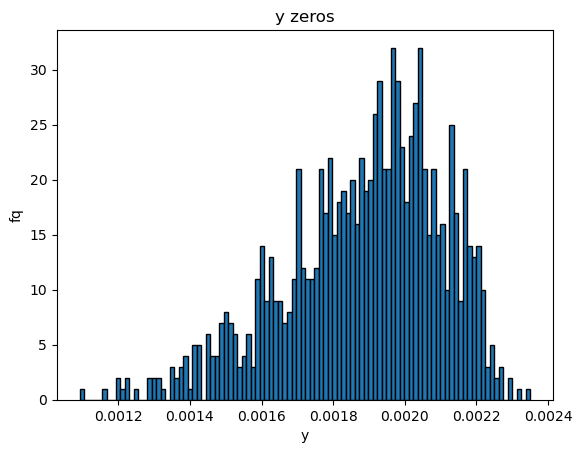

y_zero sum:  1.8854027782615876
u:  0.49738939381460956
b:  -8
b_xy*u_N:  1.7208892
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.505838607863325


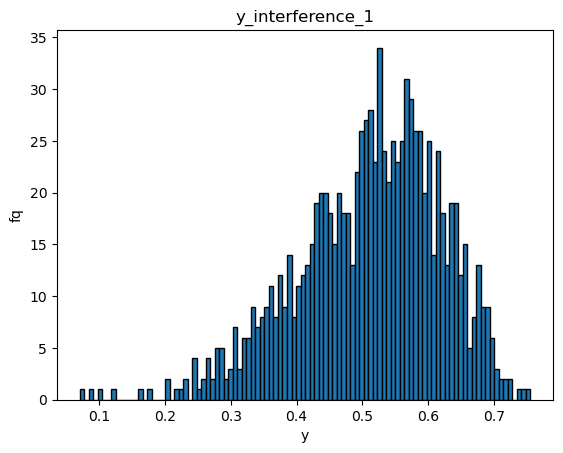

y_interference_1 sum:  4.078223199629693
The score for greedy interference is 511.1016.
u:  0.49738939381460956
b:  -8
b_xy*u_N:  1.7211064
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.505838607863325


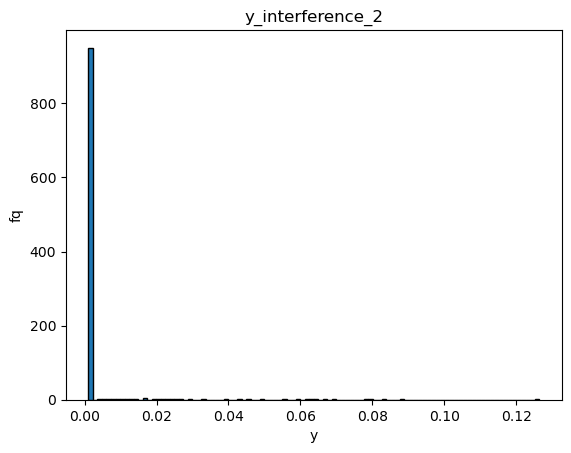

y_interference_2 sum:  3.4171051169600766
The score for greedy contagion is 509.05269999999996.
The score for zero is 376.782.
starting iteration:  17


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.010397109781288197
Pearson with predicted edge probs:  tensor(0.9962)
Spearman with predicted edge probs:  0.9966044209339168
Auc with predicted edge probs:  0.9990947368421053
Rmse of predicted edge probs:  0.038736983841540486
Pearson of predicted edge probs:  tensor(0.3531)
Spearman of predicted edge probs:  0.3507095310124973
Start gnn training.
u:  0.4929635742611127
b:  -8
b_xy*u_N:  1.8982595999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4726634336352005
u:  0.5010365248969
b:  -8
b_xy*u_N:  1.7270158000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4609543128213773


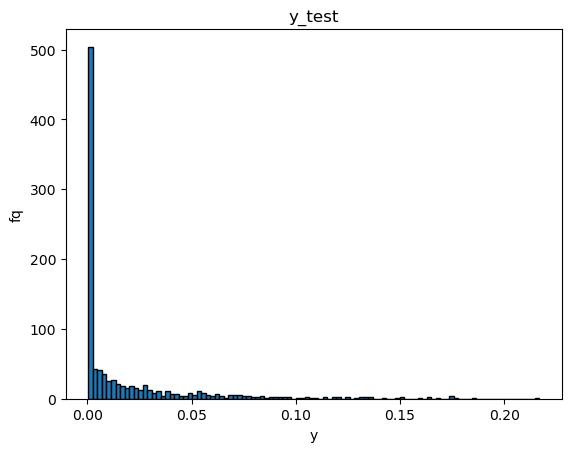

Epoch 0, Loss: 0.4390
Epoch 10, Loss: 0.3846
Epoch 20, Loss: 0.3440
Epoch 30, Loss: 0.3011
Epoch 40, Loss: 0.2243
Epoch 50, Loss: 0.1581
Epoch 60, Loss: 0.1203
Epoch 70, Loss: 0.0959
Epoch 80, Loss: 0.0781
Epoch 90, Loss: 0.0795
Epoch 100, Loss: 0.0629
Epoch 110, Loss: 0.0638
Epoch 120, Loss: 0.0601
Epoch 130, Loss: 0.0661
Epoch 140, Loss: 0.0593
Test GNN RMSE Loss: 0.0715
Test GNN pearson:  tensor(0.9452)
Test GNN spearman:  0.6484782883502527
Test GNN auc:  0.9935368421052632
Started with allocation.
Selected top 50 nodes based on baseline predictions: [540, 288, 119, 165, 635, 260, 264, 881, 683, 336], ...
Selected top 50 nodes based on baseline predictions: [974, 819, 924, 244, 973, 944, 757, 270, 633, 456], ...
u:  0.5038422587154627
b:  -8
b_xy*u_N:  1.7294917999999997
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5305152021604123


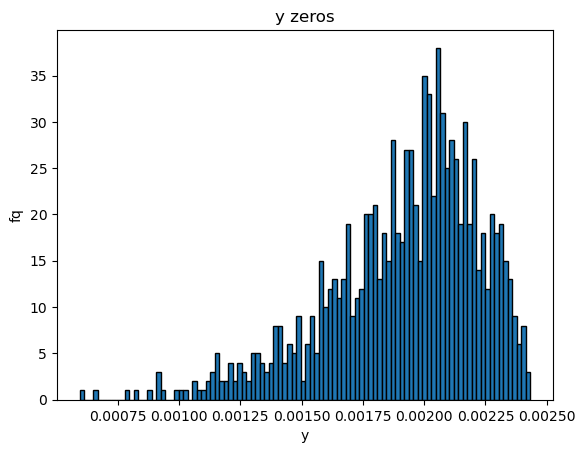

y_zero sum:  1.9170437458174237
u:  0.5038422587154627
b:  -8
b_xy*u_N:  1.7296536
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5305152021604123


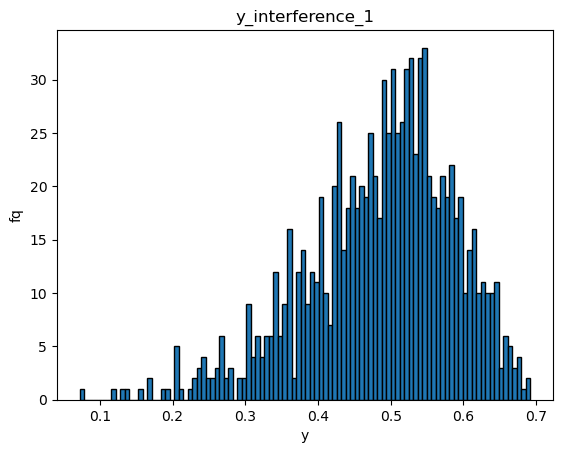

y_interference_1 sum:  2.6668971768868857
The score for greedy interference is 486.67099999999994.
u:  0.5038422587154627
b:  -8
b_xy*u_N:  1.7293598
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5305152021604123


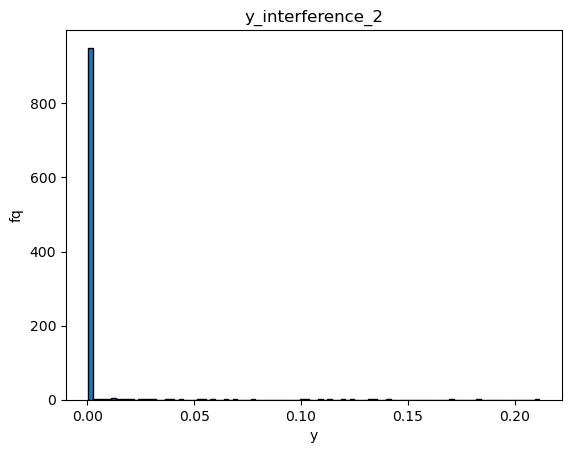

y_interference_2 sum:  4.633071018839654
The score for greedy contagion is 586.4875.
The score for zero is 421.571.
starting iteration:  18


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.011785379252593512
Pearson with predicted edge probs:  tensor(0.9961)
Spearman with predicted edge probs:  0.9971682896902727
Auc with predicted edge probs:  0.999178947368421
Rmse of predicted edge probs:  0.14671442405327628
Pearson of predicted edge probs:  tensor(0.1964)
Spearman of predicted edge probs:  0.2842940701094889
Start gnn training.
u:  0.5029054052040344
b:  -8
b_xy*u_N:  1.7424533999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5238889668284923
u:  0.5090694517122367
b:  -8
b_xy*u_N:  1.7878042
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.42623511983389


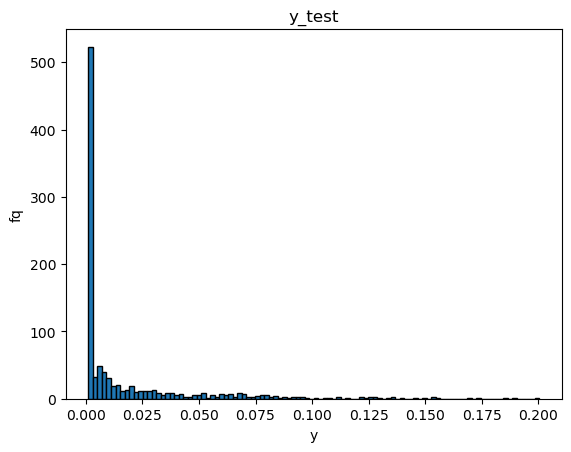

Epoch 0, Loss: 0.4275
Epoch 10, Loss: 0.3923
Epoch 20, Loss: 0.3842
Epoch 30, Loss: 0.3761
Epoch 40, Loss: 0.3803
Epoch 50, Loss: 0.3368
Epoch 60, Loss: 0.2979
Epoch 70, Loss: 0.2334
Epoch 80, Loss: 0.1585
Epoch 90, Loss: 0.1351
Epoch 100, Loss: 0.1172
Epoch 110, Loss: 0.1226
Epoch 120, Loss: 0.0937
Epoch 130, Loss: 0.1026
Epoch 140, Loss: 0.0921
Test GNN RMSE Loss: 0.0557
Test GNN pearson:  tensor(0.9501)
Test GNN spearman:  0.624969707462817
Test GNN auc:  0.9927368421052631
Started with allocation.
Selected top 50 nodes based on baseline predictions: [172, 167, 256, 524, 799, 115, 541, 8, 377, 787], ...
Selected top 50 nodes based on baseline predictions: [530, 996, 340, 731, 314, 27, 384, 645, 619, 753], ...
u:  0.5004137837246349
b:  -8
b_xy*u_N:  1.7883539999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5117762590357775


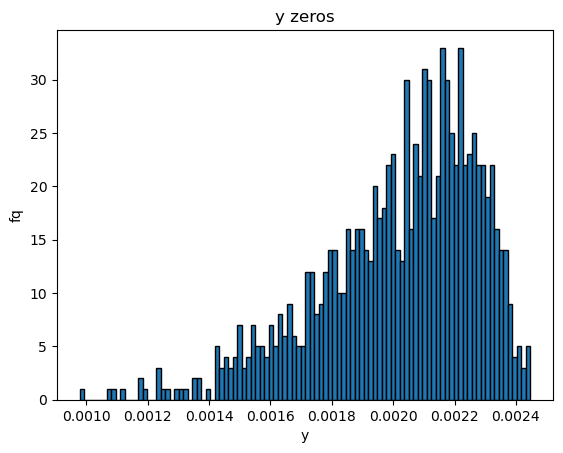

y_zero sum:  2.0200269255898005
u:  0.5004137837246349
b:  -8
b_xy*u_N:  1.787641
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5117762590357775


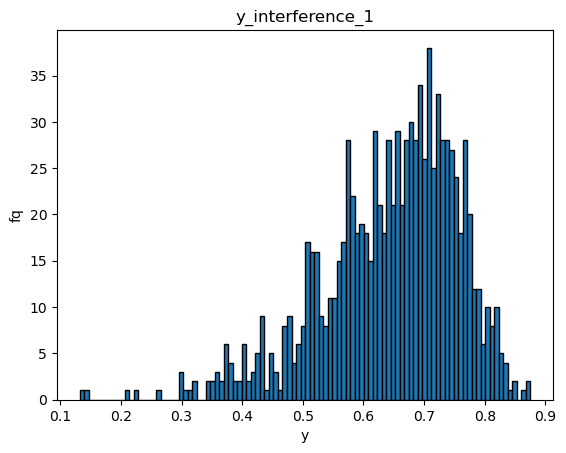

y_interference_1 sum:  3.44906926541687
The score for greedy interference is 643.6414.
u:  0.5004137837246349
b:  -8
b_xy*u_N:  1.7877094
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5117762590357775


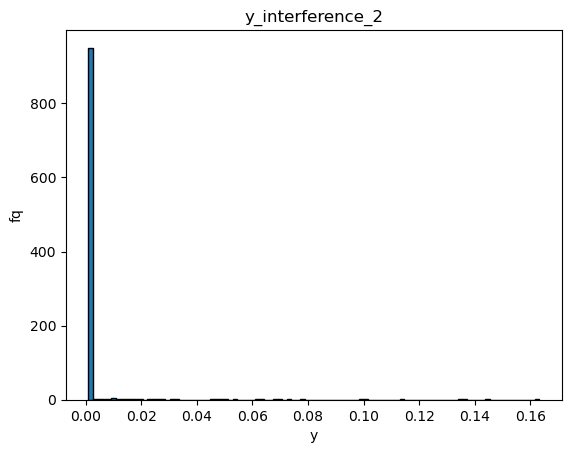

y_interference_2 sum:  4.009562015561234
The score for greedy contagion is 680.3446000000001.
The score for zero is 548.2973.
starting iteration:  19


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.011183030810413191
Pearson with predicted edge probs:  tensor(0.9957)
Spearman with predicted edge probs:  0.9958911158943159
Auc with predicted edge probs:  0.9746315789473685
Rmse of predicted edge probs:  0.4161797320707512
Pearson of predicted edge probs:  tensor(0.1380)
Spearman of predicted edge probs:  0.16750252780550173
Start gnn training.
u:  0.49207830414054954
b:  -8
b_xy*u_N:  1.6938544000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4414030430198643
u:  0.4866719780251984
b:  -8
b_xy*u_N:  1.8256648
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.476384199861876


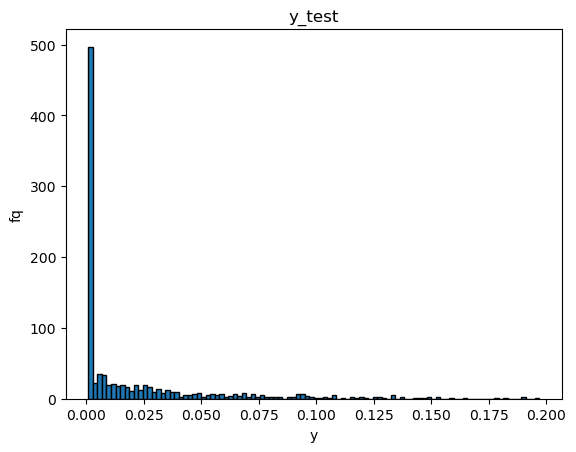

Epoch 0, Loss: 0.4162
Epoch 10, Loss: 0.3760
Epoch 20, Loss: 0.3575
Epoch 30, Loss: 0.3259
Epoch 40, Loss: 0.2885
Epoch 50, Loss: 0.2015
Epoch 60, Loss: 0.1838
Epoch 70, Loss: 0.1486
Epoch 80, Loss: 0.1038
Epoch 90, Loss: 0.0881
Epoch 100, Loss: 0.1014
Epoch 110, Loss: 0.0851
Epoch 120, Loss: 0.0859
Epoch 130, Loss: 0.0721
Epoch 140, Loss: 0.0658
Test GNN RMSE Loss: 0.0492
Test GNN pearson:  tensor(0.9692)
Test GNN spearman:  0.8941120717816058
Test GNN auc:  0.9929684210526315
Started with allocation.
Selected top 50 nodes based on baseline predictions: [657, 845, 17, 796, 904, 656, 179, 74, 955, 62], ...
Selected top 50 nodes based on baseline predictions: [348, 636, 209, 263, 881, 953, 199, 425, 838, 92], ...
u:  0.5058790093816843
b:  -8
b_xy*u_N:  1.8374940000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4921587377874177


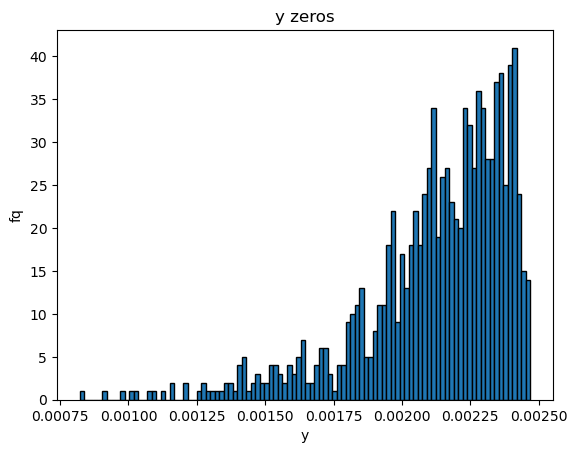

y_zero sum:  2.1236146932607283
u:  0.5058790093816843
b:  -8
b_xy*u_N:  1.837322
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4921587377874177


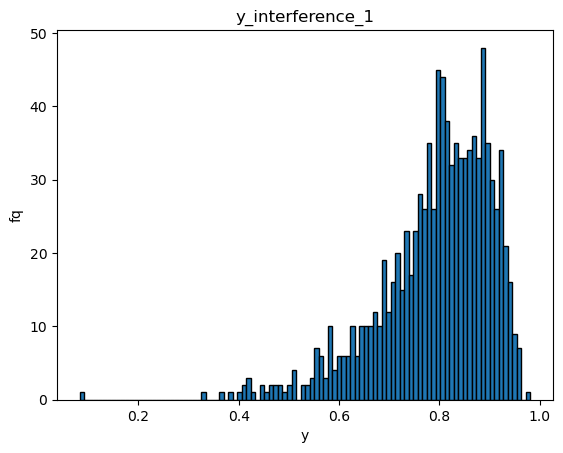

y_interference_1 sum:  6.973778147114674
The score for greedy interference is 792.6245.
u:  0.5058790093816843
b:  -8
b_xy*u_N:  1.8375476
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4921587377874177


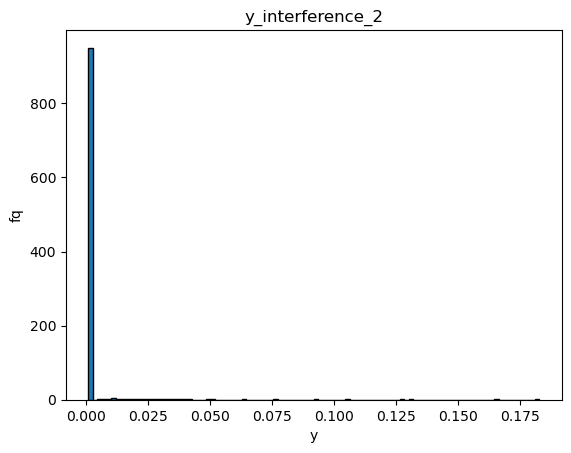

y_interference_2 sum:  4.132180470694195
The score for greedy contagion is 775.3436999999999.
The score for zero is 654.1030000000001.
y_int:
 mean=595.161015,
 ci_low=532.224383348029,
 ci_high=658.097646651971,
 std=131.0708382161161
pearson:
 mean=622.124375,
 ci_low=560.183951479266,
 ci_high=684.0647985207339,
 std=128.99615084611196
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
starting iteration:  0


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.011846332766230093
Pearson with predicted edge probs:  tensor(0.9935)
Spearman with predicted edge probs:  0.9962871400596035
Auc with predicted edge probs:  0.9981473684210527
Rmse of predicted edge probs:  0.05403783544639355
Pearson of predicted edge probs:  tensor(0.2030)
Spearman of predicted edge probs:  0.40852468146651694
Start gnn training.
u:  0.4975730393856891
b:  -9
b_xy*u_N:  1.6754765999999999
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.50871891130106
u:  0.5013382581672899
b:  -9
b_xy*u_N:  1.7018834
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4906078641534726


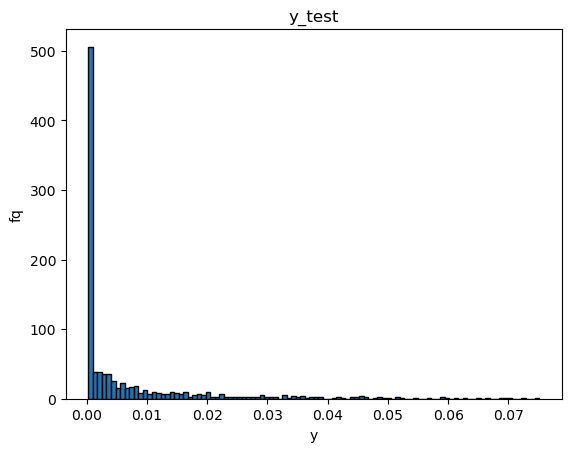

Epoch 0, Loss: 0.4500
Epoch 10, Loss: 0.3966
Epoch 20, Loss: 0.3920
Epoch 30, Loss: 0.3729
Epoch 40, Loss: 0.3374
Epoch 50, Loss: 0.2773
Epoch 60, Loss: 0.2093
Epoch 70, Loss: 0.1180
Epoch 80, Loss: 0.1491
Epoch 90, Loss: 0.1677
Epoch 100, Loss: 0.1285
Epoch 110, Loss: 0.0976
Epoch 120, Loss: 0.0668
Epoch 130, Loss: 0.1281
Epoch 140, Loss: 0.0835
Test GNN RMSE Loss: 0.0418
Test GNN pearson:  tensor(0.9816)
Test GNN spearman:  0.8344707026617908
Test GNN auc:  0.9983578947368421
Started with allocation.
Selected top 50 nodes based on baseline predictions: [255, 387, 877, 671, 96, 449, 218, 244, 544, 598], ...
Selected top 50 nodes based on baseline predictions: [987, 893, 918, 168, 299, 23, 869, 824, 861, 950], ...
u:  0.4966084089103479
b:  -9
b_xy*u_N:  1.7008615999999999
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.507066419356153


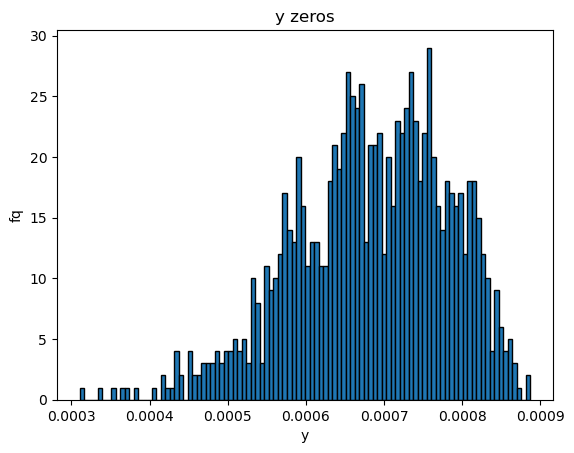

y_zero sum:  0.6834572758589113
u:  0.4966084089103479
b:  -9
b_xy*u_N:  1.7006718
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.507066419356153


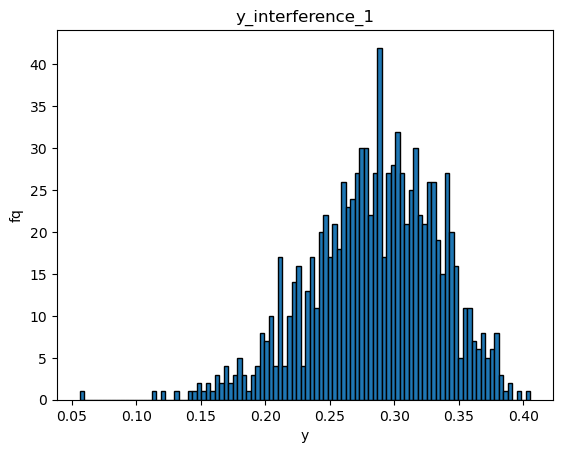

y_interference_1 sum:  1.2490378822862878
The score for greedy interference is 284.9932.
u:  0.4966084089103479
b:  -9
b_xy*u_N:  1.7003748
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.507066419356153


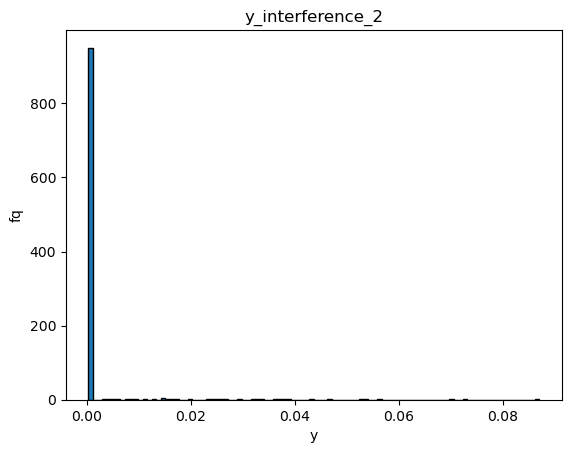

y_interference_2 sum:  1.9301138933777473
The score for greedy contagion is 399.5707.
The score for zero is 169.86239999999998.
starting iteration:  1


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.010869190149224415
Pearson with predicted edge probs:  tensor(0.9840)
Spearman with predicted edge probs:  0.9809488695158396
Auc with predicted edge probs:  0.9948
Rmse of predicted edge probs:  0.051519967548693056
Pearson of predicted edge probs:  tensor(0.0835)
Spearman of predicted edge probs:  0.1358775130621696
Start gnn training.
u:  0.49961732339540776
b:  -9
b_xy*u_N:  1.769392
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.51817990827652
u:  0.5074266041254423
b:  -9
b_xy*u_N:  1.5809289999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.503514951263679


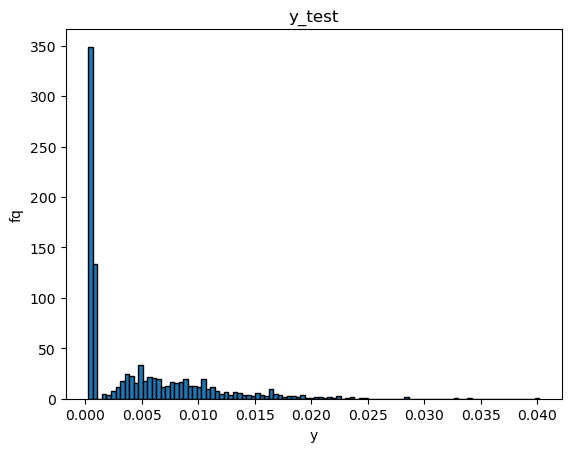

Epoch 0, Loss: 0.3137
Epoch 10, Loss: 0.2757
Epoch 20, Loss: 0.2689
Epoch 30, Loss: 0.2668
Epoch 40, Loss: 0.2500
Epoch 50, Loss: 0.2160
Epoch 60, Loss: 0.1744
Epoch 70, Loss: 0.1304
Epoch 80, Loss: 0.1098
Epoch 90, Loss: 0.0754
Epoch 100, Loss: 0.0781
Epoch 110, Loss: 0.0675
Epoch 120, Loss: 0.0649
Epoch 130, Loss: 0.0519
Epoch 140, Loss: 0.0558
Test GNN RMSE Loss: 0.0865
Test GNN pearson:  tensor(0.9660)
Test GNN spearman:  0.8920192036812251
Test GNN auc:  0.9926315789473684
Started with allocation.
Selected top 50 nodes based on baseline predictions: [830, 998, 432, 913, 472, 13, 361, 626, 251, 739], ...
Selected top 50 nodes based on baseline predictions: [536, 545, 550, 905, 384, 892, 194, 885, 488, 34], ...
u:  0.5032070597942571
b:  -9
b_xy*u_N:  1.5632886
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.481539315866895


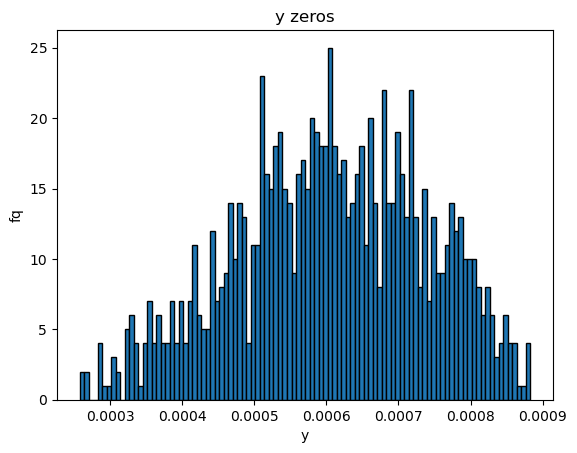

y_zero sum:  0.6048075545806595
u:  0.5032070597942571
b:  -9
b_xy*u_N:  1.5636498
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.481539315866895


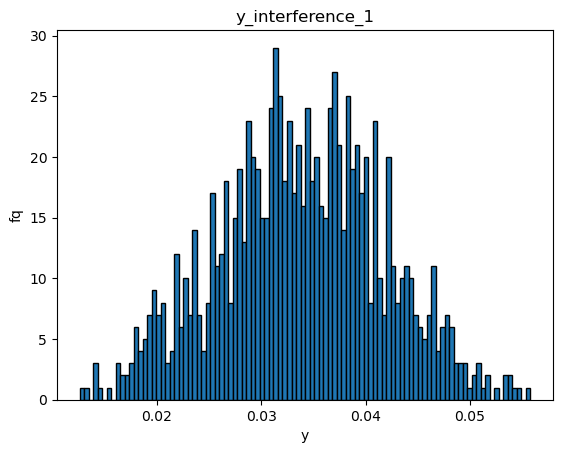

y_interference_1 sum:  0.8314344295588456
The score for greedy interference is 33.761100000000006.
u:  0.5032070597942571
b:  -9
b_xy*u_N:  1.564197
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.481539315866895


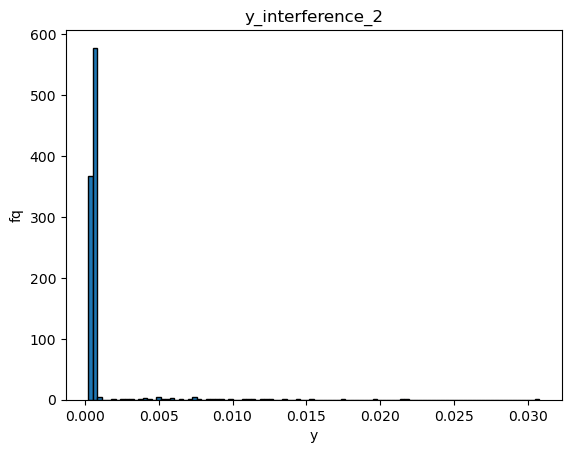

y_interference_2 sum:  1.0048057082381856
The score for greedy contagion is 45.475899999999996.
The score for zero is 26.253100000000003.
starting iteration:  2


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.011031723279684894
Pearson with predicted edge probs:  tensor(0.9941)
Spearman with predicted edge probs:  0.9958632215550542
Auc with predicted edge probs:  0.9985473684210526
Rmse of predicted edge probs:  0.0429474916214947
Pearson of predicted edge probs:  tensor(0.2072)
Spearman of predicted edge probs:  0.36780899260392064
Start gnn training.
u:  0.49705486593130077
b:  -9
b_xy*u_N:  1.6890619999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5010359814648684
u:  0.5008029350511731
b:  -9
b_xy*u_N:  1.7194880000000001
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4639364734302704


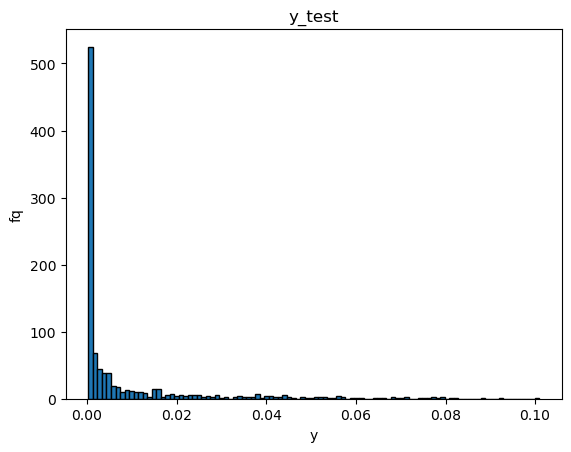

Epoch 0, Loss: 0.4499
Epoch 10, Loss: 0.4050
Epoch 20, Loss: 0.3963
Epoch 30, Loss: 0.3856
Epoch 40, Loss: 0.3595
Epoch 50, Loss: 0.3180
Epoch 60, Loss: 0.2651
Epoch 70, Loss: 0.2293
Epoch 80, Loss: 0.1688
Epoch 90, Loss: 0.1550
Epoch 100, Loss: 0.1167
Epoch 110, Loss: 0.1029
Epoch 120, Loss: 0.0886
Epoch 130, Loss: 0.0776
Epoch 140, Loss: 0.0766
Test GNN RMSE Loss: 0.0600
Test GNN pearson:  tensor(0.9306)
Test GNN spearman:  0.7974377328612431
Test GNN auc:  0.9815578947368422
Started with allocation.
Selected top 50 nodes based on baseline predictions: [522, 808, 490, 853, 72, 205, 978, 782, 61, 651], ...
Selected top 50 nodes based on baseline predictions: [231, 972, 789, 376, 751, 908, 446, 941, 70, 844], ...
u:  0.5000023077034117
b:  -9
b_xy*u_N:  1.7218966
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4826733257106297


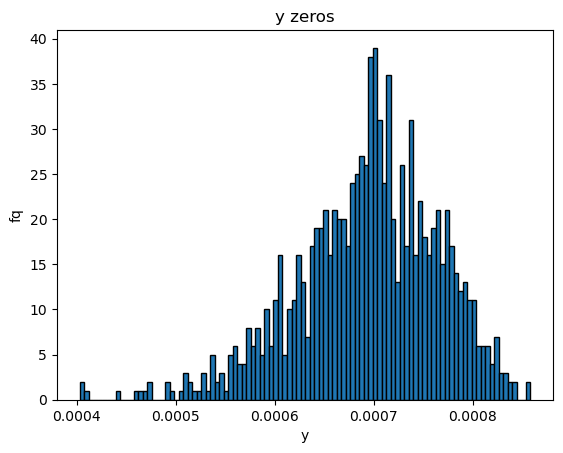

y_zero sum:  0.6939687978166996
u:  0.5000023077034117
b:  -9
b_xy*u_N:  1.7222346
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4826733257106297


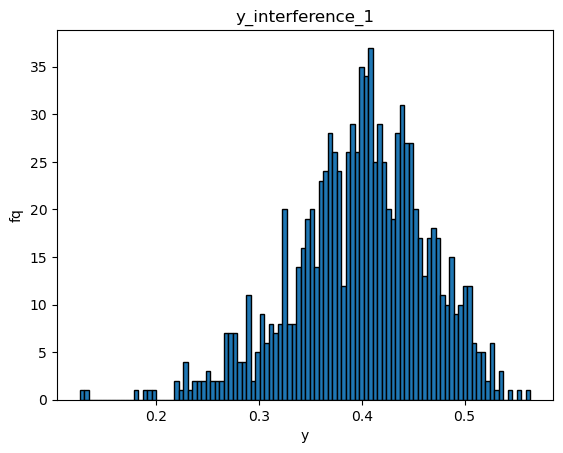

y_interference_1 sum:  1.84906193318901
The score for greedy interference is 399.455.
u:  0.5000023077034117
b:  -9
b_xy*u_N:  1.7220924
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4826733257106297


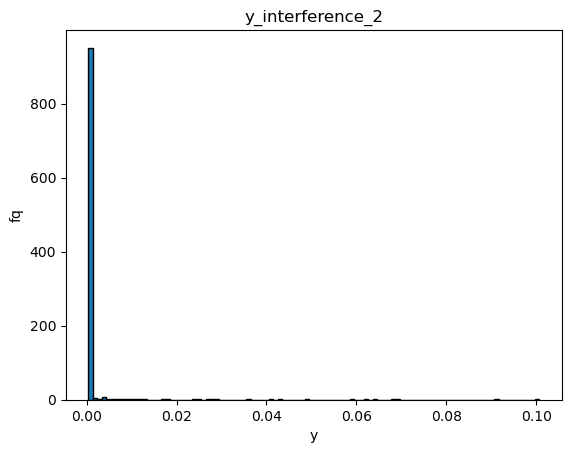

y_interference_2 sum:  1.6995056223234406
The score for greedy contagion is 409.3559.
The score for zero is 197.26839999999999.
starting iteration:  3


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.010772930323917853
Pearson with predicted edge probs:  tensor(0.9928)
Spearman with predicted edge probs:  0.9953127535146449
Auc with predicted edge probs:  0.9994315789473684
Rmse of predicted edge probs:  0.026902517374109036
Pearson of predicted edge probs:  tensor(0.2340)
Spearman of predicted edge probs:  0.3513078487994196
Start gnn training.
u:  0.5093331631788238
b:  -9
b_xy*u_N:  1.6825016000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.495141615740407
u:  0.49346940989801097
b:  -9
b_xy*u_N:  1.7021914000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.461181955493462


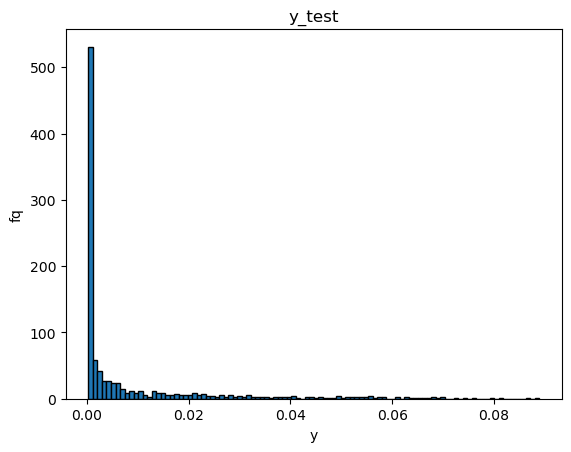

Epoch 0, Loss: 0.4529
Epoch 10, Loss: 0.4095
Epoch 20, Loss: 0.3911
Epoch 30, Loss: 0.3653
Epoch 40, Loss: 0.3150
Epoch 50, Loss: 0.2323
Epoch 60, Loss: 0.1713
Epoch 70, Loss: 0.1468
Epoch 80, Loss: 0.1236
Epoch 90, Loss: 0.1114
Epoch 100, Loss: 0.1100
Epoch 110, Loss: 0.0962
Epoch 120, Loss: 0.0986
Epoch 130, Loss: 0.0986
Epoch 140, Loss: 0.0851
Test GNN RMSE Loss: 0.0756
Test GNN pearson:  tensor(0.9637)
Test GNN spearman:  0.6589614975283475
Test GNN auc:  0.9974947368421052
Started with allocation.
Selected top 50 nodes based on baseline predictions: [834, 820, 311, 97, 835, 357, 354, 422, 659, 16], ...
Selected top 50 nodes based on baseline predictions: [113, 30, 712, 978, 240, 834, 287, 588, 736, 858], ...
u:  0.5071488358103697
b:  -9
b_xy*u_N:  1.7063132
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.510081523623818


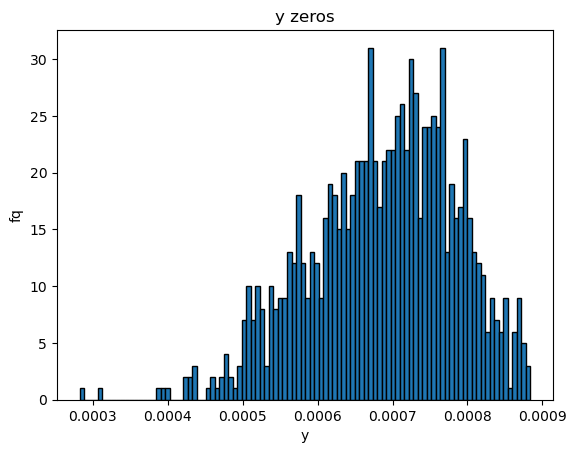

y_zero sum:  0.6867951418015737
u:  0.5071488358103697
b:  -9
b_xy*u_N:  1.7061624000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.510081523623818


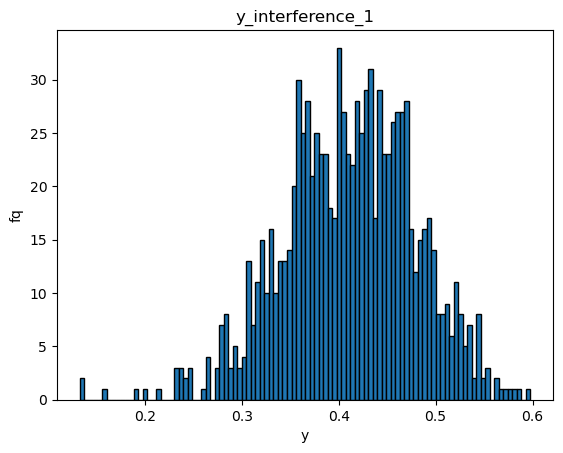

y_interference_1 sum:  2.4585829610786734
The score for greedy interference is 410.9253.
u:  0.5071488358103697
b:  -9
b_xy*u_N:  1.706344
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.510081523623818


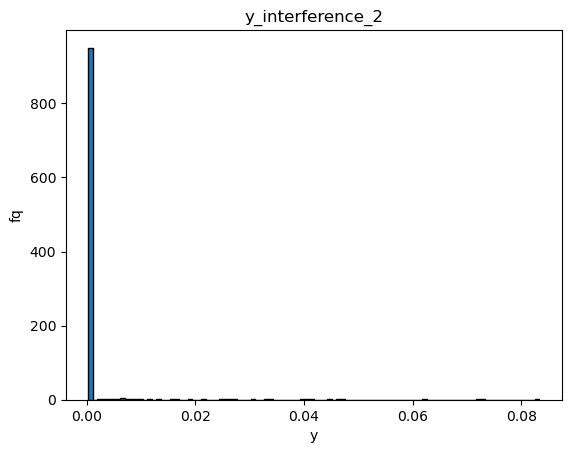

y_interference_2 sum:  1.7113910485667025
The score for greedy contagion is 360.6302.
The score for zero is 167.4861.
starting iteration:  4


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.011061595342937372
Pearson with predicted edge probs:  tensor(0.9921)
Spearman with predicted edge probs:  0.9944967099803107
Auc with predicted edge probs:  0.9983578947368421
Rmse of predicted edge probs:  0.02534903733413145
Pearson of predicted edge probs:  tensor(0.2043)
Spearman of predicted edge probs:  0.2887605822805049
Start gnn training.
u:  0.5016798411481688
b:  -9
b_xy*u_N:  1.6966898000000001
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.528520888486493
u:  0.501038446851869
b:  -9
b_xy*u_N:  1.7278179999999999
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.494480552197213


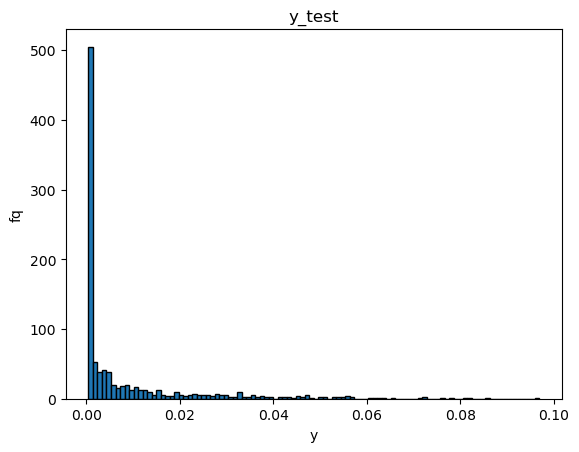

Epoch 0, Loss: 0.4323
Epoch 10, Loss: 0.4014
Epoch 20, Loss: 0.3927
Epoch 30, Loss: 0.3749
Epoch 40, Loss: 0.3525
Epoch 50, Loss: 0.3052
Epoch 60, Loss: 0.2417
Epoch 70, Loss: 0.1780
Epoch 80, Loss: 0.1569
Epoch 90, Loss: 0.1236
Epoch 100, Loss: 0.1085
Epoch 110, Loss: 0.0882
Epoch 120, Loss: 0.0958
Epoch 130, Loss: 0.0895
Epoch 140, Loss: 0.0683
Test GNN RMSE Loss: 0.0621
Test GNN pearson:  tensor(0.9739)
Test GNN spearman:  0.8763553198086278
Test GNN auc:  0.9973263157894737
Started with allocation.
Selected top 50 nodes based on baseline predictions: [199, 820, 64, 817, 125, 82, 22, 392, 461, 667], ...
Selected top 50 nodes based on baseline predictions: [801, 193, 918, 973, 197, 841, 2, 796, 47, 108], ...
u:  0.5033230369707266
b:  -9
b_xy*u_N:  1.7286578
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4623164932788226


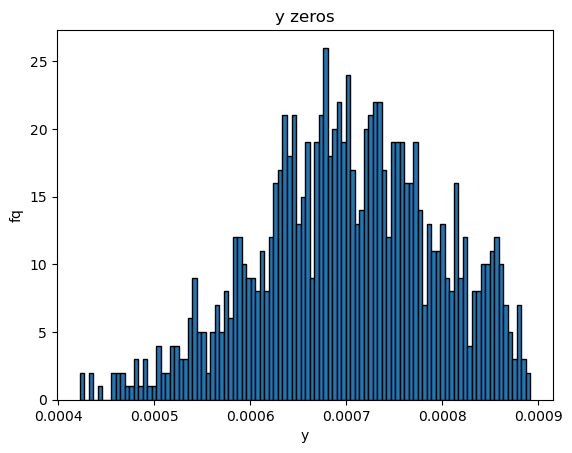

y_zero sum:  0.7011945242631861
u:  0.5033230369707266
b:  -9
b_xy*u_N:  1.7283992000000004
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4623164932788226


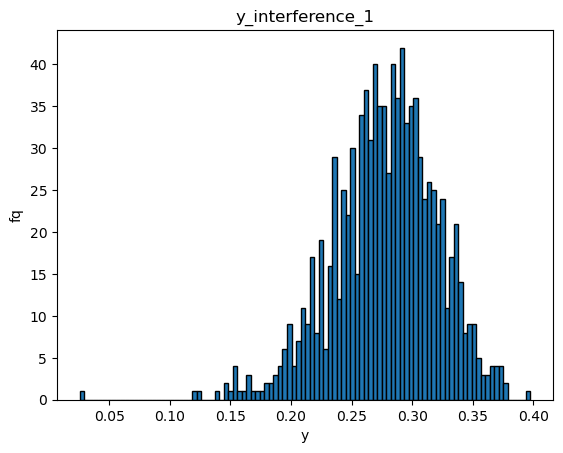

y_interference_1 sum:  1.1875878399329542
The score for greedy interference is 277.62260000000003.
u:  0.5033230369707266
b:  -9
b_xy*u_N:  1.7283560000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4623164932788226


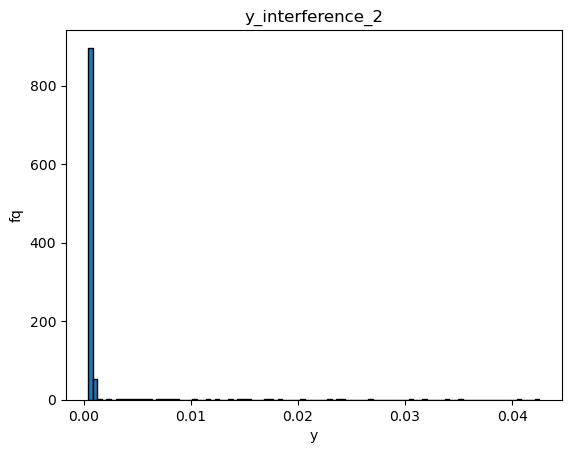

y_interference_2 sum:  1.3055311889412615
The score for greedy contagion is 318.2684.
The score for zero is 179.10989999999998.
starting iteration:  5


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.01329548855698583
Pearson with predicted edge probs:  tensor(0.9933)
Spearman with predicted edge probs:  0.9948841638455325
Auc with predicted edge probs:  0.997978947368421
Rmse of predicted edge probs:  0.02513466367382965
Pearson of predicted edge probs:  tensor(0.2815)
Spearman of predicted edge probs:  0.37832257148200726
Start gnn training.
u:  0.4920737478479004
b:  -9
b_xy*u_N:  1.6715082
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5035249318940913
u:  0.4958715669968415
b:  -9
b_xy*u_N:  1.6860082000000003
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.472015109558211


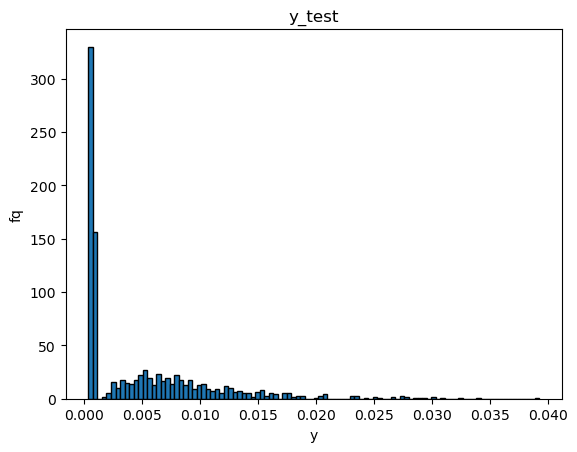

Epoch 0, Loss: 0.3256
Epoch 10, Loss: 0.2818
Epoch 20, Loss: 0.2756
Epoch 30, Loss: 0.2702
Epoch 40, Loss: 0.2336
Epoch 50, Loss: 0.1905
Epoch 60, Loss: 0.1332
Epoch 70, Loss: 0.0963
Epoch 80, Loss: 0.0780
Epoch 90, Loss: 0.0679
Epoch 100, Loss: 0.0686
Epoch 110, Loss: 0.0665
Epoch 120, Loss: 0.0589
Epoch 130, Loss: 0.0553
Epoch 140, Loss: 0.0587
Test GNN RMSE Loss: 0.0990
Test GNN pearson:  tensor(0.9734)
Test GNN spearman:  0.8266576162564012
Test GNN auc:  0.994378947368421
Started with allocation.
Selected top 50 nodes based on baseline predictions: [640, 91, 542, 463, 969, 448, 29, 873, 218, 403], ...
Selected top 50 nodes based on baseline predictions: [531, 918, 331, 534, 217, 778, 226, 194, 62, 31], ...
u:  0.4910293675164604
b:  -9
b_xy*u_N:  1.6929266
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.549988592240625


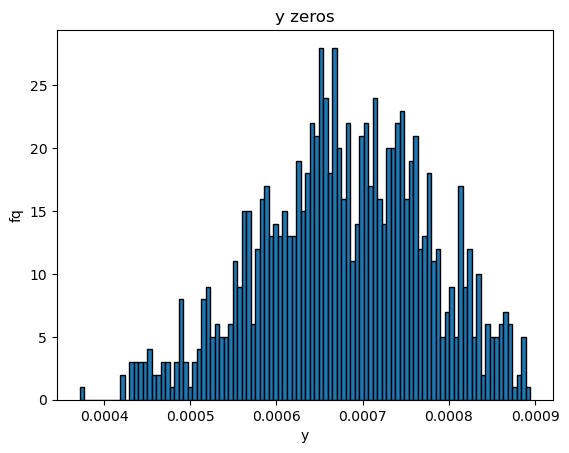

y_zero sum:  0.6777290082552291
u:  0.4910293675164604
b:  -9
b_xy*u_N:  1.6927346
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.549988592240625


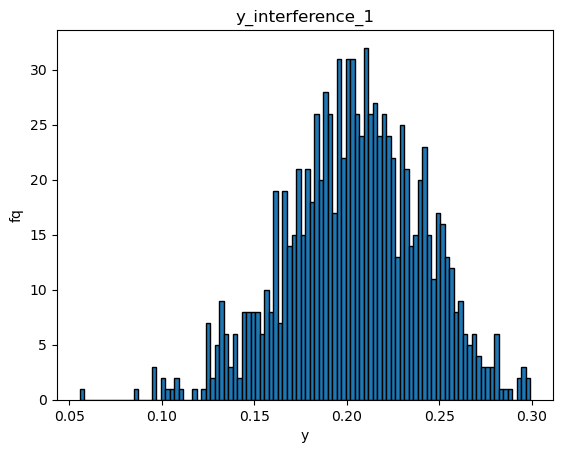

y_interference_1 sum:  1.072181246049895
The score for greedy interference is 204.3564.
u:  0.4910293675164604
b:  -9
b_xy*u_N:  1.6931786
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.549988592240625


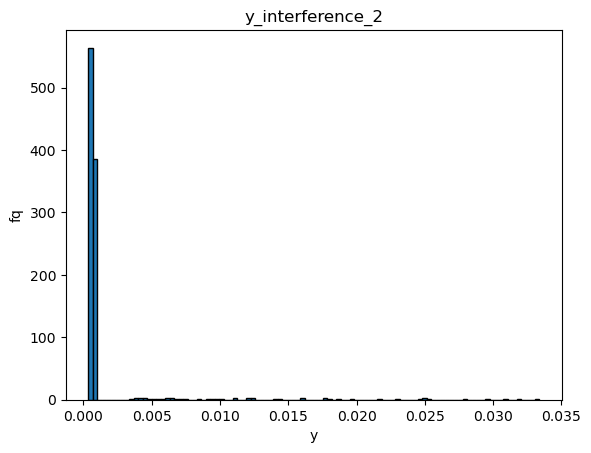

y_interference_2 sum:  1.3164635671136757
The score for greedy contagion is 269.8661.
The score for zero is 143.3205.
starting iteration:  6


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.011926727105560853
Pearson with predicted edge probs:  tensor(0.9916)
Spearman with predicted edge probs:  0.9947250468292476
Auc with predicted edge probs:  0.9988421052631579
Rmse of predicted edge probs:  0.05730442447836022
Pearson of predicted edge probs:  tensor(0.1693)
Spearman of predicted edge probs:  0.33781923071376646
Start gnn training.
u:  0.4946226681804112
b:  -9
b_xy*u_N:  1.7112692
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.485502688333921
u:  0.49960822951310907
b:  -9
b_xy*u_N:  1.7634695999999999
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4744497223823116


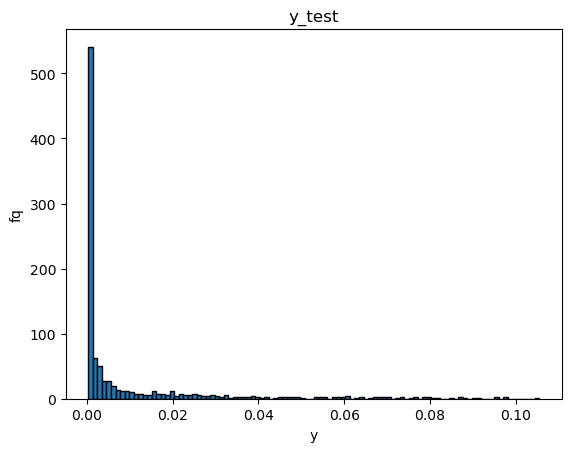

Epoch 0, Loss: 0.4530
Epoch 10, Loss: 0.4080
Epoch 20, Loss: 0.3937
Epoch 30, Loss: 0.3848
Epoch 40, Loss: 0.3779
Epoch 50, Loss: 0.3705
Epoch 60, Loss: 0.3240
Epoch 70, Loss: 0.2858
Epoch 80, Loss: 0.2116
Epoch 90, Loss: 0.1521
Epoch 100, Loss: 0.1330
Epoch 110, Loss: 0.1151
Epoch 120, Loss: 0.1154
Epoch 130, Loss: 0.1070
Epoch 140, Loss: 0.0867
Test GNN RMSE Loss: 0.0546
Test GNN pearson:  tensor(0.9046)
Test GNN spearman:  0.857189482339483
Test GNN auc:  0.9682105263157894
Started with allocation.
Selected top 50 nodes based on baseline predictions: [950, 858, 427, 251, 673, 290, 177, 429, 520, 971], ...
Selected top 50 nodes based on baseline predictions: [759, 850, 751, 621, 478, 481, 183, 406, 919, 976], ...
u:  0.5031977311757183
b:  -9
b_xy*u_N:  1.7540791999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4676721483369315


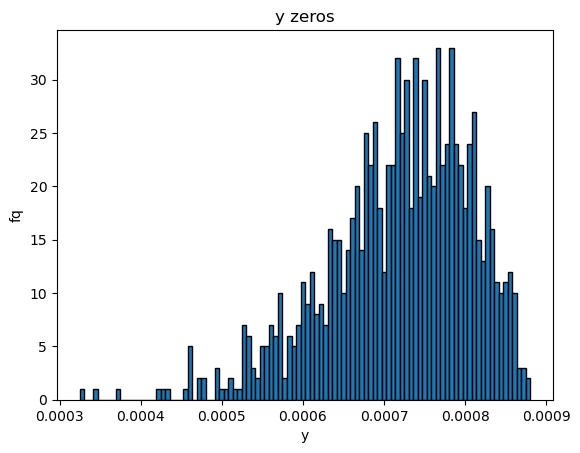

y_zero sum:  0.7186170147999708
u:  0.5031977311757183
b:  -9
b_xy*u_N:  1.7543338000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4676721483369315


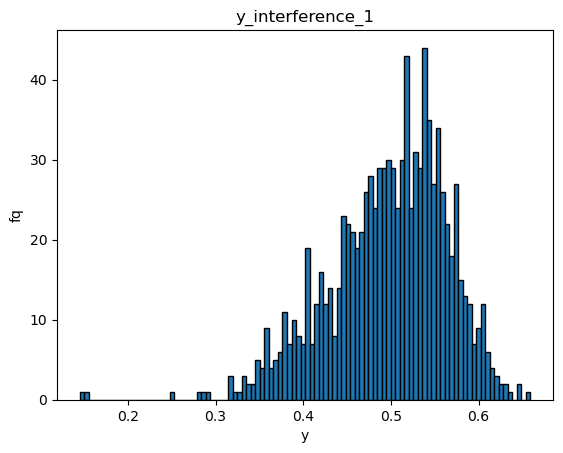

y_interference_1 sum:  2.134599476788029
The score for greedy interference is 496.8641.
u:  0.5031977311757183
b:  -9
b_xy*u_N:  1.7538862
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4676721483369315


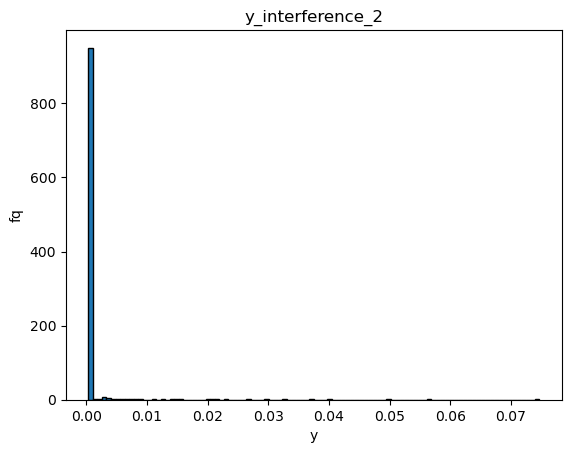

y_interference_2 sum:  1.3846090564287206
The score for greedy contagion is 414.6550000000001.
The score for zero is 247.6917.
starting iteration:  7


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.01089173229042964
Pearson with predicted edge probs:  tensor(0.9951)
Spearman with predicted edge probs:  0.9963377263822144
Auc with predicted edge probs:  0.9992842105263158
Rmse of predicted edge probs:  0.04175415189620641
Pearson of predicted edge probs:  tensor(0.2462)
Spearman of predicted edge probs:  0.37674839903177876
Start gnn training.
u:  0.5051419105350639
b:  -9
b_xy*u_N:  1.6641891999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.530746588727133
u:  0.5020088938502542
b:  -9
b_xy*u_N:  1.7465692000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4408472750371817


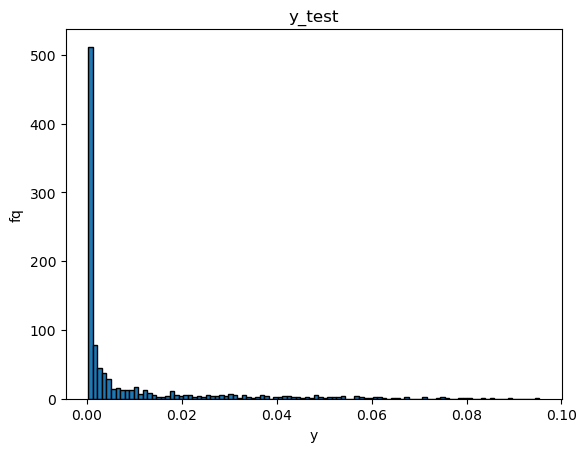

Epoch 0, Loss: 0.4680
Epoch 10, Loss: 0.4341
Epoch 20, Loss: 0.4231
Epoch 30, Loss: 0.3986
Epoch 40, Loss: 0.3343
Epoch 50, Loss: 0.2503
Epoch 60, Loss: 0.1813
Epoch 70, Loss: 0.1506
Epoch 80, Loss: 0.1159
Epoch 90, Loss: 0.1279
Epoch 100, Loss: 0.1201
Epoch 110, Loss: 0.1056
Epoch 120, Loss: 0.1133
Epoch 130, Loss: 0.1306
Epoch 140, Loss: 0.1040
Test GNN RMSE Loss: 0.0318
Test GNN pearson:  tensor(0.9693)
Test GNN spearman:  0.6353344352925827
Test GNN auc:  0.9935368421052632
Started with allocation.
Selected top 50 nodes based on baseline predictions: [150, 466, 859, 952, 704, 681, 841, 596, 532, 196], ...
Selected top 50 nodes based on baseline predictions: [945, 366, 71, 981, 239, 944, 640, 441, 571, 552], ...
u:  0.5073252933411186
b:  -9
b_xy*u_N:  1.7315512
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5016393784097684


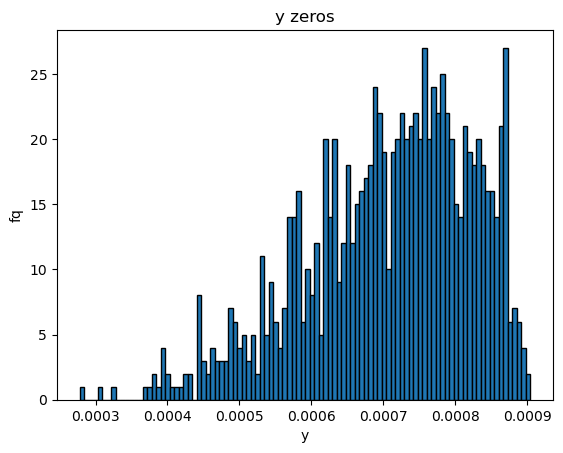

y_zero sum:  0.7074637747623513
u:  0.5073252933411186
b:  -9
b_xy*u_N:  1.7314274
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5016393784097684


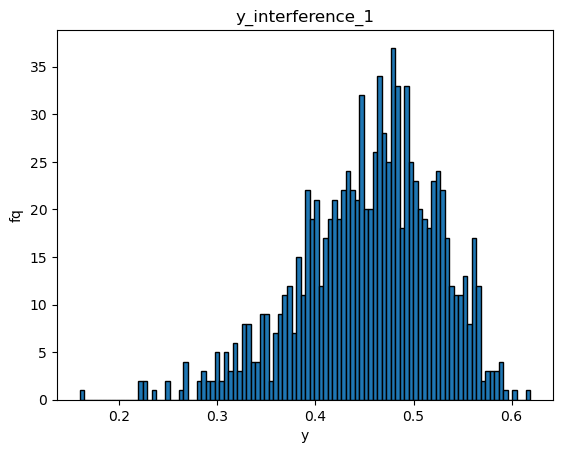

y_interference_1 sum:  2.1465097965422775
The score for greedy interference is 454.4258.
u:  0.5073252933411186
b:  -9
b_xy*u_N:  1.7316824000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5016393784097684


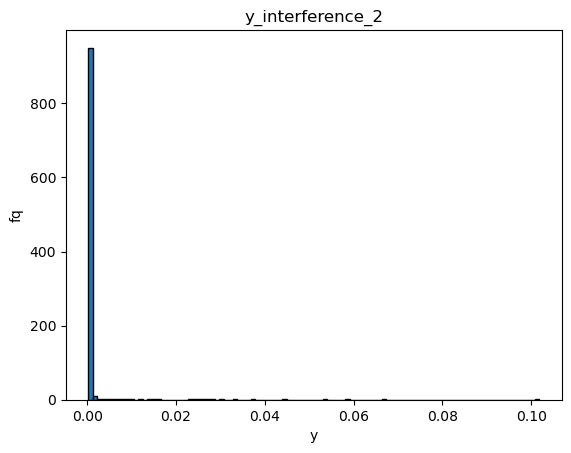

y_interference_2 sum:  1.5119576886476105
The score for greedy contagion is 414.09110000000004.
The score for zero is 224.56459999999998.
starting iteration:  8


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.010958124423806783
Pearson with predicted edge probs:  tensor(0.9915)
Spearman with predicted edge probs:  0.993168032704353
Auc with predicted edge probs:  0.9990526315789474
Rmse of predicted edge probs:  0.022888112385956942
Pearson of predicted edge probs:  tensor(0.2291)
Spearman of predicted edge probs:  0.3081387936353974
Start gnn training.
u:  0.509758635537886
b:  -9
b_xy*u_N:  1.6602305999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4624337550958737
u:  0.5008921658867737
b:  -9
b_xy*u_N:  1.691033
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5006942808733976


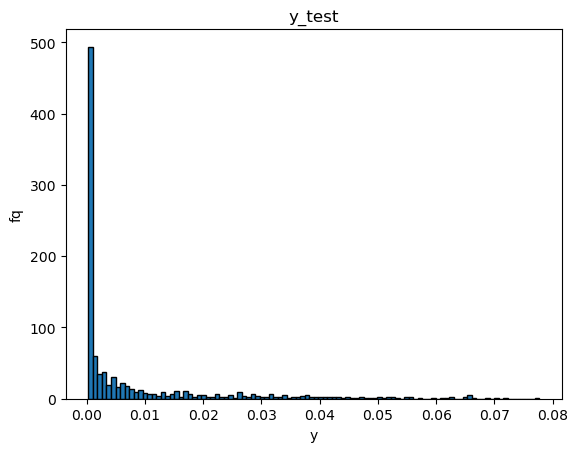

Epoch 0, Loss: 0.4339
Epoch 10, Loss: 0.3873
Epoch 20, Loss: 0.3591
Epoch 30, Loss: 0.3041
Epoch 40, Loss: 0.2086
Epoch 50, Loss: 0.1332
Epoch 60, Loss: 0.1352
Epoch 70, Loss: 0.0831
Epoch 80, Loss: 0.0913
Epoch 90, Loss: 0.0795
Epoch 100, Loss: 0.0748
Epoch 110, Loss: 0.0734
Epoch 120, Loss: 0.0686
Epoch 130, Loss: 0.0749
Epoch 140, Loss: 0.0560
Test GNN RMSE Loss: 0.0759
Test GNN pearson:  tensor(0.9832)
Test GNN spearman:  0.8238367183552565
Test GNN auc:  0.9973473684210526
Started with allocation.
Selected top 50 nodes based on baseline predictions: [25, 761, 760, 629, 914, 620, 943, 256, 874, 514], ...
Selected top 50 nodes based on baseline predictions: [754, 104, 846, 335, 49, 94, 157, 890, 820, 415], ...
u:  0.5000104354590731
b:  -9
b_xy*u_N:  1.6984202
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.493495977437553


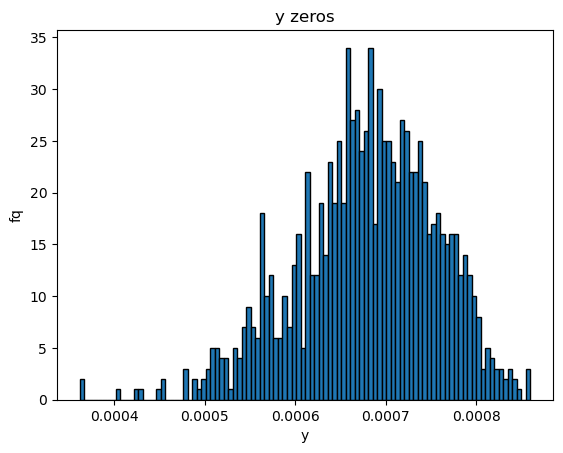

y_zero sum:  0.6787268882587929
u:  0.5000104354590731
b:  -9
b_xy*u_N:  1.6988134
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.493495977437553


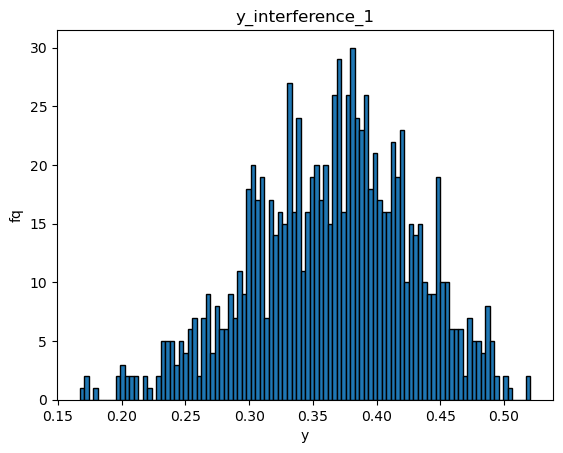

y_interference_1 sum:  2.1771436379471263
The score for greedy interference is 364.7732.
u:  0.5000104354590731
b:  -9
b_xy*u_N:  1.6982062
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.493495977437553


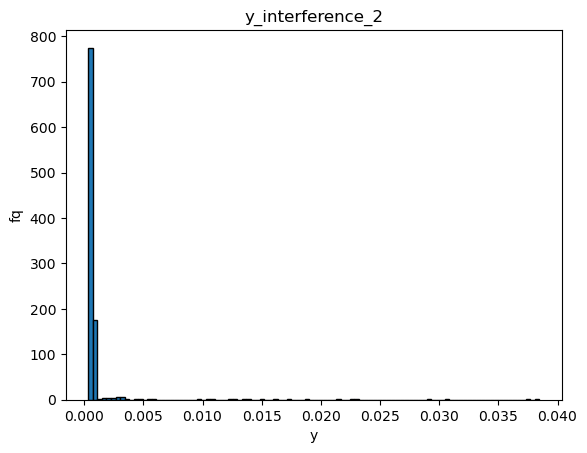

y_interference_2 sum:  1.1111492460942842
The score for greedy contagion is 249.95250000000004.
The score for zero is 156.70780000000002.
starting iteration:  9


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.011357271197763566
Pearson with predicted edge probs:  tensor(0.9917)
Spearman with predicted edge probs:  0.9941008329862114
Auc with predicted edge probs:  0.9979751647761318
Rmse of predicted edge probs:  0.04079910444929136
Pearson of predicted edge probs:  tensor(0.0679)
Spearman of predicted edge probs:  0.10488689987384558
Start gnn training.
u:  0.49626917963467737
b:  -9
b_xy*u_N:  1.6508365999999999
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5481318018455226
u:  0.5008025457091739
b:  -9
b_xy*u_N:  1.6873398
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4722151092401954


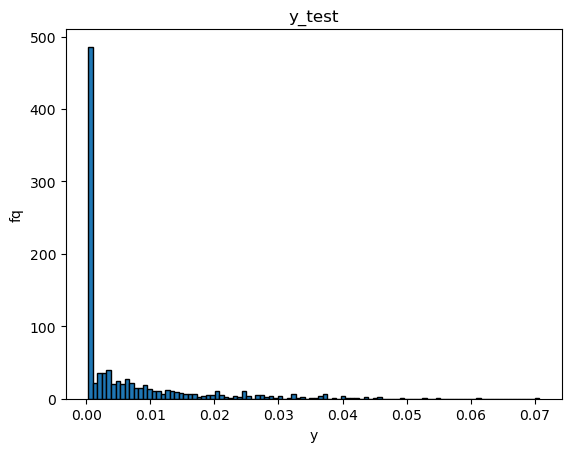

Epoch 0, Loss: 0.4156
Epoch 10, Loss: 0.3737
Epoch 20, Loss: 0.3610
Epoch 30, Loss: 0.3398
Epoch 40, Loss: 0.3104
Epoch 50, Loss: 0.2350
Epoch 60, Loss: 0.1395
Epoch 70, Loss: 0.1576
Epoch 80, Loss: 0.1158
Epoch 90, Loss: 0.0979
Epoch 100, Loss: 0.0957
Epoch 110, Loss: 0.0945
Epoch 120, Loss: 0.0833
Epoch 130, Loss: 0.1186
Epoch 140, Loss: 0.0957
Test GNN RMSE Loss: 0.0357
Test GNN pearson:  tensor(0.9750)
Test GNN spearman:  0.9142039275118367
Test GNN auc:  0.9949473684210526
Started with allocation.
Selected top 50 nodes based on baseline predictions: [630, 462, 239, 626, 355, 521, 136, 544, 889, 720], ...
Selected top 50 nodes based on baseline predictions: [608, 591, 31, 296, 674, 809, 407, 182, 535, 726], ...
u:  0.5063245835580725
b:  -9
b_xy*u_N:  1.6959605999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.47994819137377


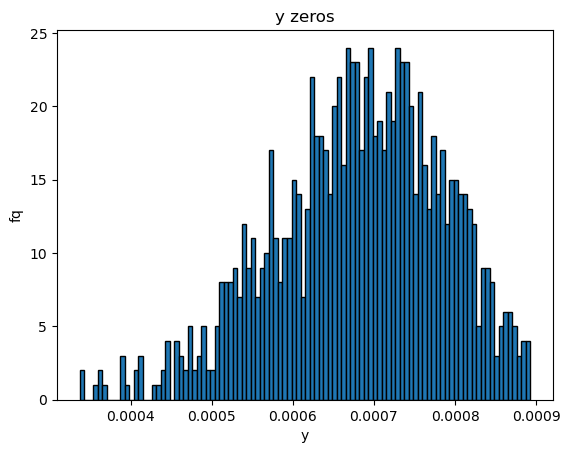

y_zero sum:  0.68104932304553
u:  0.5063245835580725
b:  -9
b_xy*u_N:  1.6959316
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.47994819137377


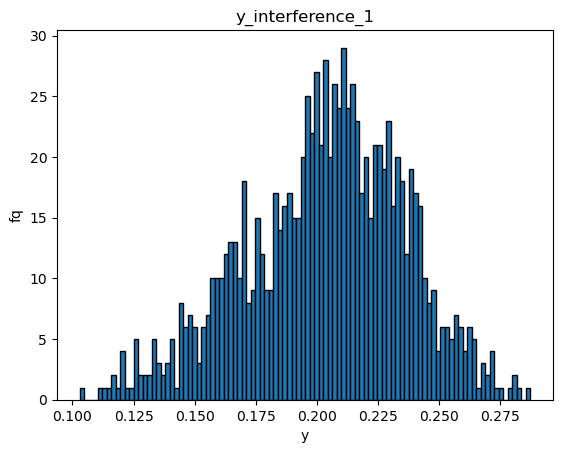

y_interference_1 sum:  1.055361425735427
The score for greedy interference is 203.2987.
u:  0.5063245835580725
b:  -9
b_xy*u_N:  1.6964166
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.47994819137377


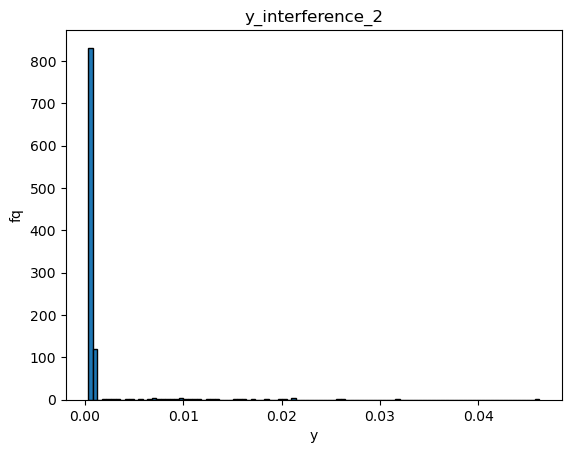

y_interference_2 sum:  1.2607596490621868
The score for greedy contagion is 258.1283.
The score for zero is 140.27009999999999.
starting iteration:  10


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.011155189097532391
Pearson with predicted edge probs:  tensor(0.9908)
Spearman with predicted edge probs:  0.9932072260721728
Auc with predicted edge probs:  0.9978315789473684
Rmse of predicted edge probs:  0.026561344521298373
Pearson of predicted edge probs:  tensor(0.0833)
Spearman of predicted edge probs:  0.13899256073243627
Start gnn training.
u:  0.4922089885602504
b:  -9
b_xy*u_N:  1.6667014
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.504427101342623
u:  0.5035007128807543
b:  -9
b_xy*u_N:  1.7155084000000003
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4962985303863423


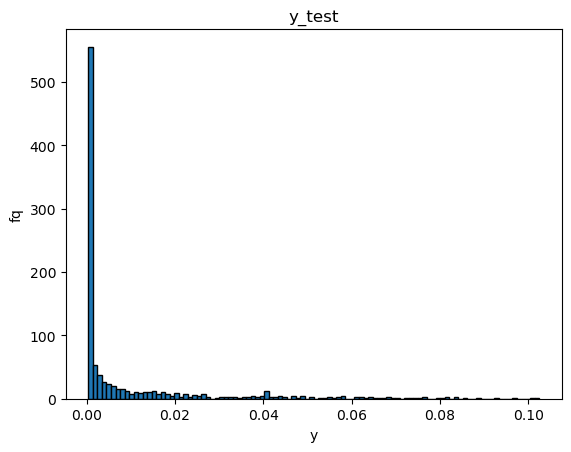

Epoch 0, Loss: 0.4620
Epoch 10, Loss: 0.4191
Epoch 20, Loss: 0.4055
Epoch 30, Loss: 0.3854
Epoch 40, Loss: 0.3613
Epoch 50, Loss: 0.2861
Epoch 60, Loss: 0.2091
Epoch 70, Loss: 0.1649
Epoch 80, Loss: 0.1525
Epoch 90, Loss: 0.1382
Epoch 100, Loss: 0.1221
Epoch 110, Loss: 0.1066
Epoch 120, Loss: 0.1399
Epoch 130, Loss: 0.0749
Epoch 140, Loss: 0.1182
Test GNN RMSE Loss: 0.0483
Test GNN pearson:  tensor(0.9464)
Test GNN spearman:  0.8538973479138059
Test GNN auc:  0.9942526315789474
Started with allocation.
Selected top 50 nodes based on baseline predictions: [384, 596, 119, 524, 24, 298, 381, 114, 213, 157], ...
Selected top 50 nodes based on baseline predictions: [642, 977, 104, 873, 116, 783, 774, 601, 963, 926], ...
u:  0.5007858544934884
b:  -9
b_xy*u_N:  1.7073034
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.50044691395467


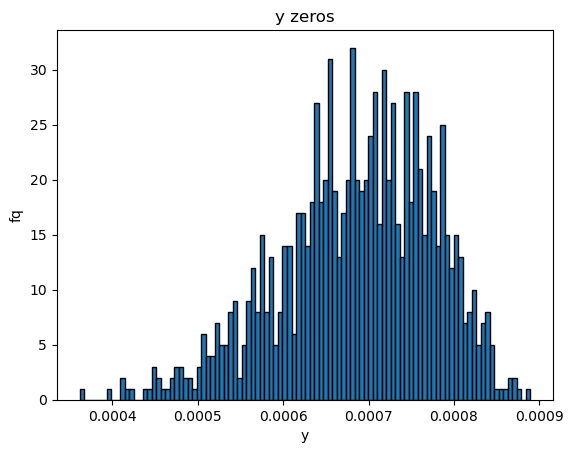

y_zero sum:  0.6862491188331153
u:  0.5007858544934884
b:  -9
b_xy*u_N:  1.7070238
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.50044691395467


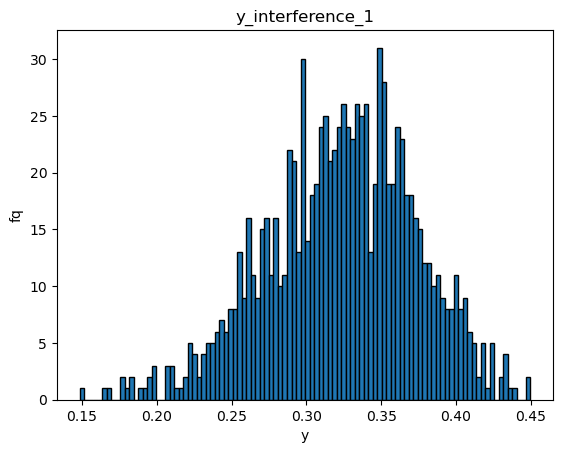

y_interference_1 sum:  1.783967469911193
The score for greedy interference is 323.3482.
u:  0.5007858544934884
b:  -9
b_xy*u_N:  1.7067484
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.50044691395467


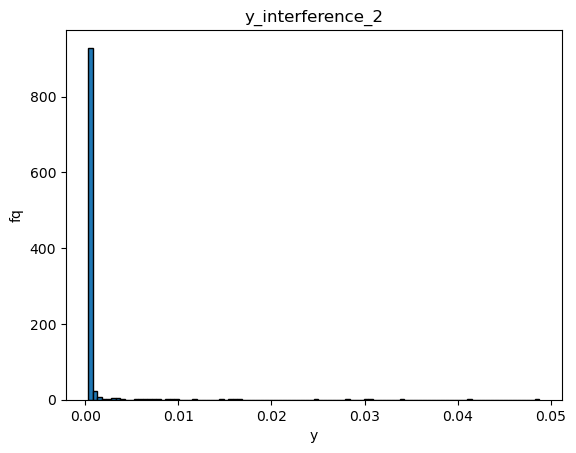

y_interference_2 sum:  1.1445503898613159
The score for greedy contagion is 267.57.
The score for zero is 168.1119.
starting iteration:  11


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.010583885297361687
Pearson with predicted edge probs:  tensor(0.9945)
Spearman with predicted edge probs:  0.995848113780598
Auc with predicted edge probs:  0.9993684210526316
Rmse of predicted edge probs:  0.035519216330304866
Pearson of predicted edge probs:  tensor(0.2785)
Spearman of predicted edge probs:  0.416310586291489
Start gnn training.
u:  0.5035047403755472
b:  -9
b_xy*u_N:  1.6587397999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4517899324766486
u:  0.4993797837152281
b:  -9
b_xy*u_N:  1.6949772
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5117143556909864


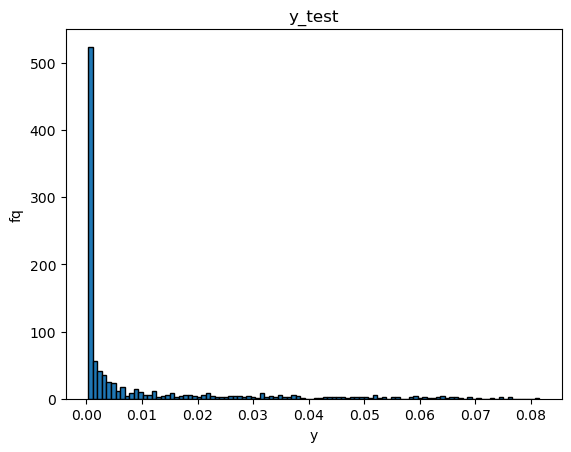

Epoch 0, Loss: 0.4599
Epoch 10, Loss: 0.4183
Epoch 20, Loss: 0.4123
Epoch 30, Loss: 0.3814
Epoch 40, Loss: 0.3321
Epoch 50, Loss: 0.2518
Epoch 60, Loss: 0.1938
Epoch 70, Loss: 0.1607
Epoch 80, Loss: 0.1280
Epoch 90, Loss: 0.1308
Epoch 100, Loss: 0.1179
Epoch 110, Loss: 0.1057
Epoch 120, Loss: 0.1032
Epoch 130, Loss: 0.0830
Epoch 140, Loss: 0.1051
Test GNN RMSE Loss: 0.0628
Test GNN pearson:  tensor(0.9514)
Test GNN spearman:  0.8487211971139107
Test GNN auc:  0.9817684210526316
Started with allocation.
Selected top 50 nodes based on baseline predictions: [659, 608, 509, 395, 854, 458, 494, 298, 283, 408], ...
Selected top 50 nodes based on baseline predictions: [117, 631, 556, 341, 213, 93, 266, 989, 981, 731], ...
u:  0.5019113105420578
b:  -9
b_xy*u_N:  1.6988449999999997
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4908360597918113


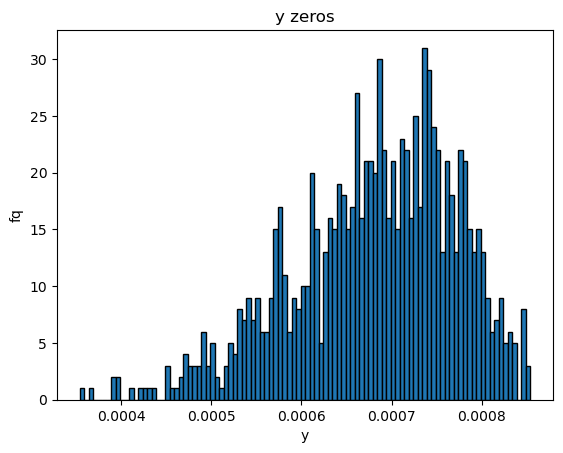

y_zero sum:  0.6808494515569489
u:  0.5019113105420578
b:  -9
b_xy*u_N:  1.6977266
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4908360597918113


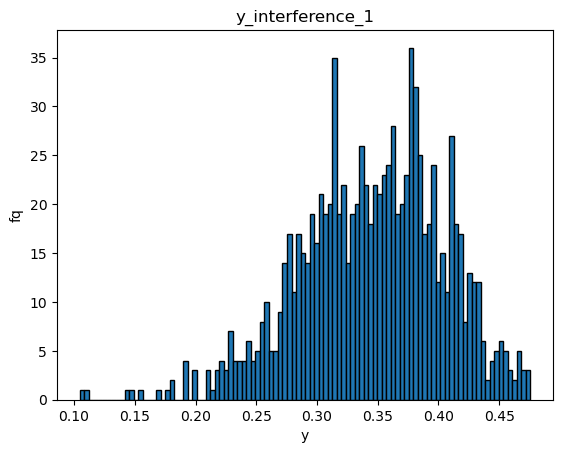

y_interference_1 sum:  1.7817310492686254
The score for greedy interference is 345.0544.
u:  0.5019113105420578
b:  -9
b_xy*u_N:  1.6980614
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4908360597918113


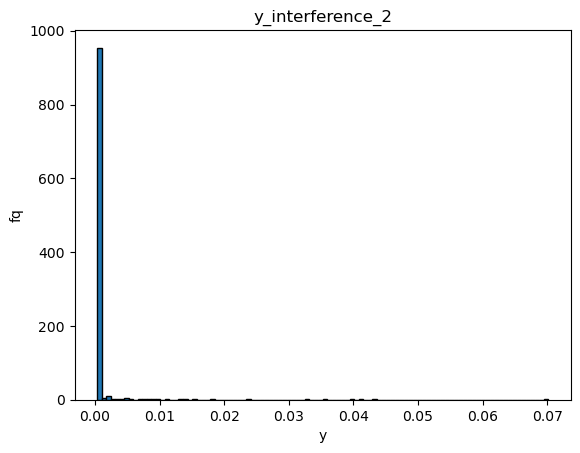

y_interference_2 sum:  1.1317080594351308
The score for greedy contagion is 268.2208.
The score for zero is 170.9339.
starting iteration:  12


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.01161864359054348
Pearson with predicted edge probs:  tensor(0.9933)
Spearman with predicted edge probs:  0.9961313919728637
Auc with predicted edge probs:  0.9987789473684211
Rmse of predicted edge probs:  0.03523006075256854
Pearson of predicted edge probs:  tensor(0.2516)
Spearman of predicted edge probs:  0.4035275324990187
Start gnn training.
u:  0.49609653905198775
b:  -9
b_xy*u_N:  1.7535958
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.492627124494721
u:  0.4930649441731503
b:  -9
b_xy*u_N:  1.7102526
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.6051966880697153


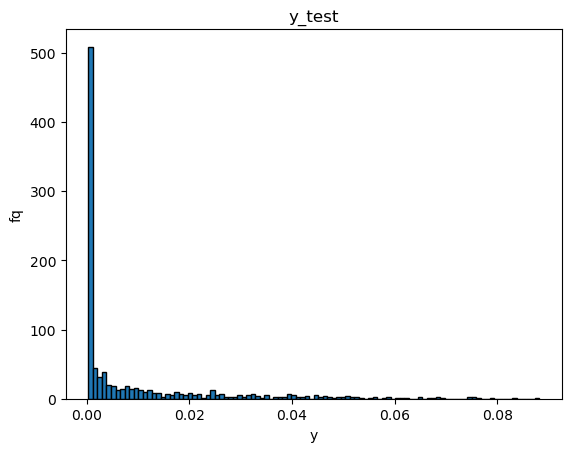

Epoch 0, Loss: 0.4615
Epoch 10, Loss: 0.4160
Epoch 20, Loss: 0.4062
Epoch 30, Loss: 0.4050
Epoch 40, Loss: 0.3944
Epoch 50, Loss: 0.3929
Epoch 60, Loss: 0.3925
Epoch 70, Loss: 0.3818
Epoch 80, Loss: 0.3811
Epoch 90, Loss: 0.3631
Epoch 100, Loss: 0.3339
Epoch 110, Loss: 0.2892
Epoch 120, Loss: 0.2643
Epoch 130, Loss: 0.2691
Epoch 140, Loss: 0.2215
Test GNN RMSE Loss: 0.0558
Test GNN pearson:  tensor(0.8055)
Test GNN spearman:  0.5775126402673102
Test GNN auc:  0.928442105263158
Started with allocation.
Selected top 50 nodes based on baseline predictions: [275, 291, 471, 231, 422, 956, 7, 985, 846, 470], ...
Selected top 50 nodes based on baseline predictions: [579, 263, 857, 700, 39, 351, 68, 302, 967, 485], ...
u:  0.4994872551670763
b:  -9
b_xy*u_N:  1.7243324
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.519160821056912


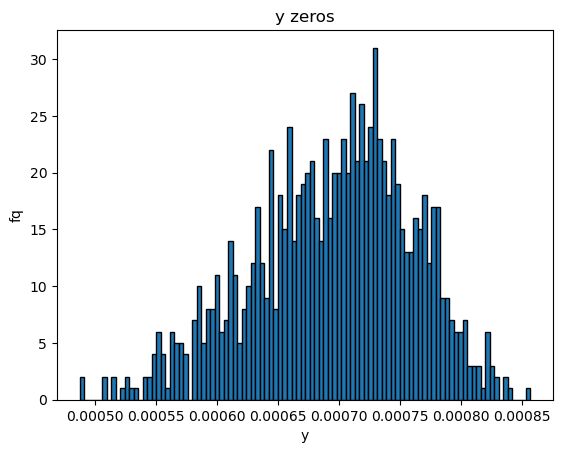

y_zero sum:  0.694878888185954
u:  0.4994872551670763
b:  -9
b_xy*u_N:  1.724811
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.519160821056912


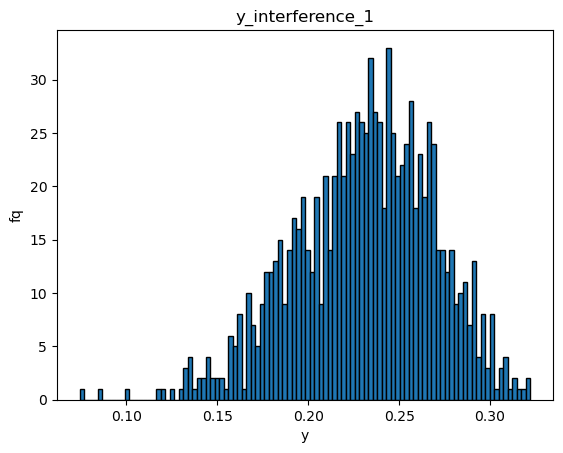

y_interference_1 sum:  0.9262396770635141
The score for greedy interference is 230.72019999999998.
u:  0.4994872551670763
b:  -9
b_xy*u_N:  1.7244662
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.519160821056912


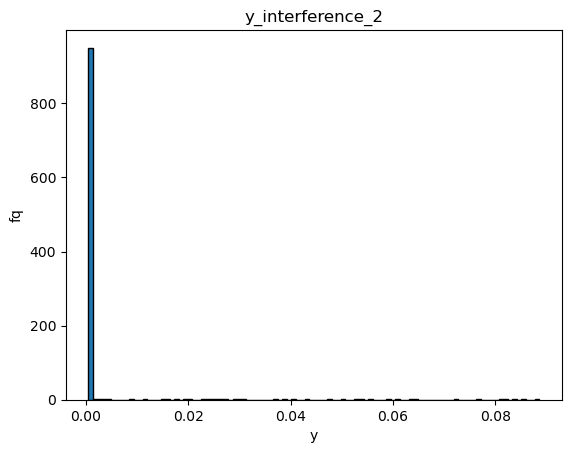

y_interference_2 sum:  2.5226659217629233
The score for greedy contagion is 467.479.
The score for zero is 181.9118.
starting iteration:  13


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.011769653568619746
Pearson with predicted edge probs:  tensor(0.9948)
Spearman with predicted edge probs:  0.9953770252290101
Auc with predicted edge probs:  0.996
Rmse of predicted edge probs:  0.05593132390525617
Pearson of predicted edge probs:  tensor(0.1262)
Spearman of predicted edge probs:  0.24401821754917824
Start gnn training.
u:  0.5025241552966752
b:  -9
b_xy*u_N:  1.7470084000000001
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.451566014519413
u:  0.49157890063207915
b:  -9
b_xy*u_N:  1.74575
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.524763473567133


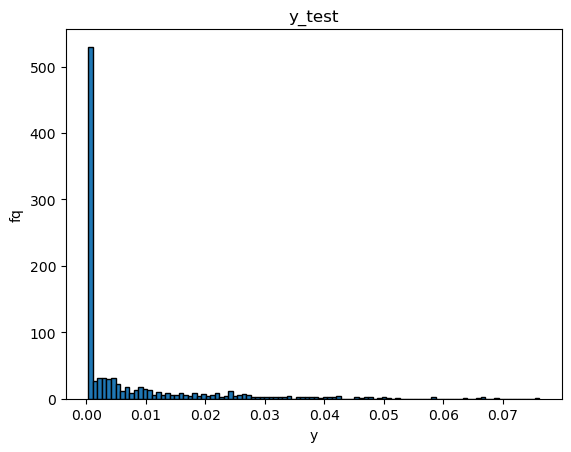

Epoch 0, Loss: 0.4263
Epoch 10, Loss: 0.3914
Epoch 20, Loss: 0.3754
Epoch 30, Loss: 0.3687
Epoch 40, Loss: 0.3357
Epoch 50, Loss: 0.2861
Epoch 60, Loss: 0.1847
Epoch 70, Loss: 0.1152
Epoch 80, Loss: 0.0891
Epoch 90, Loss: 0.0761
Epoch 100, Loss: 0.0749
Epoch 110, Loss: 0.0790
Epoch 120, Loss: 0.0881
Epoch 130, Loss: 0.0846
Epoch 140, Loss: 0.0687
Test GNN RMSE Loss: 0.0609
Test GNN pearson:  tensor(0.9633)
Test GNN spearman:  0.8964242628879117
Test GNN auc:  0.9940842105263158
Started with allocation.
Selected top 50 nodes based on baseline predictions: [858, 400, 437, 811, 898, 964, 722, 741, 488, 155], ...
Selected top 50 nodes based on baseline predictions: [299, 371, 687, 715, 352, 562, 997, 353, 6, 11], ...
u:  0.5085109267717662
b:  -9
b_xy*u_N:  1.743309
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.45728714824276


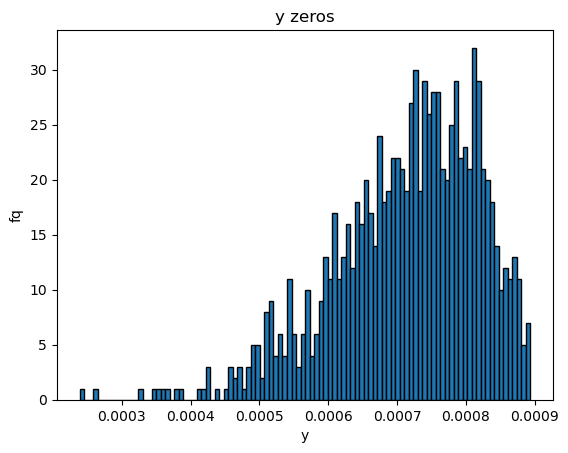

y_zero sum:  0.7138909452503117
u:  0.5085109267717662
b:  -9
b_xy*u_N:  1.74292
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.45728714824276


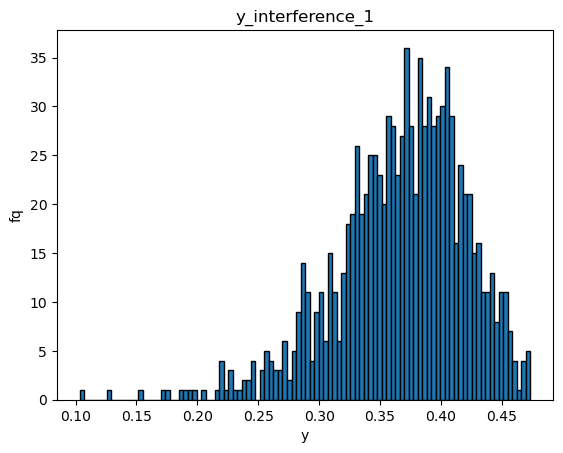

y_interference_1 sum:  1.4459862341918408
The score for greedy interference is 366.9721.
u:  0.5085109267717662
b:  -9
b_xy*u_N:  1.7428946
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.45728714824276


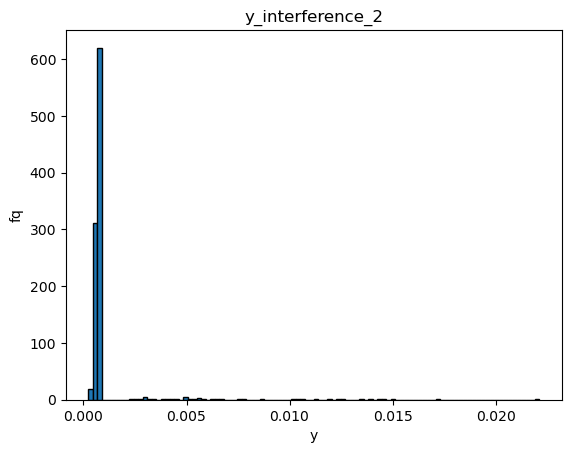

y_interference_2 sum:  1.0531696915245876
The score for greedy contagion is 328.255.
The score for zero is 228.17329999999998.
starting iteration:  14


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.0112622933546736
Pearson with predicted edge probs:  tensor(0.9934)
Spearman with predicted edge probs:  0.9958611456759694
Auc with predicted edge probs:  0.9982231037831361
Rmse of predicted edge probs:  0.061853757680432386
Pearson of predicted edge probs:  tensor(0.1008)
Spearman of predicted edge probs:  0.23275192038845163
Start gnn training.
u:  0.4999624956822309
b:  -9
b_xy*u_N:  1.747558
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.491556535811762
u:  0.5028493535548082
b:  -9
b_xy*u_N:  1.7338718
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5064578459478657


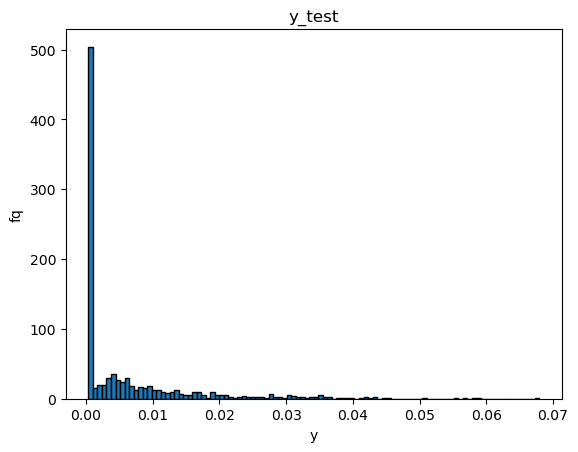

Epoch 0, Loss: 0.4200
Epoch 10, Loss: 0.3805
Epoch 20, Loss: 0.3631
Epoch 30, Loss: 0.3496
Epoch 40, Loss: 0.2994
Epoch 50, Loss: 0.2217
Epoch 60, Loss: 0.1575
Epoch 70, Loss: 0.1523
Epoch 80, Loss: 0.1234
Epoch 90, Loss: 0.0891
Epoch 100, Loss: 0.1056
Epoch 110, Loss: 0.1071
Epoch 120, Loss: 0.0645
Epoch 130, Loss: 0.0735
Epoch 140, Loss: 0.0698
Test GNN RMSE Loss: 0.0678
Test GNN pearson:  tensor(0.9704)
Test GNN spearman:  0.8781648162344966
Test GNN auc:  0.9934526315789474
Started with allocation.
Selected top 50 nodes based on baseline predictions: [318, 844, 11, 275, 965, 126, 514, 267, 959, 251], ...
Selected top 50 nodes based on baseline predictions: [573, 935, 451, 164, 694, 104, 697, 894, 281, 811], ...
u:  0.50155135165488
b:  -9
b_xy*u_N:  1.7291561999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.50799860281877


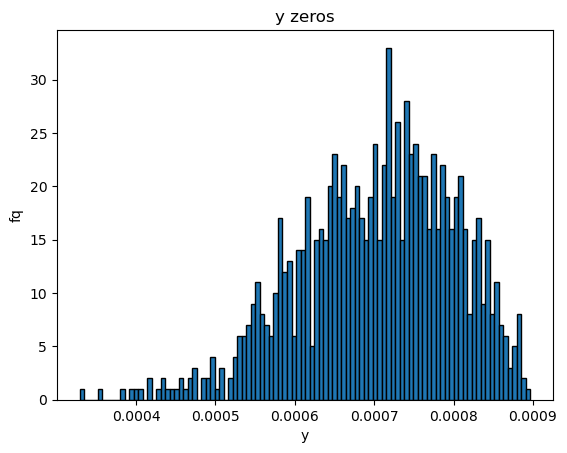

y_zero sum:  0.702432565725073
u:  0.50155135165488
b:  -9
b_xy*u_N:  1.72934
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.50799860281877


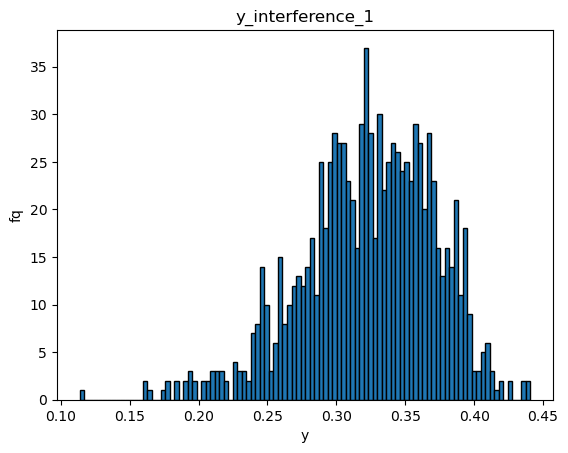

y_interference_1 sum:  1.315556131663386
The score for greedy interference is 323.0483.
u:  0.50155135165488
b:  -9
b_xy*u_N:  1.7298407999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.50799860281877


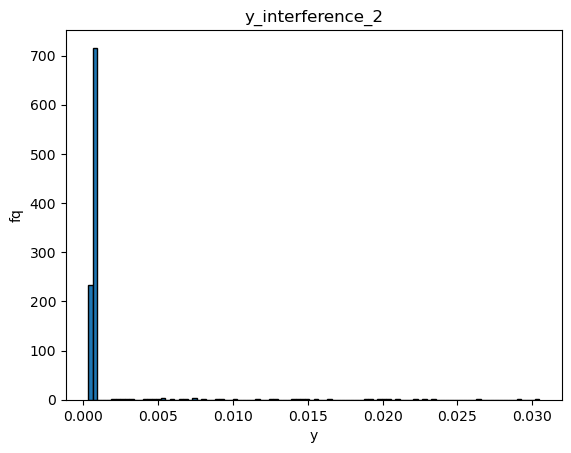

y_interference_2 sum:  1.2479940625153845
The score for greedy contagion is 337.4542.
The score for zero is 201.0258.
starting iteration:  15


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.009949480800768394
Pearson with predicted edge probs:  tensor(0.9929)
Spearman with predicted edge probs:  0.9941304845385271
Auc with predicted edge probs:  0.9981263157894738
Rmse of predicted edge probs:  0.023217261696840765
Pearson of predicted edge probs:  tensor(0.2439)
Spearman of predicted edge probs:  0.3177544990065268
Start gnn training.
u:  0.507164919632754
b:  -9
b_xy*u_N:  1.7471543999999999
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4359763222394815
u:  0.502610525094146
b:  -9
b_xy*u_N:  1.6927873999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4824672956657827


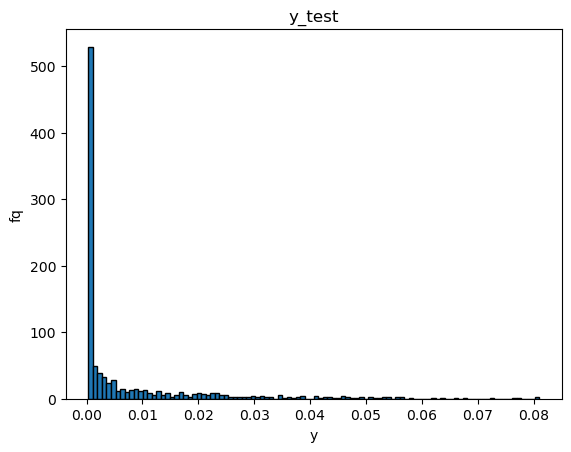

Epoch 0, Loss: 0.4428
Epoch 10, Loss: 0.3885
Epoch 20, Loss: 0.3624
Epoch 30, Loss: 0.3285
Epoch 40, Loss: 0.2613
Epoch 50, Loss: 0.1872
Epoch 60, Loss: 0.1472
Epoch 70, Loss: 0.0967
Epoch 80, Loss: 0.0969
Epoch 90, Loss: 0.0939
Epoch 100, Loss: 0.0817
Epoch 110, Loss: 0.0690
Epoch 120, Loss: 0.0629
Epoch 130, Loss: 0.0601
Epoch 140, Loss: 0.0590
Test GNN RMSE Loss: 0.0668
Test GNN pearson:  tensor(0.9532)
Test GNN spearman:  0.8099177859839854
Test GNN auc:  0.9961684210526316
Started with allocation.
Selected top 50 nodes based on baseline predictions: [216, 845, 593, 778, 569, 253, 128, 241, 603, 413], ...
Selected top 50 nodes based on baseline predictions: [400, 923, 799, 963, 273, 977, 922, 717, 793, 618], ...
u:  0.49631431407604215
b:  -9
b_xy*u_N:  1.695714
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4511775539532383


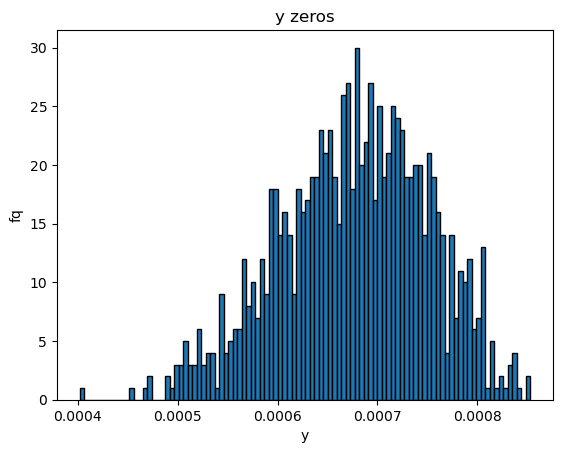

y_zero sum:  0.6764659994353435
u:  0.49631431407604215
b:  -9
b_xy*u_N:  1.6952269999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4511775539532383


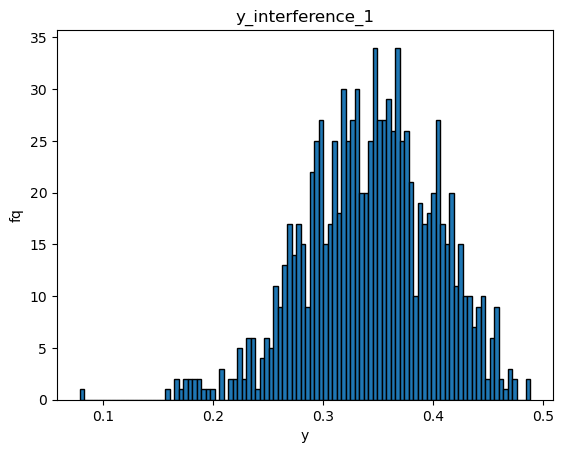

y_interference_1 sum:  1.9933345037318313
The score for greedy interference is 343.952.
u:  0.49631431407604215
b:  -9
b_xy*u_N:  1.6954626
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4511775539532383


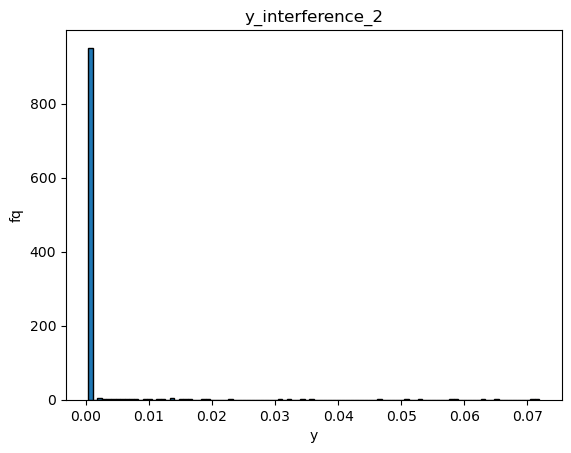

y_interference_2 sum:  1.6904063736231878
The score for greedy contagion is 328.42420000000004.
The score for zero is 151.33229999999998.
starting iteration:  16


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.011606649454983142
Pearson with predicted edge probs:  tensor(0.9923)
Spearman with predicted edge probs:  0.994863424951147
Auc with predicted edge probs:  0.9990736842105263
Rmse of predicted edge probs:  0.04029477704558204
Pearson of predicted edge probs:  tensor(0.1846)
Spearman of predicted edge probs:  0.27930043107460595
Start gnn training.
u:  0.49879901812641697
b:  -9
b_xy*u_N:  1.642054
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4723528074753247
u:  0.501921739033829
b:  -9
b_xy*u_N:  1.7456981999999999
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5154638420421778


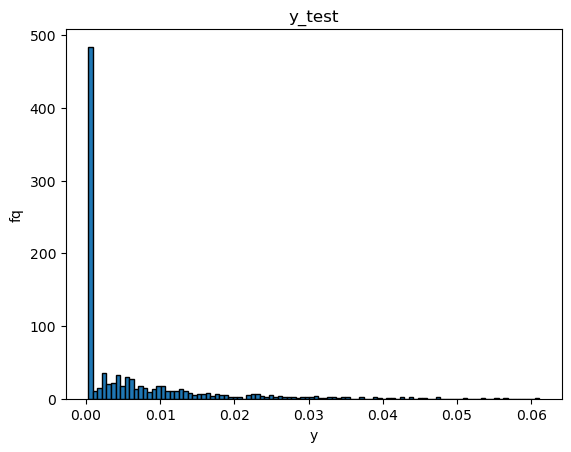

Epoch 0, Loss: 0.3800
Epoch 10, Loss: 0.3382
Epoch 20, Loss: 0.3285
Epoch 30, Loss: 0.3036
Epoch 40, Loss: 0.2462
Epoch 50, Loss: 0.1944
Epoch 60, Loss: 0.1669
Epoch 70, Loss: 0.1209
Epoch 80, Loss: 0.1164
Epoch 90, Loss: 0.0966
Epoch 100, Loss: 0.0814
Epoch 110, Loss: 0.0705
Epoch 120, Loss: 0.0626
Epoch 130, Loss: 0.0641
Epoch 140, Loss: 0.0626
Test GNN RMSE Loss: 0.0702
Test GNN pearson:  tensor(0.9717)
Test GNN spearman:  0.9190356993329706
Test GNN auc:  0.9966315789473684
Started with allocation.
Selected top 50 nodes based on baseline predictions: [277, 593, 839, 706, 257, 431, 209, 456, 954, 24], ...
Selected top 50 nodes based on baseline predictions: [792, 936, 161, 369, 613, 943, 660, 67, 22, 567], ...
u:  0.4995053555154199
b:  -9
b_xy*u_N:  1.7506918
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.456596578137908


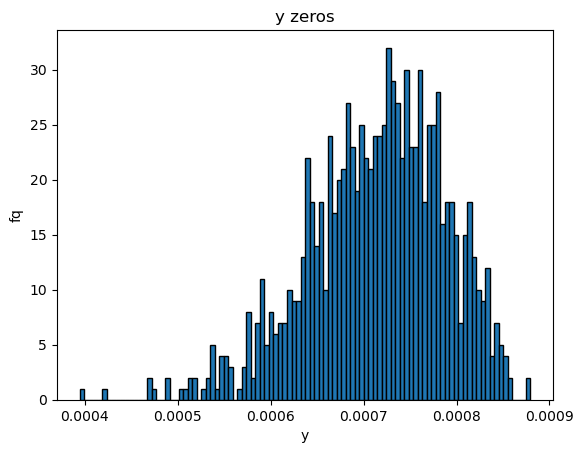

y_zero sum:  0.7141921103277582
u:  0.4995053555154199
b:  -9
b_xy*u_N:  1.7505502000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.456596578137908


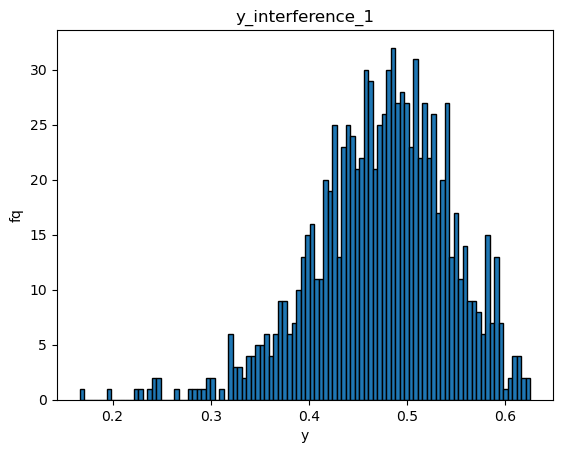

y_interference_1 sum:  2.174465179931235
The score for greedy interference is 473.6732.
u:  0.4995053555154199
b:  -9
b_xy*u_N:  1.750386
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.456596578137908


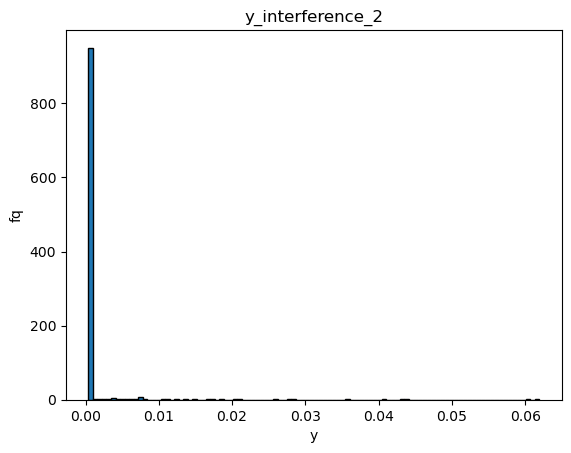

y_interference_2 sum:  1.4270393645287482
The score for greedy contagion is 398.499.
The score for zero is 225.2531.
starting iteration:  17


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.011031450882751204
Pearson with predicted edge probs:  tensor(0.9917)
Spearman with predicted edge probs:  0.9936612536680406
Auc with predicted edge probs:  0.9984
Rmse of predicted edge probs:  0.02727610232718441
Pearson of predicted edge probs:  tensor(0.1923)
Spearman of predicted edge probs:  0.29588055740681785
Start gnn training.
u:  0.5124667018749702
b:  -9
b_xy*u_N:  1.6740639999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5174970481221965
u:  0.4871702366947011
b:  -9
b_xy*u_N:  1.7035727999999999
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.441300869826798


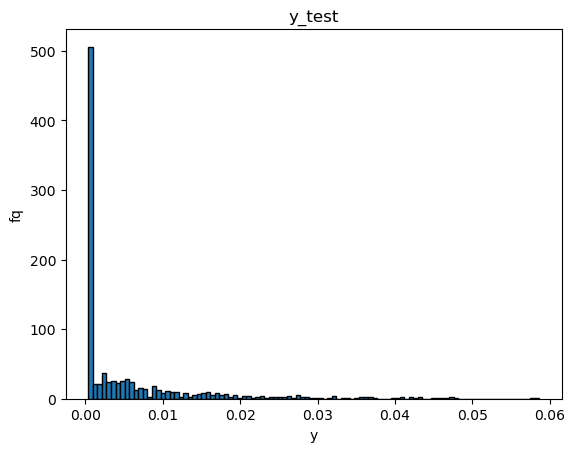

Epoch 0, Loss: 0.4098
Epoch 10, Loss: 0.3523
Epoch 20, Loss: 0.3353
Epoch 30, Loss: 0.3008
Epoch 40, Loss: 0.2667
Epoch 50, Loss: 0.2353
Epoch 60, Loss: 0.1983
Epoch 70, Loss: 0.1389
Epoch 80, Loss: 0.1271
Epoch 90, Loss: 0.0934
Epoch 100, Loss: 0.0750
Epoch 110, Loss: 0.0861
Epoch 120, Loss: 0.0732
Epoch 130, Loss: 0.0708
Epoch 140, Loss: 0.0742
Test GNN RMSE Loss: 0.0446
Test GNN pearson:  tensor(0.9878)
Test GNN spearman:  0.9211530443798496
Test GNN auc:  0.9975789473684211
Started with allocation.
Selected top 50 nodes based on baseline predictions: [449, 514, 767, 967, 949, 309, 752, 637, 24, 569], ...
Selected top 50 nodes based on baseline predictions: [474, 264, 22, 878, 476, 797, 808, 864, 125, 425], ...
u:  0.5117287662398684
b:  -9
b_xy*u_N:  1.7058996
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5360742917321906


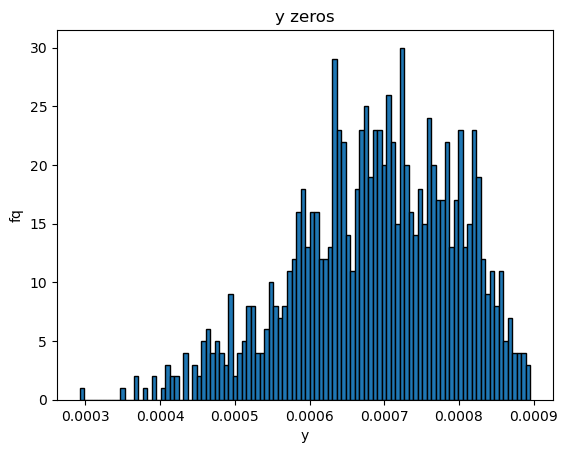

y_zero sum:  0.6882304915431001
u:  0.5117287662398684
b:  -9
b_xy*u_N:  1.7057864
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5360742917321906


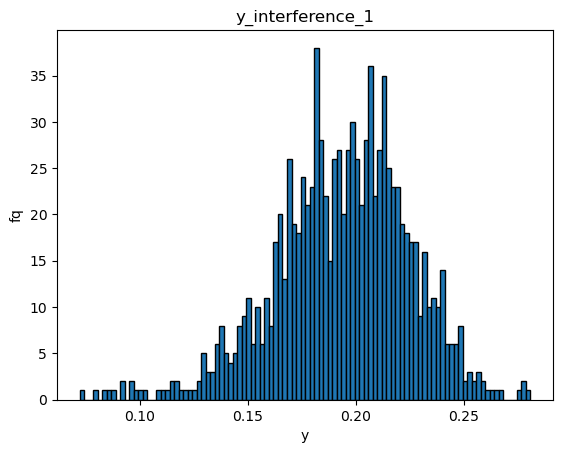

y_interference_1 sum:  0.866727134613857
The score for greedy interference is 193.6533.
u:  0.5117287662398684
b:  -9
b_xy*u_N:  1.7060688
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5360742917321906


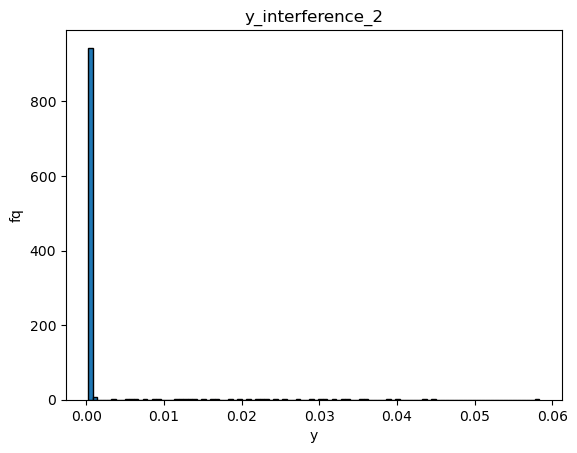

y_interference_2 sum:  1.6839419361798997
The score for greedy contagion is 348.18769999999995.
The score for zero is 160.656.
starting iteration:  18


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.01128843948949314
Pearson with predicted edge probs:  tensor(0.9921)
Spearman with predicted edge probs:  0.9959590747649991
Auc with predicted edge probs:  0.9973473684210526
Rmse of predicted edge probs:  0.049903876044082404
Pearson of predicted edge probs:  tensor(0.2006)
Spearman of predicted edge probs:  0.3794561743790181
Start gnn training.
u:  0.4974654206620455
b:  -9
b_xy*u_N:  1.6688568
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5066461029768736
u:  0.5025218027136945
b:  -9
b_xy*u_N:  1.7829621999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.5038807543506216


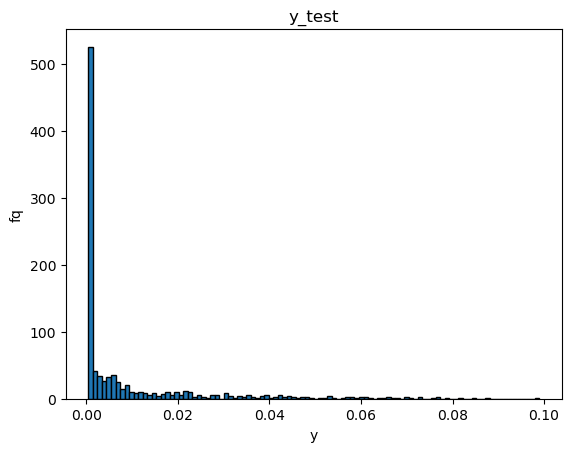

Epoch 0, Loss: 0.4359
Epoch 10, Loss: 0.3909
Epoch 20, Loss: 0.3717
Epoch 30, Loss: 0.3141
Epoch 40, Loss: 0.2445
Epoch 50, Loss: 0.1746
Epoch 60, Loss: 0.1423
Epoch 70, Loss: 0.1073
Epoch 80, Loss: 0.1009
Epoch 90, Loss: 0.1253
Epoch 100, Loss: 0.0953
Epoch 110, Loss: 0.0758
Epoch 120, Loss: 0.0615
Epoch 130, Loss: 0.0602
Epoch 140, Loss: 0.0596
Test GNN RMSE Loss: 0.0457
Test GNN pearson:  tensor(0.9811)
Test GNN spearman:  0.8888046681140346
Test GNN auc:  0.9966105263157895
Started with allocation.
Selected top 50 nodes based on baseline predictions: [115, 833, 739, 480, 912, 254, 195, 948, 560, 362], ...
Selected top 50 nodes based on baseline predictions: [478, 973, 69, 422, 682, 962, 994, 484, 385, 646], ...
u:  0.5054146588768568
b:  -9
b_xy*u_N:  1.7851073999999998
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.47313224478003


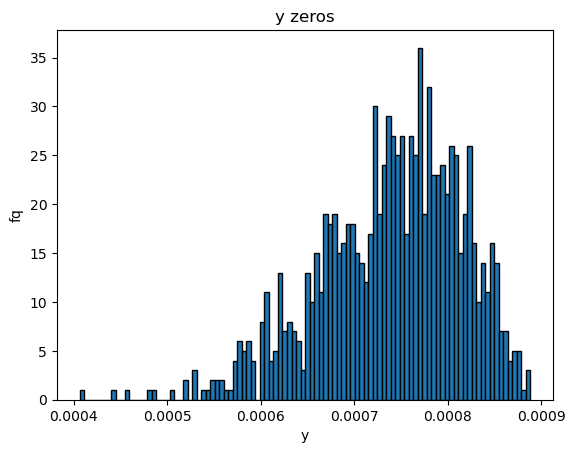

y_zero sum:  0.7392260601043292
u:  0.5054146588768568
b:  -9
b_xy*u_N:  1.7853548000000001
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.47313224478003


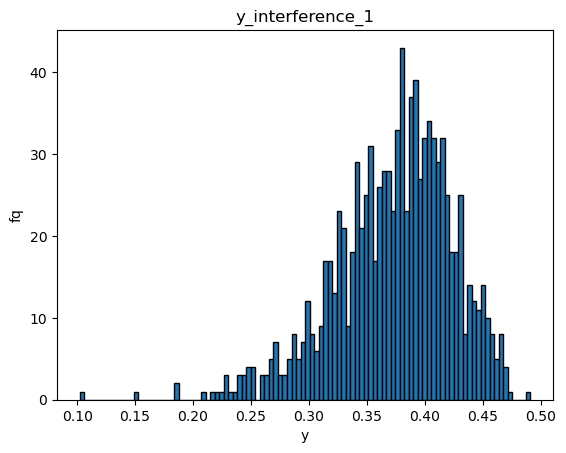

y_interference_1 sum:  1.1600843998377124
The score for greedy interference is 372.6919.
u:  0.5054146588768568
b:  -9
b_xy*u_N:  1.7852712000000002
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.47313224478003


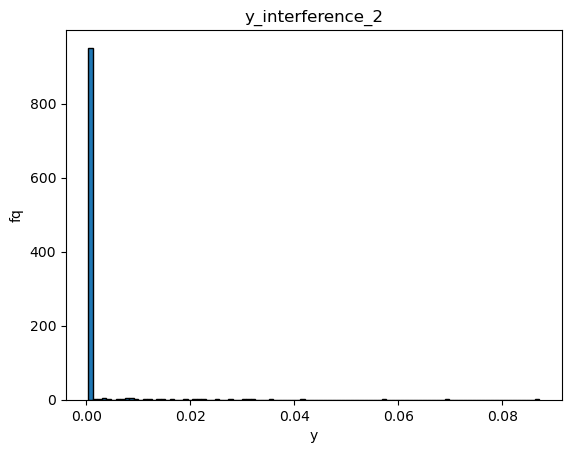

y_interference_2 sum:  1.5452971524138905
The score for greedy contagion is 473.6481.
The score for zero is 268.3745.
starting iteration:  19


/home/matic/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Rmse with predicted edge probs:  0.011722981786585348
Pearson with predicted edge probs:  tensor(0.9936)
Spearman with predicted edge probs:  0.9950605582007848
Auc with predicted edge probs:  0.9986947368421053
Rmse of predicted edge probs:  0.028428670950636045
Pearson of predicted edge probs:  tensor(0.1379)
Spearman of predicted edge probs:  0.21928504843161664
Start gnn training.
u:  0.4849609508507838
b:  -9
b_xy*u_N:  1.651788
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.612253729908822
u:  0.505129594000774
b:  -9
b_xy*u_N:  1.7267692
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.4908831080059244


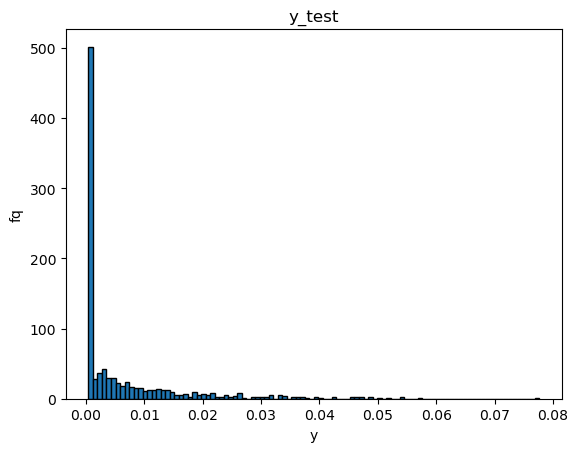

Epoch 0, Loss: 0.4170
Epoch 10, Loss: 0.3755
Epoch 20, Loss: 0.3514
Epoch 30, Loss: 0.3181
Epoch 40, Loss: 0.2767
Epoch 50, Loss: 0.2162
Epoch 60, Loss: 0.1624
Epoch 70, Loss: 0.1299
Epoch 80, Loss: 0.1006
Epoch 90, Loss: 0.0997
Epoch 100, Loss: 0.0867
Epoch 110, Loss: 0.0796
Epoch 120, Loss: 0.0609
Epoch 130, Loss: 0.0632
Epoch 140, Loss: 0.0743
Test GNN RMSE Loss: 0.0572
Test GNN pearson:  tensor(0.9605)
Test GNN spearman:  0.868752578577862
Test GNN auc:  0.9950105263157895
Started with allocation.
Selected top 50 nodes based on baseline predictions: [313, 165, 75, 227, 508, 332, 204, 473, 378, 522], ...
Selected top 50 nodes based on baseline predictions: [991, 22, 594, 735, 63, 989, 733, 335, 325, 360], ...
u:  0.5029440478005889
b:  -9
b_xy*u_N:  1.7191196
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.495265733733083


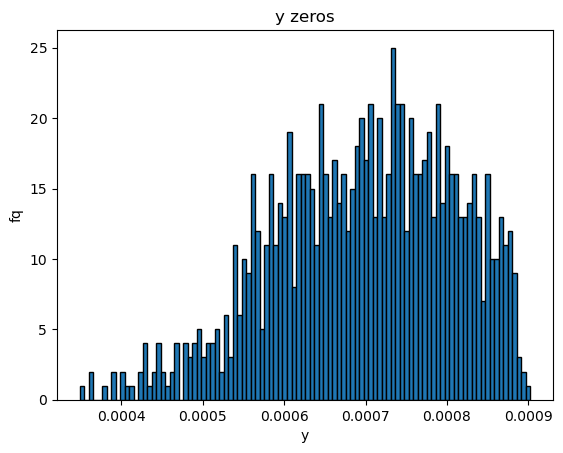

y_zero sum:  0.6975976822415924
u:  0.5029440478005889
b:  -9
b_xy*u_N:  1.7187852000000001
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.495265733733083


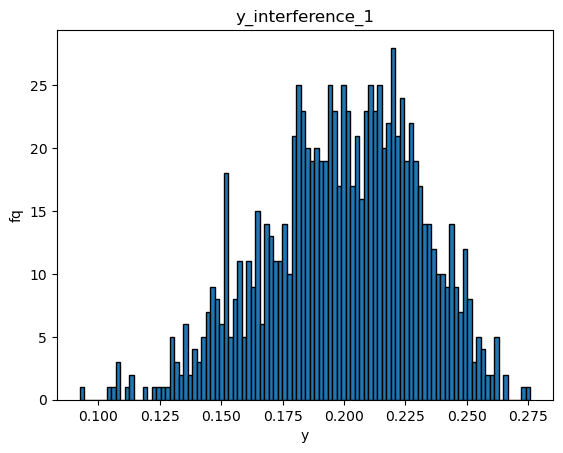

y_interference_1 sum:  0.8041571493638706
The score for greedy interference is 199.3504.
u:  0.5029440478005889
b:  -9
b_xy*u_N:  1.7195628
(b_ty/(1+np.exp(-np.dot(x,w_ty)))):  2.495265733733083


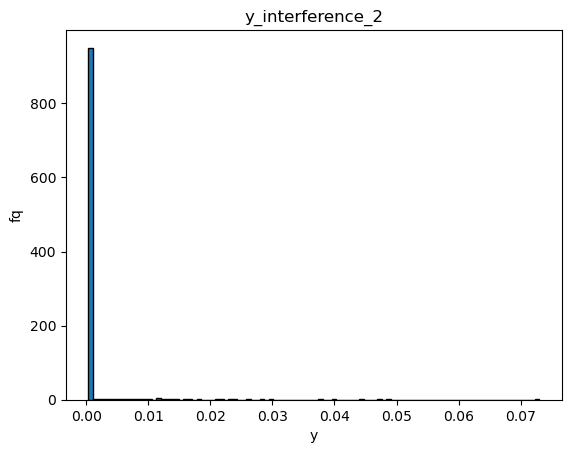

y_interference_2 sum:  1.4766943829060748
The score for greedy contagion is 342.3223.
The score for zero is 178.96679999999998.
y_int:
 mean=315.14697,
 ci_low=261.92325227471184,
 ci_high=368.3706877252882,
 std=110.84287659066369
pearson:
 mean=335.00272000000007,
 ci_low=290.14074468052115,
 ci_high=379.864695319479,
 std=93.42884350199675
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$


In [34]:
num_sim=10000
num_nodes = 1000
edge_prob=0.004 #0.004, 0.010, 0.020
prob_selected = 0.01
num_node_features=5
num_edge_features=5
num_graphs=20

b_s=1
b_t=0.5
b_e=1
b0=0
b=-6#-6,-8,-9
b_ty=5#5,5,5
b_xt=0.5
b_t=0.5
b_nt=0.5
b_xy=2#2,2,2
b_ep=0.05
prob_treated=0.5
confounding_t=False
damp_factor=1

T=10
attribute_distribution="normal"
max_edge=1/2 # 1/2, 1/3, 1/7
normal = False
percentile = 95

y_int = np.zeros(num_graphs)
y_con = np.zeros(num_graphs)

for i in range(num_graphs):
    print("starting iteration: ", i)
    if normal:
        node_weights=np.random.normal(size=num_node_features)
        node_weights_source=np.random.normal(size=num_node_features)
        node_weights_sink=np.random.normal(size=num_node_features)
        epsilon=np.random.normal(size=1)*-4
        edge_weights=np.random.normal(size=num_edge_features)
    else:
        node_weights=np.random.rand(num_node_features)*2-1
        node_weights_source=np.random.rand(num_node_features)*2-1
        node_weights_sink=np.random.rand(num_node_features)*2-1
        epsilon=np.random.rand(1)*-4
        edge_weights=np.random.rand(num_edge_features)*2-1
    edge_method='weighted_sum'
    
    # Edge probabilities prediction
    alpha=1
    G_test, prior_probs_test, edge_dict_test = generate_erdos_renyi_attribute_graph(num_nodes,
                                                                         edge_prob,
                                                                         num_node_features=num_node_features,
                                                                         num_edge_features=num_edge_features,
                                                                         node_weights=node_weights,
                                                                         edge_weights=edge_weights,
                                                                         edge_method=edge_method,
                                                                         max_edge=max_edge,
                                                                         prob_selected=prob_selected,
                                                                         attribute_distribution=attribute_distribution)
    
    initial_edge_probs_dict = generate_edge_probabilities(G_test,method="uniform", p=0)
    edges_test = list(edge_dict_test.keys())
    edge_index_test = torch.tensor(edges_test, dtype=torch.long).T
    edge_attr_test = torch.tensor([edge_dict_test[(u, v)] for (u, v) in edges_test], dtype=torch.float)
    initial_edge_probs_test = torch.tensor([initial_edge_probs_dict[(u, v)] for (u, v) in edges_test], dtype=torch.float)

    data_test = Data(x=prior_probs_test.unsqueeze(1), edge_index=edge_index_test, edge_attr=edge_attr_test)
    model = edge_probs_prediction(data_test,
                                  optimized_independent_cascade, 
                                  num_steps=T,
                                  lr=0.1, 
                                  epochs=300,
                                  alpha=alpha,
                                  num_sim=num_sim,
                                  reg_const=0,
                                  initial_edges = initial_edge_probs_test,
                                  decay=1,
                                  max_edge = max_edge,
                                  print_loss=False)
    
    
    model.eval()
    with torch.no_grad():
        predicted_posterior_test, predicted_edge_probs_test = model(G_test, data_test.x)
    
    ic = optimized_independent_cascade(G_test, prior_probs_test, edge_dict_test, num_sim)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    true_posterior_tensor_test = torch.tensor(
        [ic[node] for node in ic],
        dtype=torch.float,
        device=device
    ).view(-1, 1)
    rmse_loss = torch.nn.MSELoss()(predicted_posterior_test, true_posterior_tensor_test)
    rmse_loss_prior = torch.nn.MSELoss()(prior_probs_test.unsqueeze(1), true_posterior_tensor_test)
    
    rmse_loss = torch.nn.MSELoss()(predicted_edge_probs_test, edge_attr_test)
    
    predicted_edge_dict_test = edge_index_to_dict(edge_index_test, predicted_edge_probs_test)
    preds = IC_approx_vectorized(G_test, predicted_edge_dict_test, prior_probs_test, T, 1)
    preds_IC_approx = torch.tensor(preds, dtype=torch.float32).unsqueeze(1)
    rmse = torch.nn.MSELoss()(preds_IC_approx, true_posterior_tensor_test).item()**0.5
    print("Rmse with predicted edge probs: ", rmse)
    pearson = torch.corrcoef(torch.stack([preds_IC_approx.squeeze(), true_posterior_tensor_test.squeeze()]))[0, 1]
    print("Pearson with predicted edge probs: ", pearson)
    spearman, _ = spearmanr(preds_IC_approx.squeeze(),
                              true_posterior_tensor_test.squeeze())
    print("Spearman with predicted edge probs: ", spearman)

    y_true = true_posterior_tensor_test.squeeze().numpy()
    y_score = preds_IC_approx.squeeze().numpy()
    threshold = np.percentile(y_true, percentile)
    y_binary = (y_true >= threshold).astype(int)
    auc = roc_auc_score(y_binary, y_score)
    print("Auc with predicted edge probs: ", auc)

    rmse_edge = torch.nn.MSELoss()(predicted_edge_probs_test, edge_attr_test).item()**0.5
    print("Rmse of predicted edge probs: ", rmse_edge)
    pearson_edge = torch.corrcoef(torch.stack([predicted_edge_probs_test, edge_attr_test]))[0, 1]
    print("Pearson of predicted edge probs: ", pearson_edge)
    spearman_edge,_ = spearmanr(predicted_edge_probs_test, edge_attr_test)
    print("Spearman of predicted edge probs: ", spearman_edge)

    # GNN training
    print("Start gnn training.")
    G, prior_probs, edge_dict = generate_erdos_renyi_attribute_graph(num_nodes,
                                                                        edge_prob,
                                                                        num_node_features=num_node_features,
                                                                        num_edge_features=num_edge_features,
                                                                        node_weights=node_weights,
                                                                        edge_weights=edge_weights,
                                                                        edge_method=edge_method,
                                                                        max_edge=max_edge,
                                                                        prob_selected=prob_selected,
                                                                        node_weights_source=node_weights_source,
                                                                        node_weights_sink=node_weights_sink,
                                                                        epsilon=epsilon,
                                                                        b_s=b_s,
                                                                        b_t=b_t,
                                                                        b_e=b_e,
                                                                        attribute_distribution=attribute_distribution)

    edges = list(G.edges())
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor([edge_dict[(u, v)] for (u, v) in edges], dtype=torch.float)
    node_features = torch.tensor(
        [G.nodes[node]['features'] for node in G.nodes()],
        dtype=torch.float32
    )
    edge_features = torch.tensor(
        [G.edges[edge]['features'] for edge in G.edges()],
        dtype=torch.float32
    )
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr.unsqueeze(1))
    
    
    node_features_test = torch.tensor(
        [G_test.nodes[node]['features'] for node in G_test.nodes()],
        dtype=torch.float32
    )
    edge_features_test = torch.tensor(
        [G_test.edges[edge]['features'] for edge in G_test.edges()],
        dtype=torch.float32
    )
    edge_attr_pred = torch.tensor([predicted_edge_dict_test[(u, v)] for (u, v) in predicted_edge_dict_test], dtype=torch.float)
    data_test = Data(x=node_features_test, edge_index=edge_index_test, edge_attr=edge_attr_pred.unsqueeze(1))
    
    w_ty=np.random.rand(num_node_features)*2-1
    w_xt=np.random.rand(num_node_features)*2-1
    w_xy=np.random.rand(num_node_features)*2-1
    ep=np.random.normal()
    
    coin_toss = np.random.rand(num_nodes)
    t = (coin_toss < prob_treated).astype(int)
    coin_toss_test = np.random.rand(num_nodes)
    t_test = (coin_toss_test < prob_treated).astype(int)
    
    y=generate_y(G=G,
                 edge_probs=edge_dict, 
                 x=data.x, 
                 w_xy=w_xy, 
                 b_xy=b_xy, 
                 t=t, 
                 w_ty=w_ty, 
                 b_ty=b_ty,
                 b=b,
                 num_sim=num_sim,
                 damp_factor=damp_factor)
    
    y_test=generate_y(G=G_test,
                 edge_probs=edge_dict_test, 
                 x=data_test.x, 
                 w_xy=w_xy, 
                 b_xy=b_xy, 
                 t=t_test, 
                 w_ty=w_ty, 
                 b_ty=b_ty,
                 b=b,
                 num_sim=num_sim,
                 damp_factor=damp_factor)

    plt.hist(y_test, bins=100, edgecolor='black')
    plt.title('y_test')
    plt.xlabel('y')
    plt.ylabel('fq')
    plt.show()
    
    node_features_full=torch.cat([torch.tensor(t, dtype=torch.float32).unsqueeze(1), node_features], dim=1)
    node_features_test_full=torch.cat([torch.tensor(t_test, dtype=torch.float32).unsqueeze(1), node_features_test], dim=1)
    data = Data(x=node_features_full, edge_index=edge_index, edge_attr=edge_attr.unsqueeze(1), y=torch.tensor(y, dtype=torch.float32))
    data_test = Data(x=node_features_test_full, edge_index=edge_index_test, edge_attr=edge_attr_pred.unsqueeze(1), y=torch.tensor(y_test, dtype=torch.float32))
    model = train_DeepECCNet(data,
                             lr=0.01,
                             epochs=150, 
                             num_layers=1, 
                             loss_type="alpha", 
                             alpha=0.225,
                             hidden_channels=64, 
                             dropout=0.25,
                             w_decay=False)
    
    model.eval()
    with torch.no_grad():
        predicted_y_test = model(data_test.x, data_test.edge_index, data_test.edge_attr)
        predicted_y = model(data.x, data.edge_index, data.edge_attr)
    print(f"Test GNN RMSE Loss: {(((predicted_y_test - data_test.y)**2).mean())**0.5:.4f}")
    pearson_GNN = torch.corrcoef(torch.stack([predicted_y_test.squeeze(), data_test.y.squeeze()]))[0, 1]
    print("Test GNN pearson: ", pearson_GNN)
    spearman_GNN, _ = spearmanr(predicted_y_test.squeeze(),
                              data_test.y.squeeze())

    print("Test GNN spearman: ", spearman_GNN)

    y_true = data_test.y.squeeze().numpy()
    y_score = predicted_y_test.squeeze().numpy()
    threshold = np.percentile(y_test, percentile)
    y_binary = (y_true >= threshold).astype(int)
    auc_gnn = roc_auc_score(y_binary, y_score)
    print("Test GNN auc: ", auc_gnn)

    # Allocation eval
    print("Started with allocation.")
    t = np.zeros(num_nodes)
    data_test.x[:,0] = torch.tensor(t, dtype=torch.float32)
    
    budget = round(0.05 * num_nodes)
    greedy_interference_t = select_top_baseline_nodes(G_test, budget, model, data_test)
    #greedy_contagion_t = treatment_contagion_celf(G_test, predicted_edge_dict_test, budget, model, data_test, diffusion_method="IC_approx")
    greedy_contagion_t = select_top_contagion_nodes(G_test, predicted_edge_dict_test, budget, model, data_test, diffusion_method="IC_approx")
    y_zero=generate_y(G=G_test,
                         edge_probs=edge_dict_test, 
                         x=data_test.x[:,0:num_node_features], 
                         w_xy=w_xy, 
                         b_xy=b_xy, 
                         t=torch.zeros(num_nodes), 
                         w_ty=w_ty, 
                         b_ty=b_ty,
                         b=b,
                         num_sim=num_sim,
                         damp_factor=damp_factor)
    plt.hist(y_zero, bins=100, edgecolor='black')
    plt.title('y zeros')
    plt.xlabel('y')
    plt.ylabel('fq')
    plt.show()
    print("y_zero sum: ", y_zero.sum())
    
    y_interference_1=generate_y(G=G_test,
                                 edge_probs=edge_dict_test, 
                                 x=data_test.x[:,0:num_node_features], 
                                 w_xy=w_xy, 
                                 b_xy=b_xy, 
                                 t=greedy_interference_t, 
                                 w_ty=w_ty, 
                                 b_ty=b_ty,
                                 b=b,
                                 num_sim=num_sim,
                                 damp_factor=damp_factor)
    y_interference_final = generate_contagion_outcome(G_test, edge_dict_test, y_interference_1, diffusion_method="IC", num_sim=num_sim)
    plt.hist(y_interference_final, bins=100, edgecolor='black')
    plt.title('y_interference_1')
    plt.xlabel('y')
    plt.ylabel('fq')
    plt.show()
    print("y_interference_1 sum: ", y_interference_1.sum())
    score_interference = y_interference_final.sum()
    y_int[i] = score_interference
    print(f"The score for greedy interference is {score_interference}.")
    
    y_interference_2=generate_y(G=G_test,
                                 edge_probs=edge_dict_test, 
                                 x=data_test.x[:,0:num_node_features], 
                                 w_xy=w_xy, 
                                 b_xy=b_xy, 
                                 t=greedy_contagion_t, 
                                 w_ty=w_ty, 
                                 b_ty=b_ty,
                                 b=b,
                                 num_sim=num_sim,
                                 damp_factor=damp_factor)
    plt.hist(y_interference_2, bins=100, edgecolor='black')
    plt.title('y_interference_2')
    plt.xlabel('y')
    plt.ylabel('fq')
    plt.show()
    print("y_interference_2 sum: ", y_interference_2.sum())
    y_contagion_final = generate_contagion_outcome(G_test, edge_dict_test, y_interference_2, diffusion_method="IC", num_sim=num_sim)
    score_contagion = y_contagion_final.sum()
    y_con[i] = score_contagion
    print(f"The score for greedy contagion is {score_contagion}.")

    y_zero_contagion = generate_contagion_outcome(G_test, edge_dict_test, y_zero, diffusion_method="IC", num_sim=num_sim)
    print(f"The score for zero is {y_zero_contagion.sum()}.")

summarise_stats_um(y_int, y_con)

## Some statistics of the real-world data-sets

In [4]:
G_advogato, edge_weight = load_weighted_directed_graph("soc-advogato/soc-advogato.edges")
G_anybeat = load_directed_graph_from_edges("soc-anybeat/soc-anybeat.edges")
print(G_advogato.number_of_nodes())
print(G_anybeat.number_of_nodes())

6551
12645


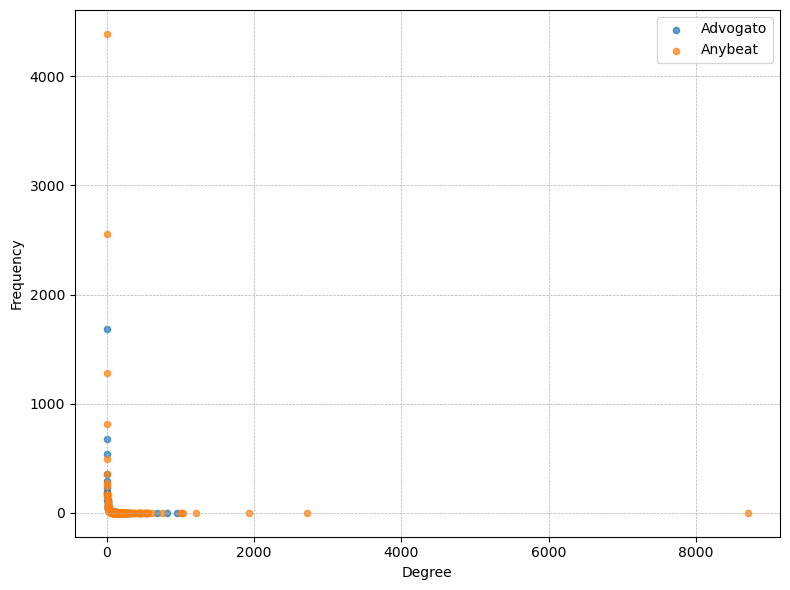

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# --- Extract degree sequences ---
degrees_advogato = [deg for _, deg in G_advogato.degree()]
degrees_anybeat = [deg for _, deg in G_anybeat.degree()]

# --- Get degree frequencies ---
deg_vals_adv, freq_adv = np.unique(degrees_advogato, return_counts=True)
deg_vals_any, freq_any = np.unique(degrees_anybeat, return_counts=True)

# --- Plot ---
plt.figure(figsize=(8, 6))

plt.scatter(deg_vals_adv, freq_adv, alpha=0.7, label="Advogato", color='tab:blue', s=20)
plt.scatter(deg_vals_any, freq_any, alpha=0.7, label="Anybeat", color='tab:orange', s=20)

#plt.xscale('log')
#plt.yscale('log')
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()

# Save as PNG before showing
plt.savefig("degree_distribution_ag_vs_ab.png", dpi=300, bbox_inches='tight')
plt.show()

In [20]:
def print_network_stats(G, name):
    print(f"--- Statistics for {name} ---")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
    print()

# Print stats for both networks
print_network_stats(G_advogato, "Advogato")
print_network_stats(G_anybeat, "Anybeat")


--- Statistics for Advogato ---
Number of nodes: 6551
Number of edges: 51317
Average degree: 15.67

--- Statistics for Anybeat ---
Number of nodes: 12645
Number of edges: 67053
Average degree: 10.61

